In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import sys
sys.path.append('../..')

In [7]:
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [8]:
from stack_segmentation.stack import Stack

In [9]:
from stack_segmentation.aug_pipelines import medium_aug
from stack_segmentation.io import make_dataloader, collate_fn_basic

from stack_segmentation.training import (
    handle_stacks_data, 
    make_optimization_task, 
    train_loop
)

from pipeline_config import (
    dataloaders_conf,
    aug_config,
    train_conf,
    model_config, 
    optimizer_config,
    loss_config,
    scheduler_config,
)

In [10]:
from exp_config import data_conf

## Prepare train, validation and test data

In [7]:
data_train, data_val, data_test = handle_stacks_data(**data_conf)

720it [00:01, 651.73it/s]
100%|██████████| 720/720 [00:07<00:00, 92.90it/s] 
8280it [00:00, 225573.45it/s]
7920it [00:00, 222092.96it/s]
720it [00:00, 791.86it/s]
100%|██████████| 720/720 [00:07<00:00, 94.26it/s] 
8280it [00:00, 197225.45it/s]
720it [00:00, 797.06it/s]
100%|██████████| 720/720 [00:07<00:00, 93.82it/s] 
8280it [00:00, 226631.84it/s]
700it [00:00, 753.72it/s]
100%|██████████| 700/700 [00:07<00:00, 98.83it/s] 
8280it [00:00, 222013.06it/s]
509it [00:00, 1125.10it/s]
100%|██████████| 509/509 [00:02<00:00, 193.97it/s]
3664it [00:00, 225273.46it/s]
700it [00:00, 810.98it/s]
100%|██████████| 700/700 [00:07<00:00, 98.88it/s] 
8280it [00:00, 231649.13it/s]
700it [00:00, 826.80it/s]
100%|██████████| 700/700 [00:07<00:00, 98.85it/s] 
8280it [00:00, 75320.63it/s]
710it [00:01, 377.68it/s]
100%|██████████| 710/710 [00:07<00:00, 96.68it/s] 
8280it [00:00, 226541.66it/s]
710it [00:01, 376.43it/s]
100%|██████████| 710/710 [00:07<00:00, 96.76it/s] 
8280it [00:00, 228766.65it/s]
710it [

In [8]:
len(data_train), len(data_val), len(data_test)

(8280, 7920, 11)

In [9]:
dataloader_train = make_dataloader(
    samples=data_train, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    aug_config=aug_config,
    **dataloaders_conf['train']
)

dataloader_val = make_dataloader(
    samples=data_val, 
    collate_fn=collate_fn_basic,
    model_config=model_config,
    **dataloaders_conf['val']
)

dataloaders_test = {
    name: make_dataloader(
        samples=data, 
        collate_fn=collate_fn_basic,
        model_config=model_config,
        **dataloaders_conf['test']
    ) for name, data in data_test.items()}

## Create model and metrics

In [10]:
from stack_segmentation.metrics import accuracy, precision, recall, f1, pr_auc, iou

In [11]:
metrics = {
    'accuracy': accuracy, 
    'precision': precision, 
    'recall': recall, 
    'f1': f1,
    'pr_auc': pr_auc, 
    'iou': iou,
}

In [12]:
device = 'cuda:0'

In [13]:
model, criterion, optimizer, scheduler = make_optimization_task(
    device,
    model_config=model_config,
    loss_config=loss_config, 
    optimizer_config=optimizer_config,
    scheduler_config=scheduler_config)

## Run experiment

In [ ]:
results = train_loop(
    model=model,
    dataloader_train=dataloader_train, 
    dataloader_val=dataloader_val,
    dataloaders_test=dataloaders_test,
    criterion=criterion, 
    optimizer=optimizer, 
    scheduler=scheduler,
    metrics=metrics,
    exp_name=data_conf['conf_name'],
    **train_conf)

## Dump experiment results

In [12]:
import pickle
import json

In [3]:
# p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
# with open(p, 'wb') as f:
#     pickle.dump(results, f)

In [13]:
p = './{}_exp_results.pkl'.format(data_conf['conf_name'])
with open(p, 'rb') as f:
    results = pickle.load(f)

In [16]:
import torch
model.load_state_dict(torch.load('./{}.pt'.format(data_conf['conf_name'])))
# model = model.to('cpu').to(device)

<All keys matched successfully>

## Train and validation losses

In [18]:
from itertools import chain

In [19]:
train_losses = list(chain(*[item for item in results['train_losses']]))
val_losses = list(chain(*[item for item in results['val_losses']]))

In [20]:
def moving_average(a, n=5) :
    ret = np.cumsum([a[0]] * (n - 1) + a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

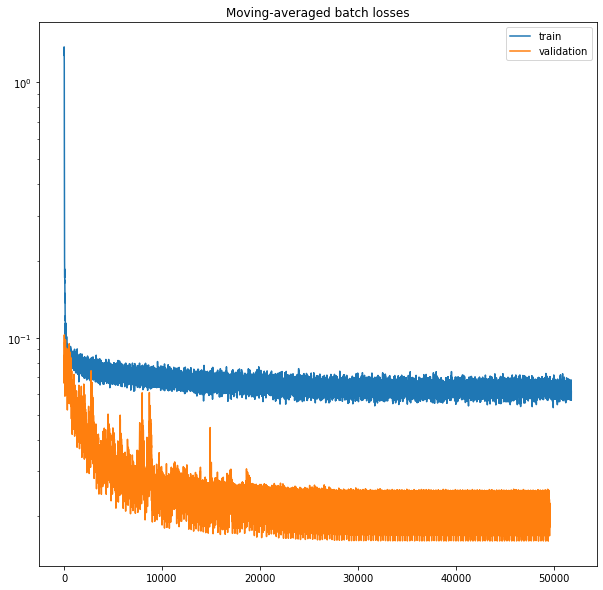

In [21]:
plt.figure(figsize=(10, 10))
plt.title('Moving-averaged batch losses')
plt.plot(np.arange(len(train_losses)), moving_average(train_losses), label='train')
plt.plot(np.arange(len(val_losses)), moving_average(val_losses), label='validation')

plt.legend(loc='best')
plt.yscale('log')

# plt.ylim([1e-2, 1])
plt.show()

In [22]:
mean_train_loss = [np.mean(item) for item in results['train_losses']]
mean_val_loss = [np.mean(item) for item in results['val_losses']]

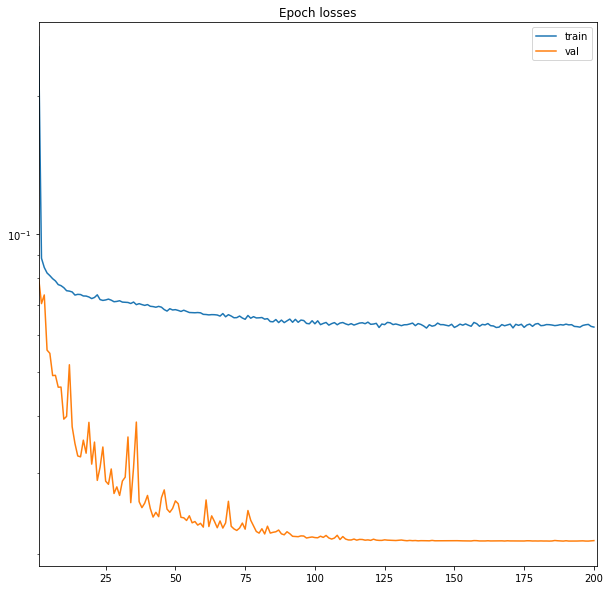

In [23]:
plt.figure(figsize=(10, 10))
plt.title('Epoch losses')
plt.plot(np.arange(len(mean_train_loss)) + 1, mean_train_loss, label='train')
plt.plot(np.arange(len(mean_val_loss)) + 1, mean_val_loss, label='val')

plt.yscale('log')
plt.legend(loc='best')

plt.xlim([1, len(mean_train_loss) + 1])
plt.show()

## Predicted samples

In [24]:
import os

In [25]:
import torch

In [26]:
from visualization_utils import output_to_binary, plot_sample, make_colored_diff

In [27]:
threshold = 0.5
to_plot = 10
# device = model_conf['device']

Prediction for carb96558:


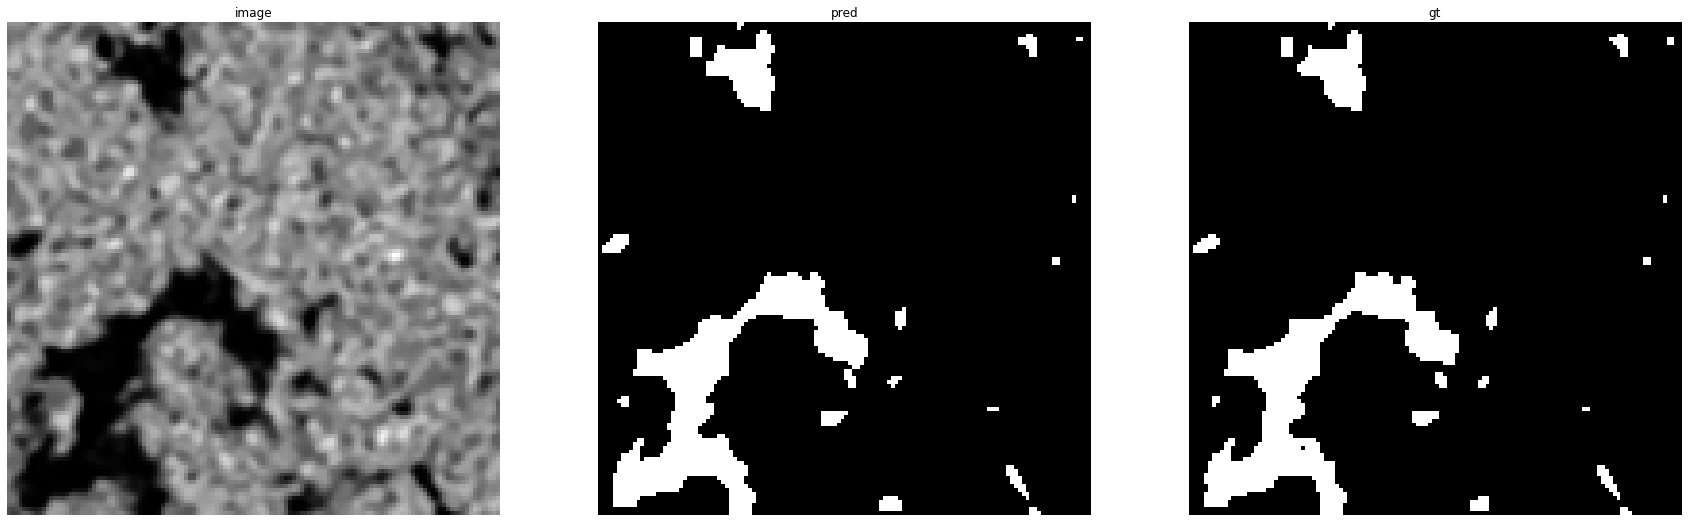

accuracy    : 0.9952392578125
precision   : 0.9606003752345216
recall      : 0.9903288201160542
f1          : 0.9752380952380953
pr_auc      : 0.9986575337983462
iou         : 0.9516728624535316


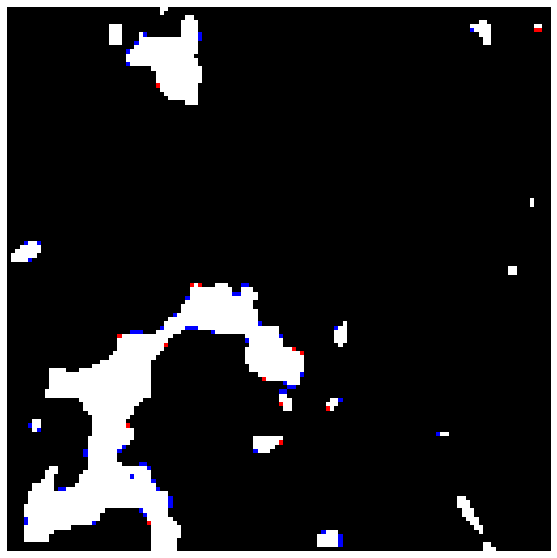

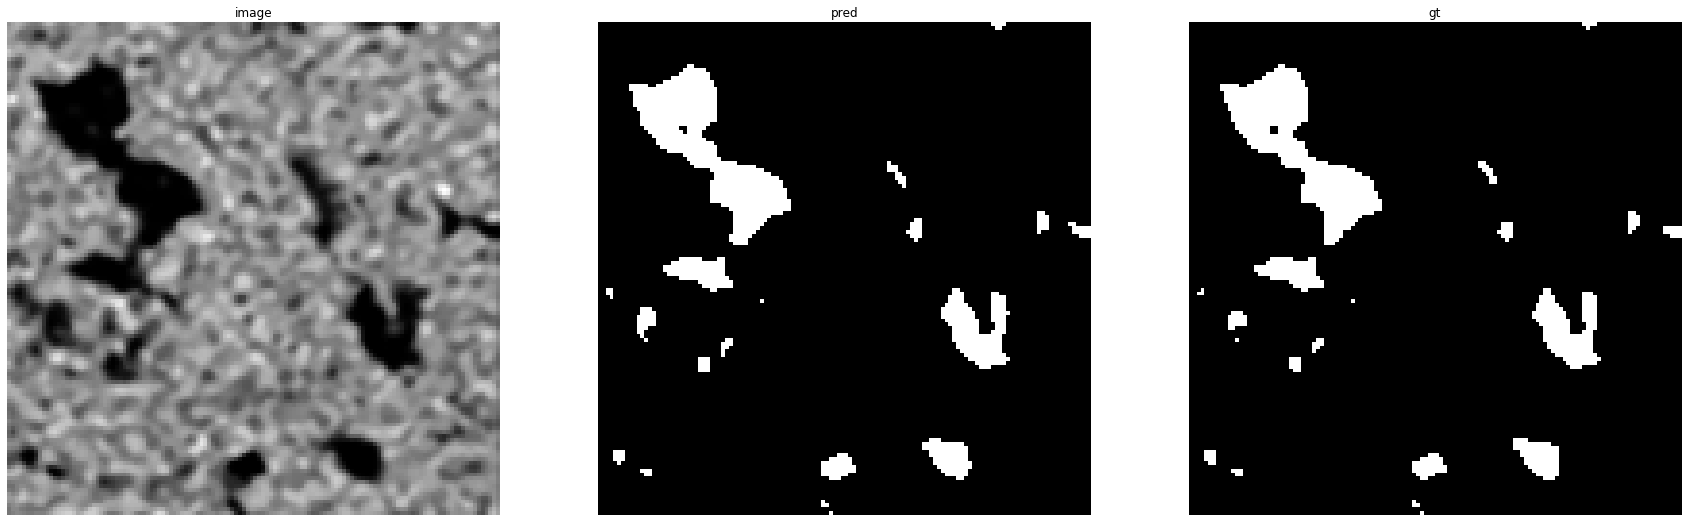

accuracy    : 0.99658203125
precision   : 0.9628751974723538
recall      : 0.992671009771987
f1          : 0.9775461106655974
pr_auc      : 0.9987193924938629
iou         : 0.956078431372549


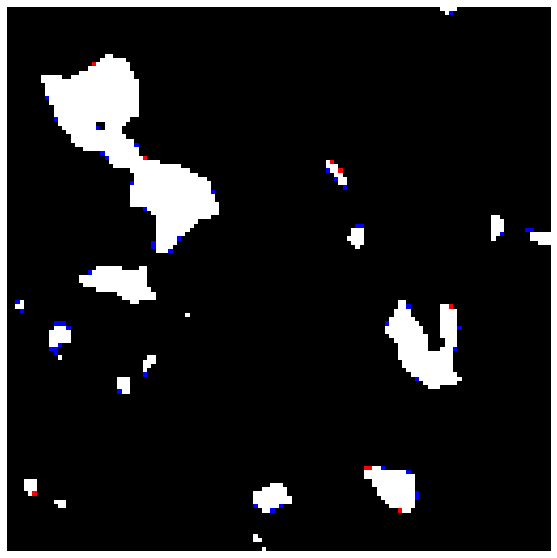

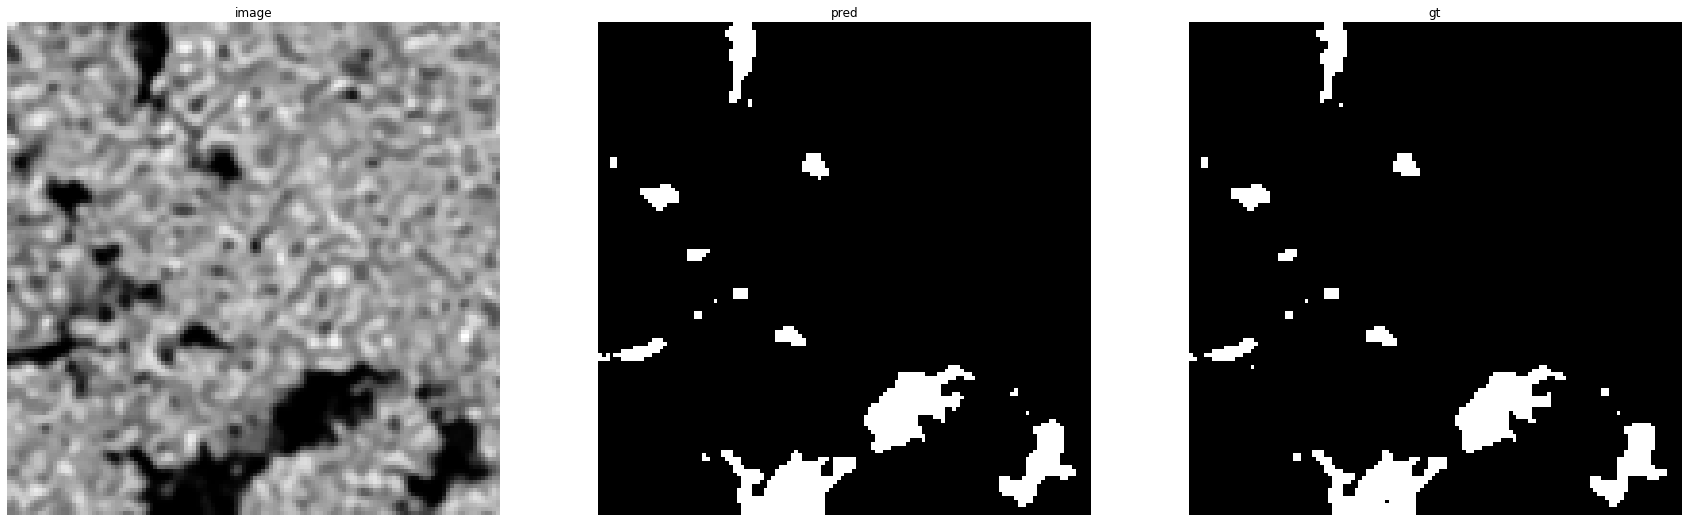

accuracy    : 0.99609375
precision   : 0.9551056338028169
recall      : 0.98816029143898
f1          : 0.9713518352730529
pr_auc      : 0.9975436813403309
iou         : 0.9442993907745866


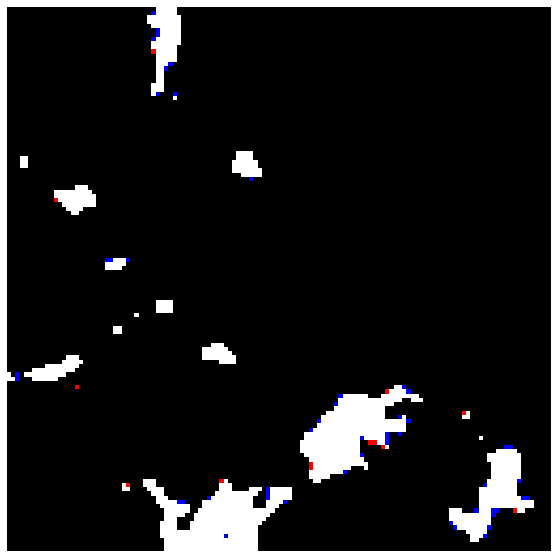

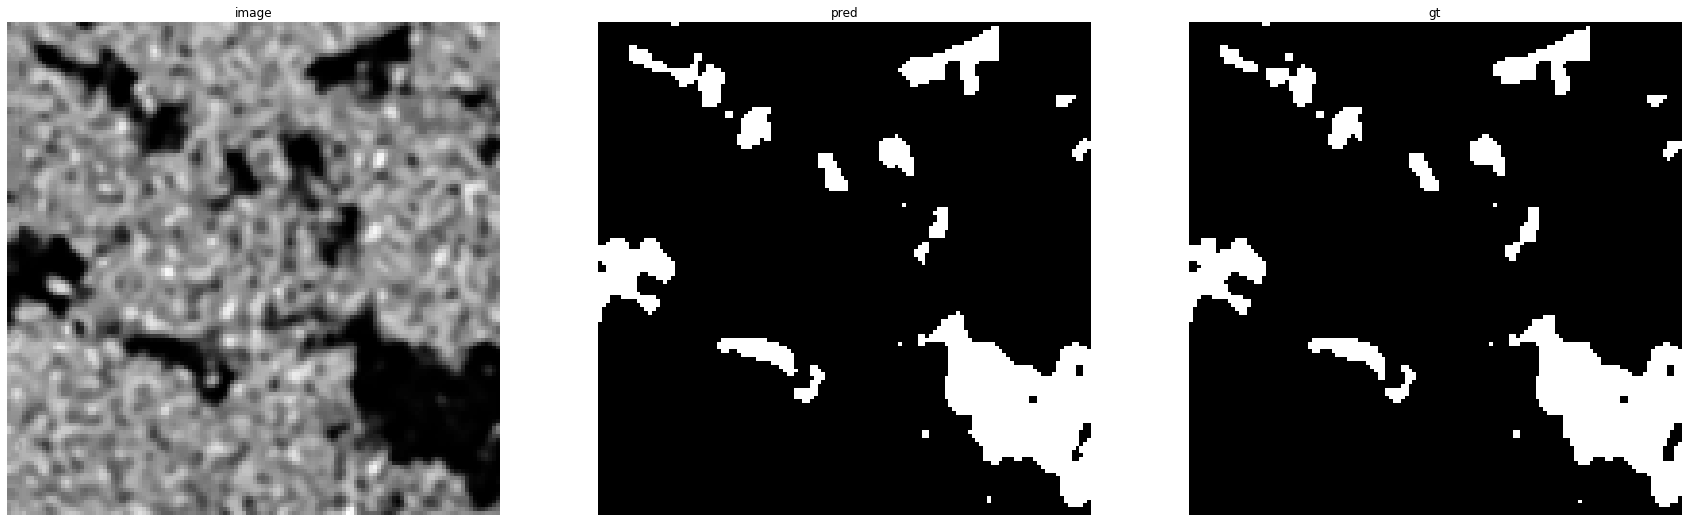

accuracy    : 0.99432373046875
precision   : 0.963302752293578
recall      : 0.9915506958250497
f1          : 0.9772226304188096
pr_auc      : 0.9989916839576676
iou         : 0.9554597701149425


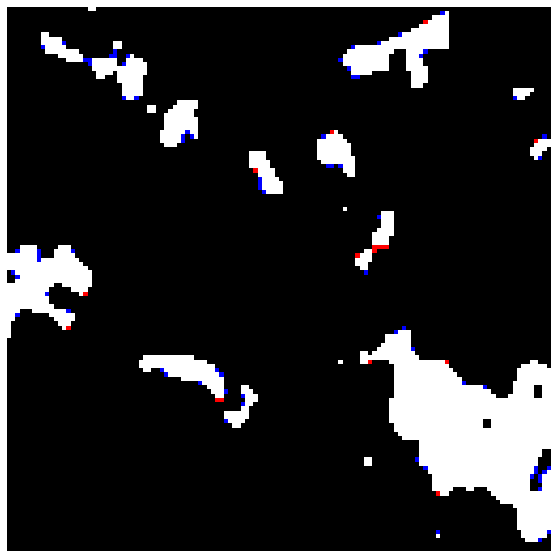

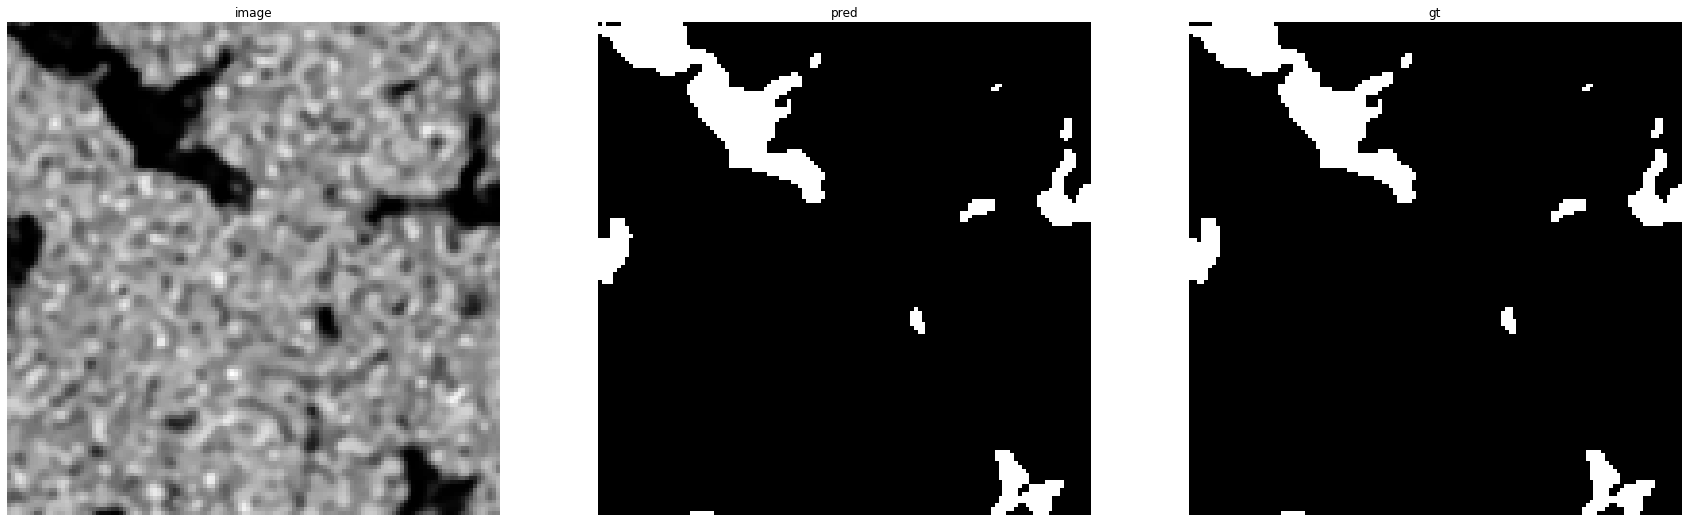

accuracy    : 0.998046875
precision   : 0.979483282674772
recall      : 0.9961360123647605
f1          : 0.9877394636015326
pr_auc      : 0.9993358973038745
iou         : 0.975775927327782


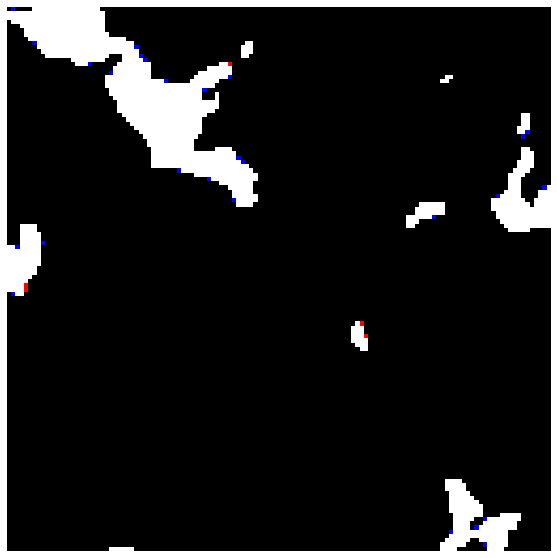

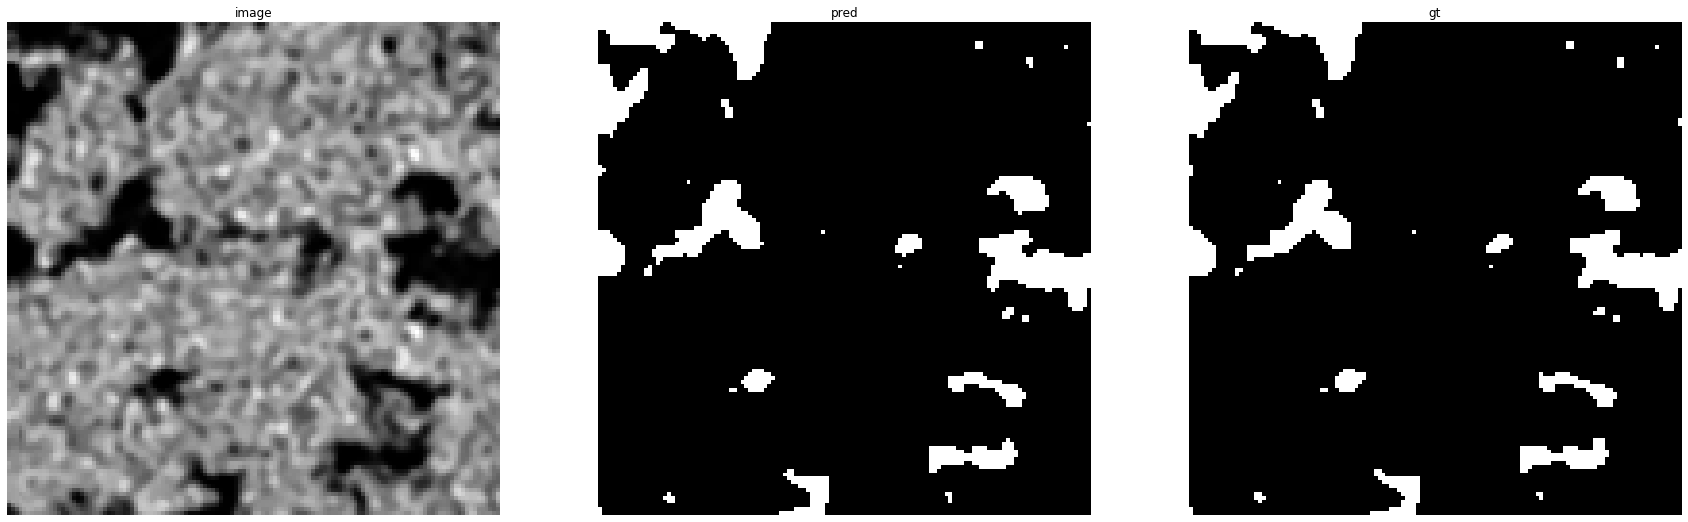

accuracy    : 0.99493408203125
precision   : 0.9563802083333334
recall      : 0.9892255892255892
f1          : 0.9725256537570341
pr_auc      : 0.9980799057231393
iou         : 0.946520618556701


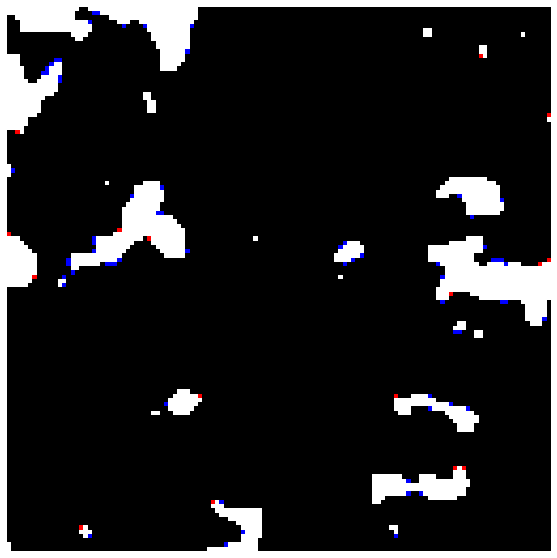

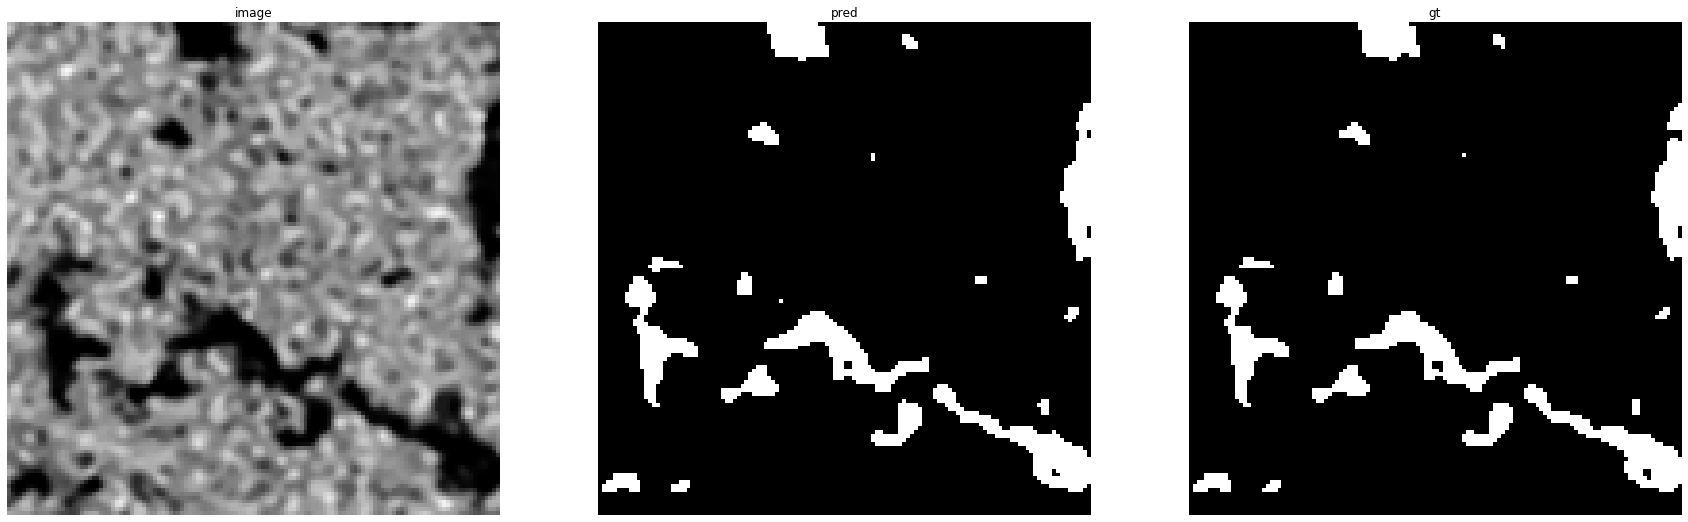

accuracy    : 0.99609375
precision   : 0.9586894586894587
recall      : 0.9955621301775148
f1          : 0.97677793904209
pr_auc      : 0.9987468777597489
iou         : 0.9546099290780142


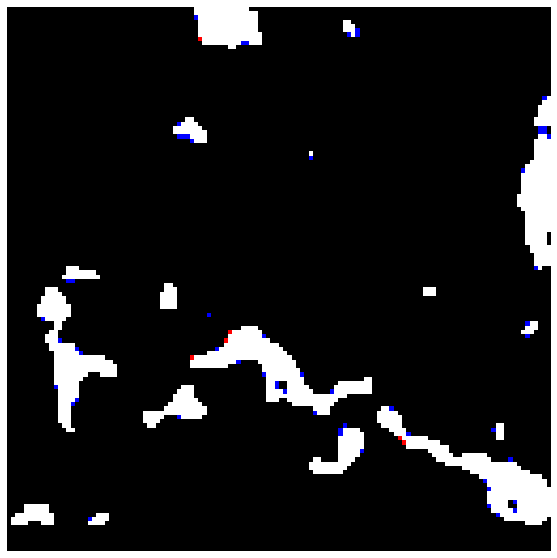

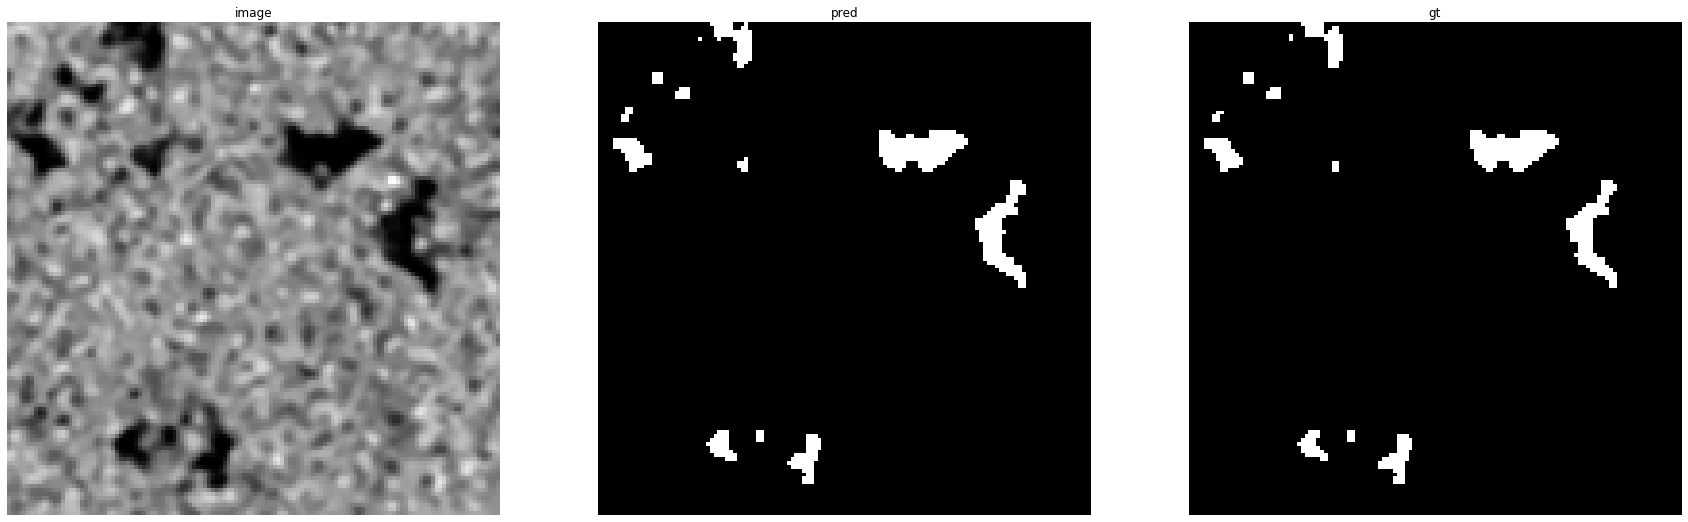

accuracy    : 0.99798583984375
precision   : 0.9501718213058419
recall      : 0.992818671454219
f1          : 0.971027216856892
pr_auc      : 0.9976352886942268
iou         : 0.9436860068259386


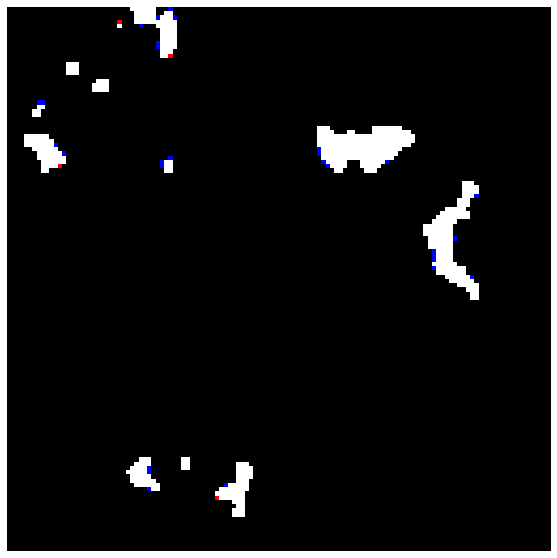

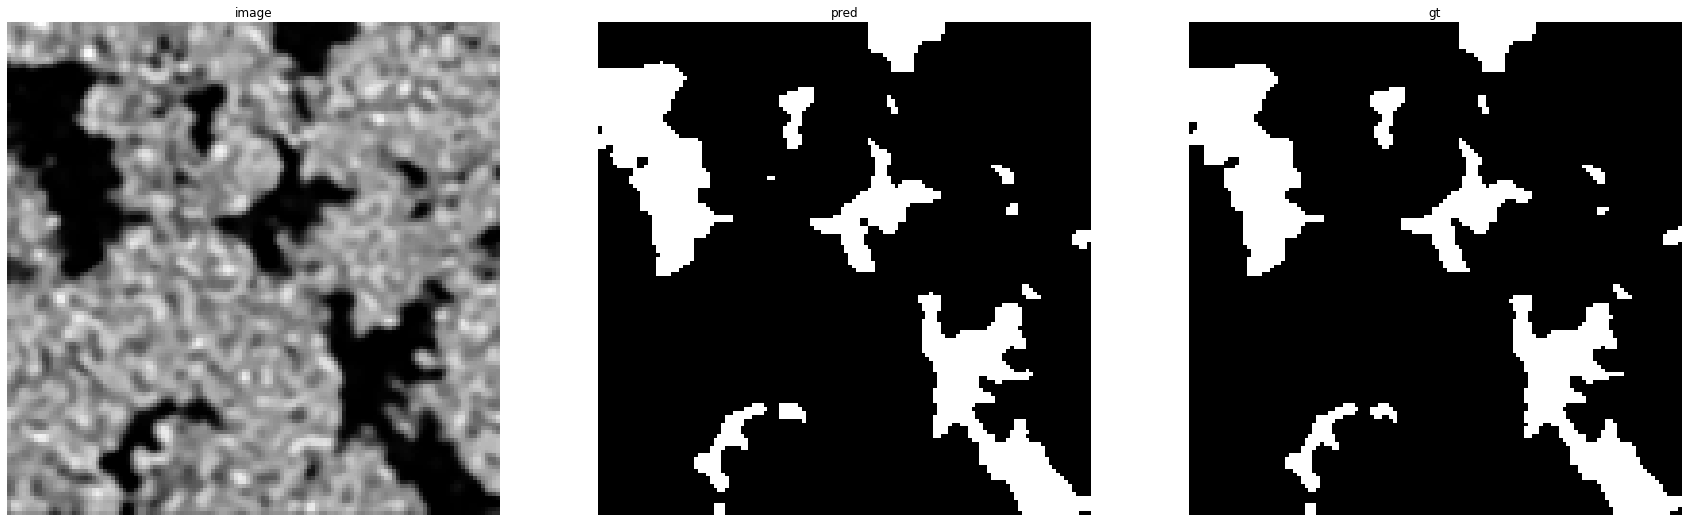

accuracy    : 0.9951171875
precision   : 0.9741506646971935
recall      : 0.9962235649546828
f1          : 0.9850634802091112
pr_auc      : 0.9994342890370643
iou         : 0.9705665930831494


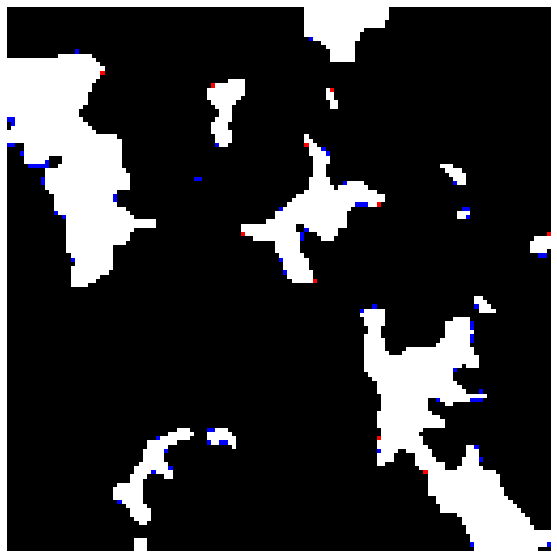

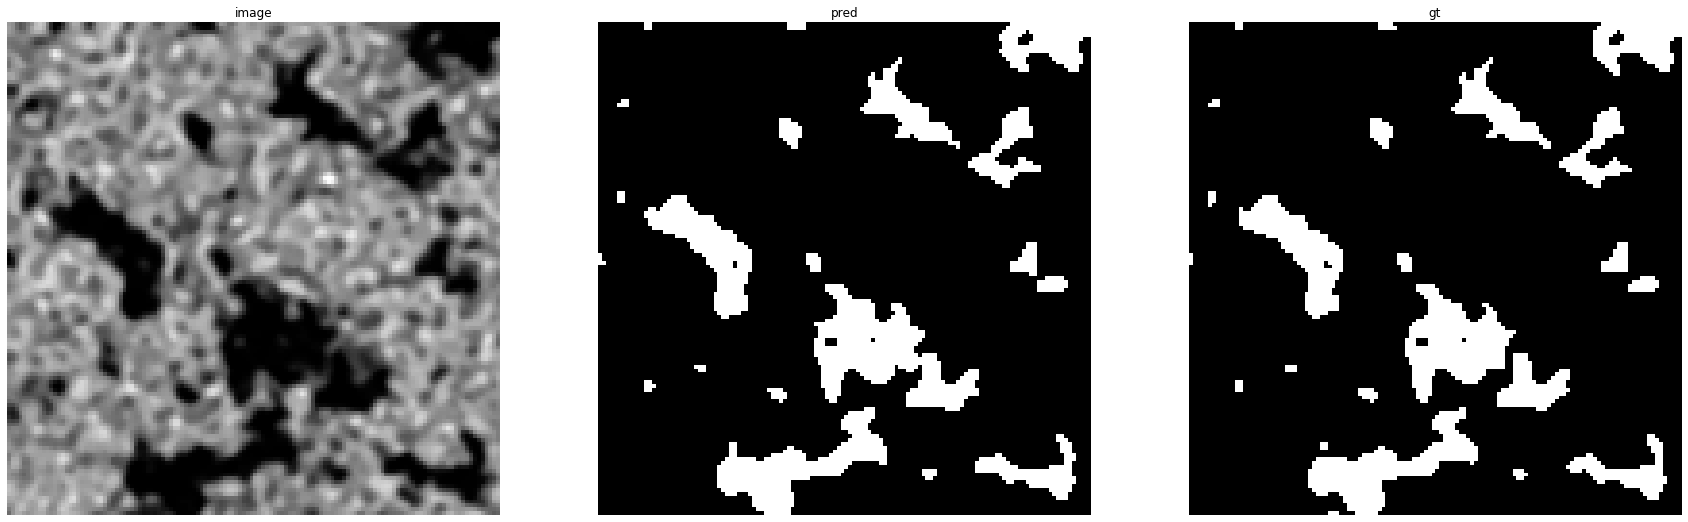

accuracy    : 0.9930419921875
precision   : 0.9590371621621622
recall      : 0.9925699300699301
f1          : 0.9755154639175257
pr_auc      : 0.9984100857568448
iou         : 0.9522012578616352


Prediction for carb71:


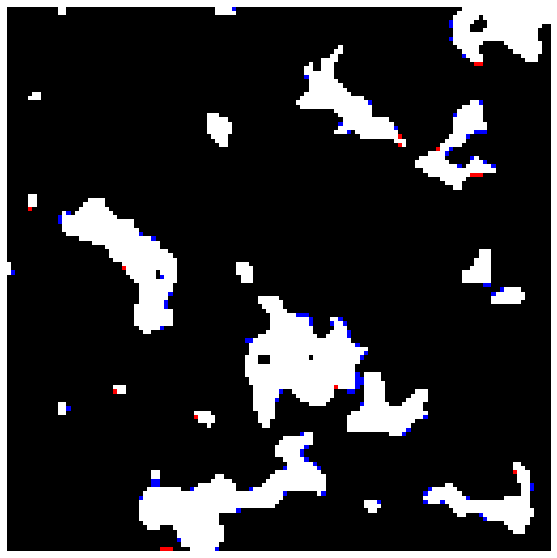

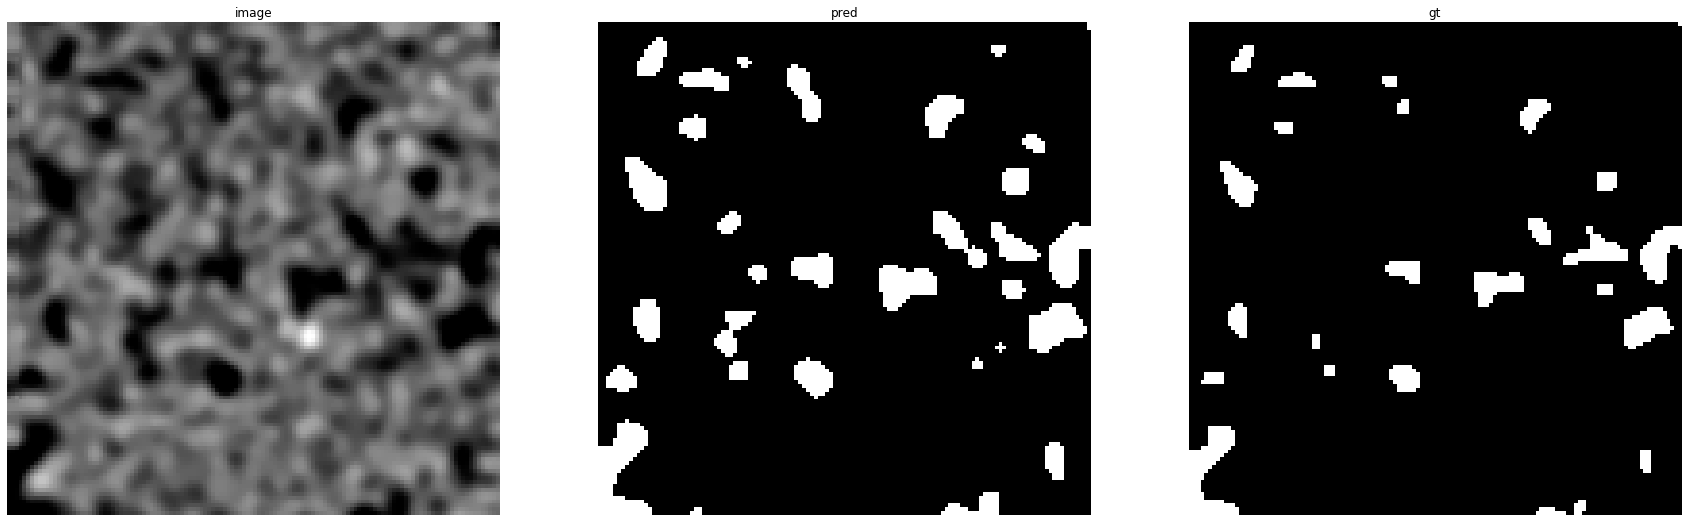

accuracy    : 0.95269775390625
precision   : 0.5571014492753623
recall      : 0.9886831275720165
f1          : 0.7126436781609196
pr_auc      : 0.9655479728154674
iou         : 0.5535714285714286


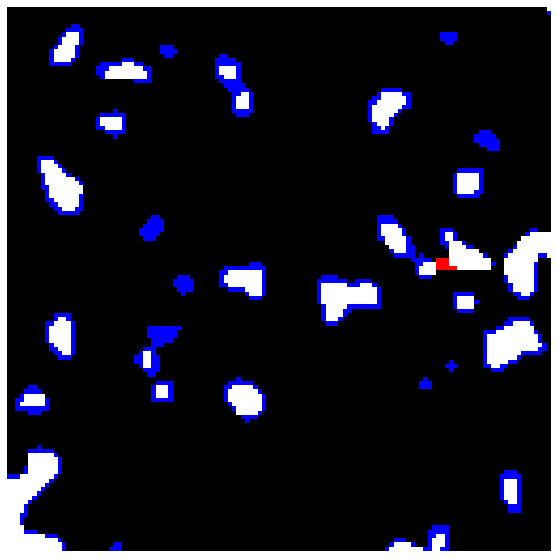

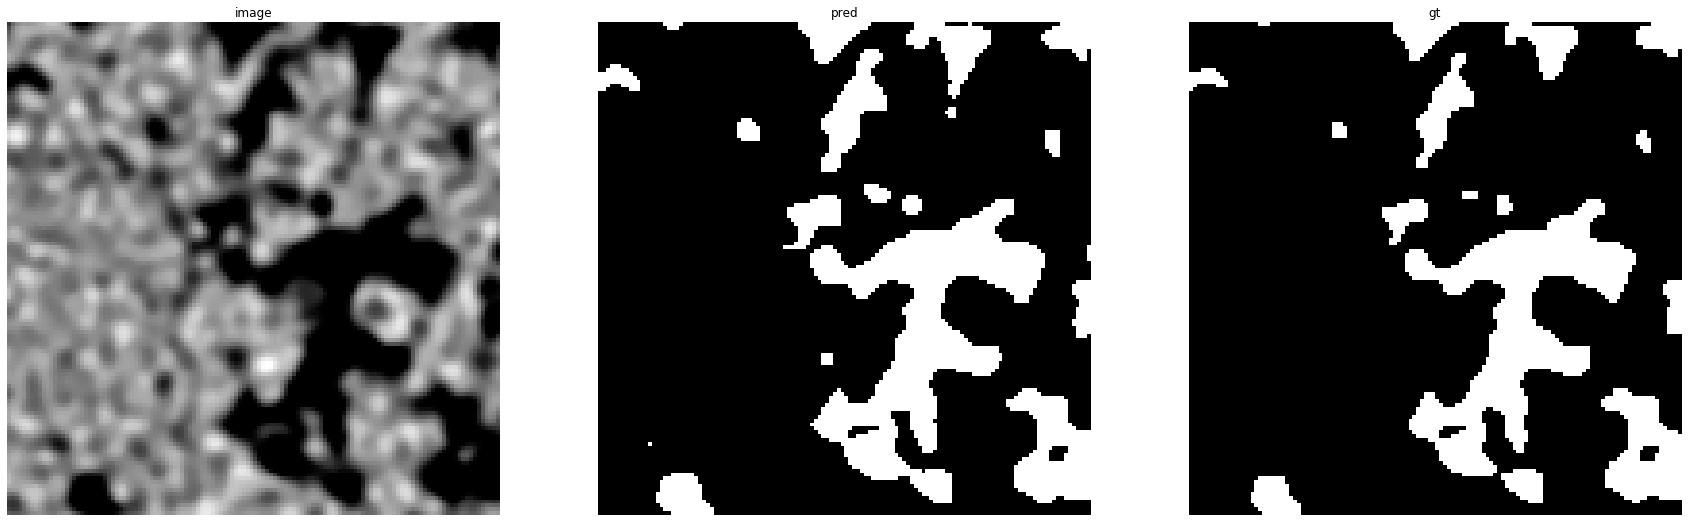

accuracy    : 0.97314453125
precision   : 0.8686131386861314
recall      : 0.9972067039106145
f1          : 0.928478543563069
pr_auc      : 0.9964362566222239
iou         : 0.866504854368932


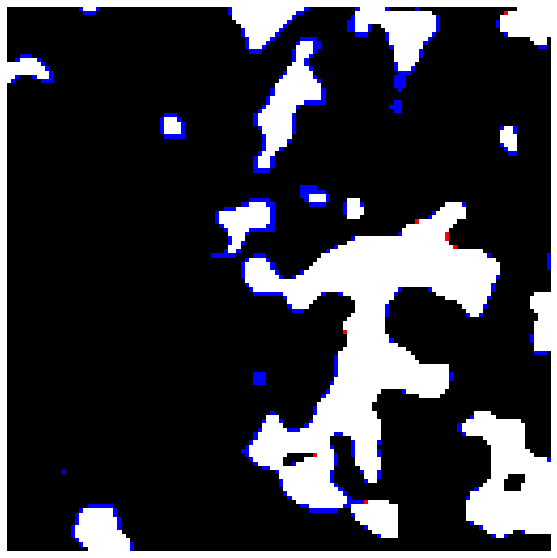

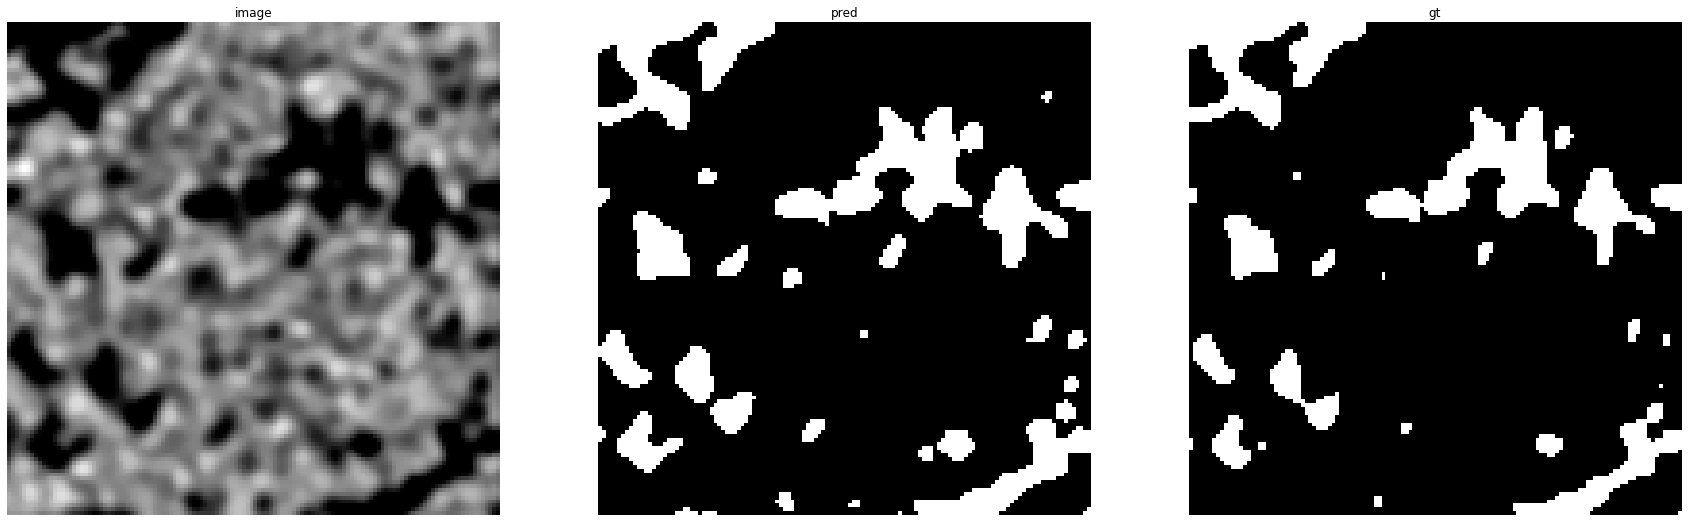

accuracy    : 0.96539306640625
precision   : 0.8103566529492455
recall      : 0.9941102229701304
f1          : 0.89287738522577
pr_auc      : 0.9917067425221331
iou         : 0.8064846416382253


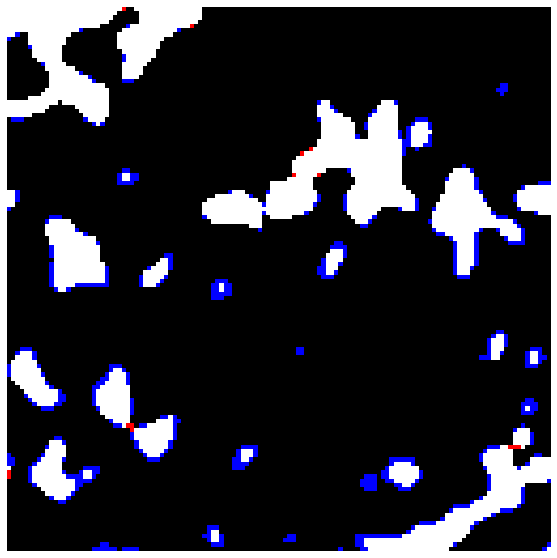

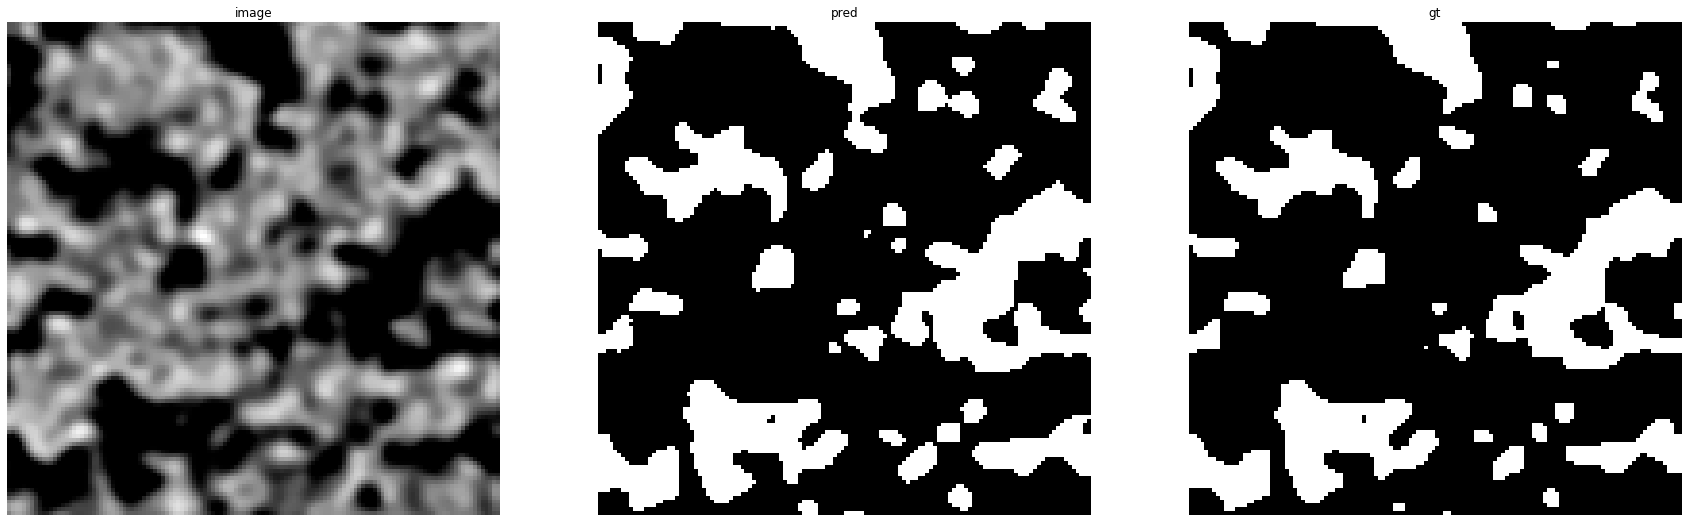

accuracy    : 0.95928955078125
precision   : 0.8606189967982925
recall      : 0.9965397923875432
f1          : 0.9236055434658115
pr_auc      : 0.9963306525641538
iou         : 0.8580549052989997


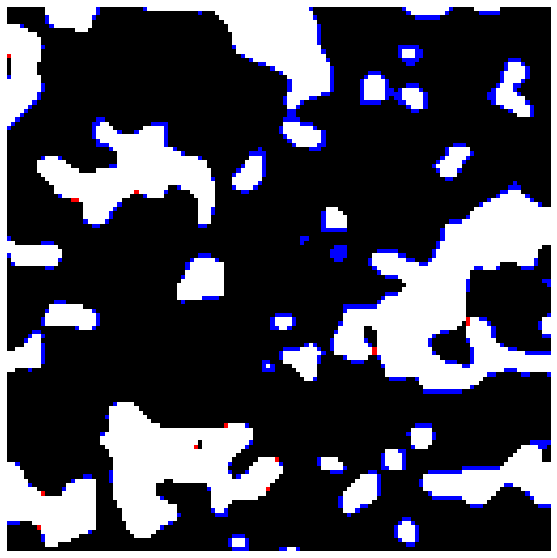

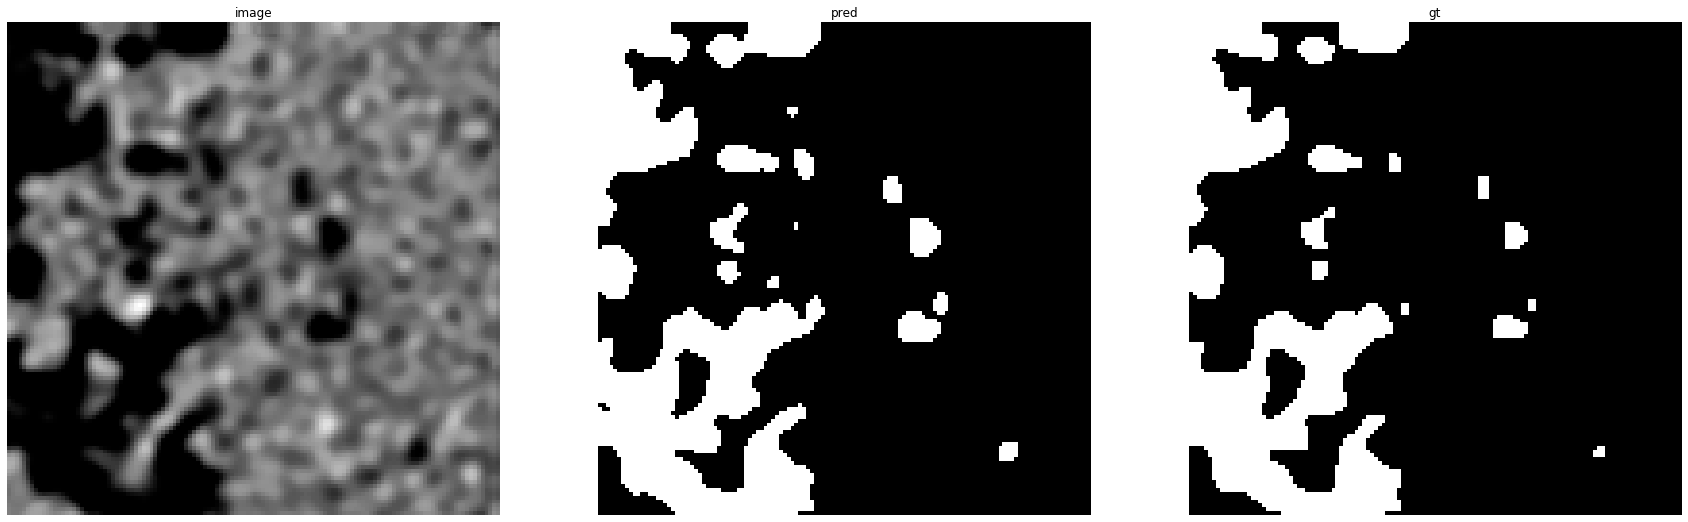

accuracy    : 0.97418212890625
precision   : 0.8787967289719626
recall      : 0.9973483592973152
f1          : 0.9343269678621332
pr_auc      : 0.9974841643565672
iou         : 0.8767482517482518


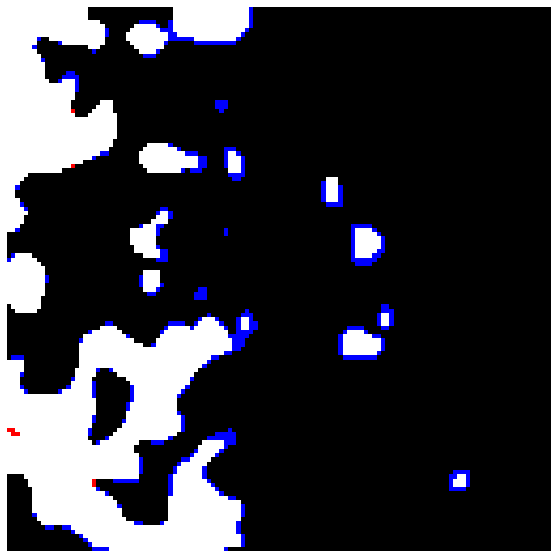

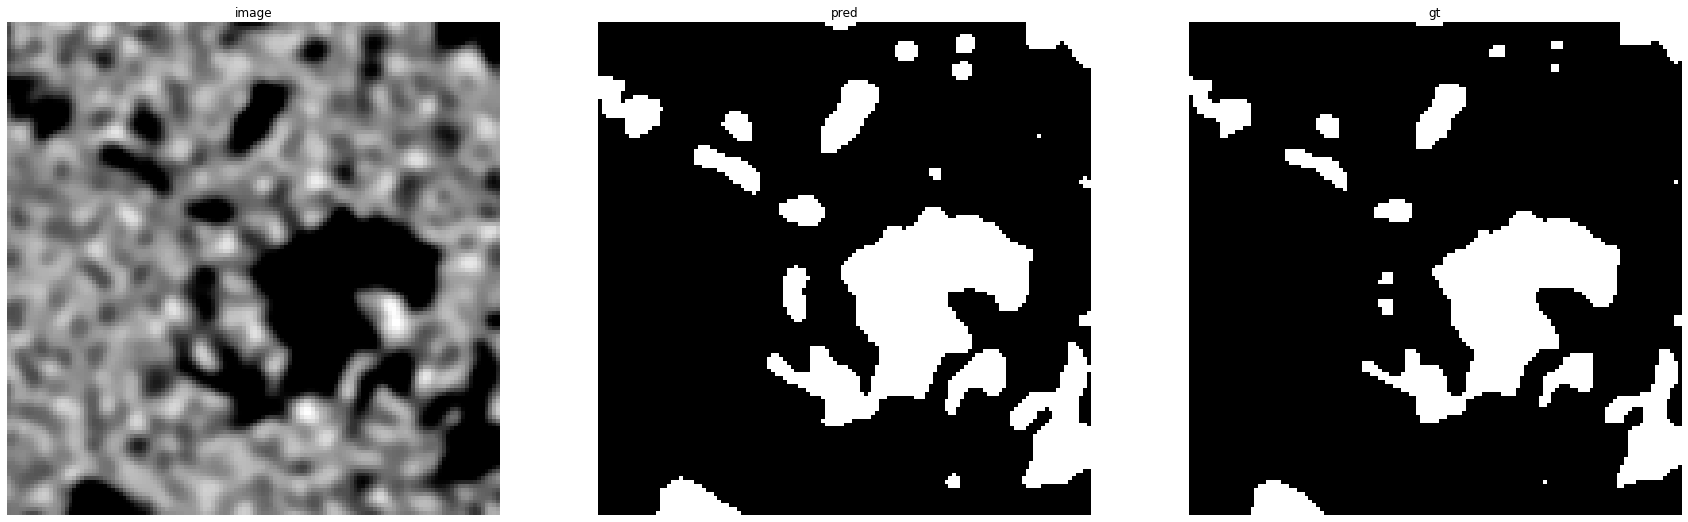

accuracy    : 0.96466064453125
precision   : 0.8216815522020327
recall      : 1.0
f1          : 0.9021132713440406
pr_auc      : 0.9974381577914633
iou         : 0.8216815522020327


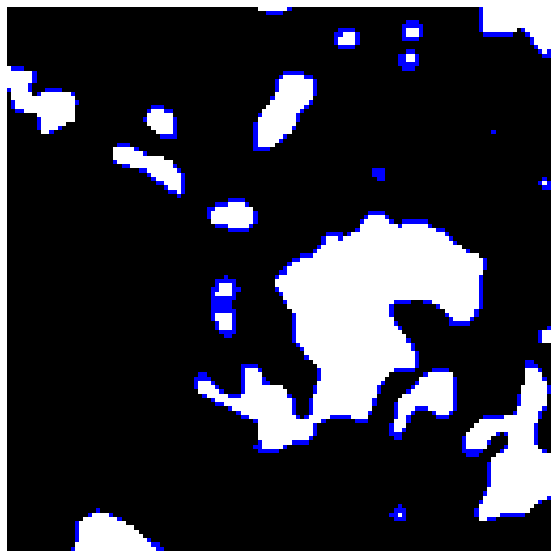

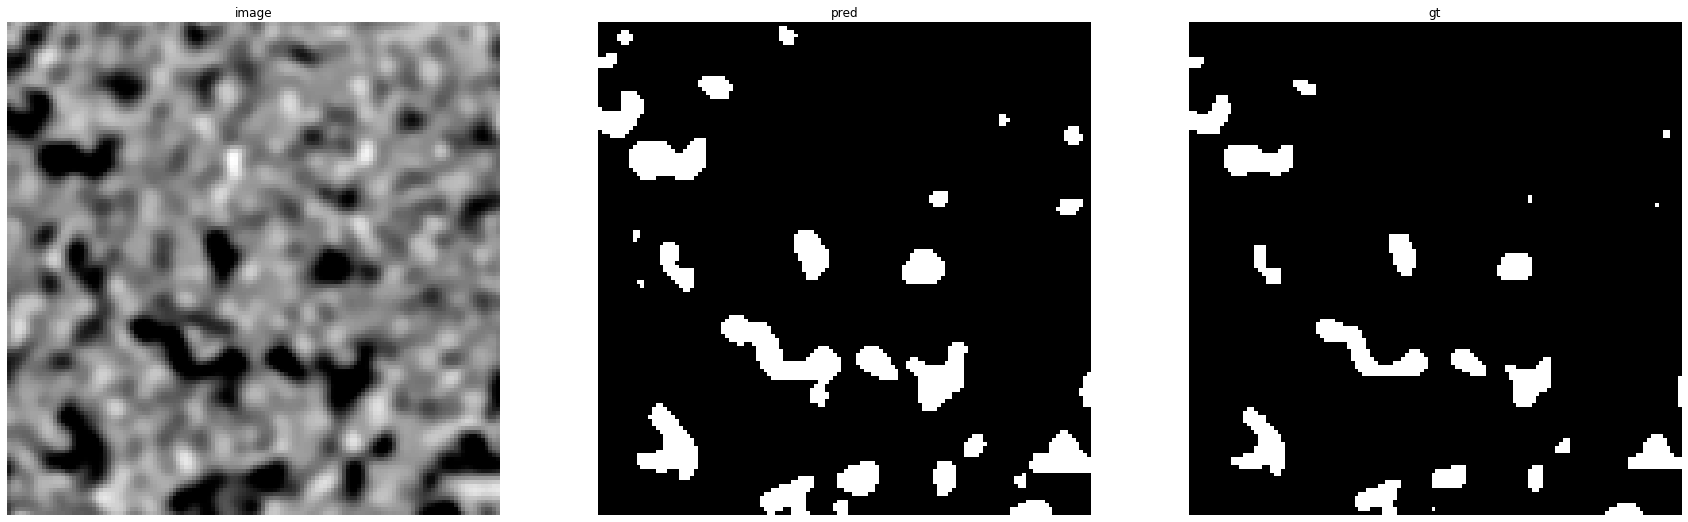

accuracy    : 0.96002197265625
precision   : 0.6207295888824551
recall      : 1.0
f1          : 0.765987852804573
pr_auc      : 0.9822806067319607
iou         : 0.6207295888824551


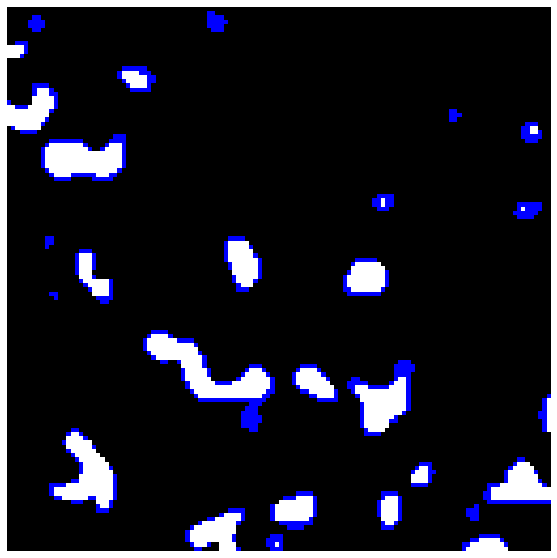

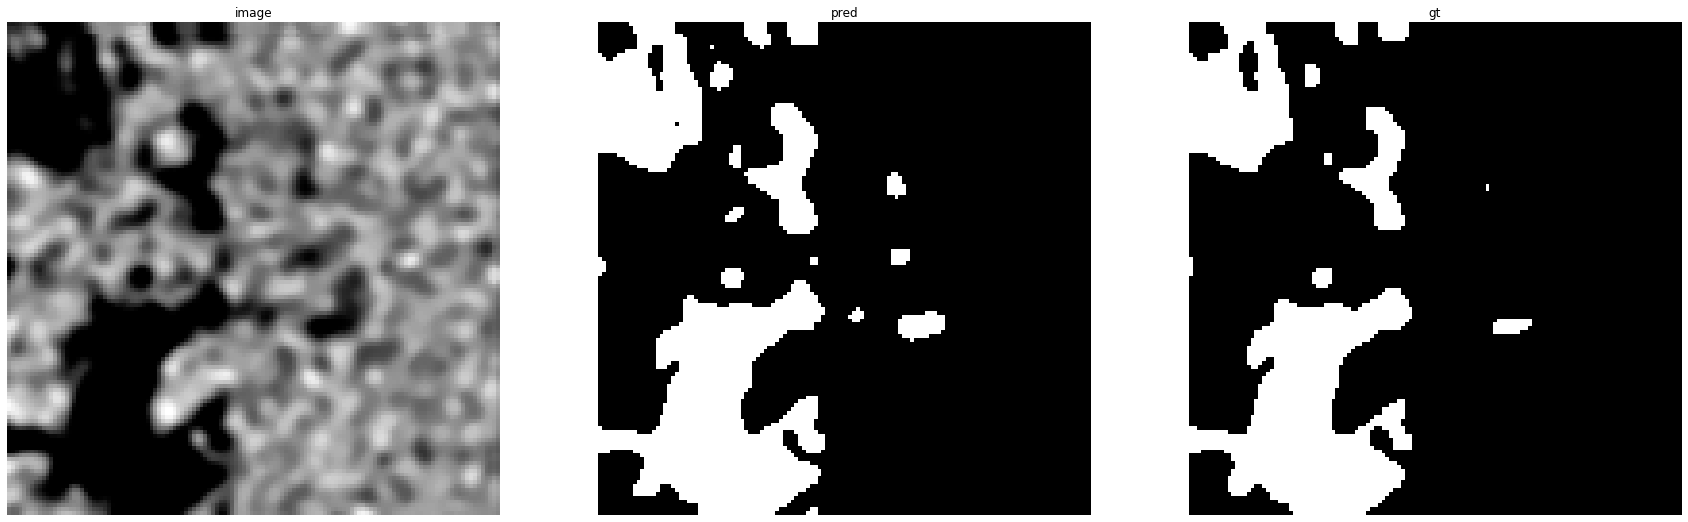

accuracy    : 0.97802734375
precision   : 0.8928571428571429
recall      : 0.9979702300405954
f1          : 0.9424920127795527
pr_auc      : 0.9973401689286358
iou         : 0.8912386706948641


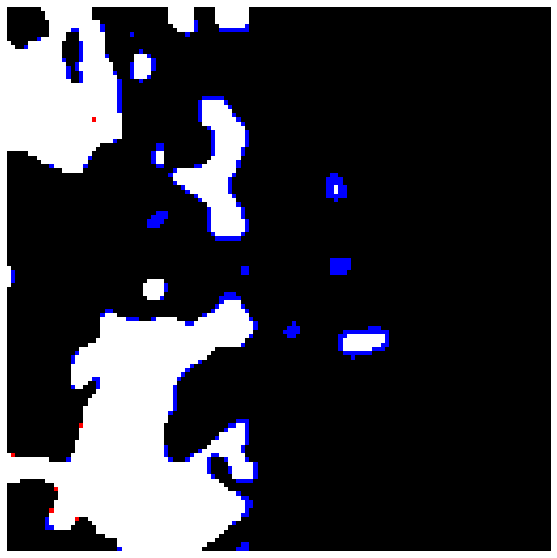

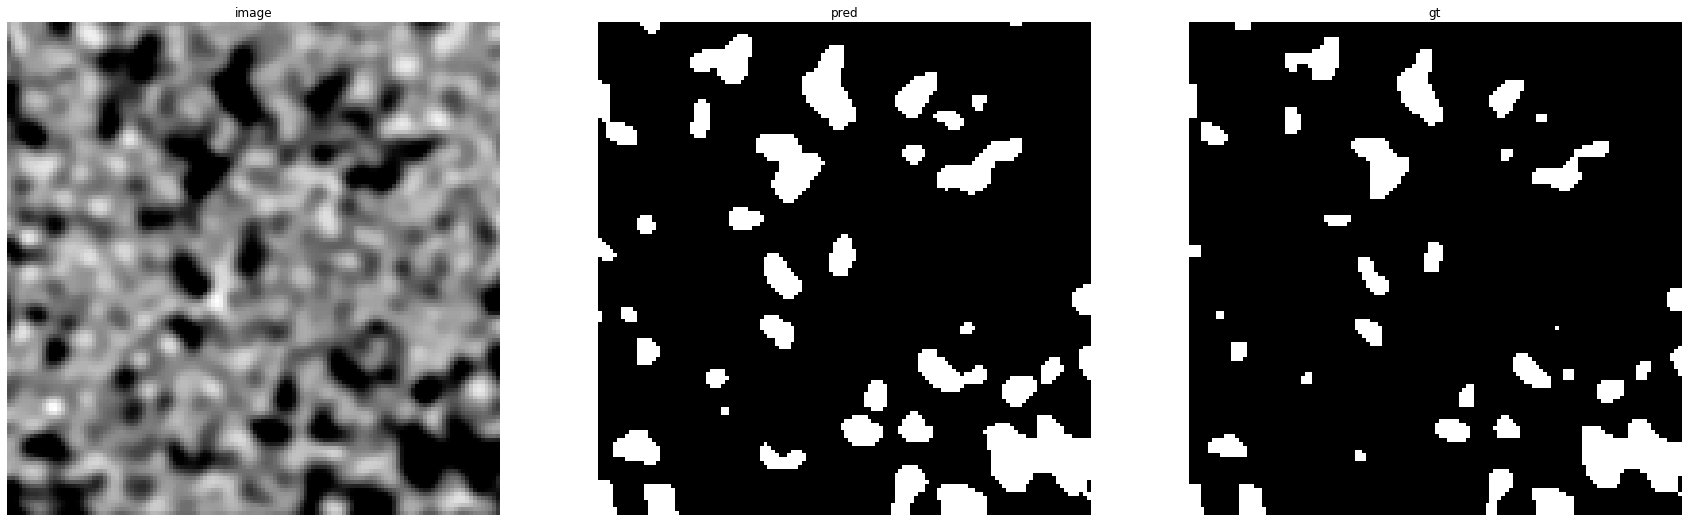

accuracy    : 0.9493408203125
precision   : 0.6615008156606852
recall      : 1.0
f1          : 0.7962690230731468
pr_auc      : 0.9890121800539965
iou         : 0.6615008156606852


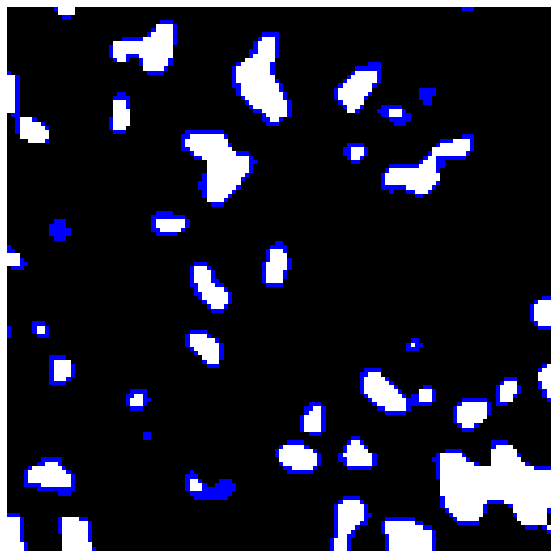

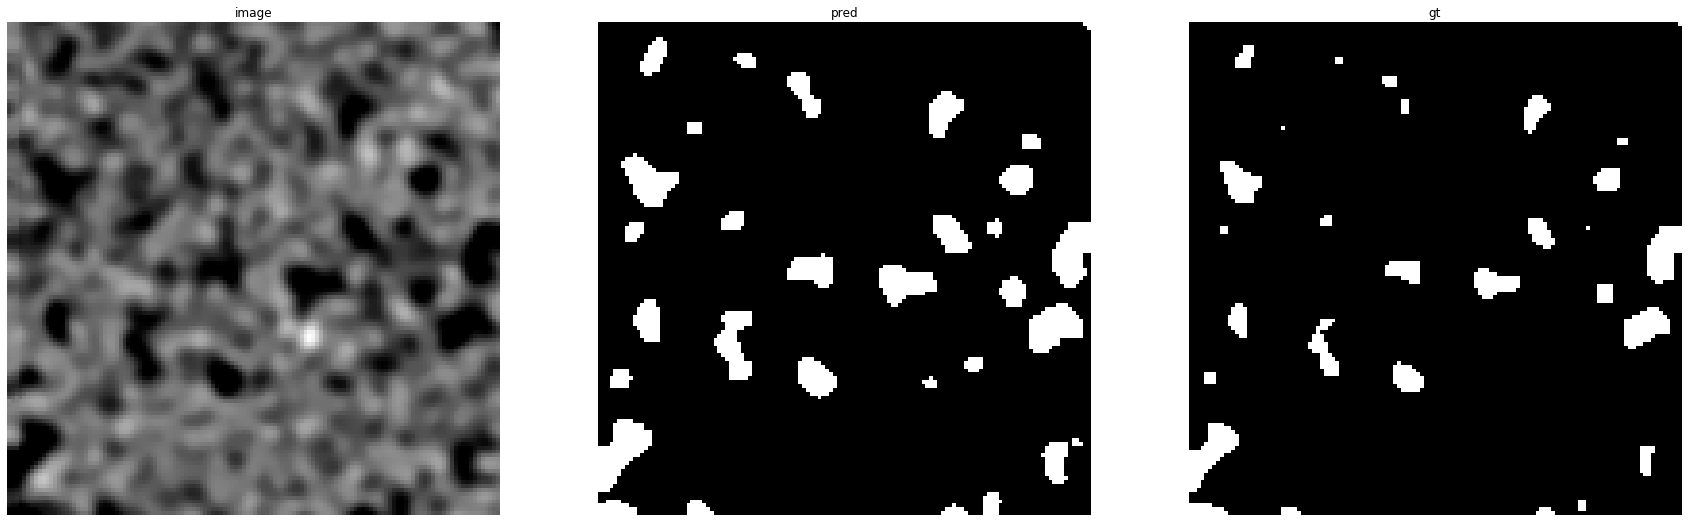

accuracy    : 0.9576416015625
precision   : 0.5670617592014972
recall      : 1.0
f1          : 0.7237261146496815
pr_auc      : 0.984722602502451
iou         : 0.5670617592014972


Prediction for carbRNF:


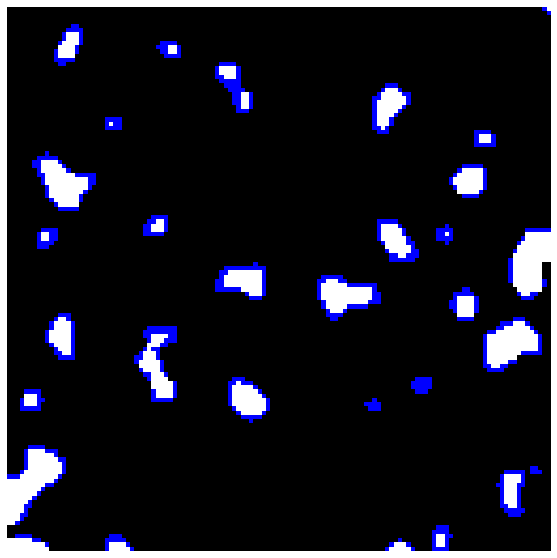

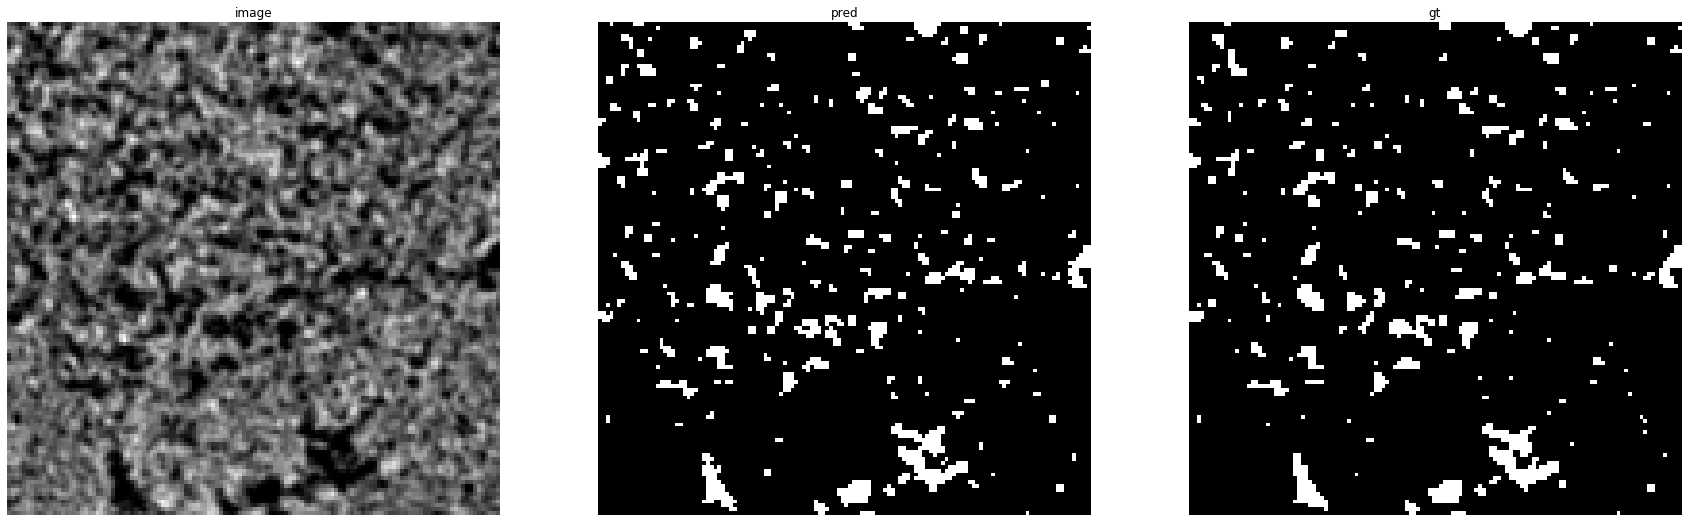

accuracy    : 0.98486328125
precision   : 0.8657407407407407
recall      : 0.9381270903010034
f1          : 0.9004815409309791
pr_auc      : 0.973858661900968
iou         : 0.8189781021897811


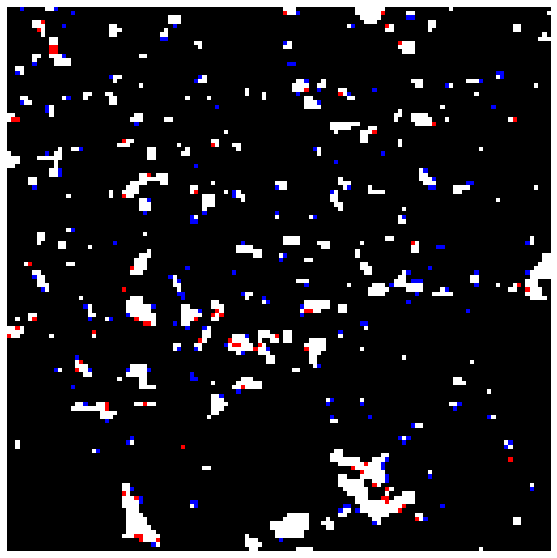

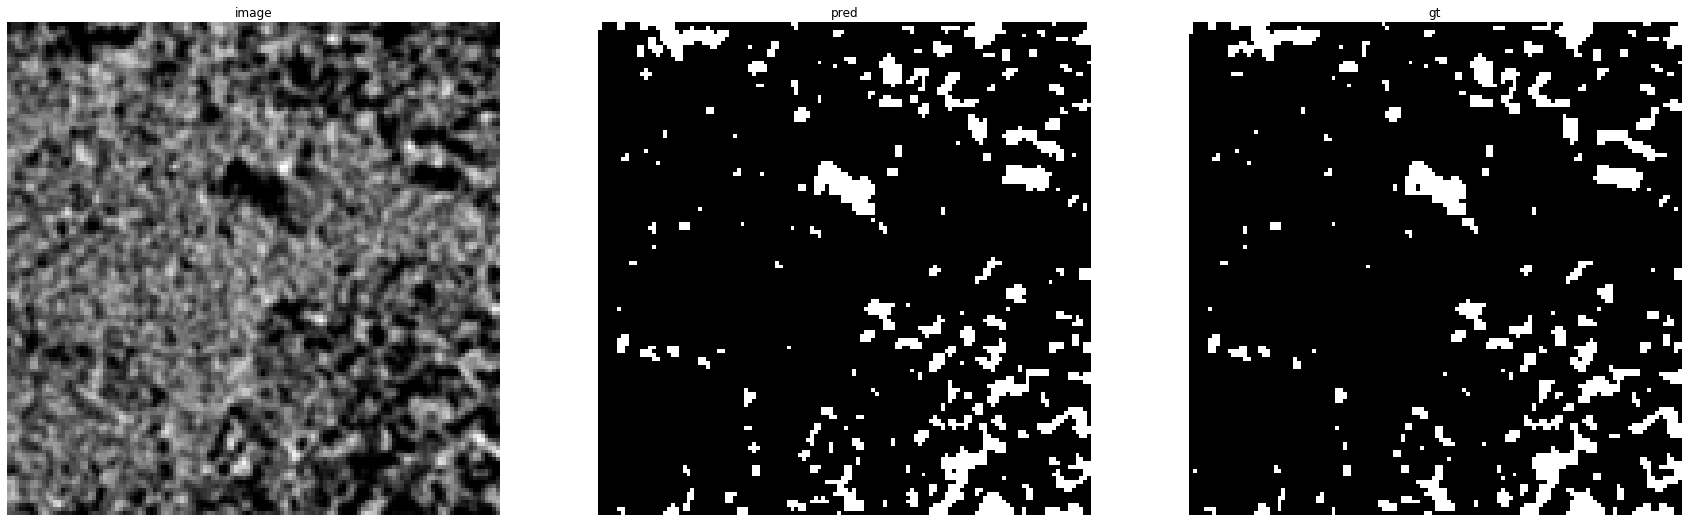

accuracy    : 0.982177734375
precision   : 0.9087779690189329
recall      : 0.9225393127548049
f1          : 0.915606936416185
pr_auc      : 0.978285179309665
iou         : 0.8443496801705757


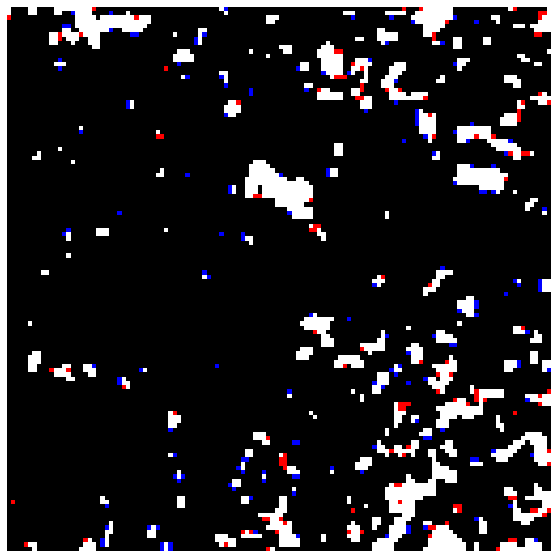

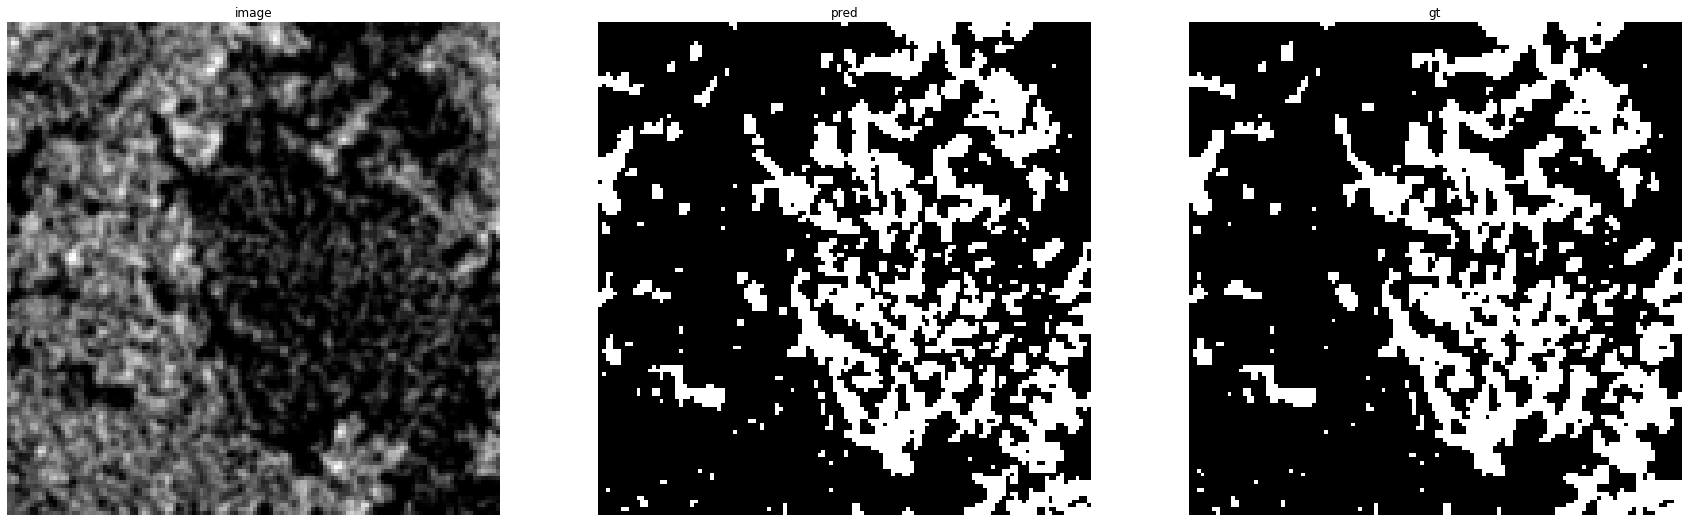

accuracy    : 0.96380615234375
precision   : 0.9664094416704494
recall      : 0.9053795449712949
f1          : 0.9348995498957076
pr_auc      : 0.9894275668997621
iou         : 0.8777571634714492


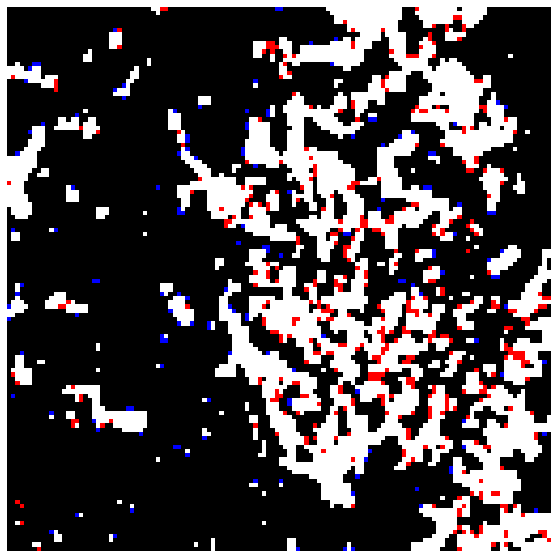

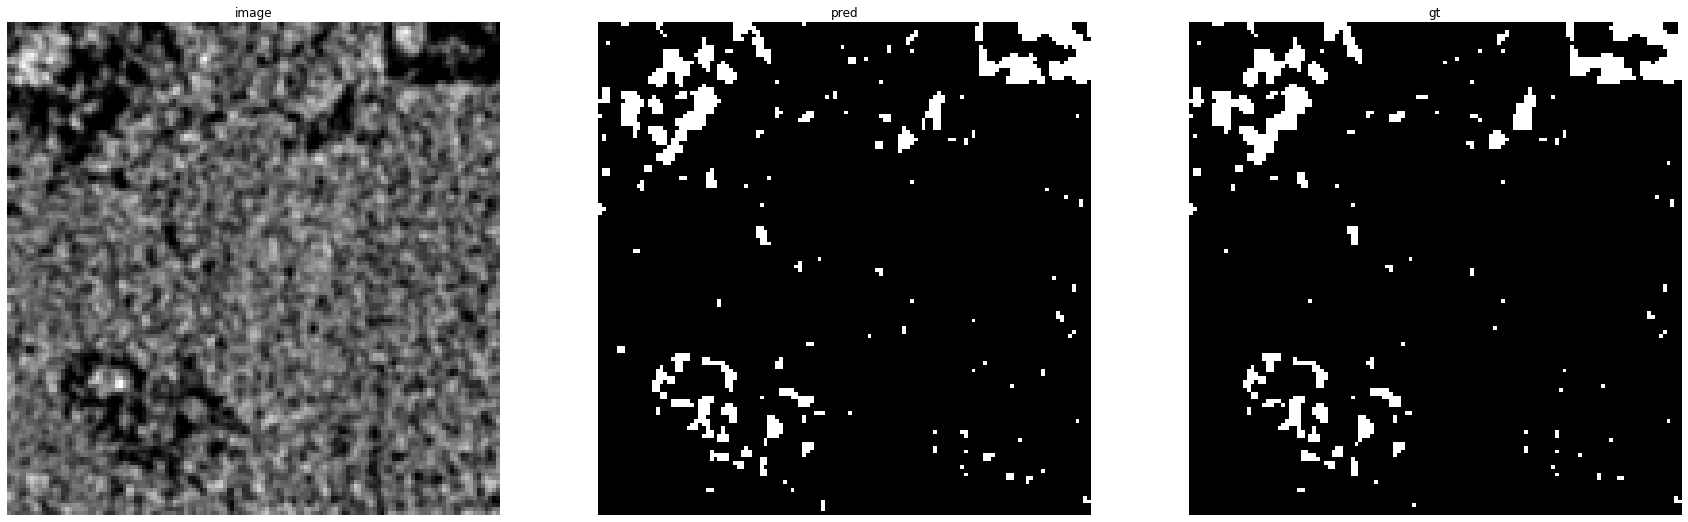

accuracy    : 0.98992919921875
precision   : 0.9158091674462114
recall      : 0.928842504743833
f1          : 0.922279792746114
pr_auc      : 0.9796102499204915
iou         : 0.8557692307692307


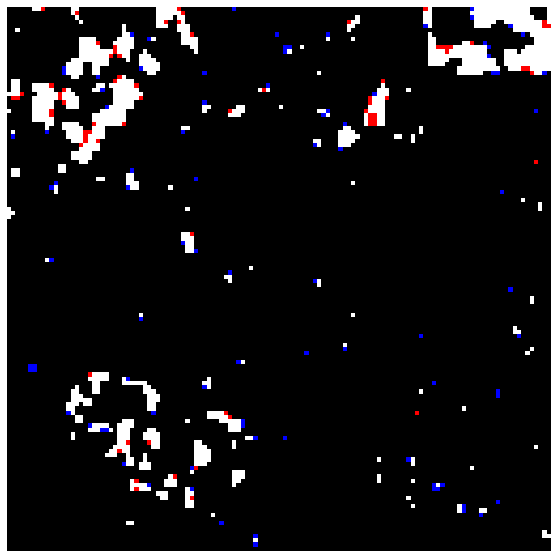

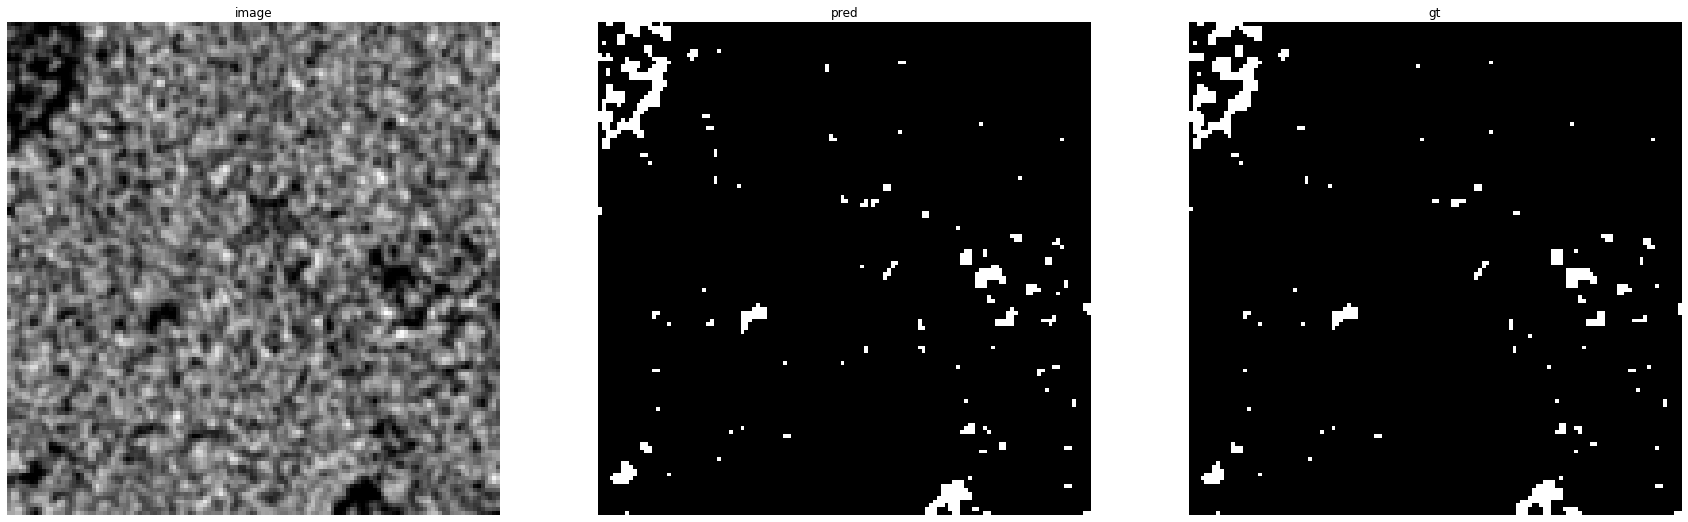

accuracy    : 0.99359130859375
precision   : 0.8797127468581688
recall      : 0.928030303030303
f1          : 0.9032258064516129
pr_auc      : 0.9781125246739308
iou         : 0.8235294117647058


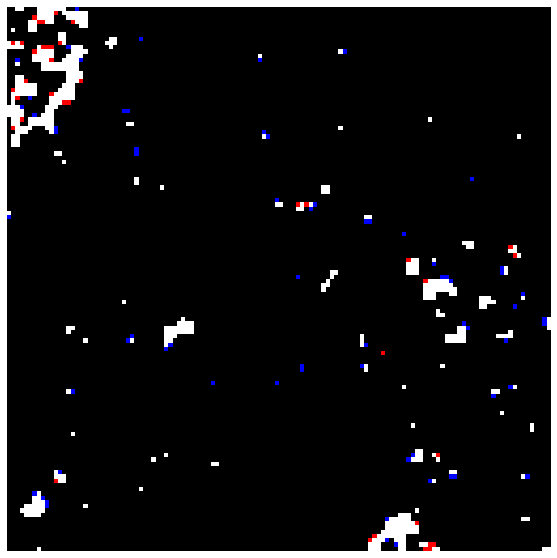

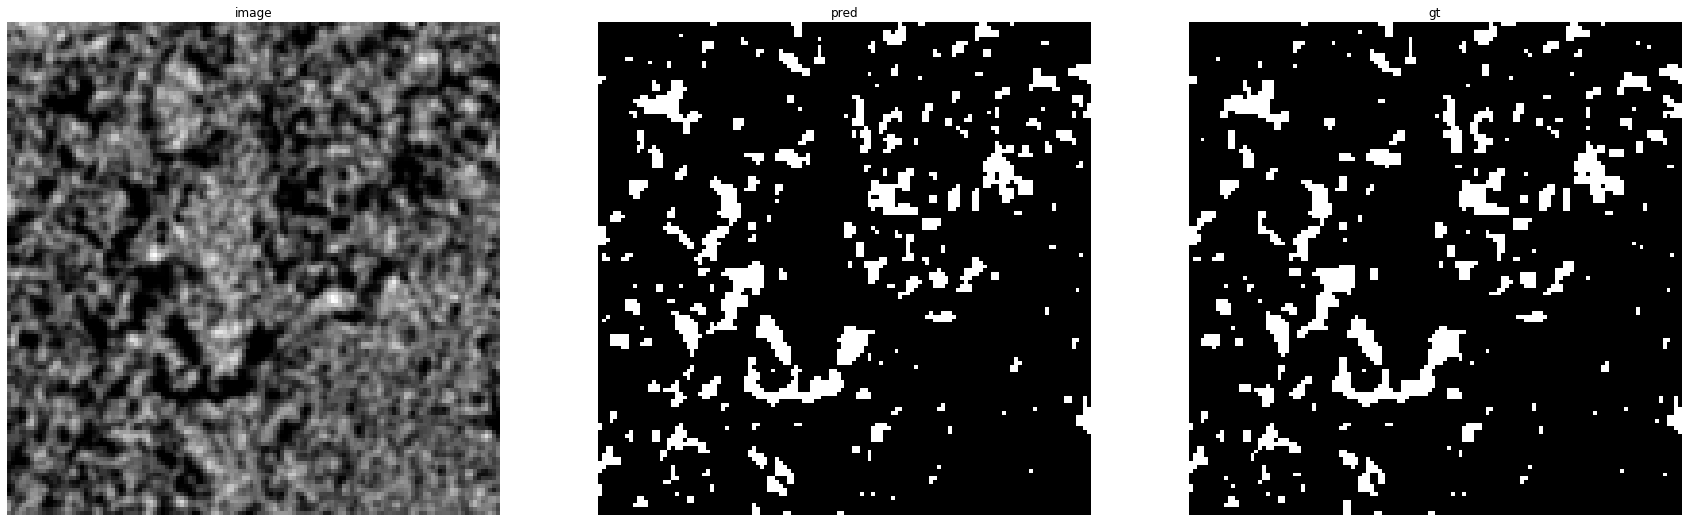

accuracy    : 0.98028564453125
precision   : 0.9058084772370487
recall      : 0.923692636072572
f1          : 0.9146631439894319
pr_auc      : 0.9802401749047713
iou         : 0.8427458617332035


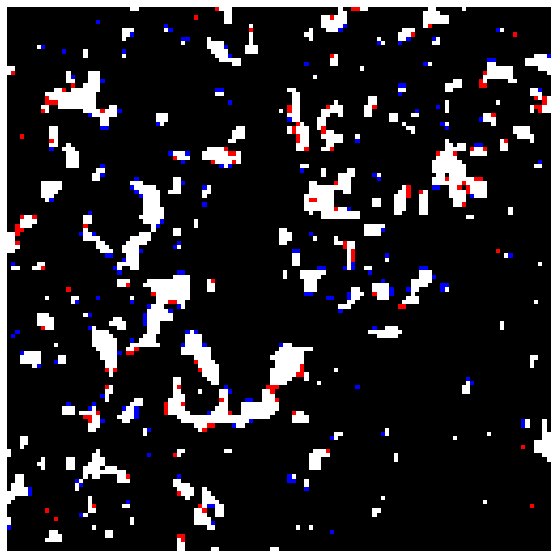

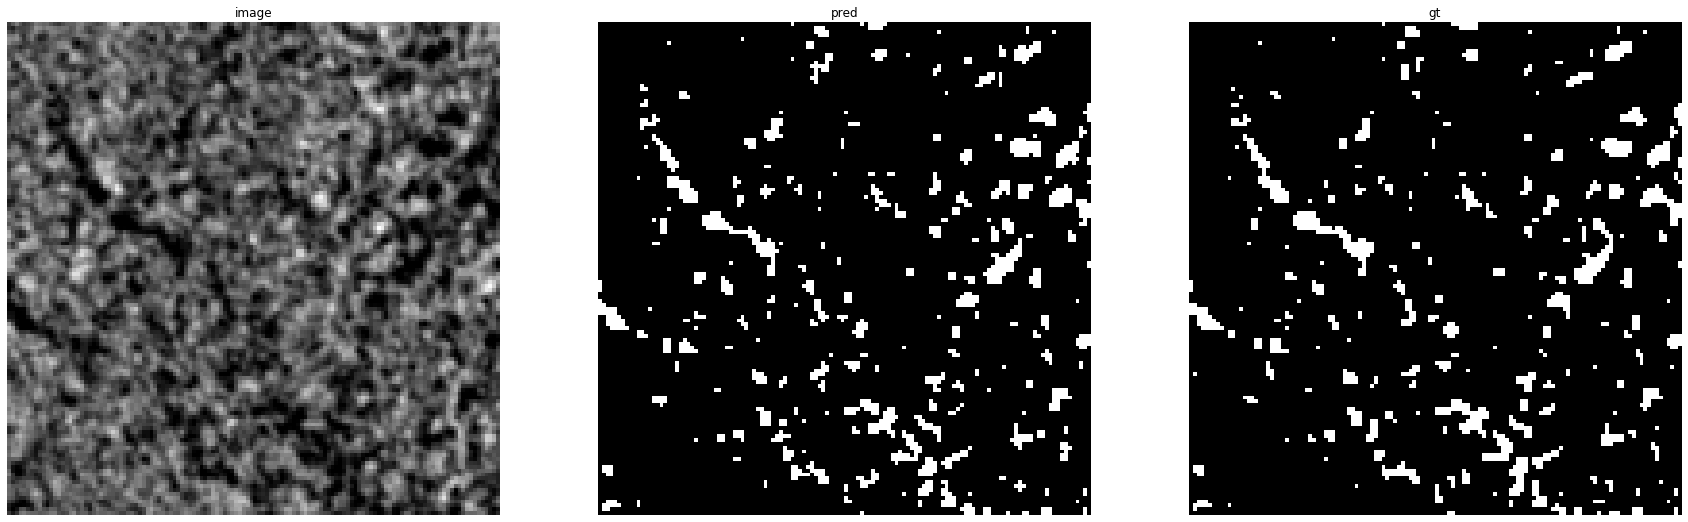

accuracy    : 0.9820556640625
precision   : 0.8851640513552068
recall      : 0.9032023289665211
f1          : 0.894092219020173
pr_auc      : 0.9695562225171312
iou         : 0.8084690553745928


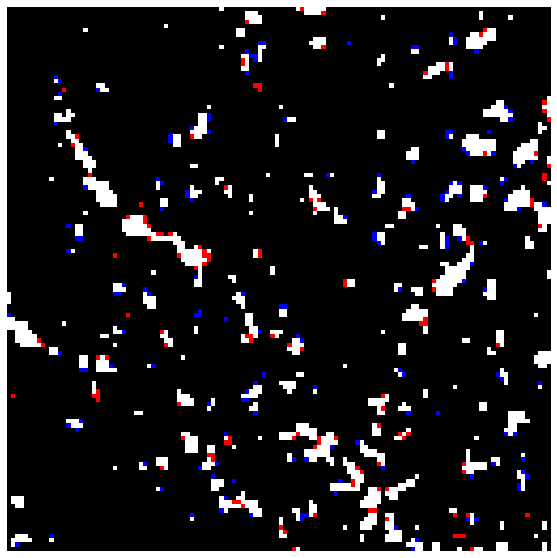

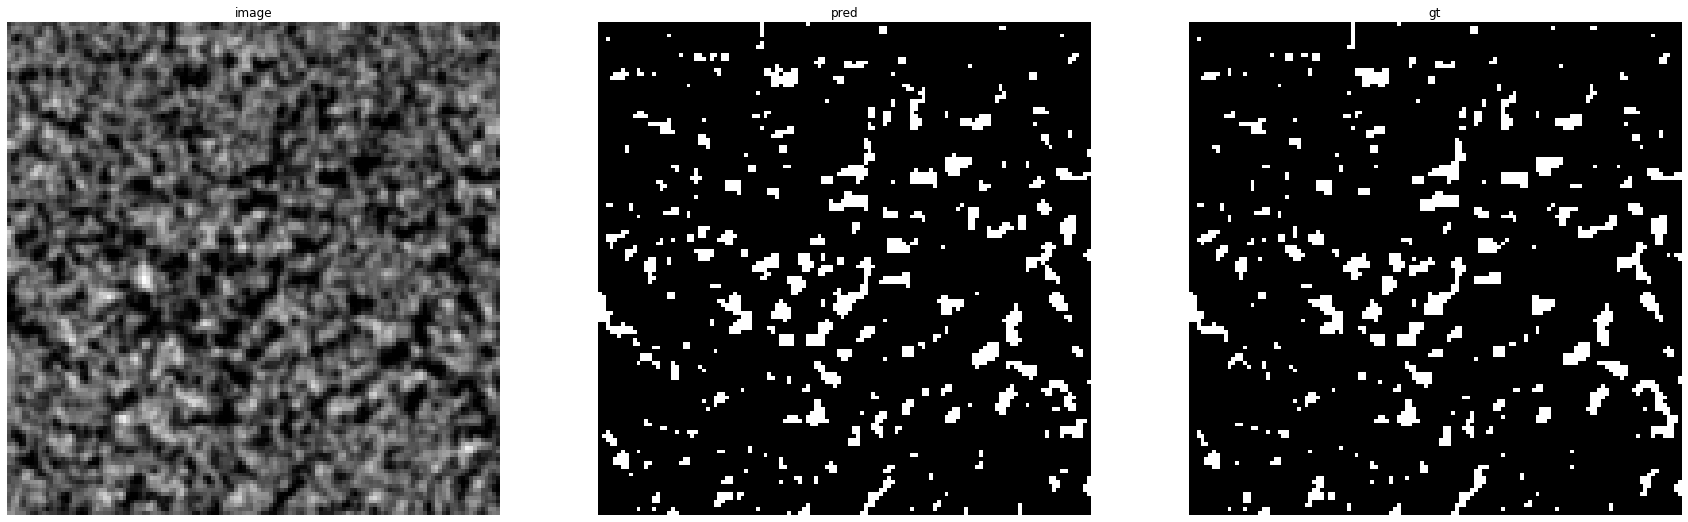

accuracy    : 0.9822998046875
precision   : 0.8853779429987608
recall      : 0.9315514993481095
f1          : 0.9078780177890725
pr_auc      : 0.976411608872083
iou         : 0.8312972658522396


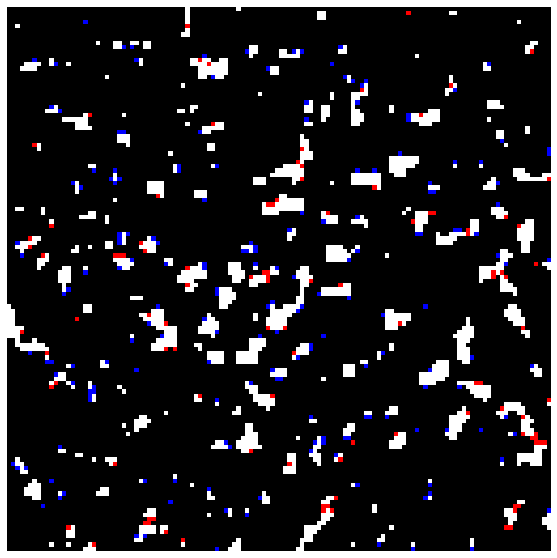

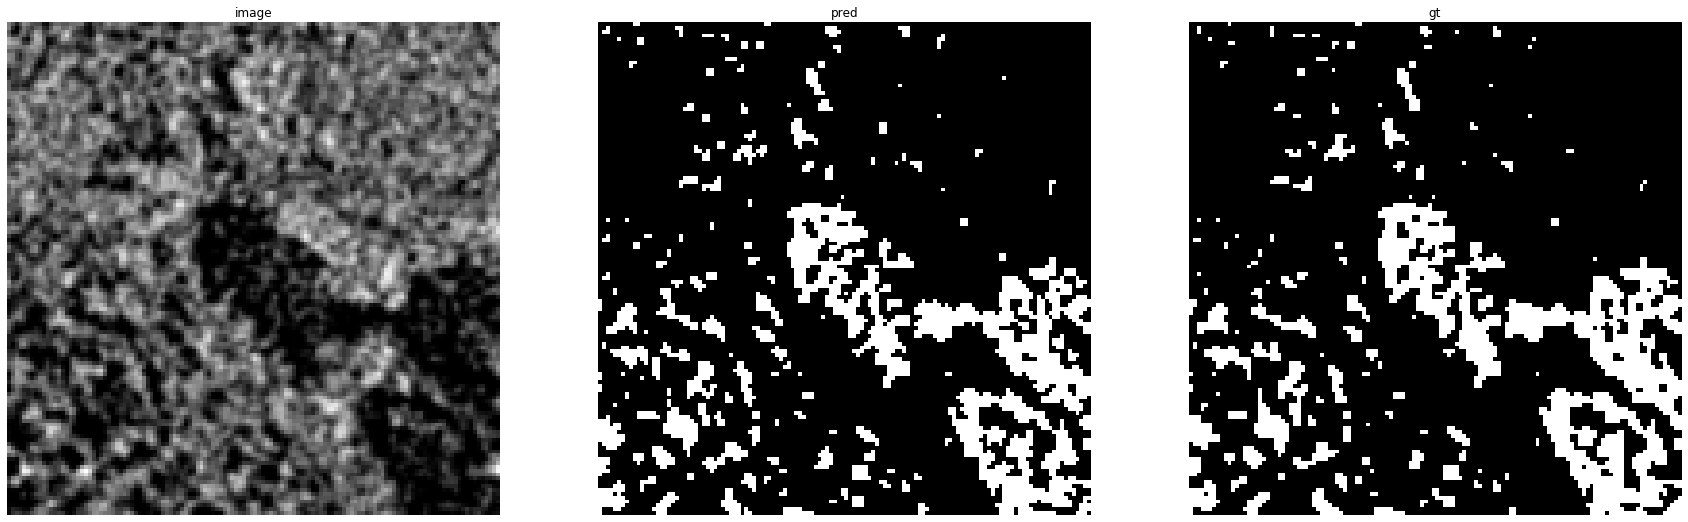

accuracy    : 0.9747314453125
precision   : 0.9380281690140845
recall      : 0.9179875947622329
f1          : 0.9278996865203761
pr_auc      : 0.9856714311836492
iou         : 0.8654970760233918


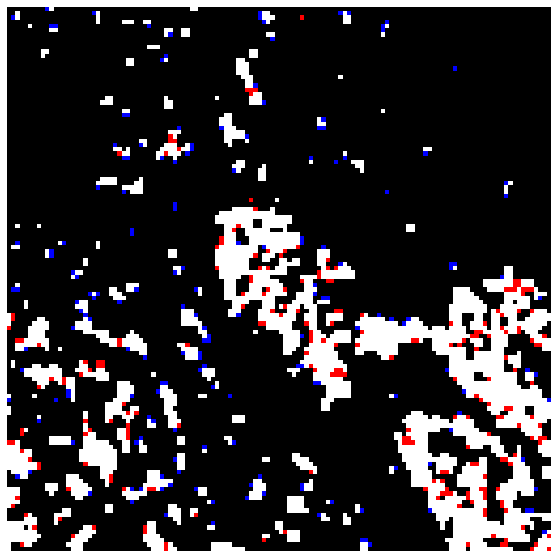

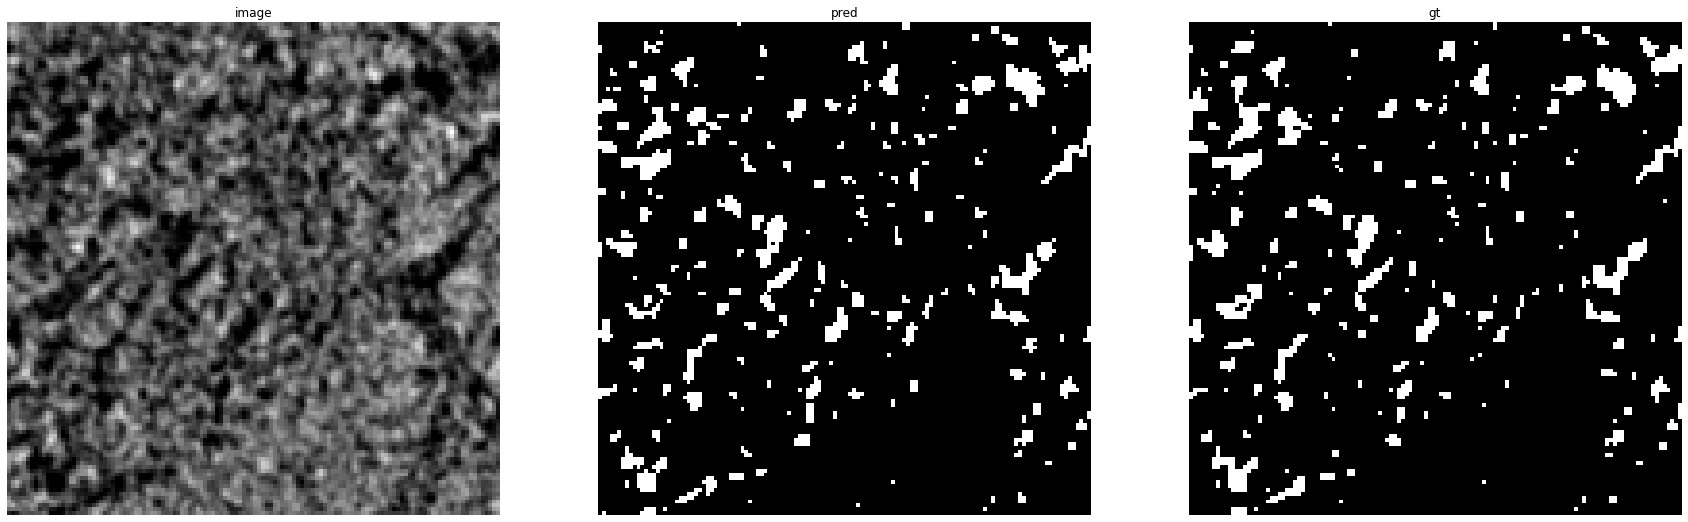

accuracy    : 0.9820556640625
precision   : 0.899736147757256
recall      : 0.9057104913678619
f1          : 0.9027134348113831
pr_auc      : 0.9723871404166571
iou         : 0.8226779252110977


Prediction for SPE_carb10_58_box3:


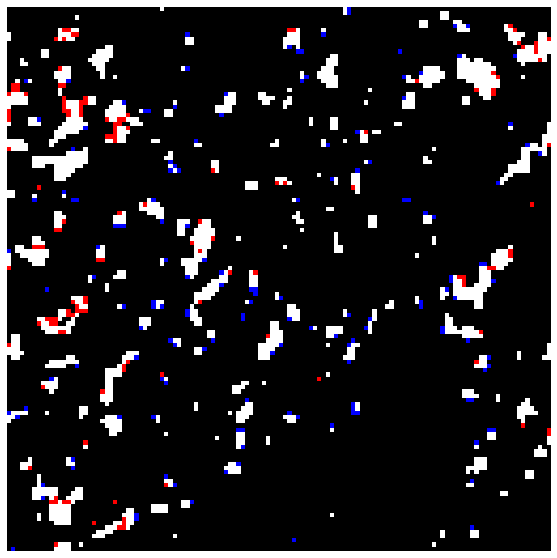

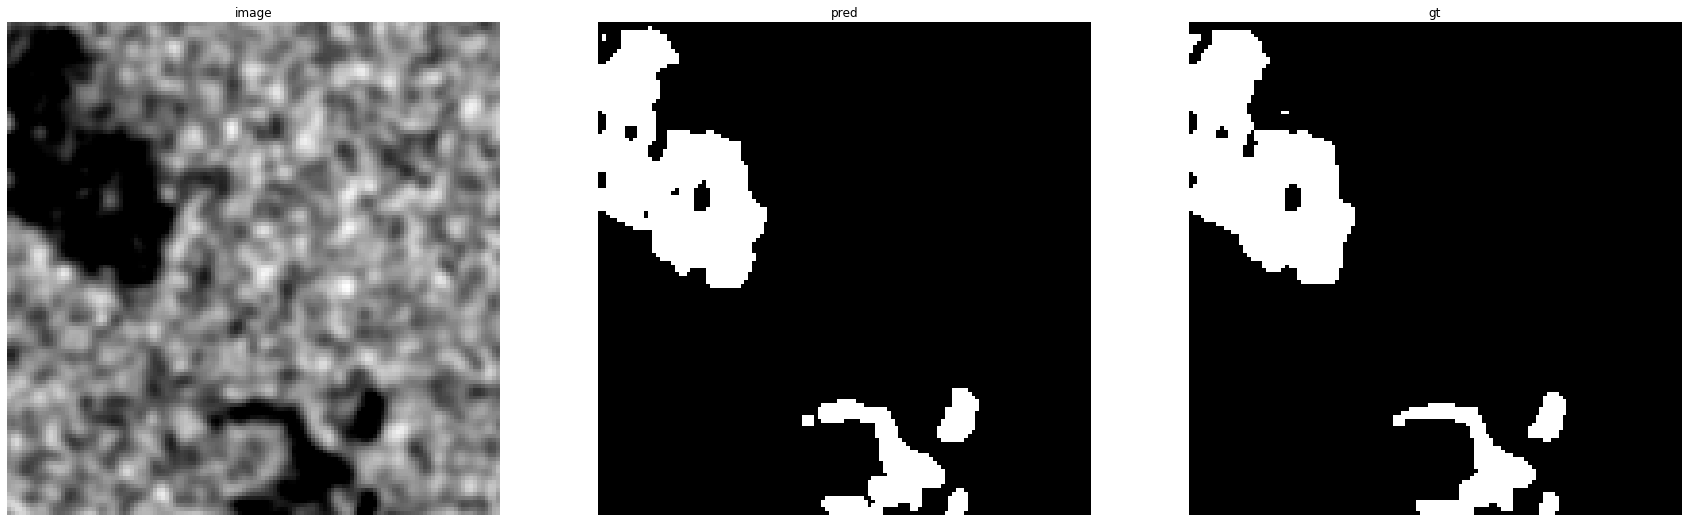

accuracy    : 0.988037109375
precision   : 0.9501154734411086
recall      : 0.958974358974359
f1          : 0.9545243619489561
pr_auc      : 0.9950093574313014
iou         : 0.9130048823790502


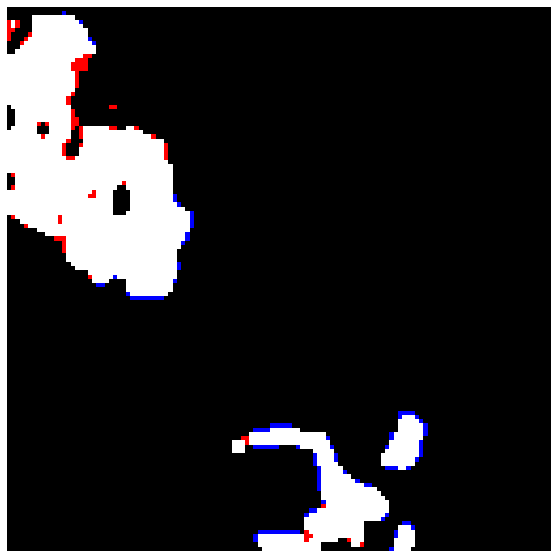

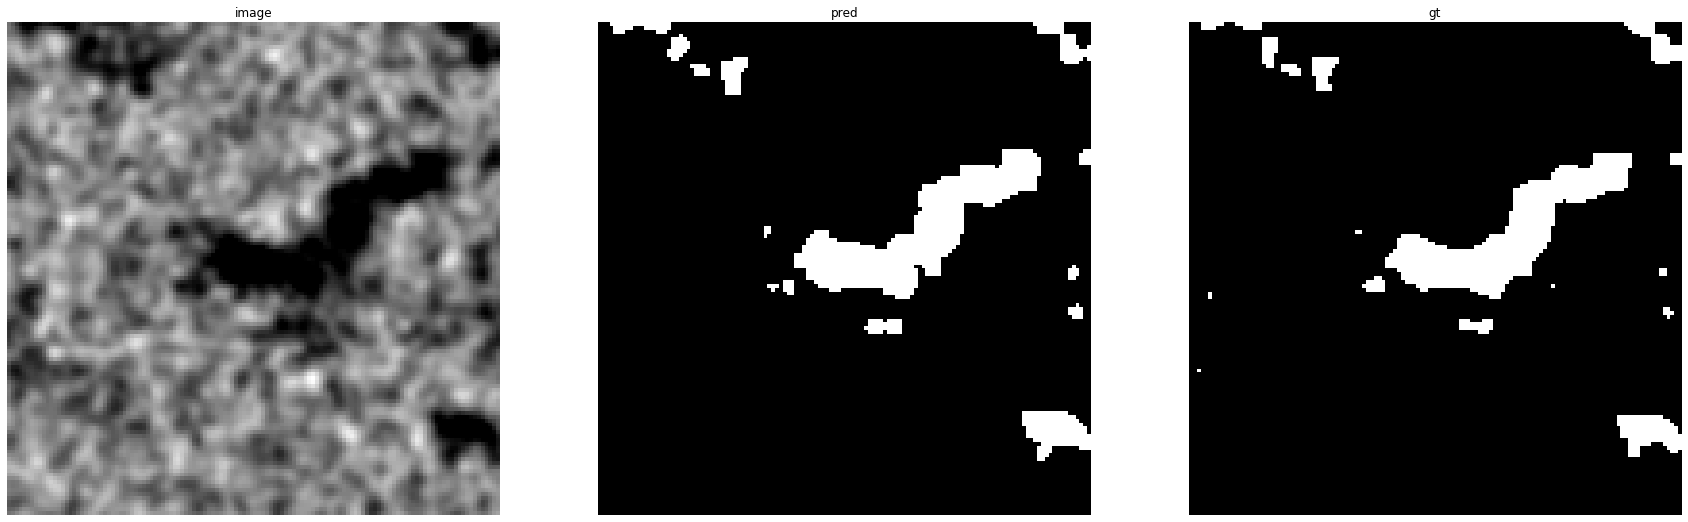

accuracy    : 0.98797607421875
precision   : 0.8826254826254826
recall      : 0.9621212121212122
f1          : 0.9206604913411196
pr_auc      : 0.9893803555837294
iou         : 0.8529850746268657


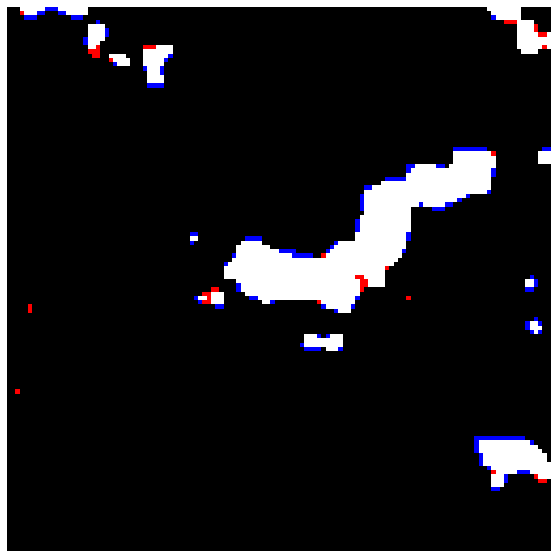

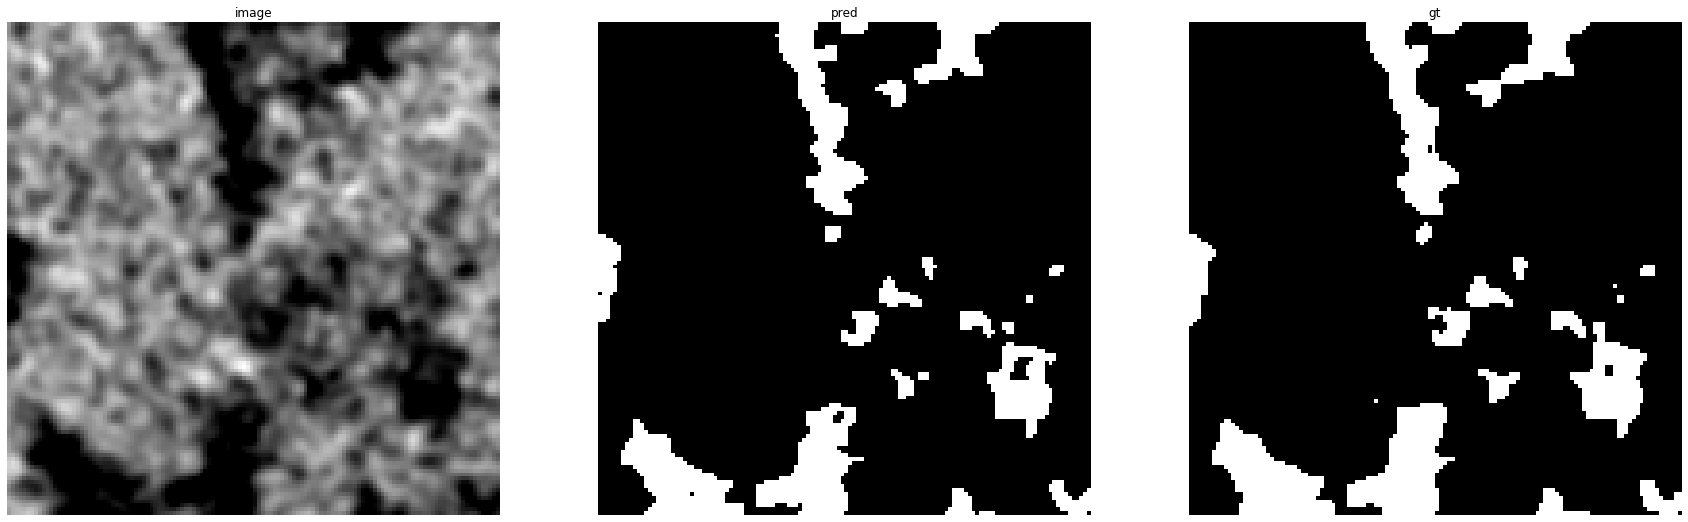

accuracy    : 0.98431396484375
precision   : 0.9967652495378928
recall      : 0.8961362692147902
f1          : 0.9437759789980311
pr_auc      : 0.9941427600628557
iou         : 0.8935376967688484


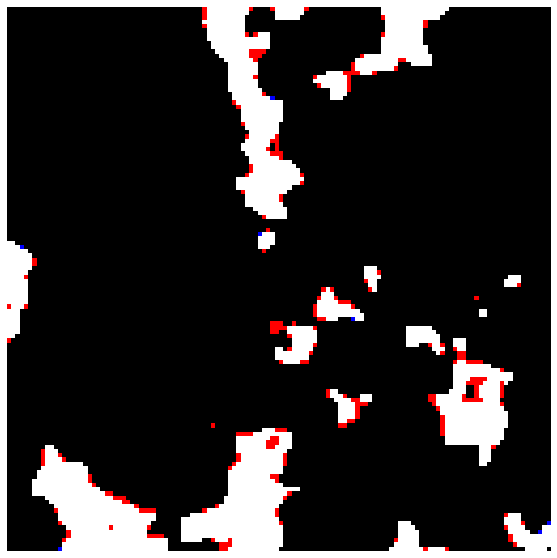

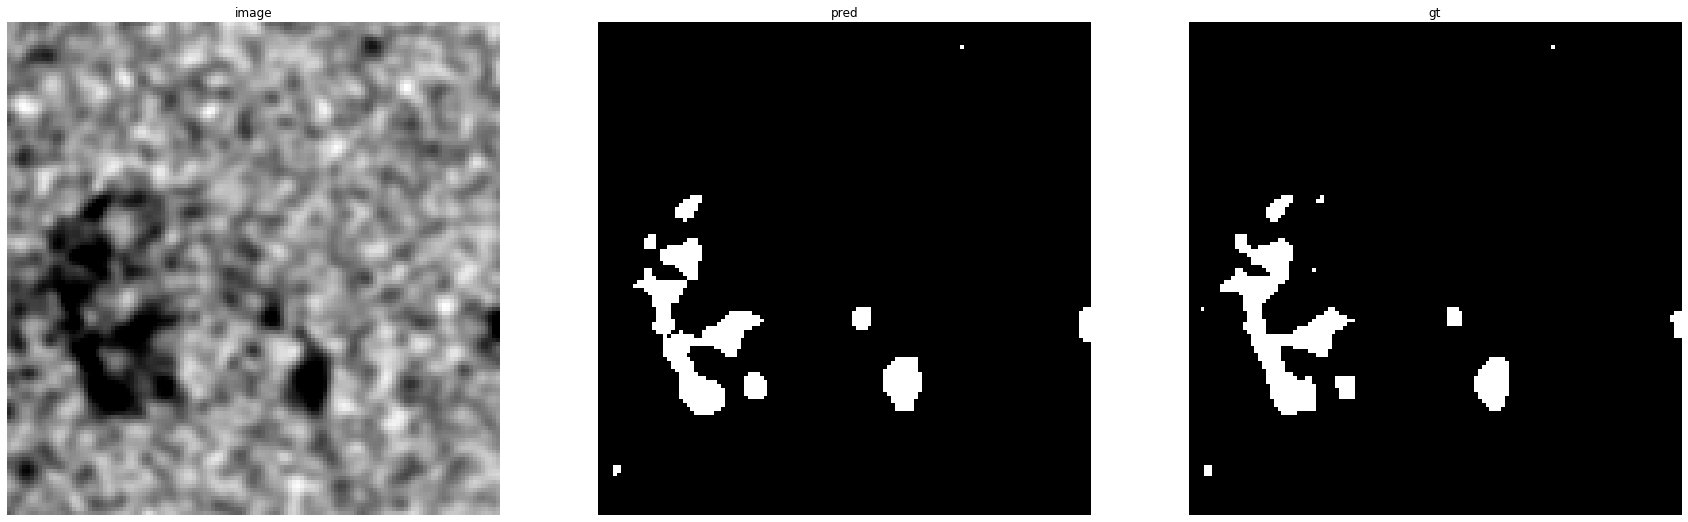

accuracy    : 0.9927978515625
precision   : 0.9249291784702549
recall      : 0.9094707520891365
f1          : 0.9171348314606741
pr_auc      : 0.9836251466198083
iou         : 0.8469520103761349


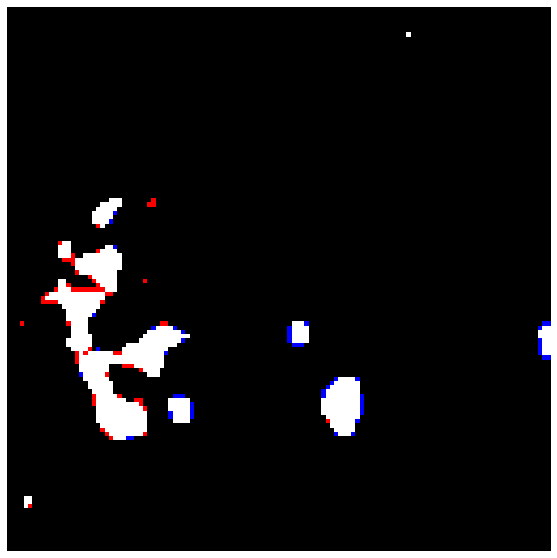

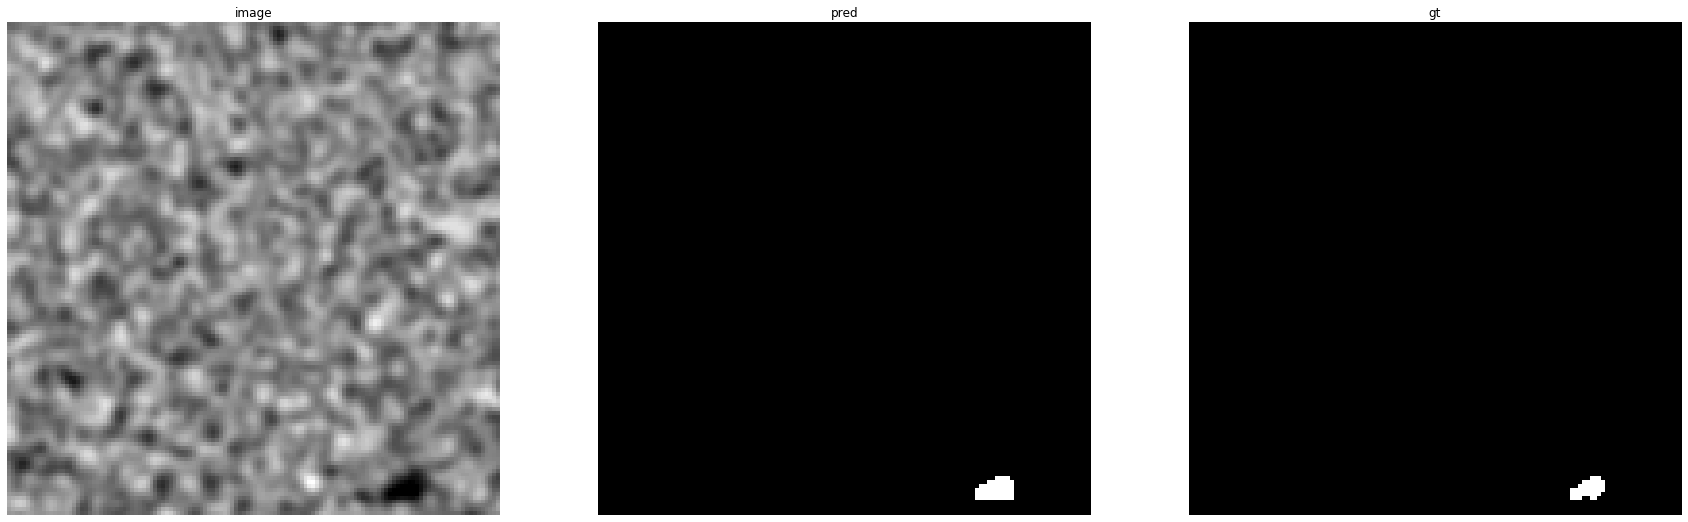

accuracy    : 0.999267578125
precision   : 0.76
recall      : 1.0
f1          : 0.8636363636363636
pr_auc      : 0.9806862611894921
iou         : 0.76


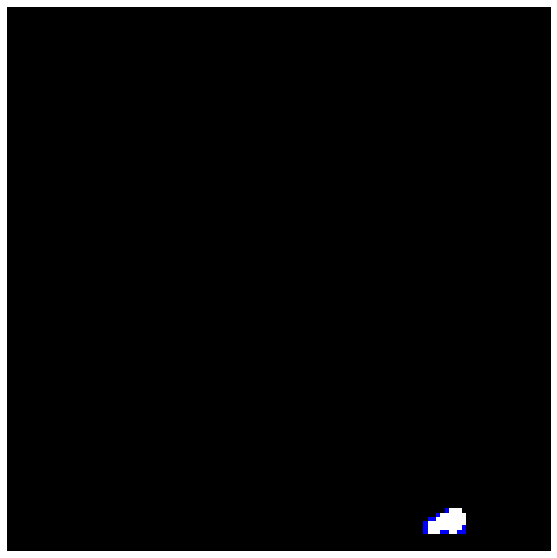

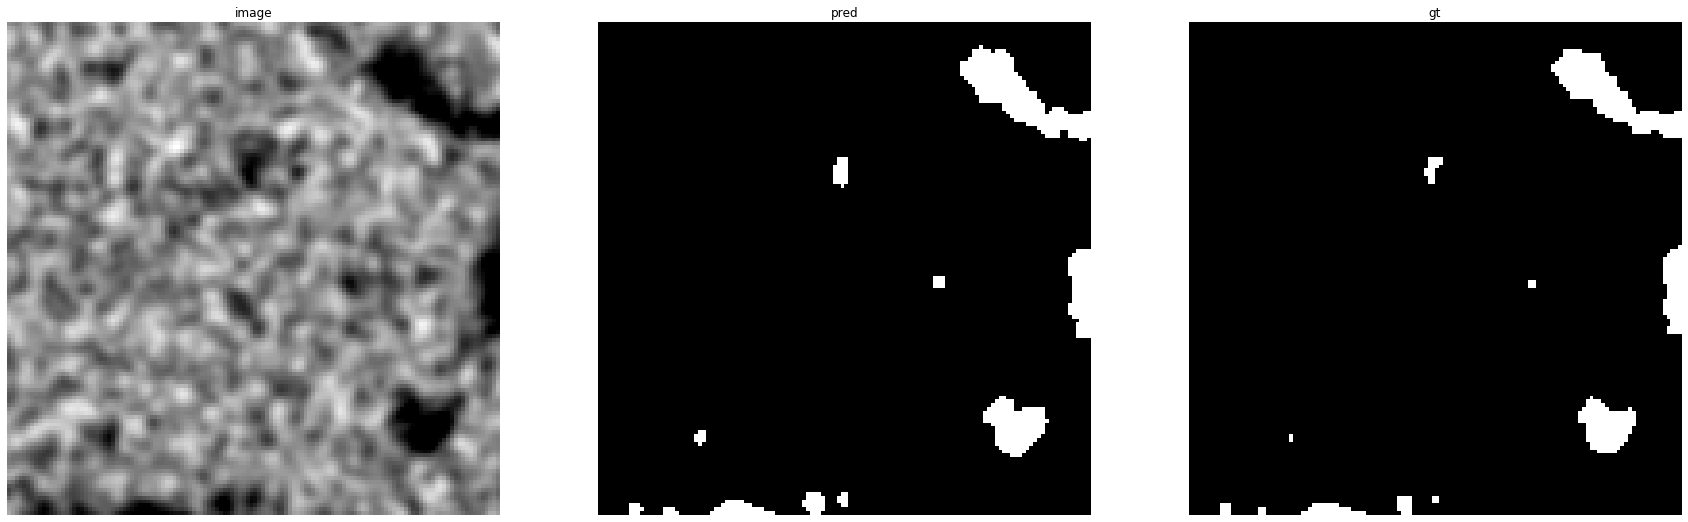

accuracy    : 0.99212646484375
precision   : 0.8357615894039735
recall      : 0.9921383647798742
f1          : 0.9072609633357297
pr_auc      : 0.9928296198903286
iou         : 0.8302631578947368


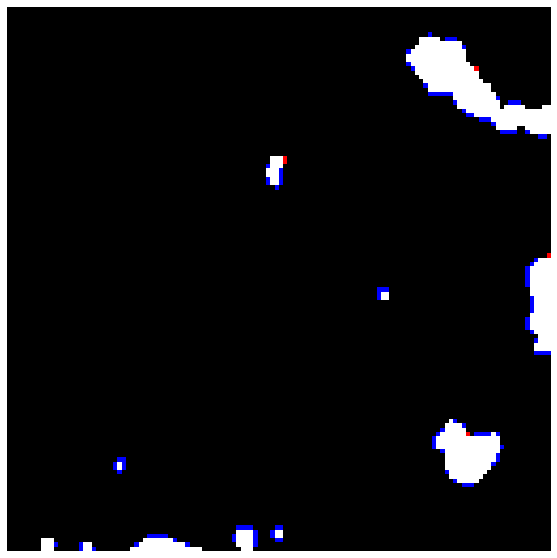

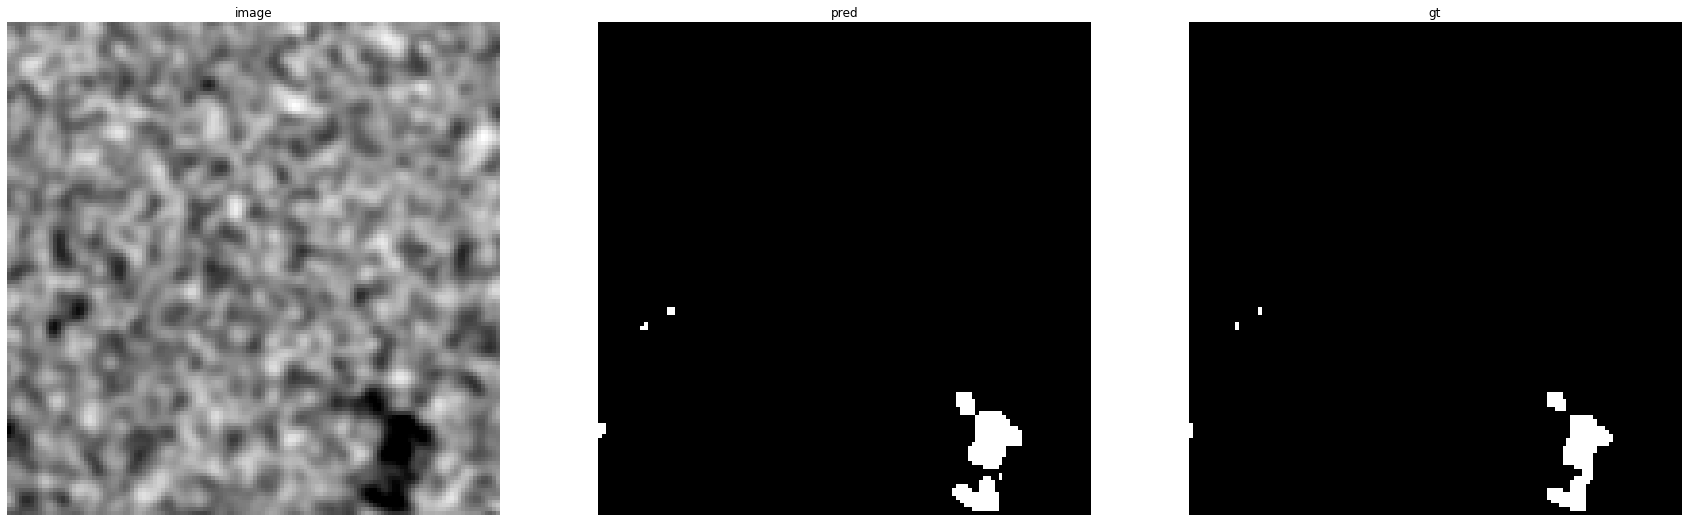

accuracy    : 0.99652099609375
precision   : 0.8125
recall      : 0.9585253456221198
f1          : 0.8794926004228331
pr_auc      : 0.9768112897242696
iou         : 0.7849056603773585


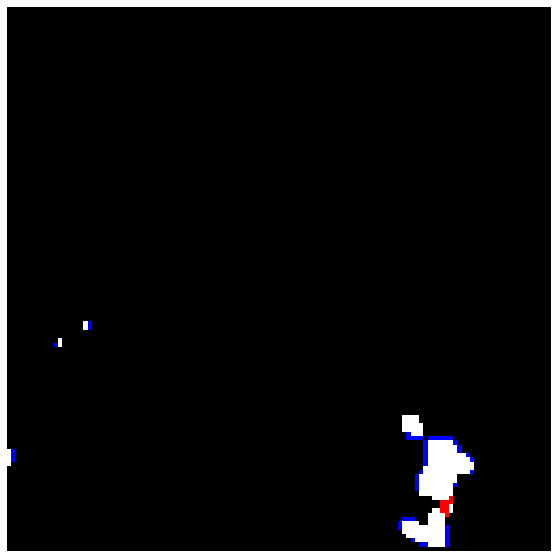

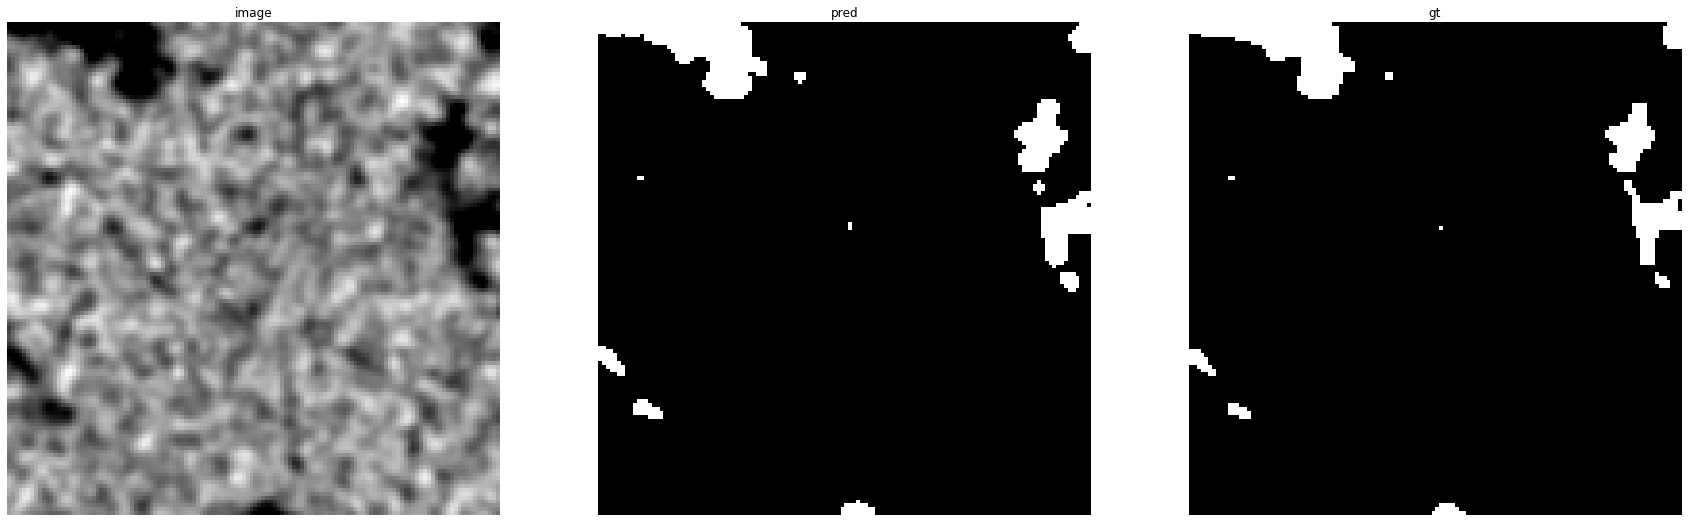

accuracy    : 0.9915771484375
precision   : 0.8645948945615982
recall      : 0.979874213836478
f1          : 0.9186320754716981
pr_auc      : 0.9899238611540383
iou         : 0.8495092693565977


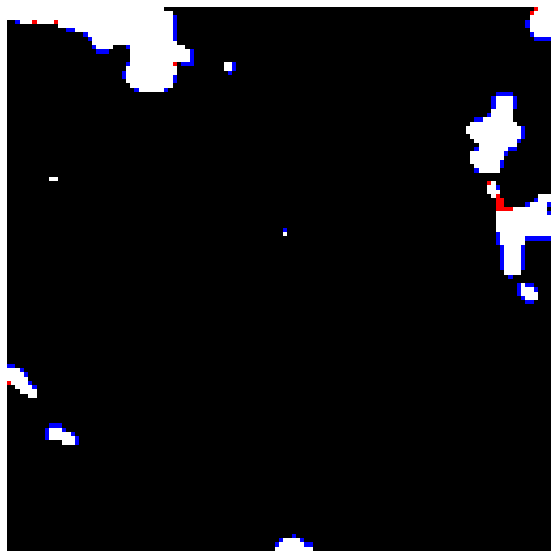

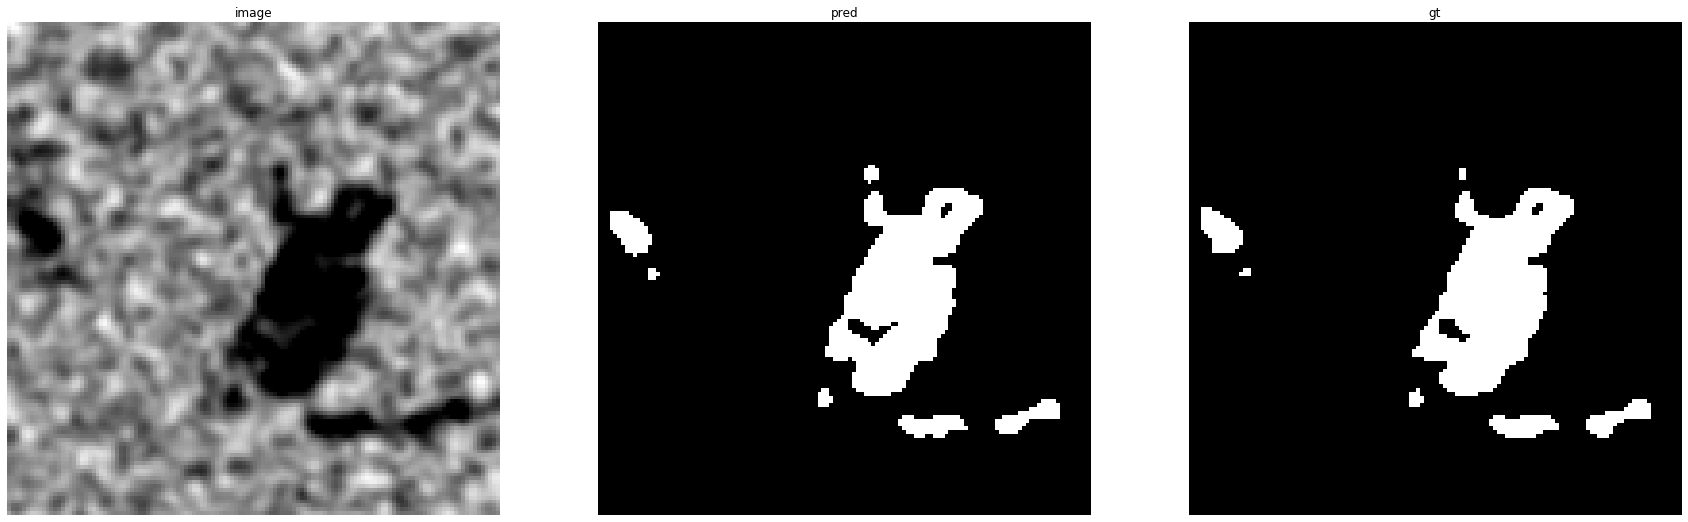

accuracy    : 0.99383544921875
precision   : 0.9665757162346521
recall      : 0.9646017699115044
f1          : 0.9655877342419079
pr_auc      : 0.9967182835599944
iou         : 0.9334650856389987


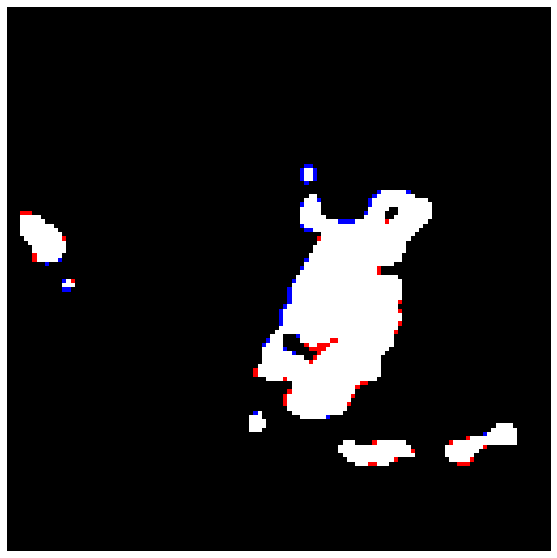

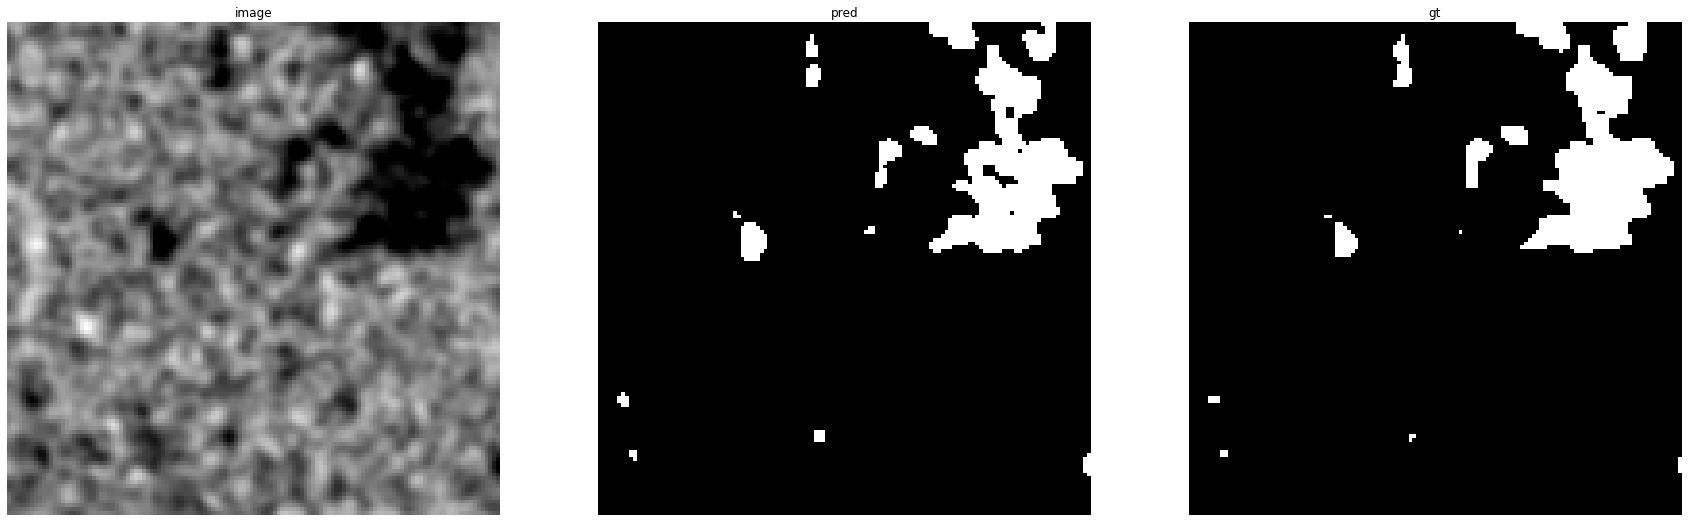

accuracy    : 0.990478515625
precision   : 0.9637389202256245
recall      : 0.9150726855394032
f1          : 0.9387755102040816
pr_auc      : 0.9898890079257723
iou         : 0.8846153846153846


Prediction for SoilAh-1:


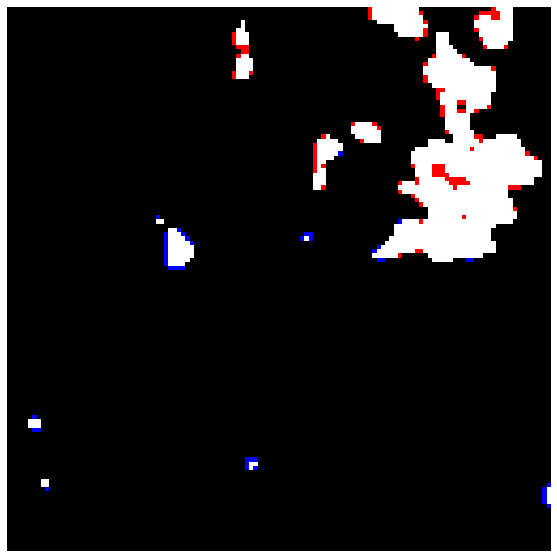

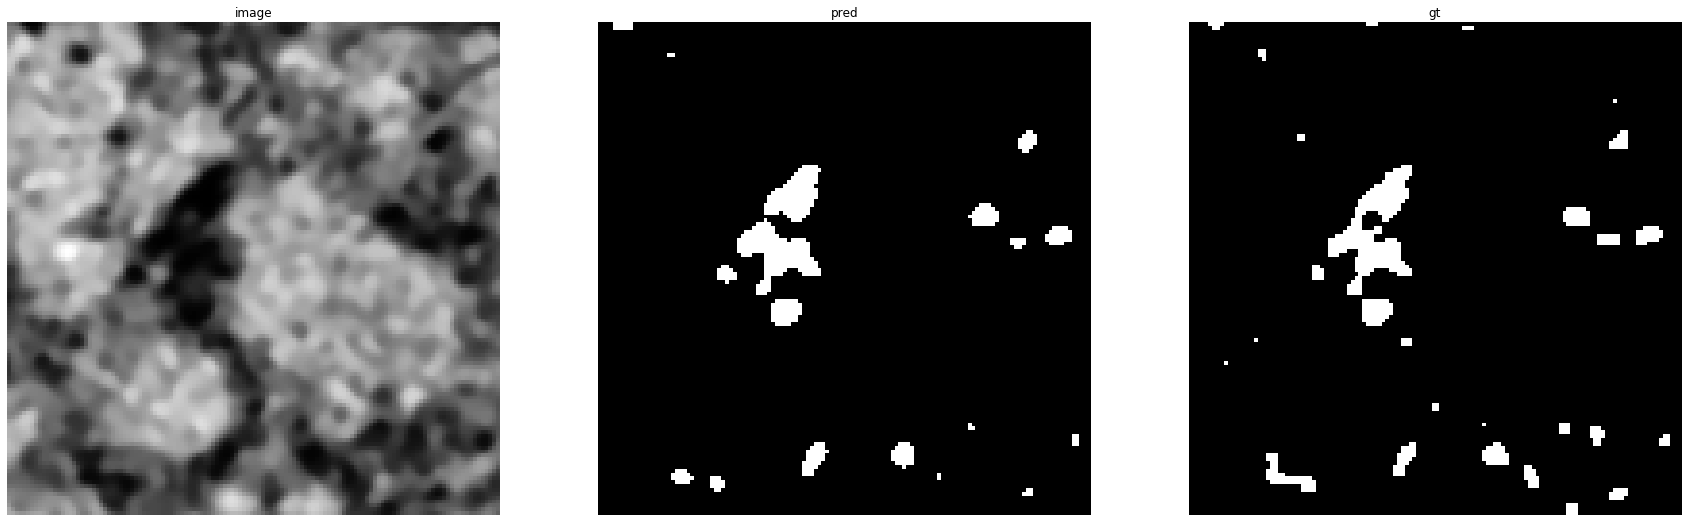

accuracy    : 0.98699951171875
precision   : 0.8802588996763754
recall      : 0.7964860907759883
f1          : 0.8362797847809377
pr_auc      : 0.9310363072680998
iou         : 0.7186261558784677


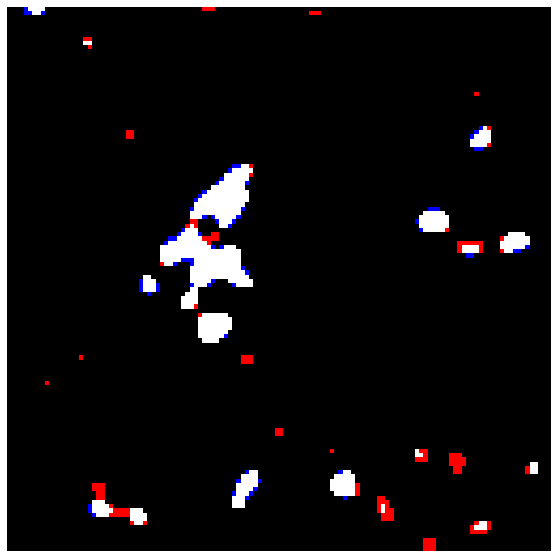

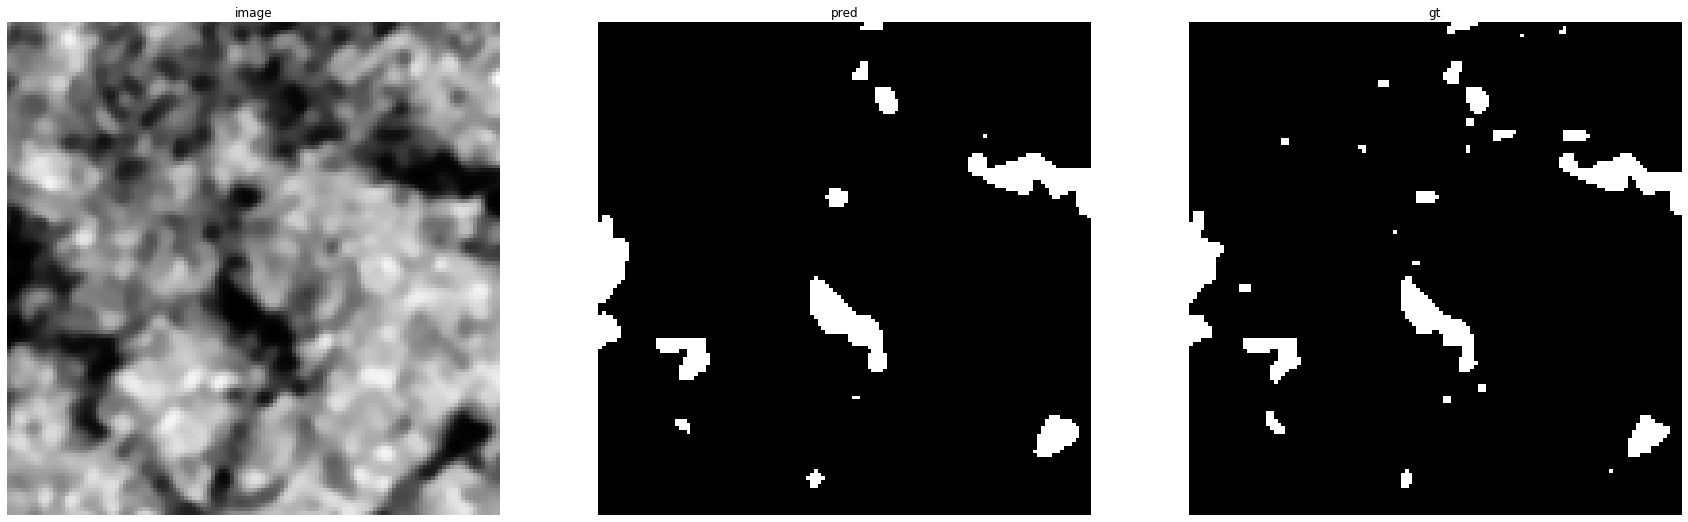

accuracy    : 0.98626708984375
precision   : 0.8687982359426681
recall      : 0.8814317673378076
f1          : 0.8750694058856191
pr_auc      : 0.9566441828353274
iou         : 0.7778874629812438


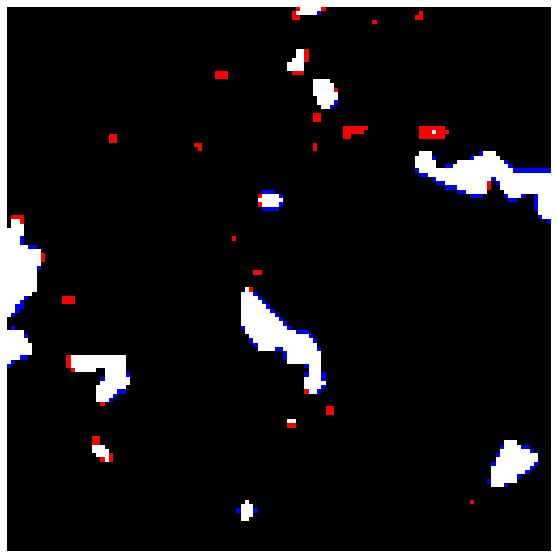

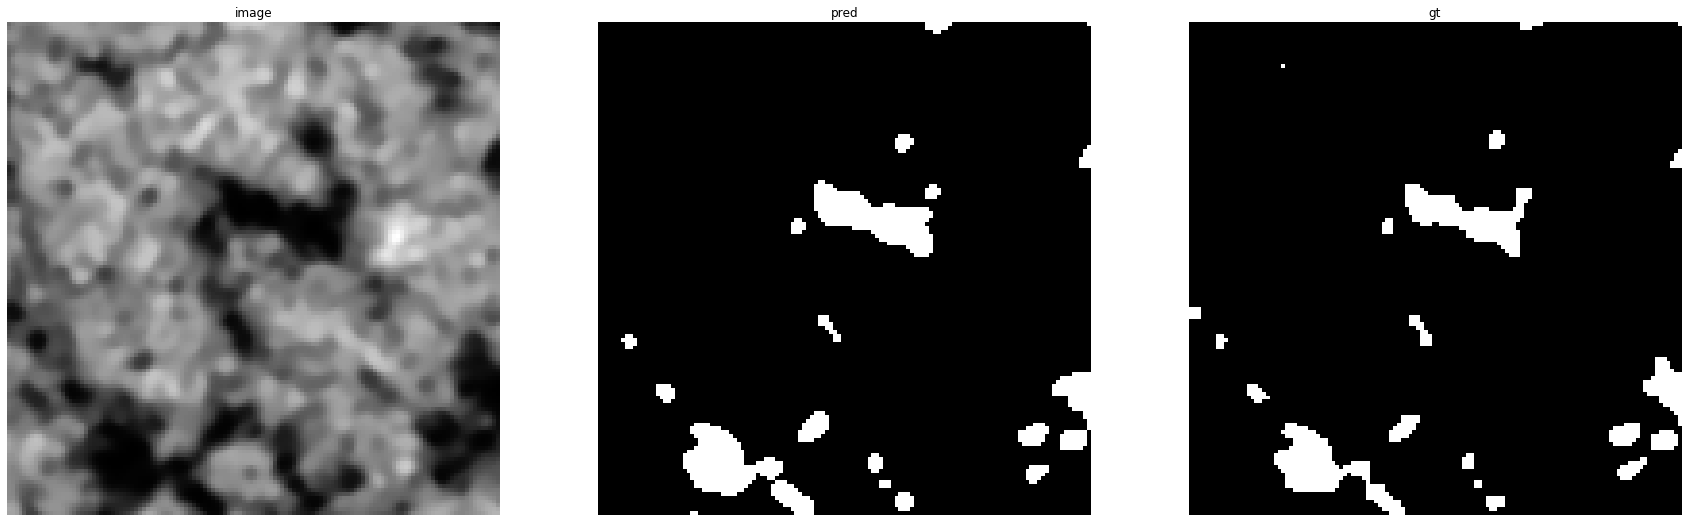

accuracy    : 0.98724365234375
precision   : 0.8532555879494655
recall      : 0.938034188034188
f1          : 0.8936386768447836
pr_auc      : 0.9739332326304175
iou         : 0.8077276908923643


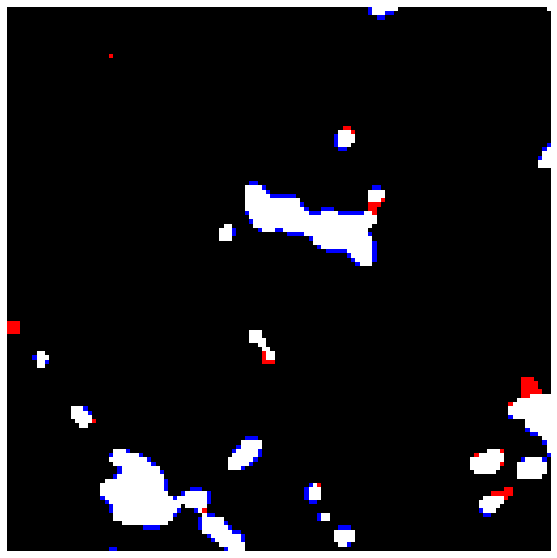

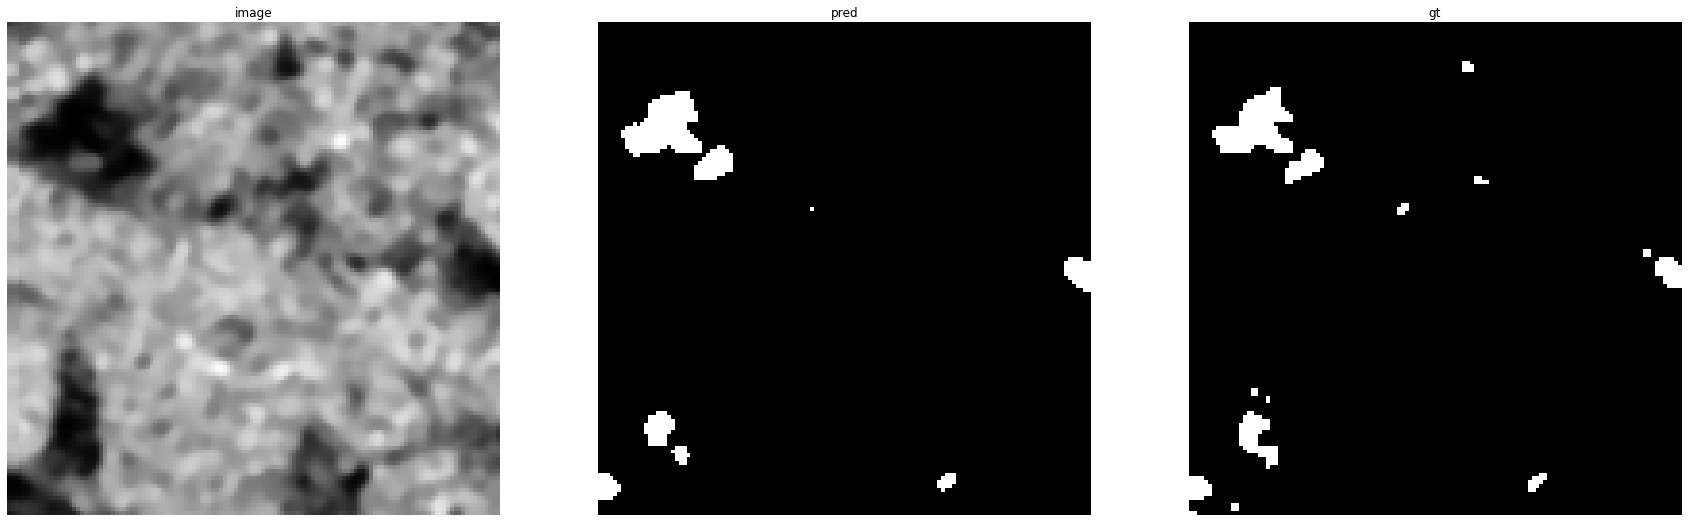

accuracy    : 0.9931640625
precision   : 0.8920086393088553
recall      : 0.8694736842105263
f1          : 0.8805970149253732
pr_auc      : 0.961277025891375
iou         : 0.7866666666666666


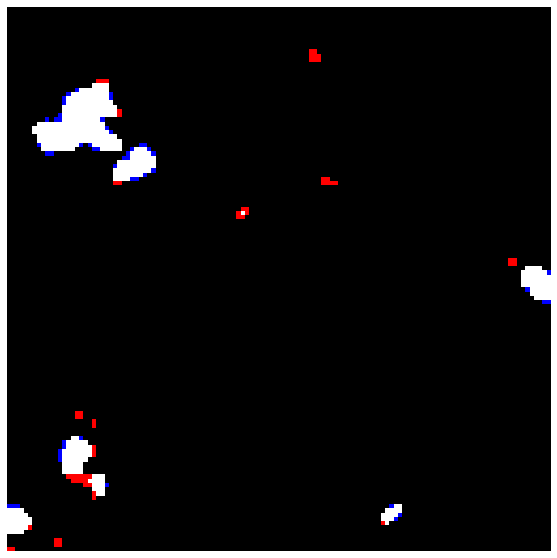

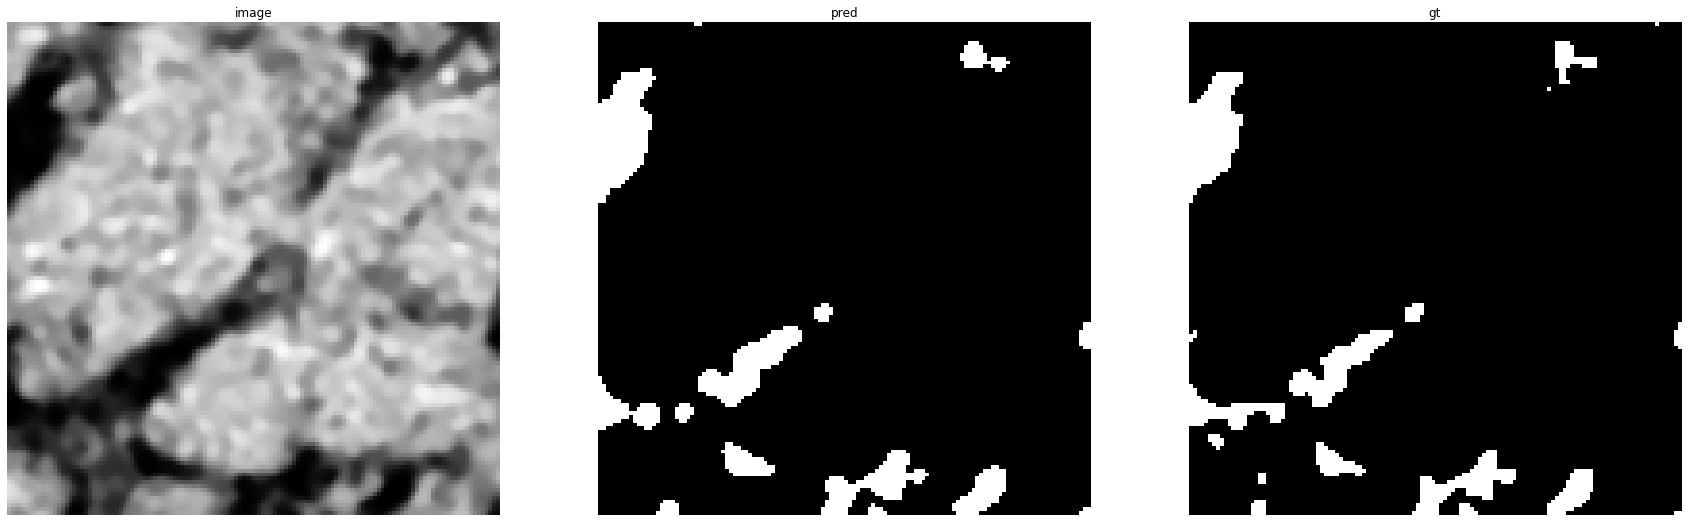

accuracy    : 0.98626708984375
precision   : 0.8656591099916037
recall      : 0.9406934306569343
f1          : 0.9016178399650198
pr_auc      : 0.9794693015526673
iou         : 0.820859872611465


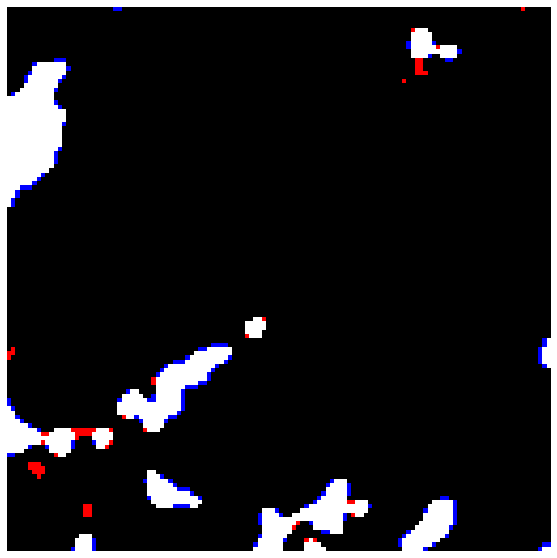

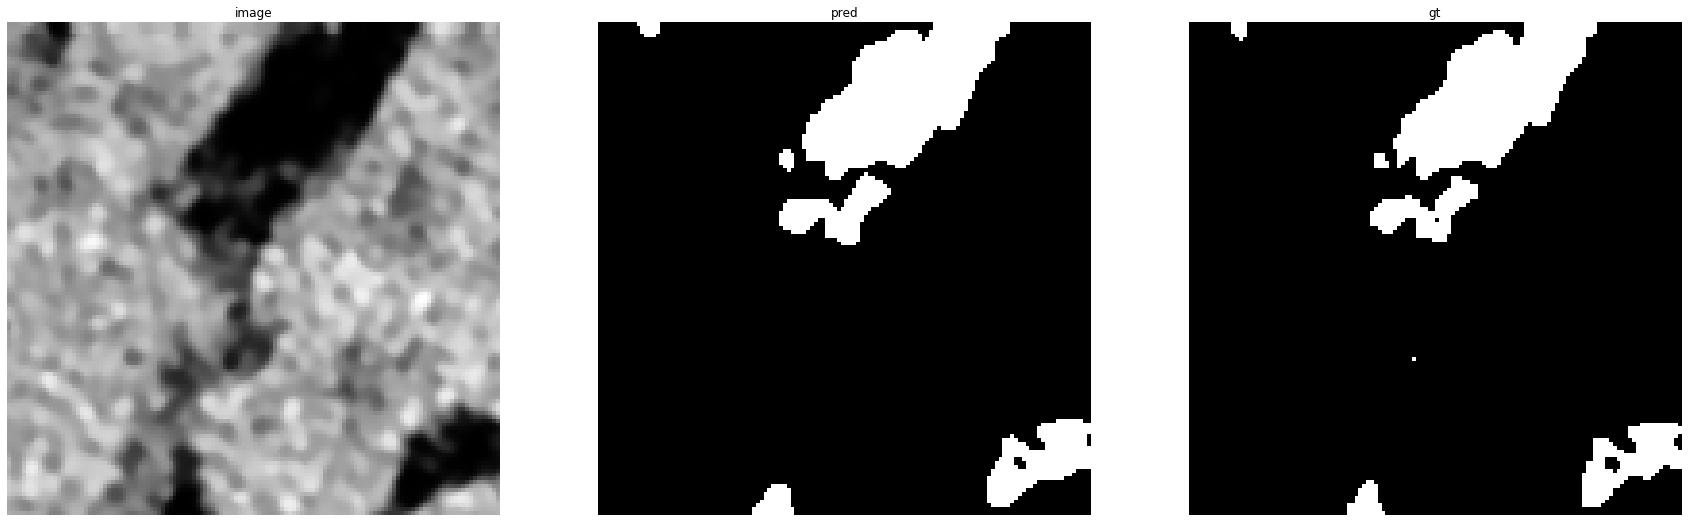

accuracy    : 0.98931884765625
precision   : 0.9154203197524498
recall      : 0.9938409854423292
f1          : 0.9530201342281879
pr_auc      : 0.997796403448369
iou         : 0.9102564102564102


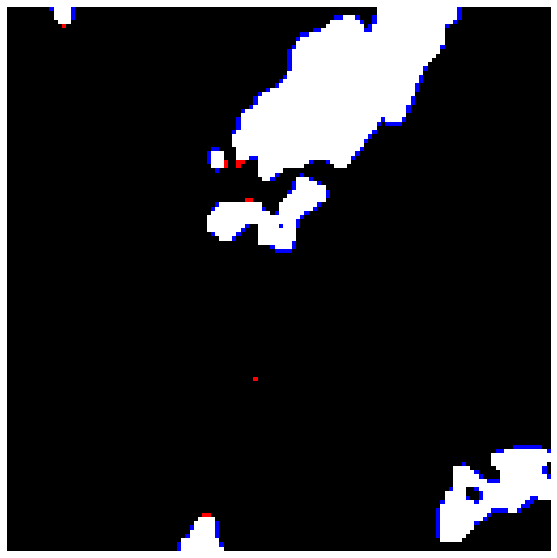

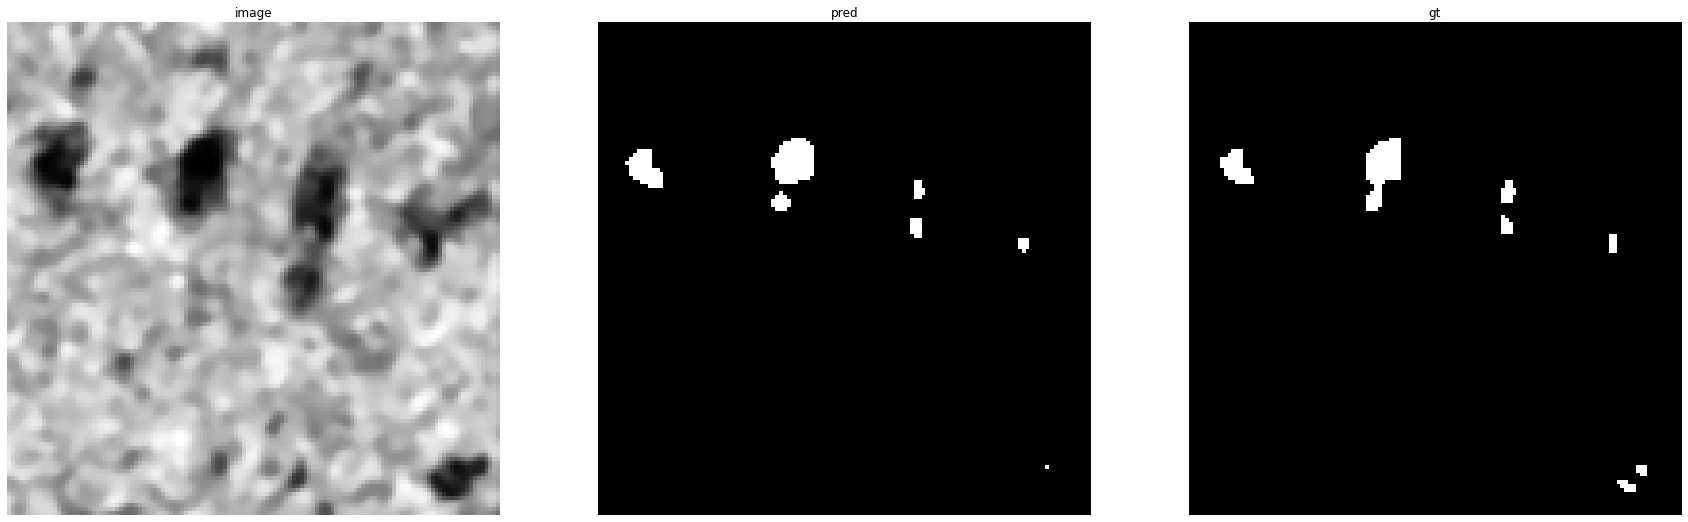

accuracy    : 0.99566650390625
precision   : 0.8385650224215246
recall      : 0.8423423423423423
f1          : 0.840449438202247
pr_auc      : 0.9444320582229982
iou         : 0.7248062015503876


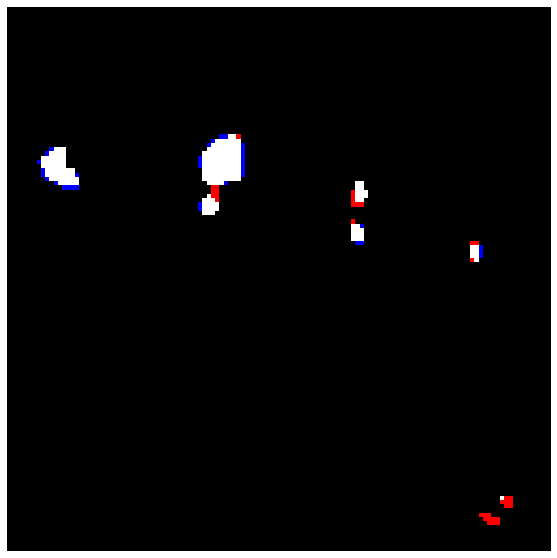

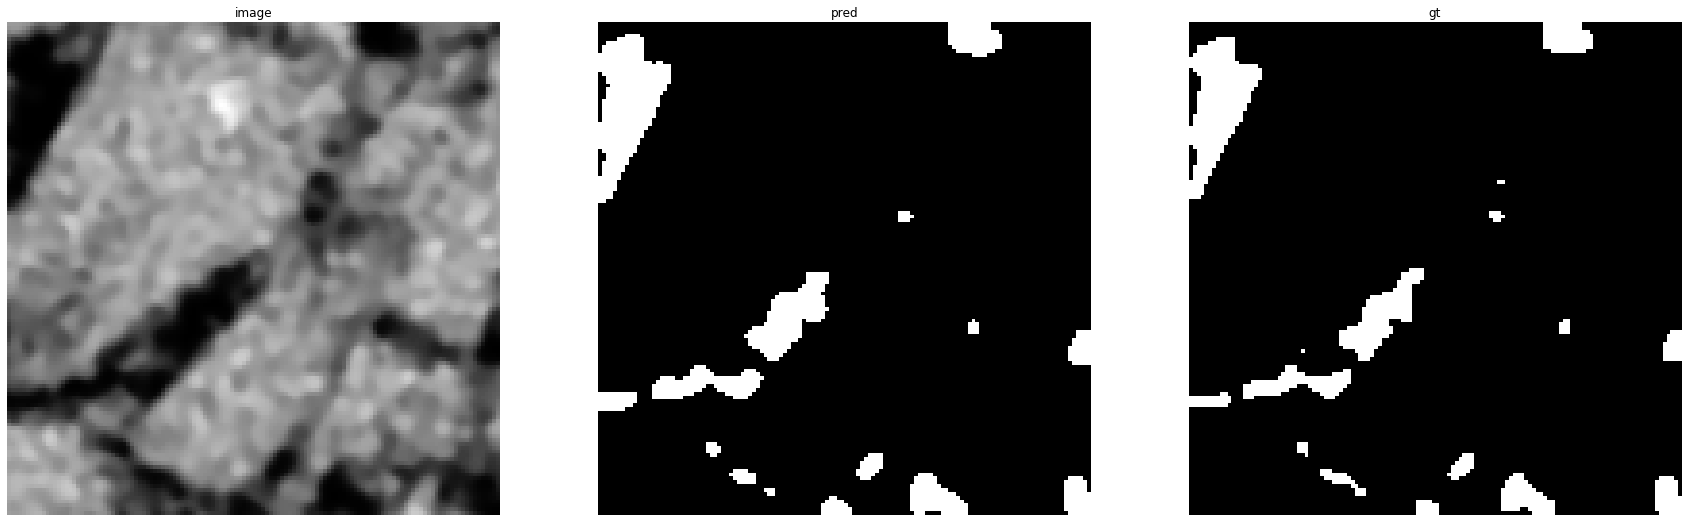

accuracy    : 0.9874267578125
precision   : 0.8650619985412108
recall      : 0.9826014913007457
f1          : 0.9200930954228083
pr_auc      : 0.991443590970062
iou         : 0.8520114942528736


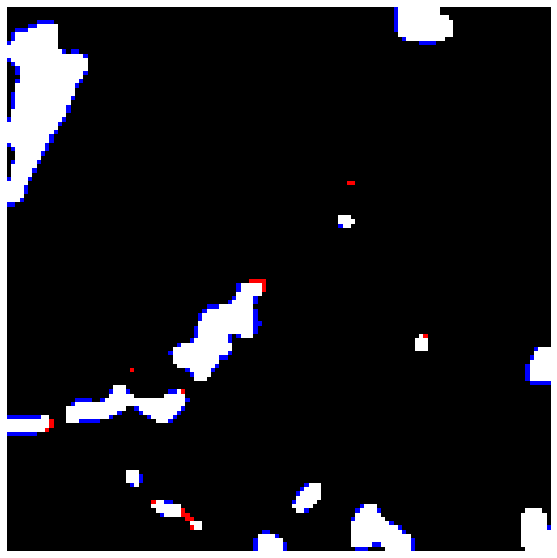

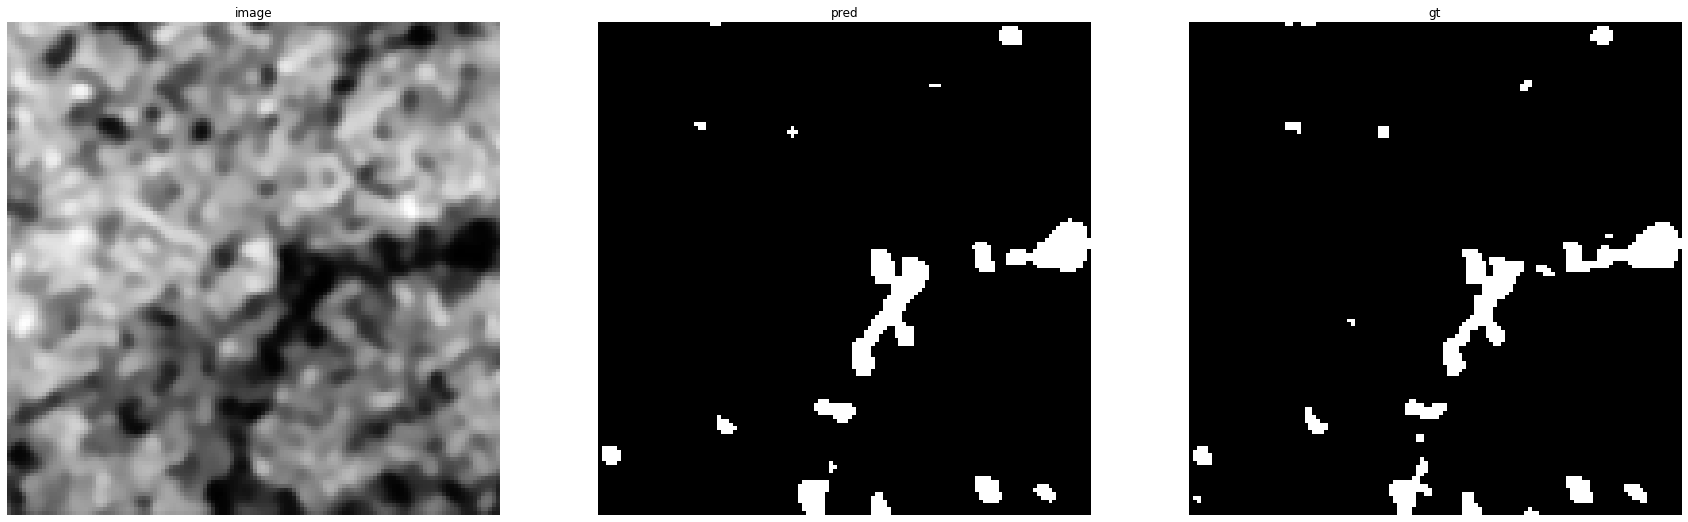

accuracy    : 0.990478515625
precision   : 0.9224489795918367
recall      : 0.8725868725868726
f1          : 0.8968253968253967
pr_auc      : 0.9639302082719443
iou         : 0.8129496402877698


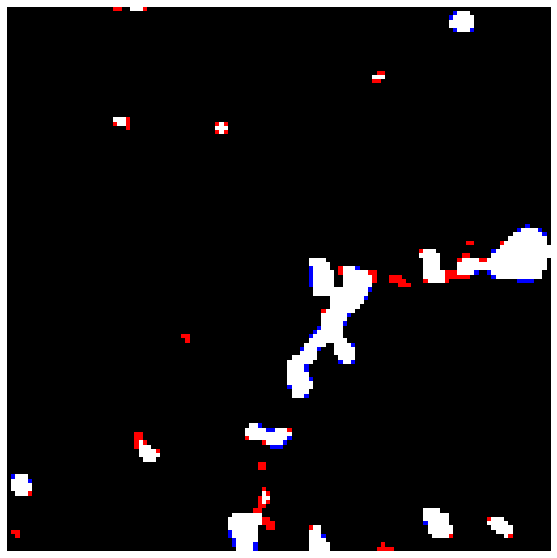

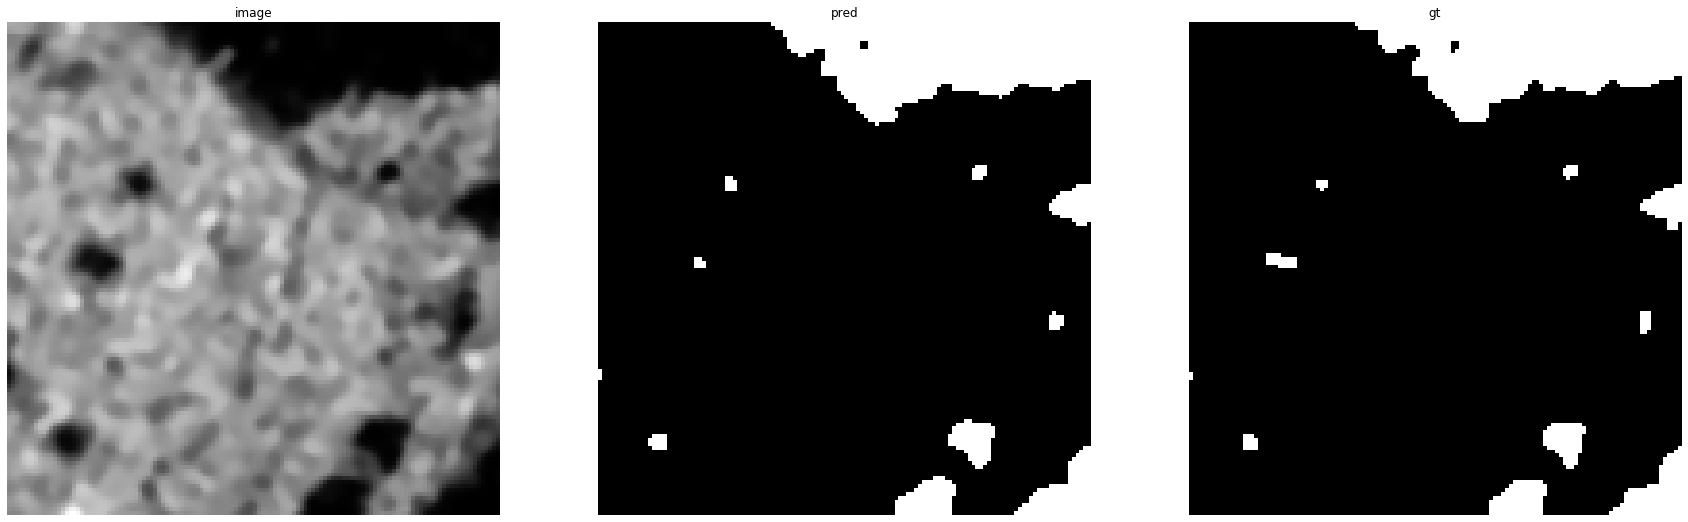

accuracy    : 0.9923095703125
precision   : 0.950383631713555
recall      : 0.9846316905140434
f1          : 0.9672045809474232
pr_auc      : 0.9972805191337405
iou         : 0.936491935483871


Prediction for SoilB-2:


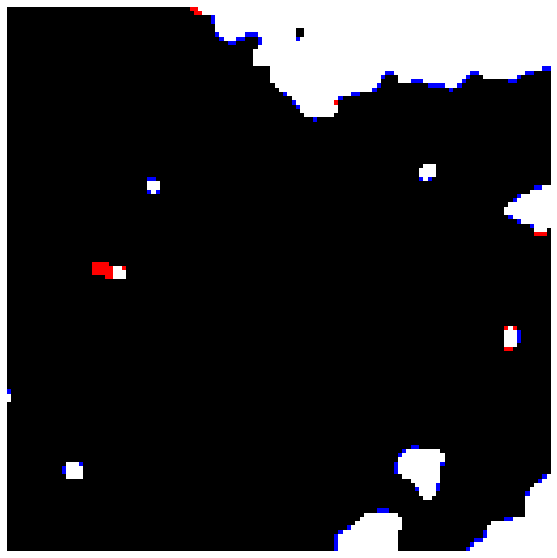

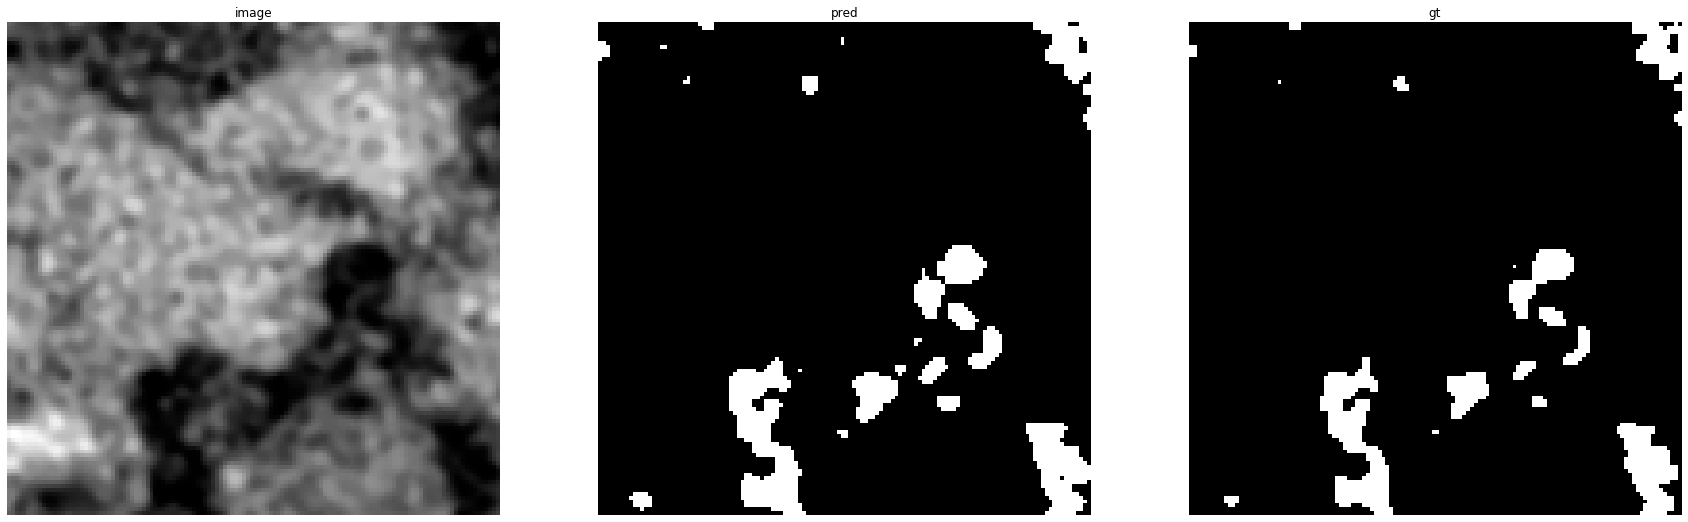

accuracy    : 0.9827880859375
precision   : 0.7984848484848485
recall      : 0.9850467289719627
f1          : 0.8820083682008367
pr_auc      : 0.9849260829880214
iou         : 0.7889221556886228


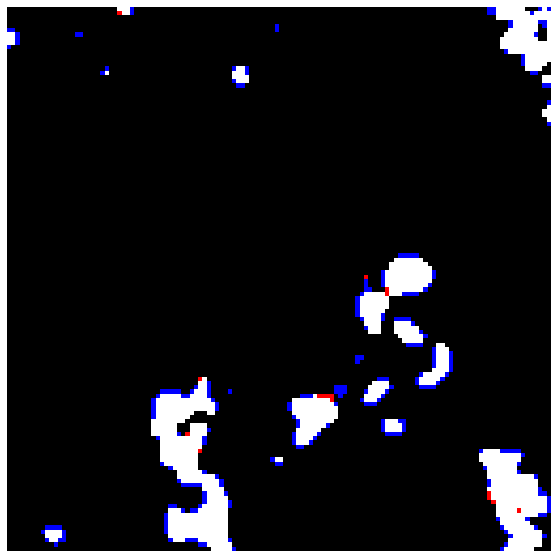

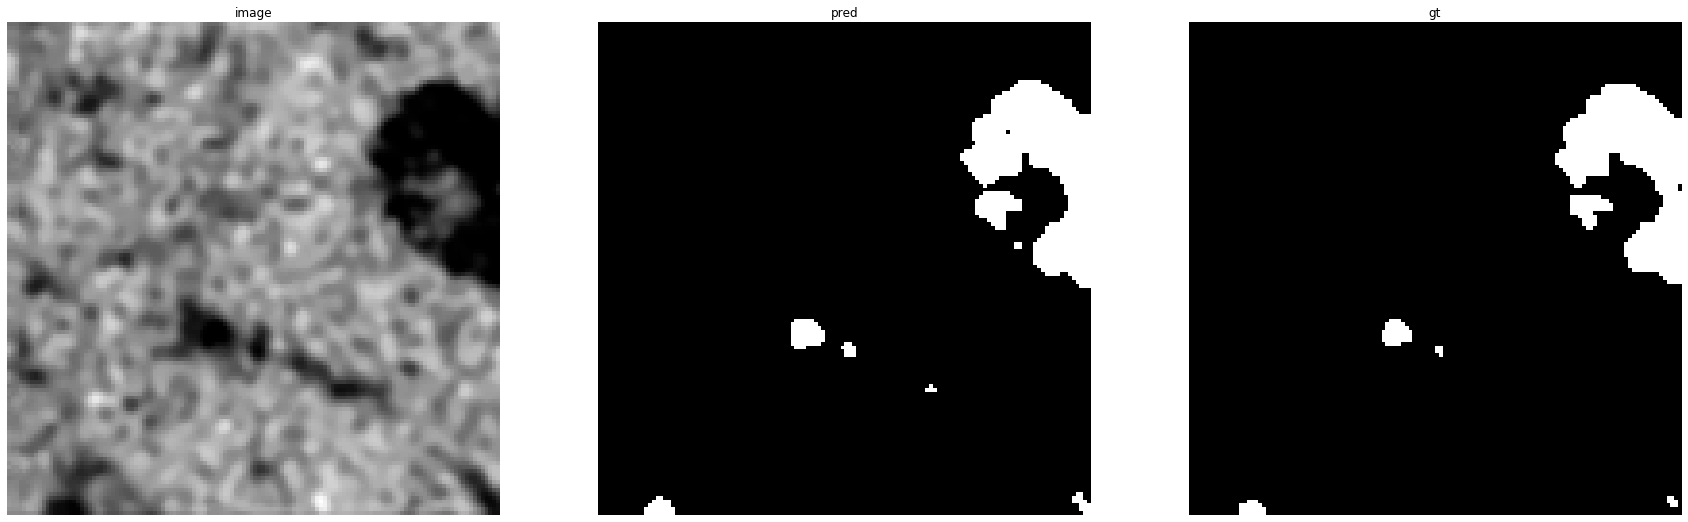

accuracy    : 0.99224853515625
precision   : 0.8884924174843889
recall      : 0.9979959919839679
f1          : 0.9400660689004247
pr_auc      : 0.9980352062951092
iou         : 0.8869100623330365


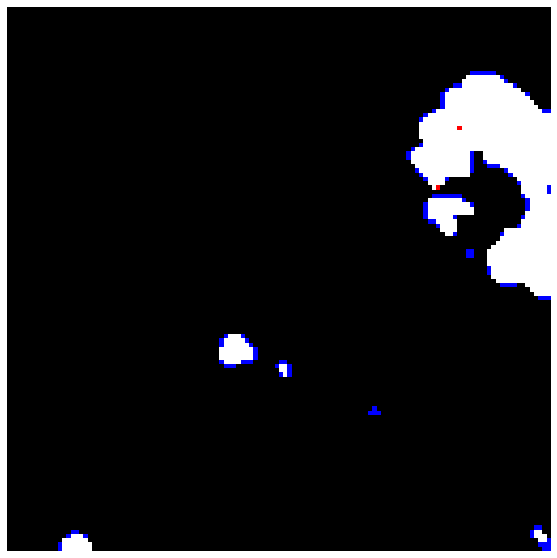

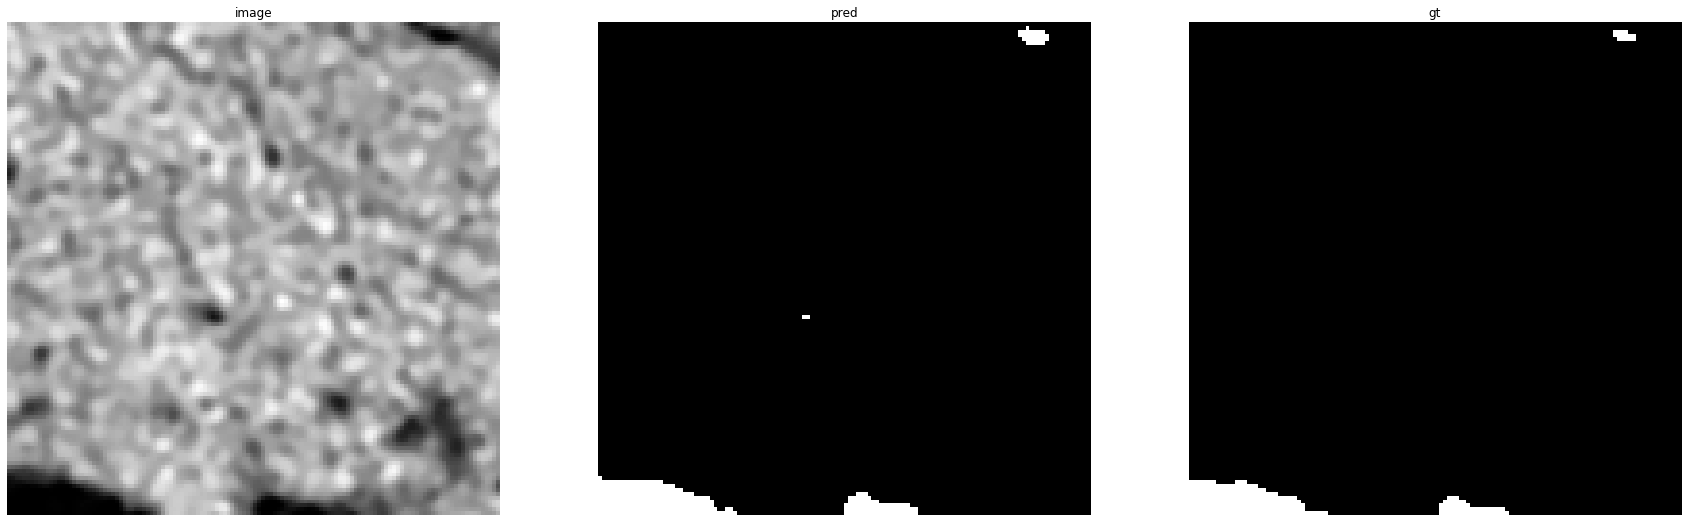

accuracy    : 0.9967041015625
precision   : 0.8434782608695652
recall      : 1.0
f1          : 0.9150943396226415
pr_auc      : 0.9986264960053086
iou         : 0.8434782608695652


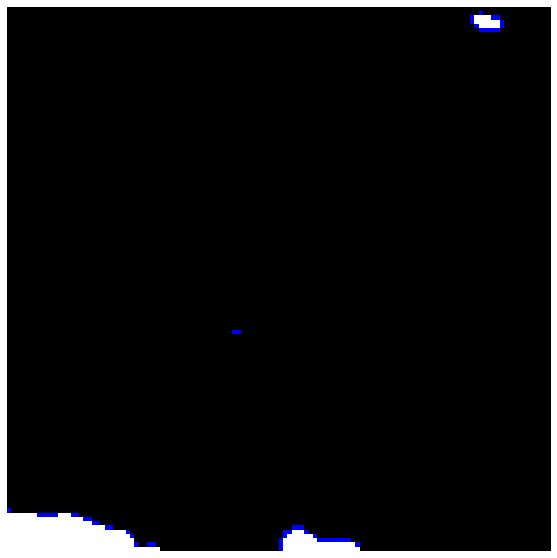

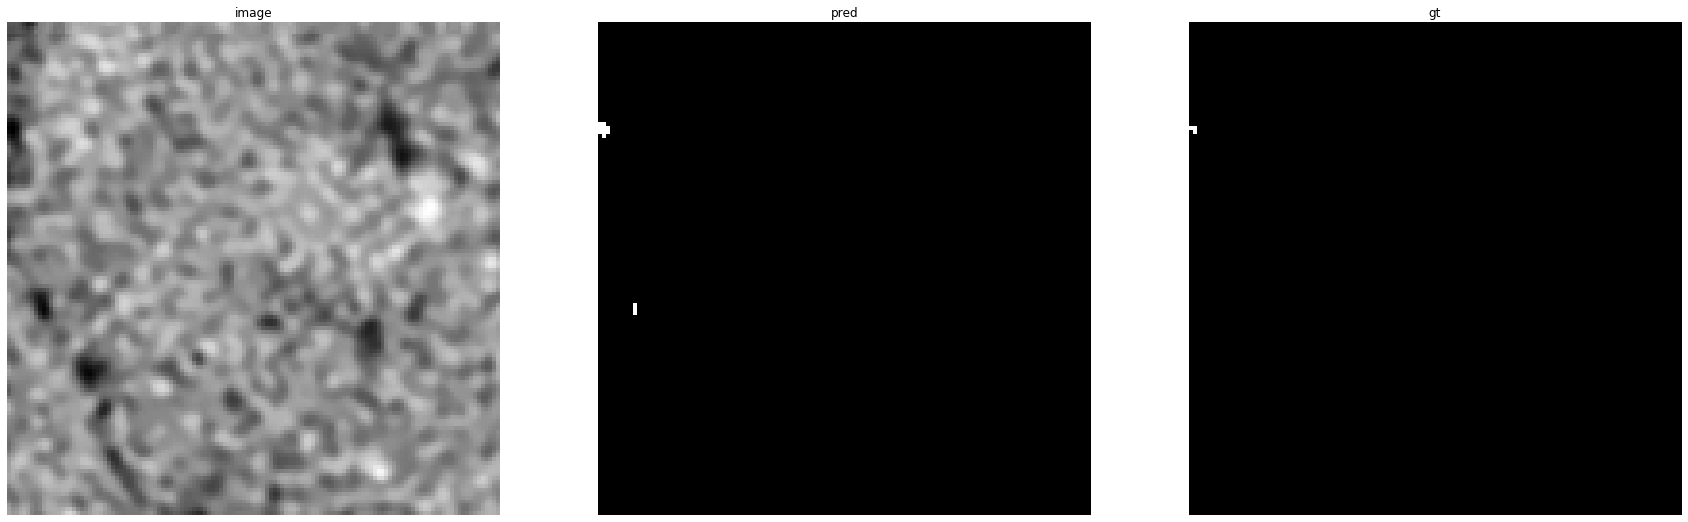

accuracy    : 0.99945068359375
precision   : 0.25
recall      : 1.0
f1          : 0.4
pr_auc      : 1.0
iou         : 0.25


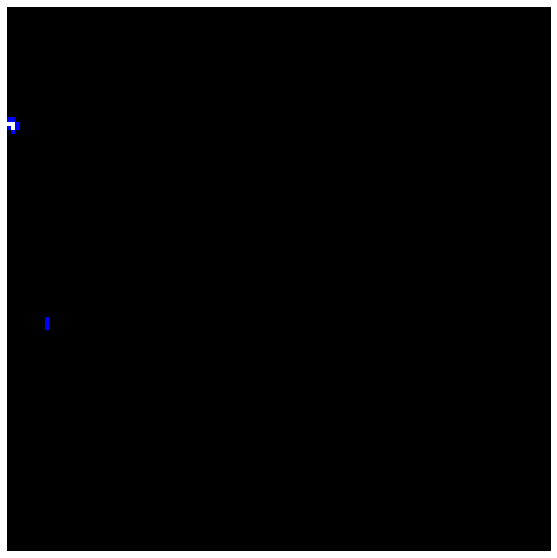

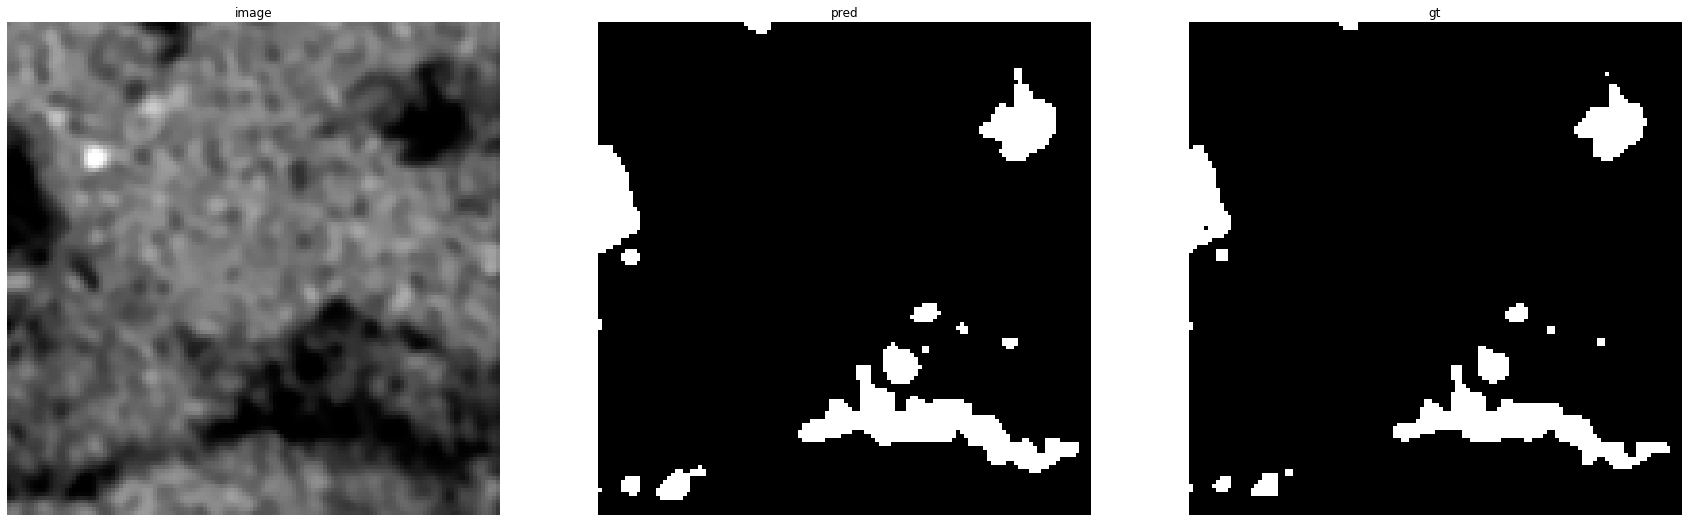

accuracy    : 0.9854736328125
precision   : 0.8270787343635025
recall      : 0.997338065661047
f1          : 0.9042638777152051
pr_auc      : 0.9954931620951457
iou         : 0.8252569750367107


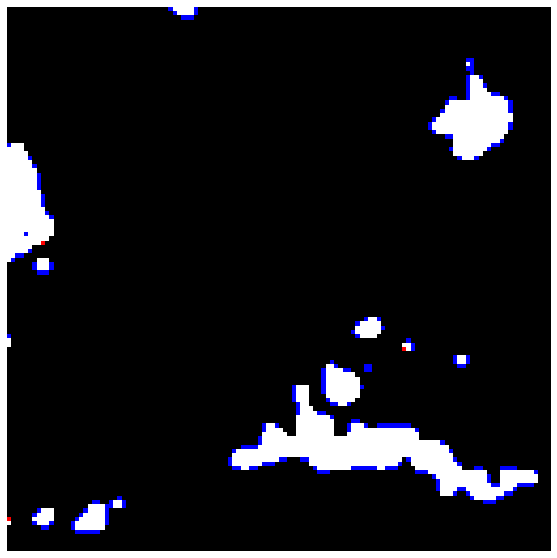

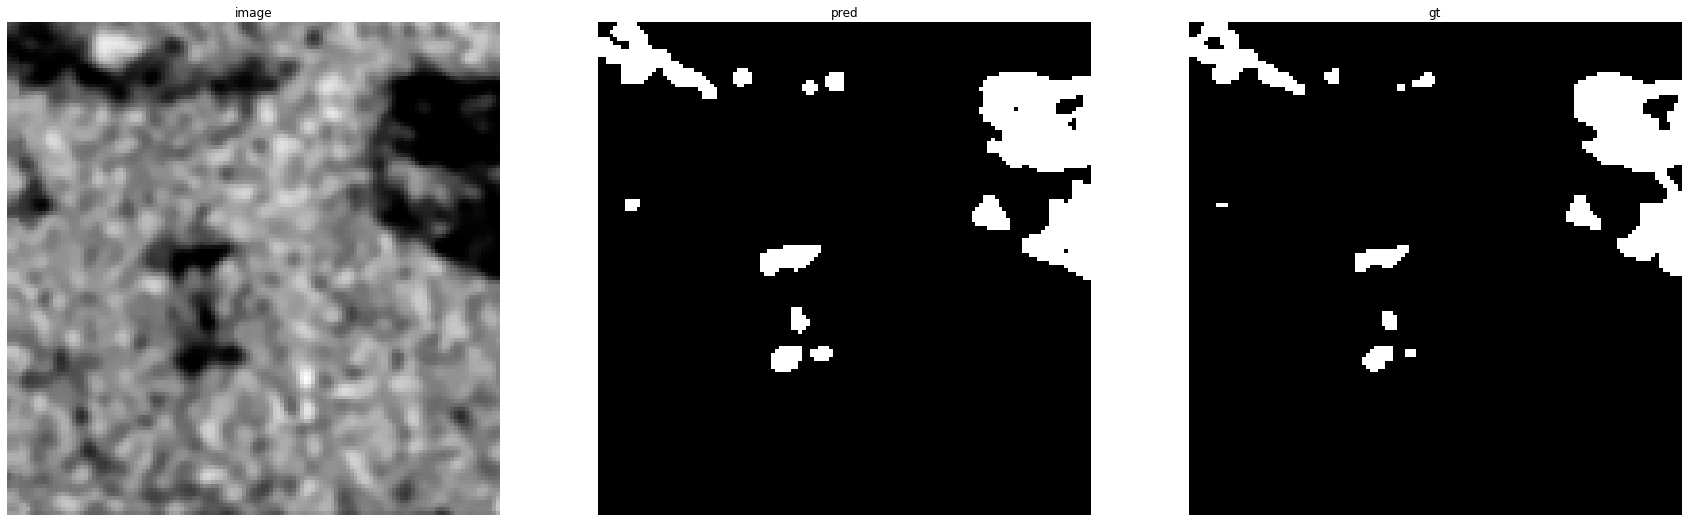

accuracy    : 0.98516845703125
precision   : 0.8452380952380952
recall      : 0.9820992676973149
f1          : 0.9085434700790365
pr_auc      : 0.9907095404314188
iou         : 0.8324137931034483


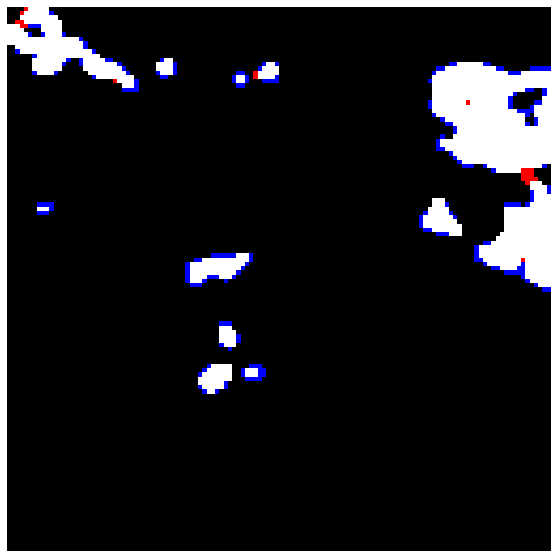

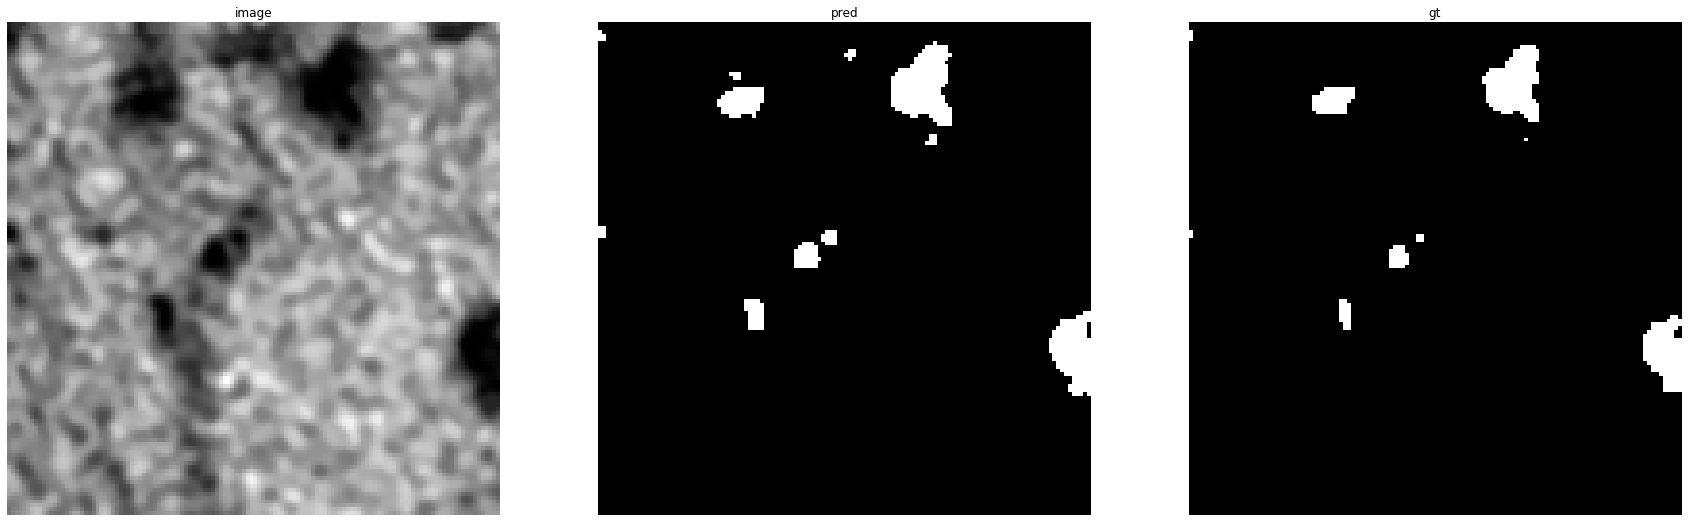

accuracy    : 0.99200439453125
precision   : 0.7818791946308725
recall      : 0.9978586723768736
f1          : 0.8767638758231421
pr_auc      : 0.9894801728122579
iou         : 0.7805695142378559


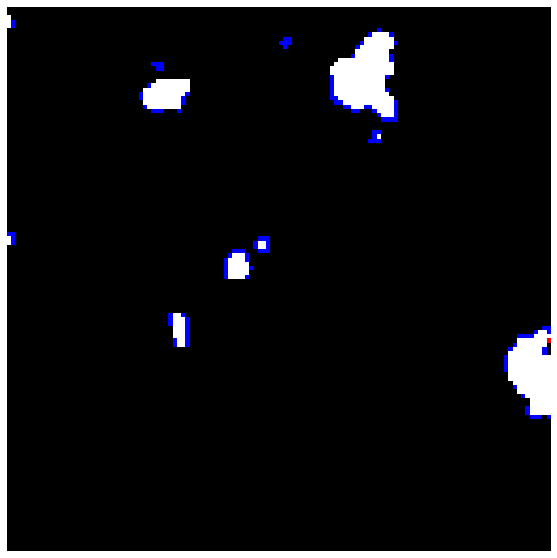

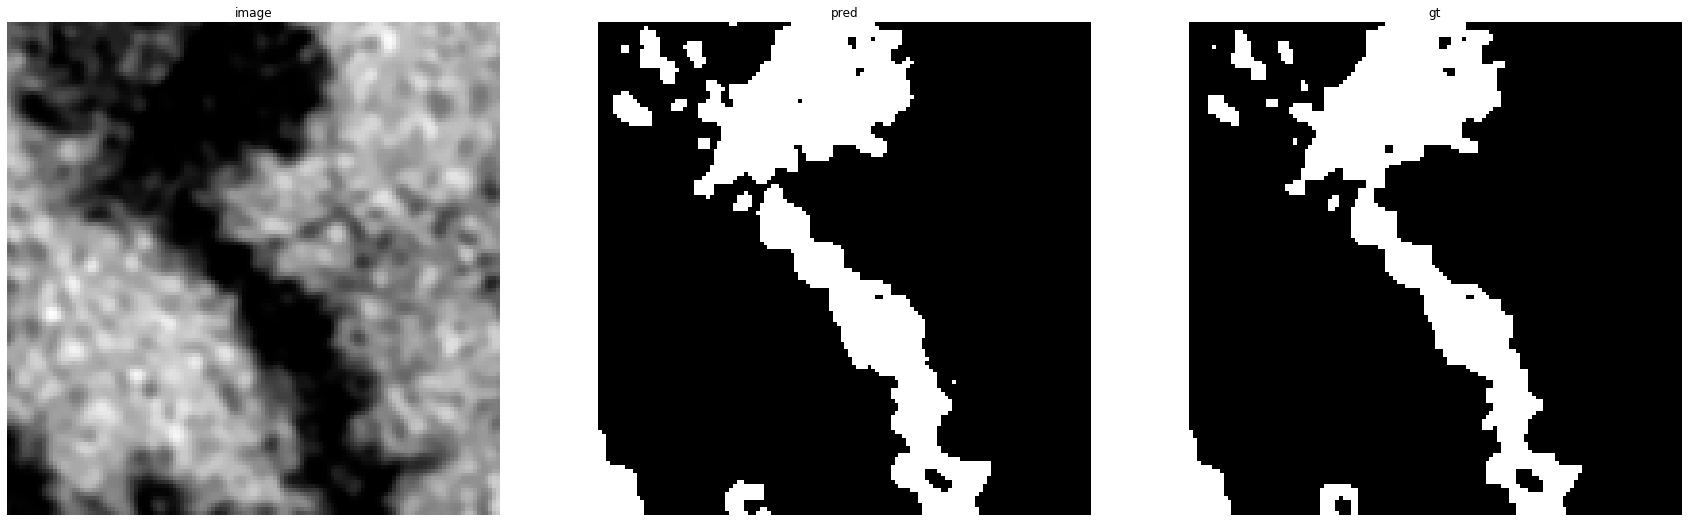

accuracy    : 0.976806640625
precision   : 0.8992718446601942
recall      : 0.9840637450199203
f1          : 0.9397590361445783
pr_auc      : 0.9952732652781718
iou         : 0.8863636363636364


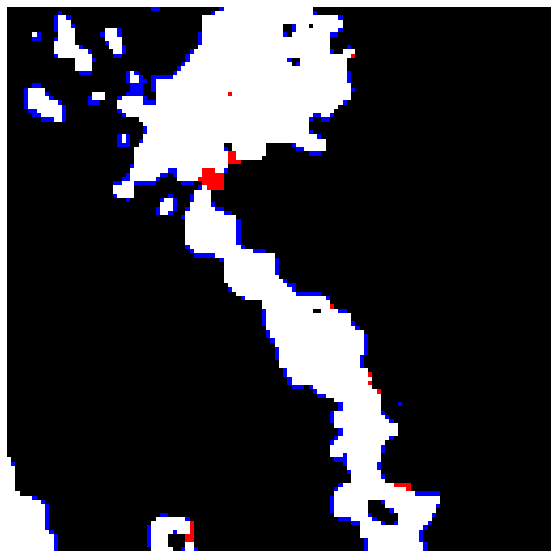

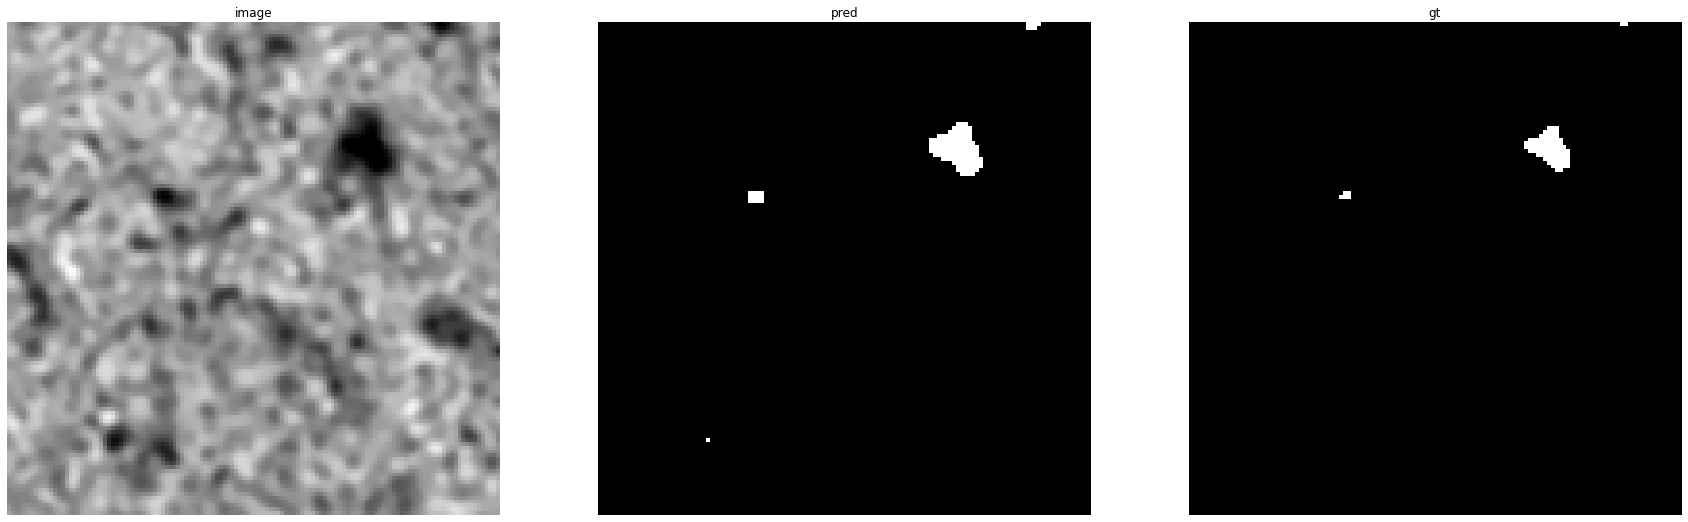

accuracy    : 0.99688720703125
precision   : 0.6357142857142857
recall      : 1.0
f1          : 0.7772925764192139
pr_auc      : 0.9886785378227461
iou         : 0.6357142857142857


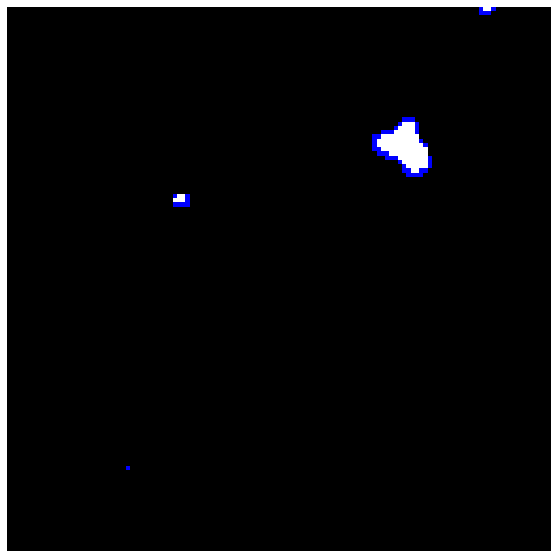

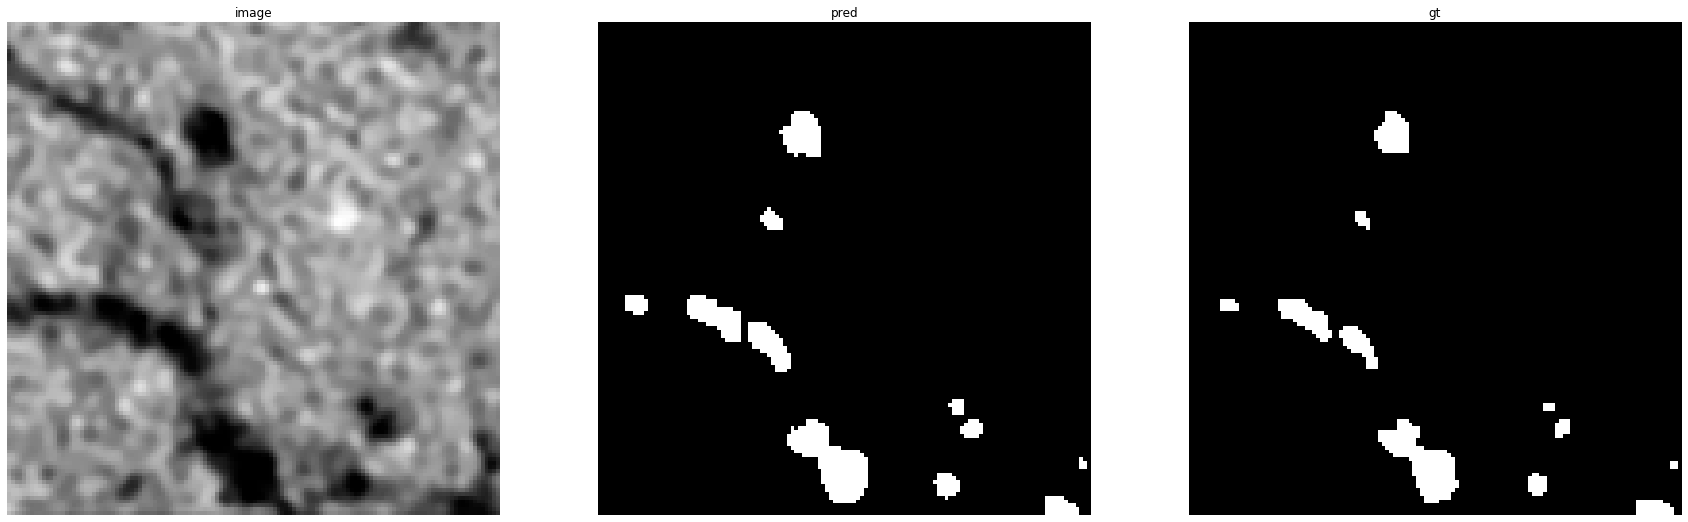

accuracy    : 0.99078369140625
precision   : 0.7864506627393225
recall      : 0.9888888888888889
f1          : 0.8761279737489747
pr_auc      : 0.9909657142434358
iou         : 0.7795620437956204


Prediction for TeTree_subset1:


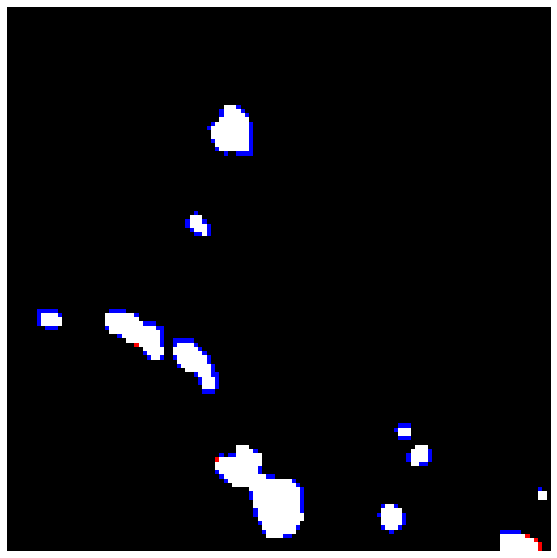

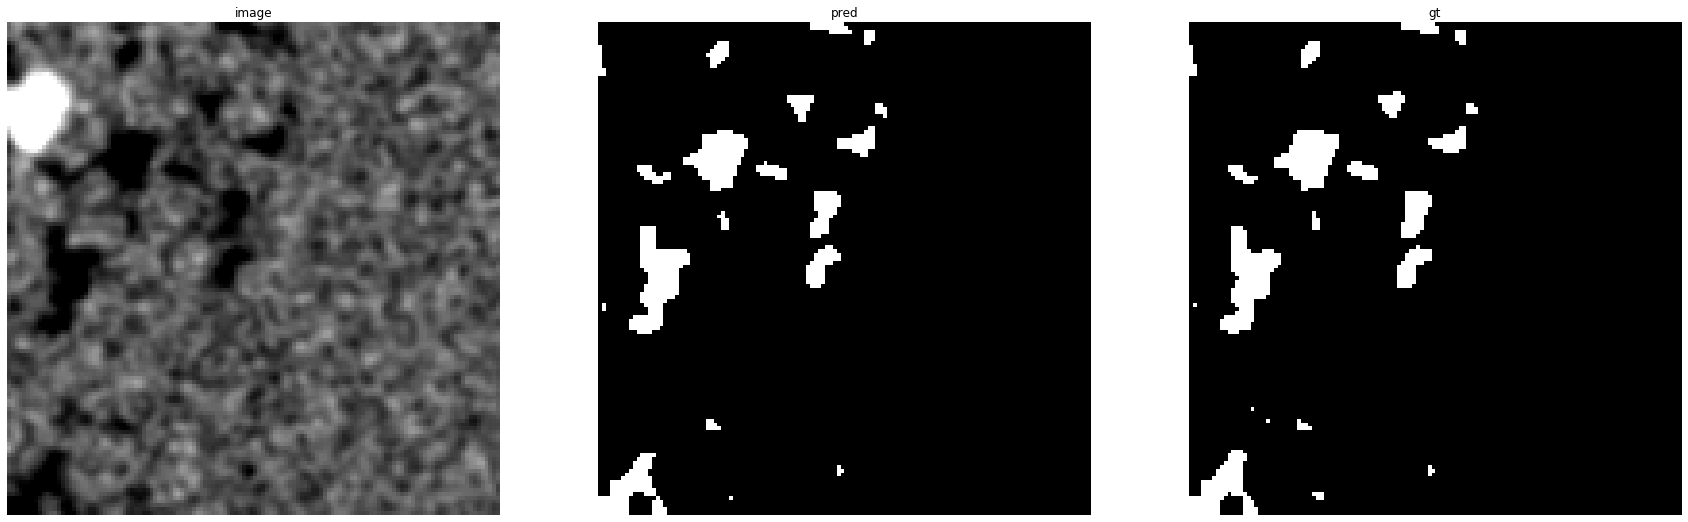

accuracy    : 0.99530029296875
precision   : 0.9698375870069605
recall      : 0.9425028184892897
f1          : 0.9559748427672956
pr_auc      : 0.9926342995131293
iou         : 0.9156626506024096


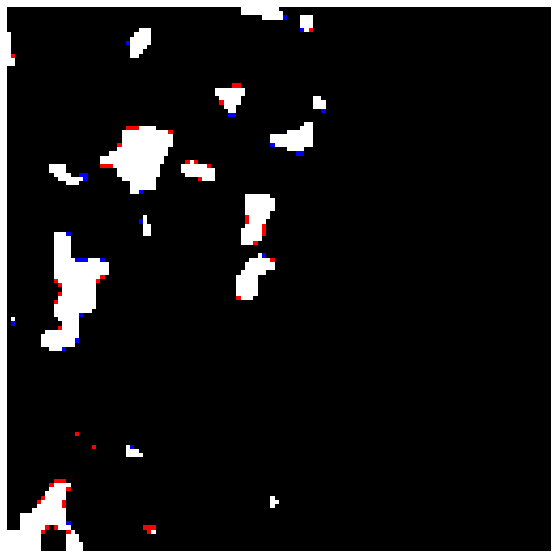

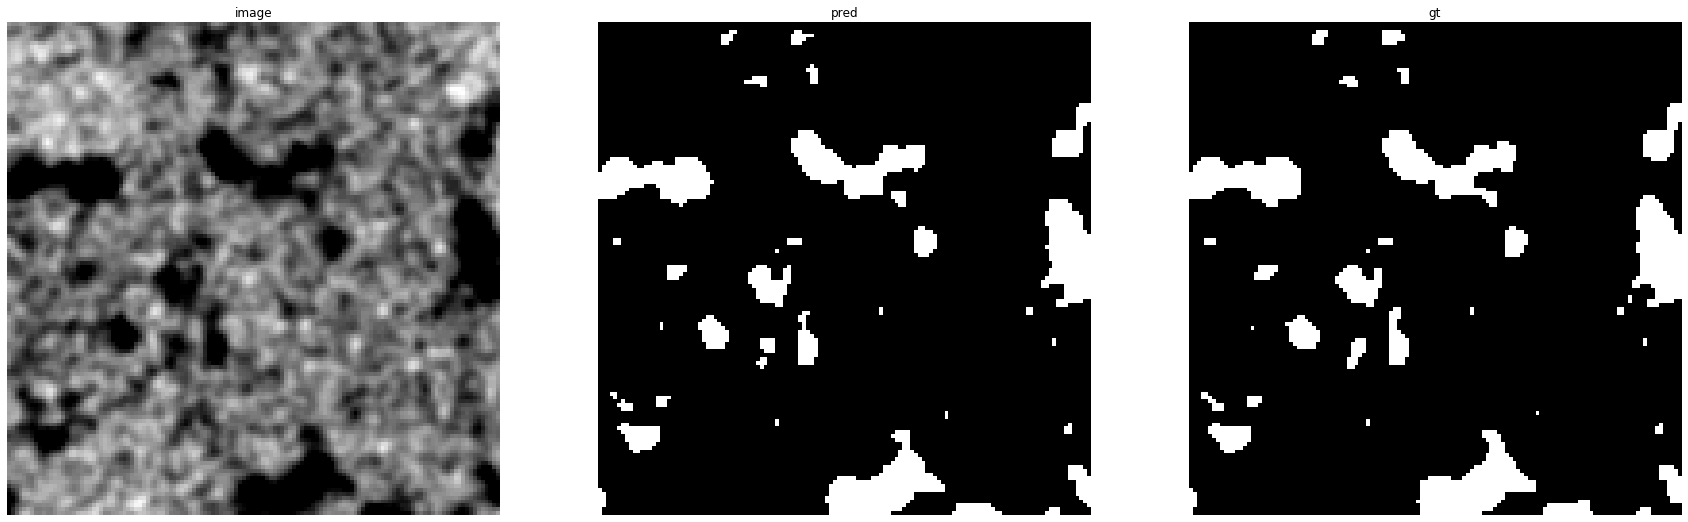

accuracy    : 0.9923095703125
precision   : 0.9893992932862191
recall      : 0.9395973154362416
f1          : 0.963855421686747
pr_auc      : 0.9957670501618153
iou         : 0.9302325581395349


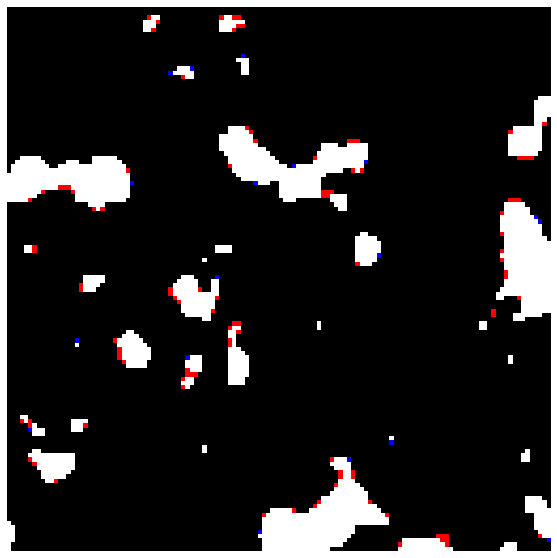

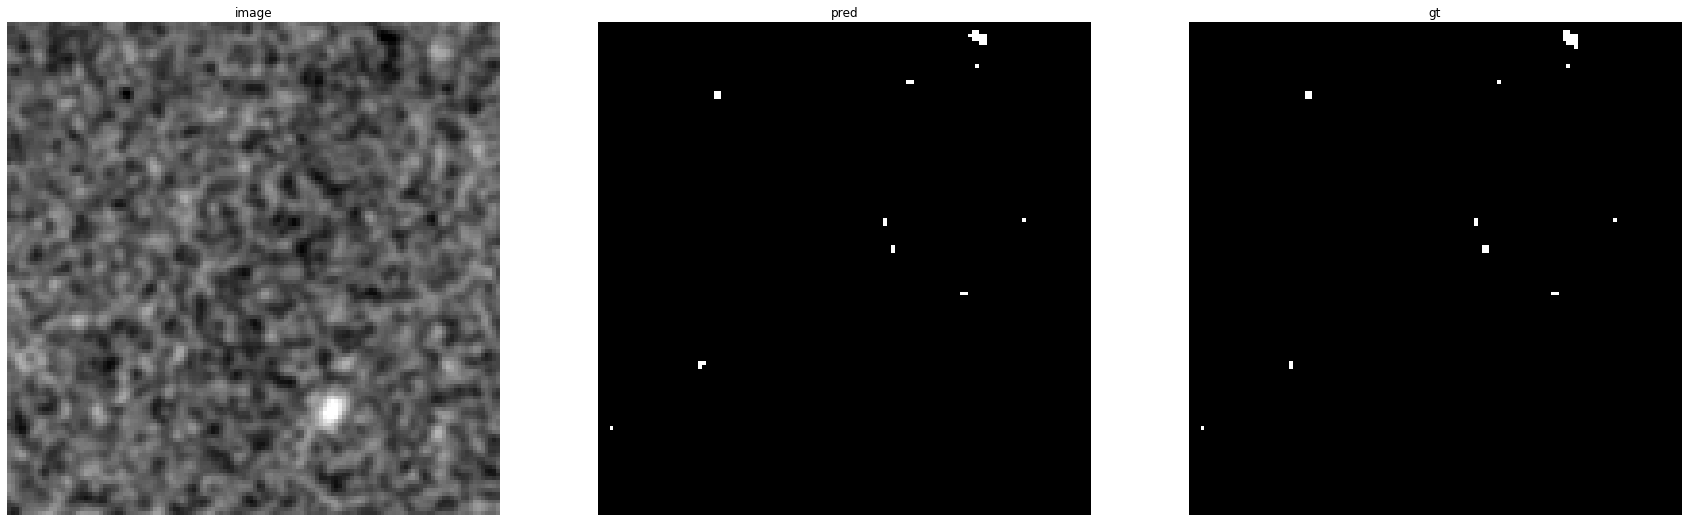

accuracy    : 0.99957275390625
precision   : 0.9032258064516129
recall      : 0.875
f1          : 0.8888888888888888
pr_auc      : 0.936048632266784
iou         : 0.8


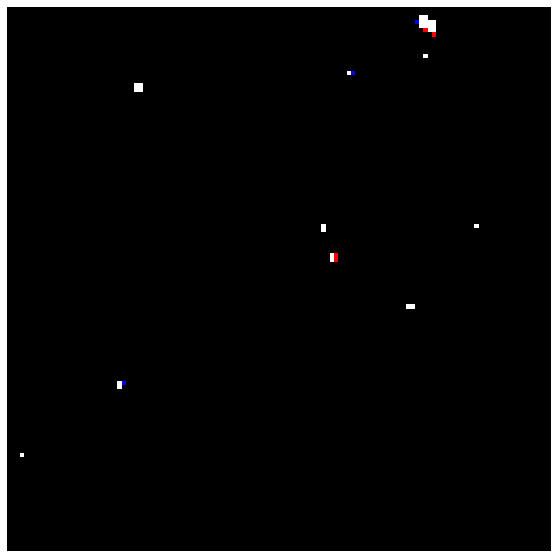

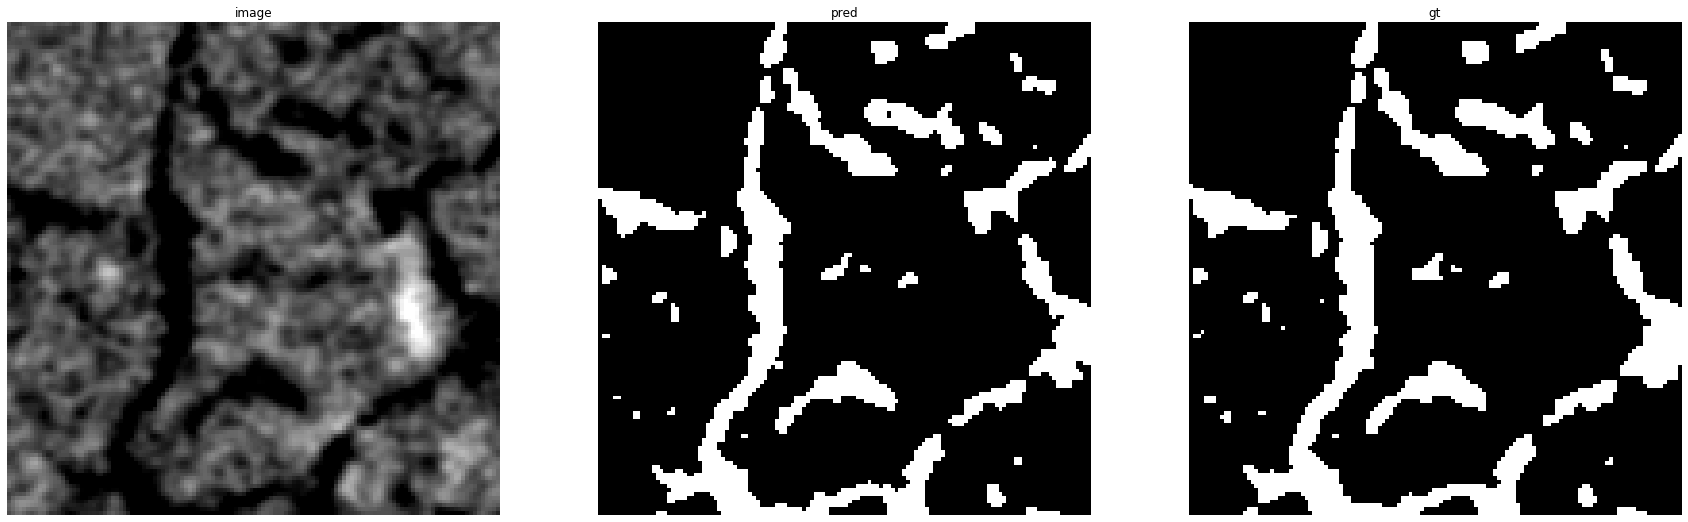

accuracy    : 0.9853515625
precision   : 0.9902336937565399
recall      : 0.9305145853818421
f1          : 0.9594457587022643
pr_auc      : 0.9963262710777603
iou         : 0.9220526144852225


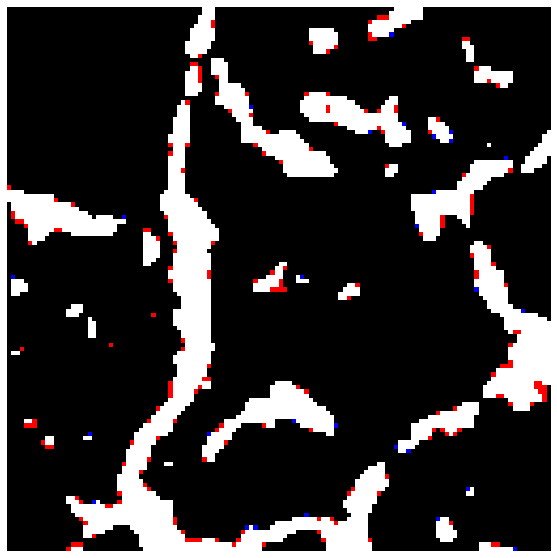

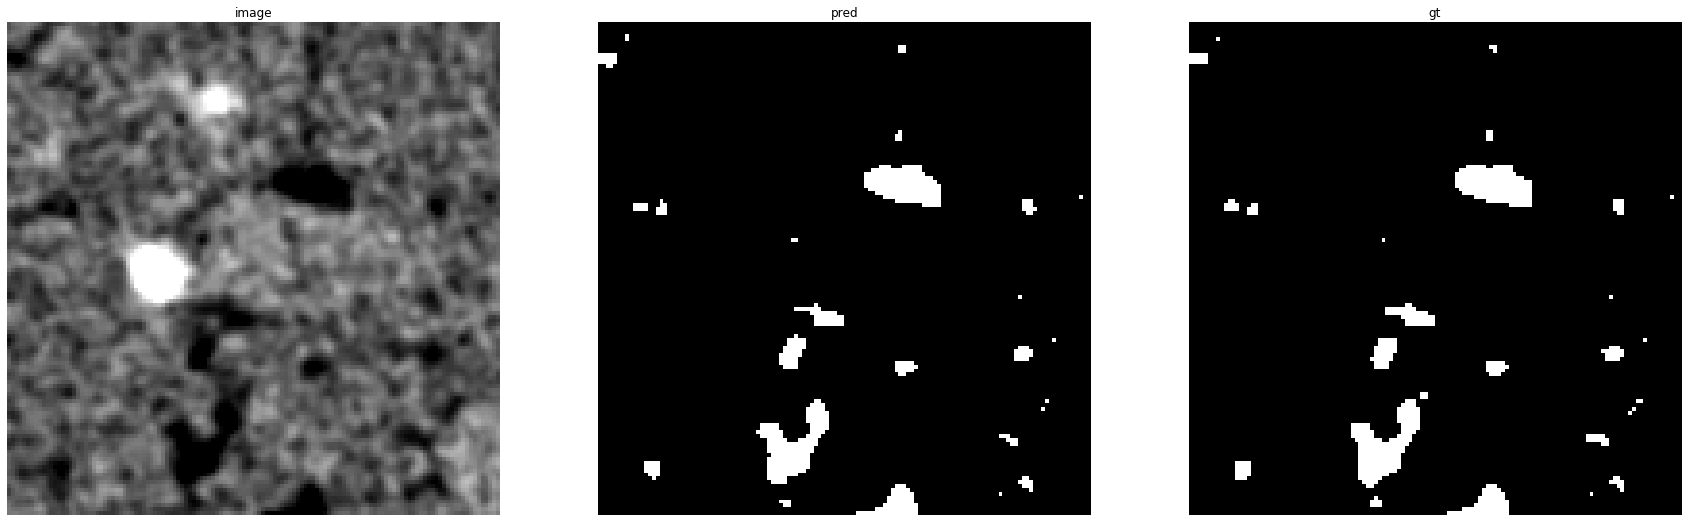

accuracy    : 0.99639892578125
precision   : 0.981042654028436
recall      : 0.9296407185628742
f1          : 0.9546502690238279
pr_auc      : 0.9930090303523699
iou         : 0.913235294117647


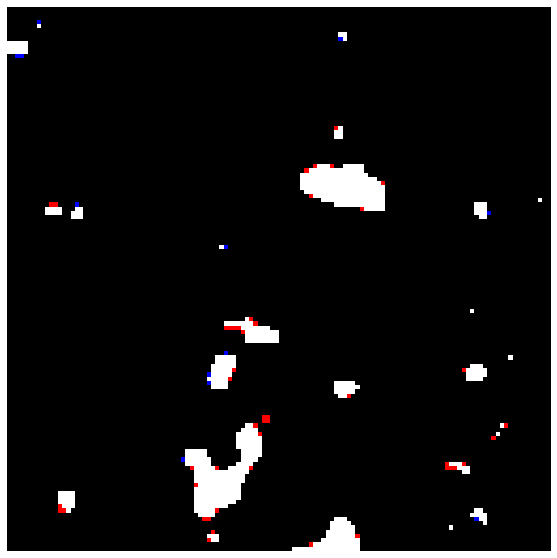

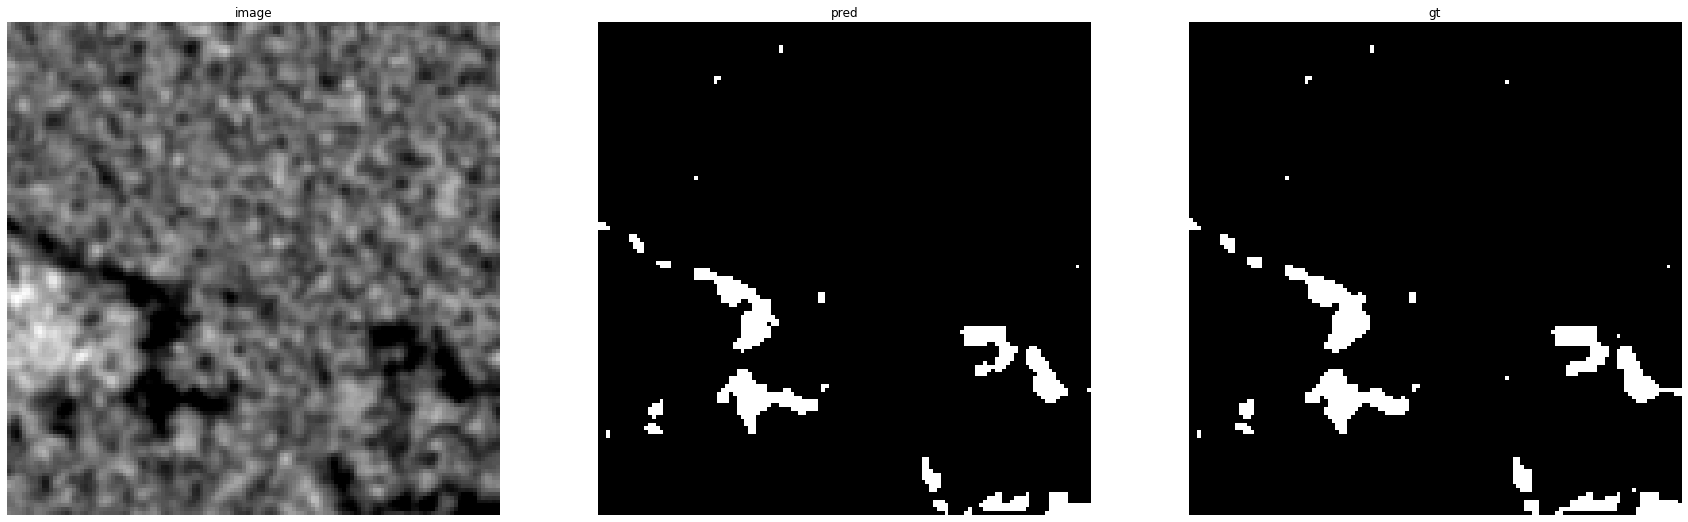

accuracy    : 0.9931640625
precision   : 0.9943820224719101
recall      : 0.8676470588235294
f1          : 0.9267015706806283
pr_auc      : 0.9891704279456481
iou         : 0.8634146341463415


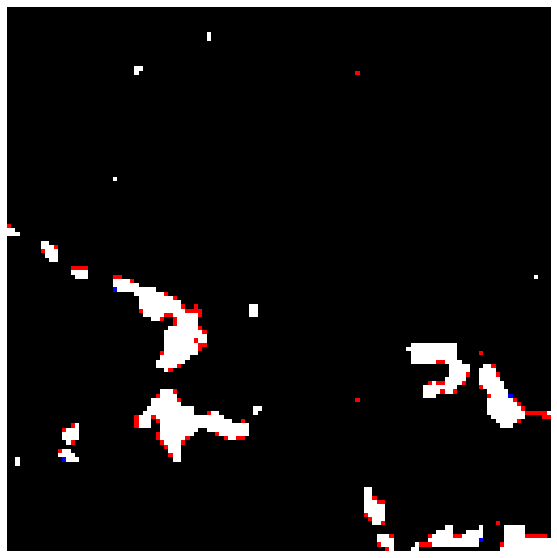

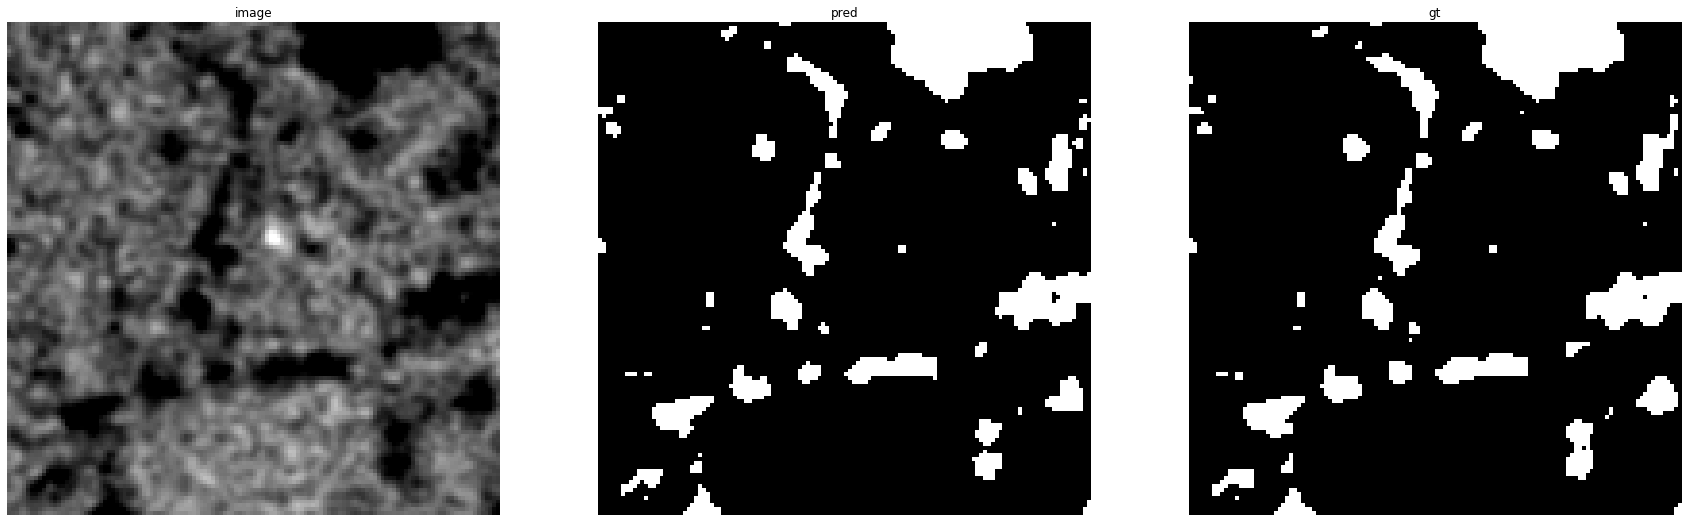

accuracy    : 0.98944091796875
precision   : 0.9873551106427819
recall      : 0.9263470093919921
f1          : 0.9558786023973477
pr_auc      : 0.9943580684514373
iou         : 0.9154860771861261


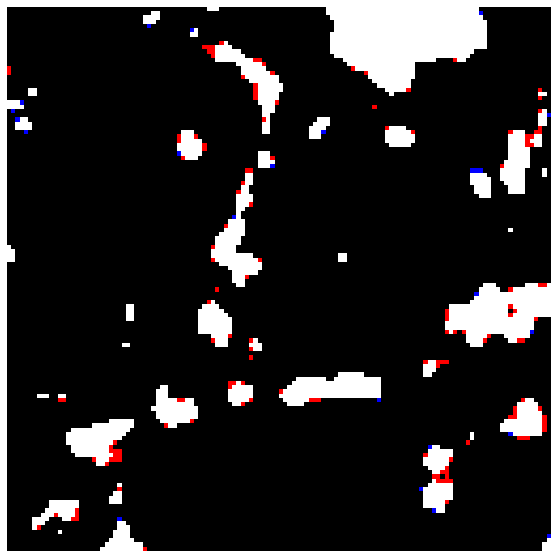

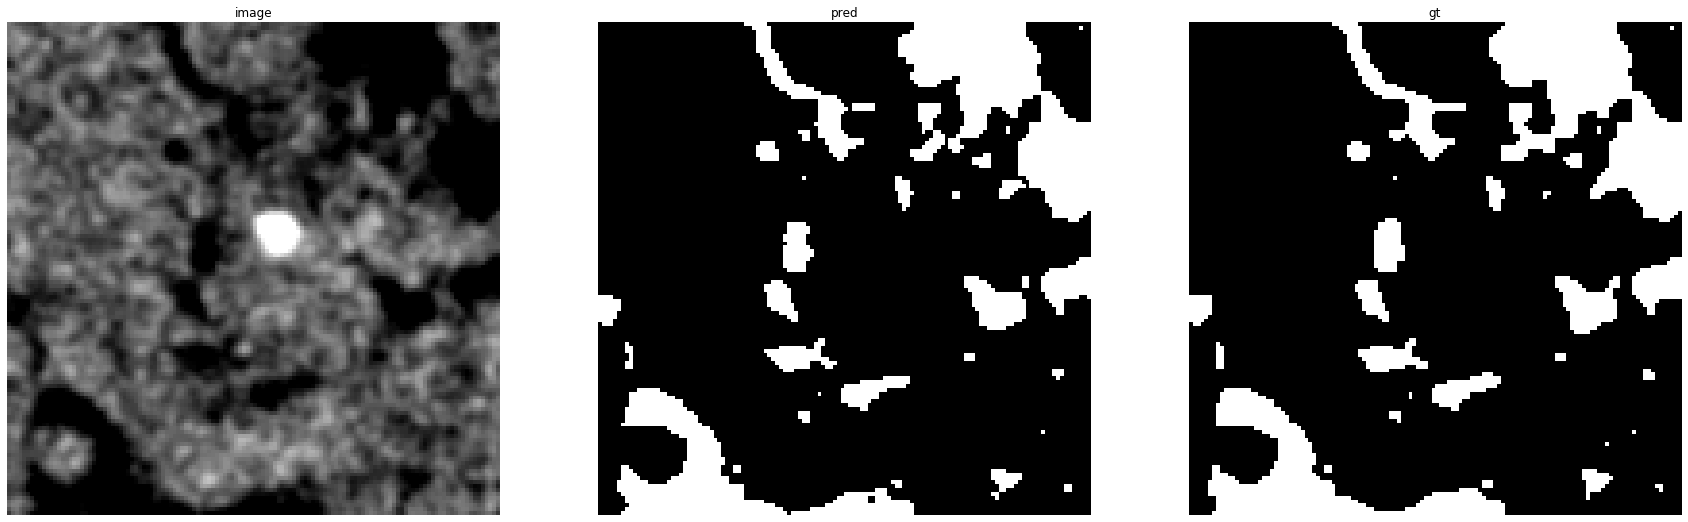

accuracy    : 0.98797607421875
precision   : 0.9930046635576283
recall      : 0.9442508710801394
f1          : 0.9680142880337717
pr_auc      : 0.9977143045420984
iou         : 0.9380113278791693


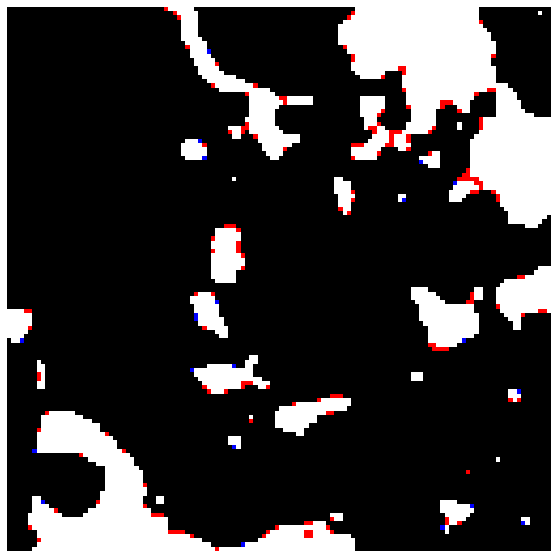

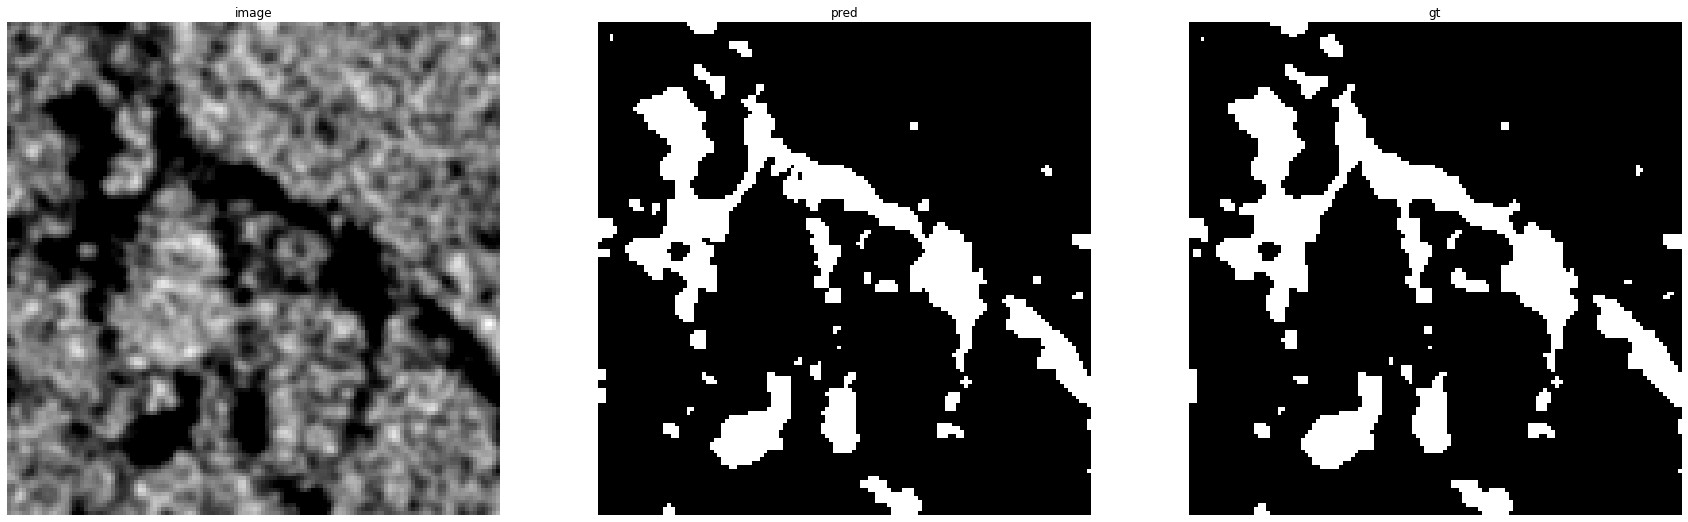

accuracy    : 0.985107421875
precision   : 0.9840976331360947
recall      : 0.929769392033543
f1          : 0.9561624146604384
pr_auc      : 0.9951469327556597
iou         : 0.9160068846815834


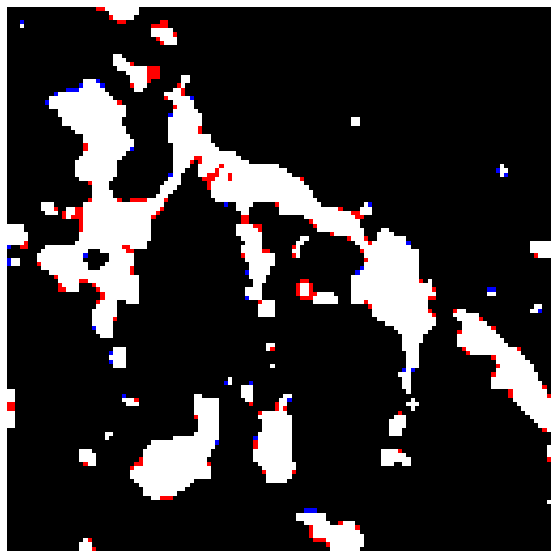

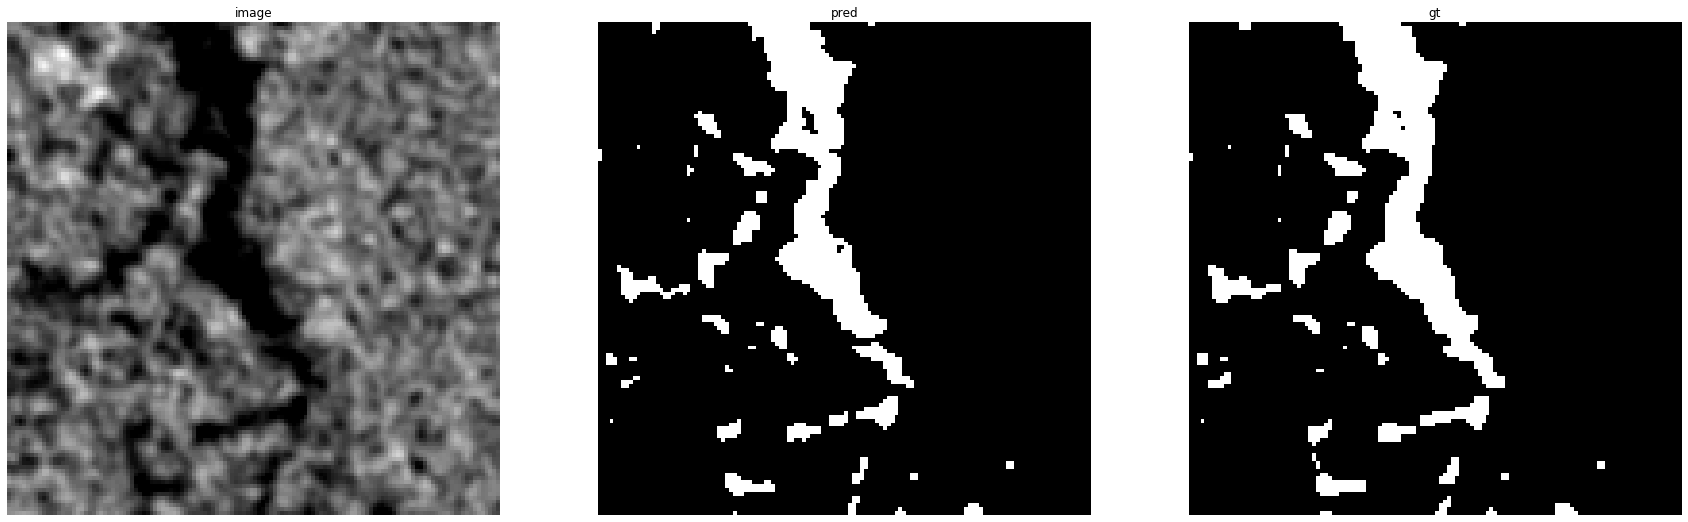

accuracy    : 0.98828125
precision   : 0.9916067146282974
recall      : 0.9028384279475983
f1          : 0.9451428571428572
pr_auc      : 0.99260165277467
iou         : 0.8959913326110509


Prediction for TiTree_subset2:


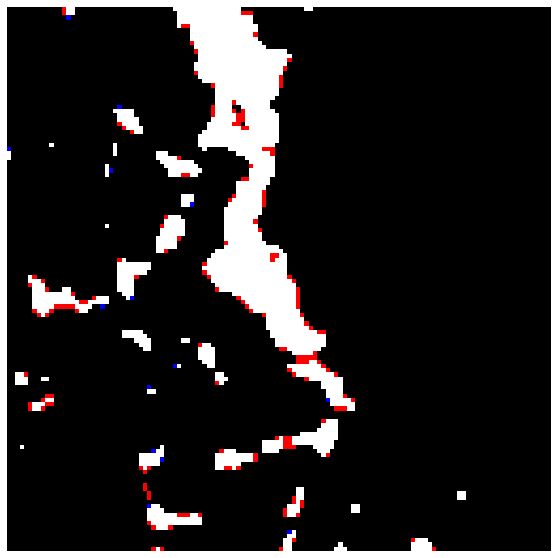

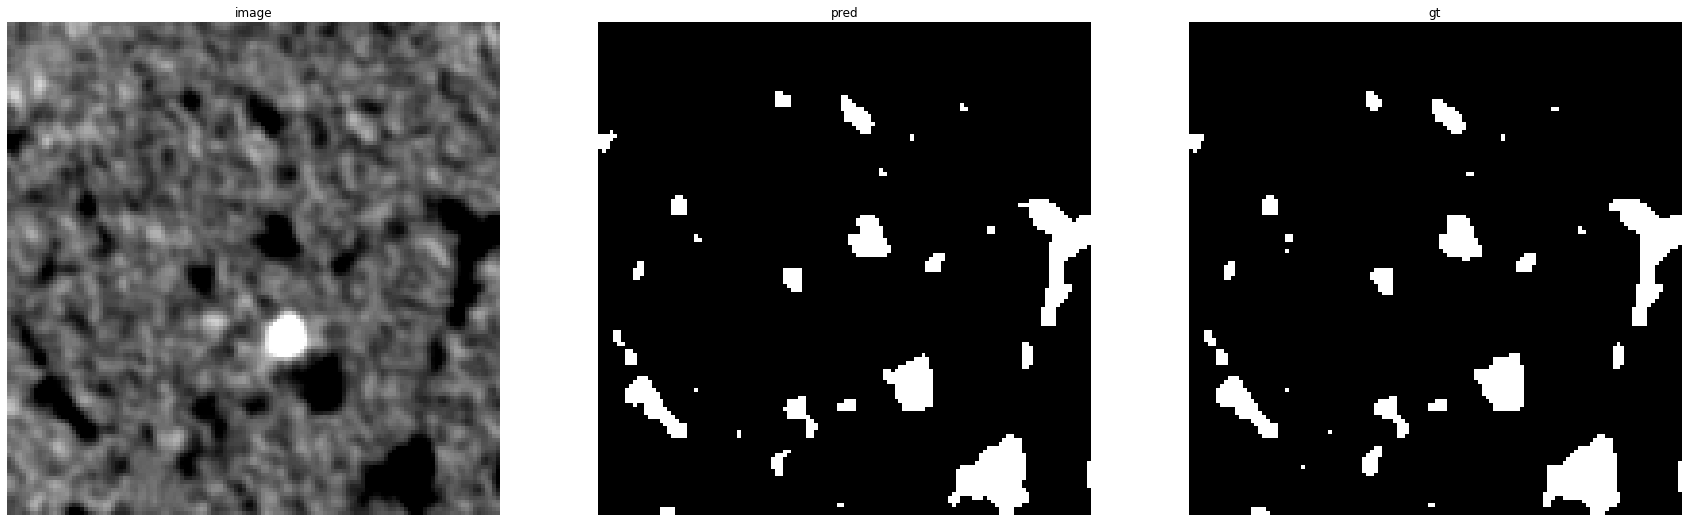

accuracy    : 0.99444580078125
precision   : 0.9874439461883409
recall      : 0.934634974533107
f1          : 0.9603139991277803
pr_auc      : 0.9958924096690112
iou         : 0.9236577181208053


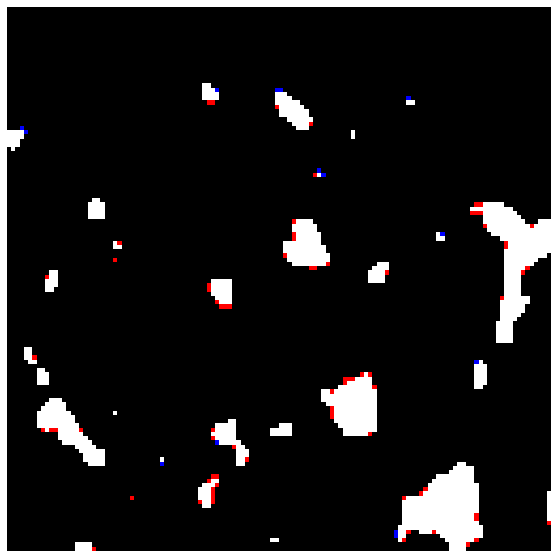

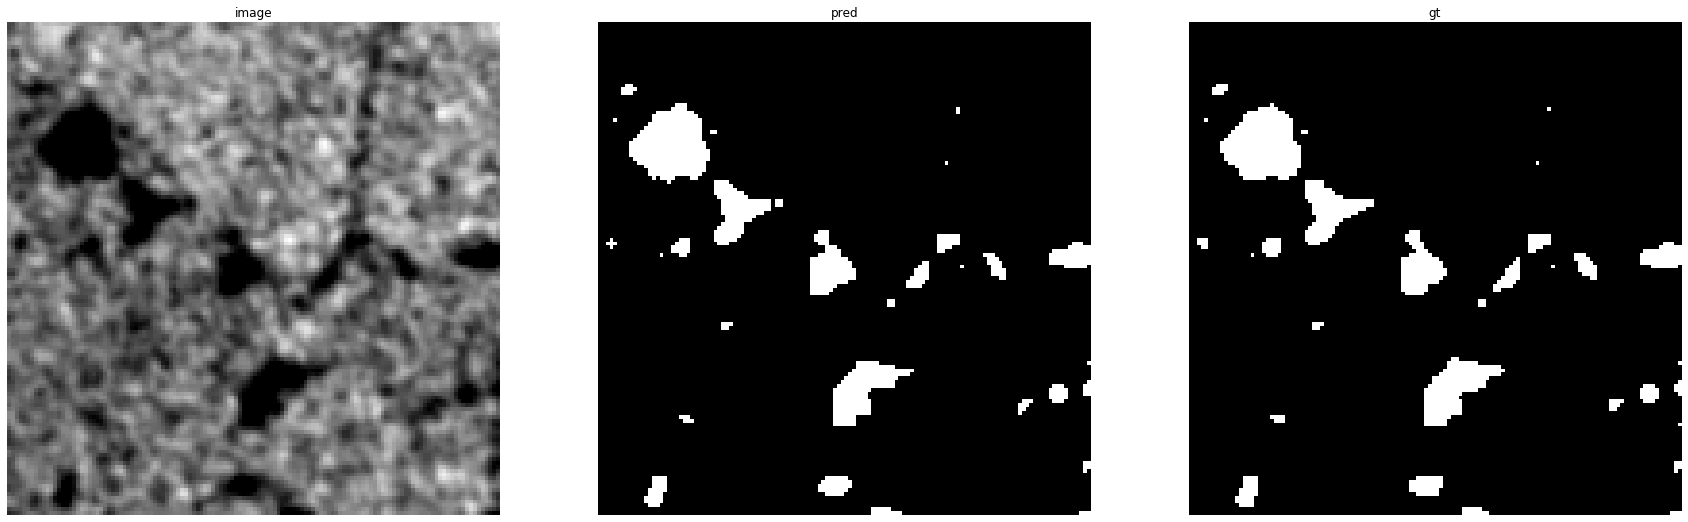

accuracy    : 0.99554443359375
precision   : 0.988560533841754
recall      : 0.9444444444444444
f1          : 0.9659990684676293
pr_auc      : 0.99554687423355
iou         : 0.9342342342342342


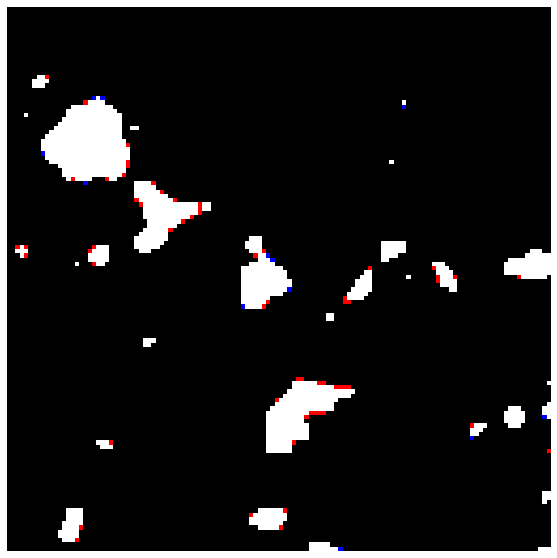

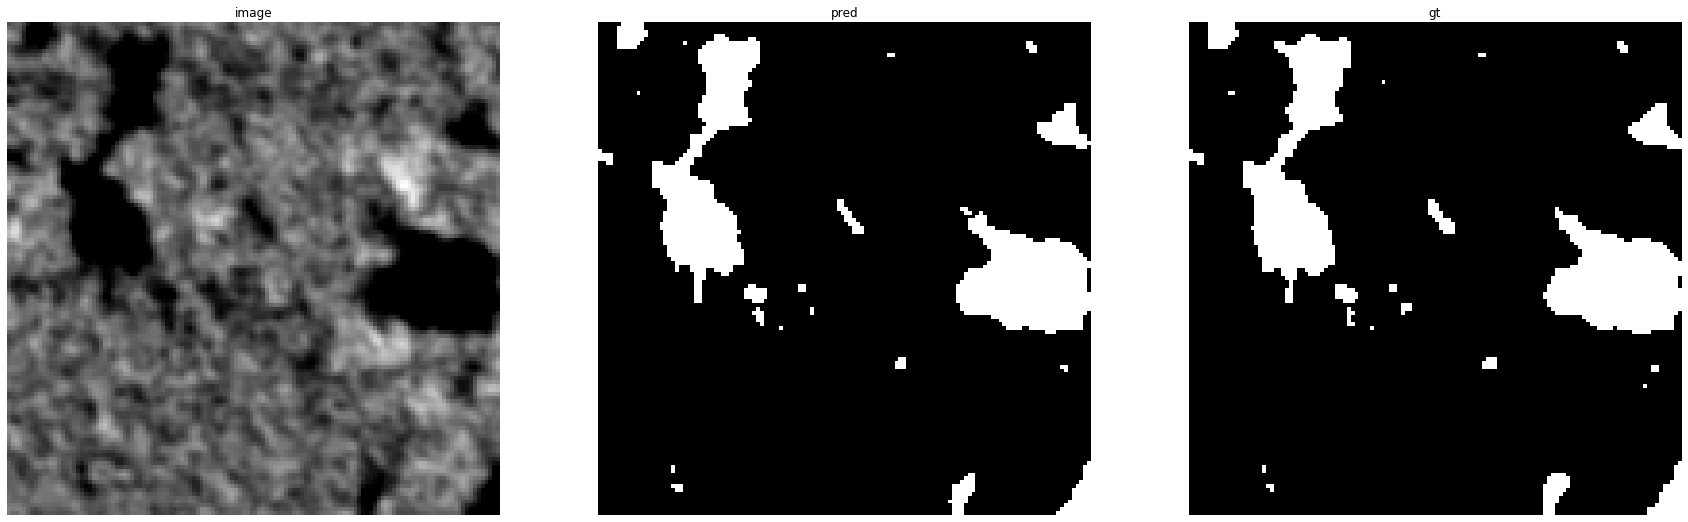

accuracy    : 0.99249267578125
precision   : 0.9915119363395225
recall      : 0.9458502024291497
f1          : 0.9681429681429681
pr_auc      : 0.9971857674716306
iou         : 0.9382530120481928


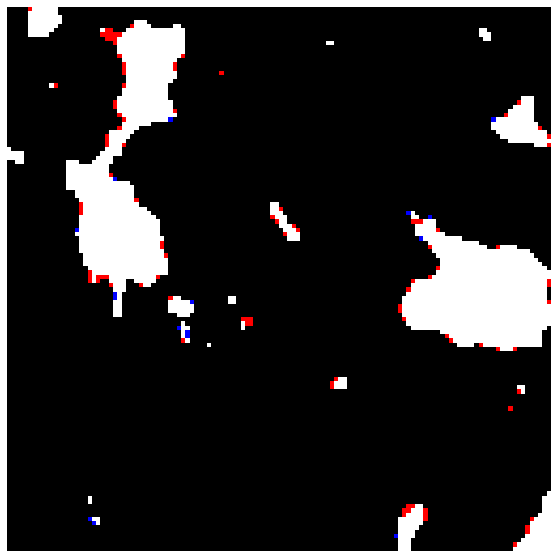

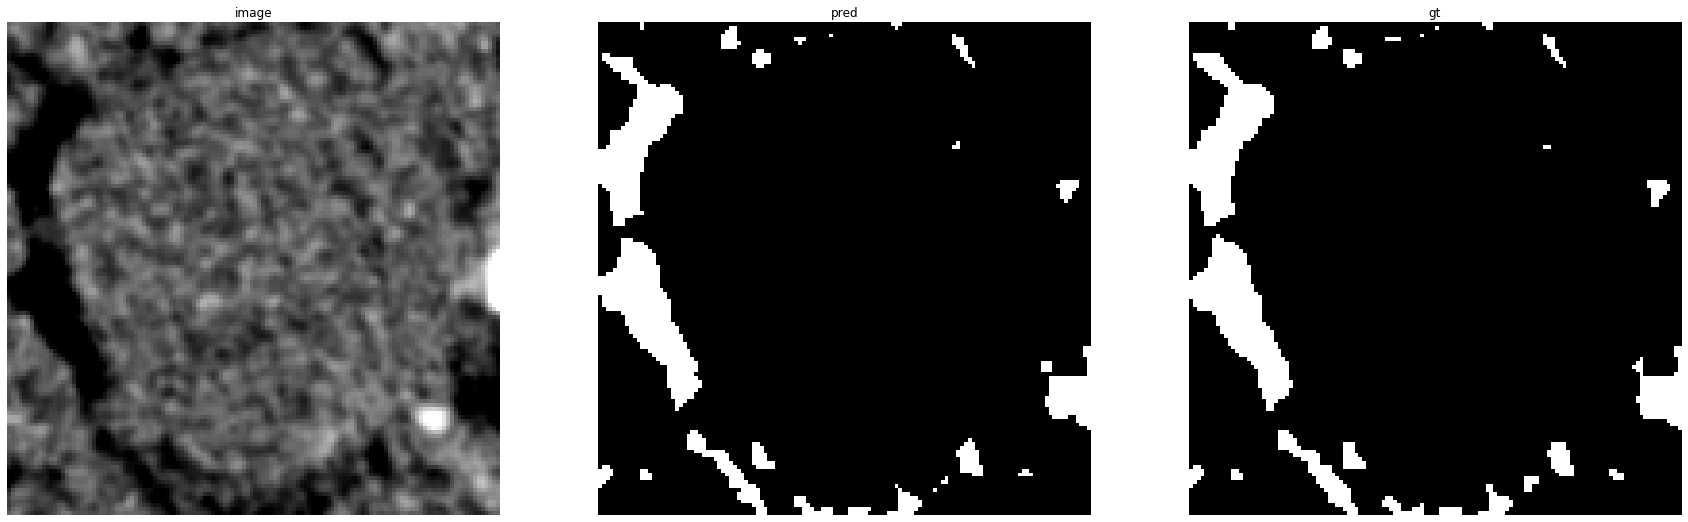

accuracy    : 0.99310302734375
precision   : 0.9882434301521439
recall      : 0.9370491803278689
f1          : 0.9619656681252103
pr_auc      : 0.9957763824010626
iou         : 0.9267185473411155


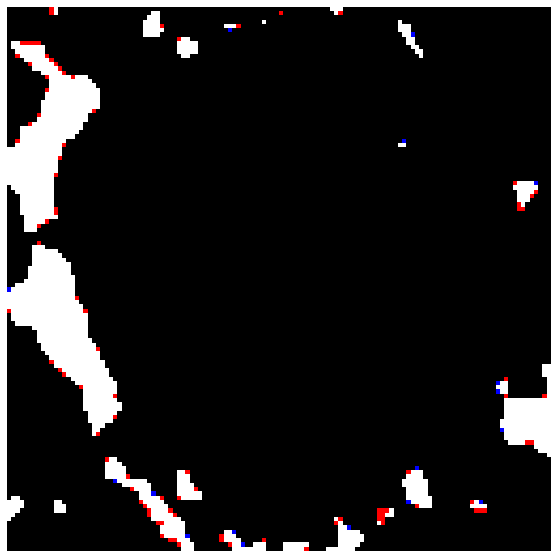

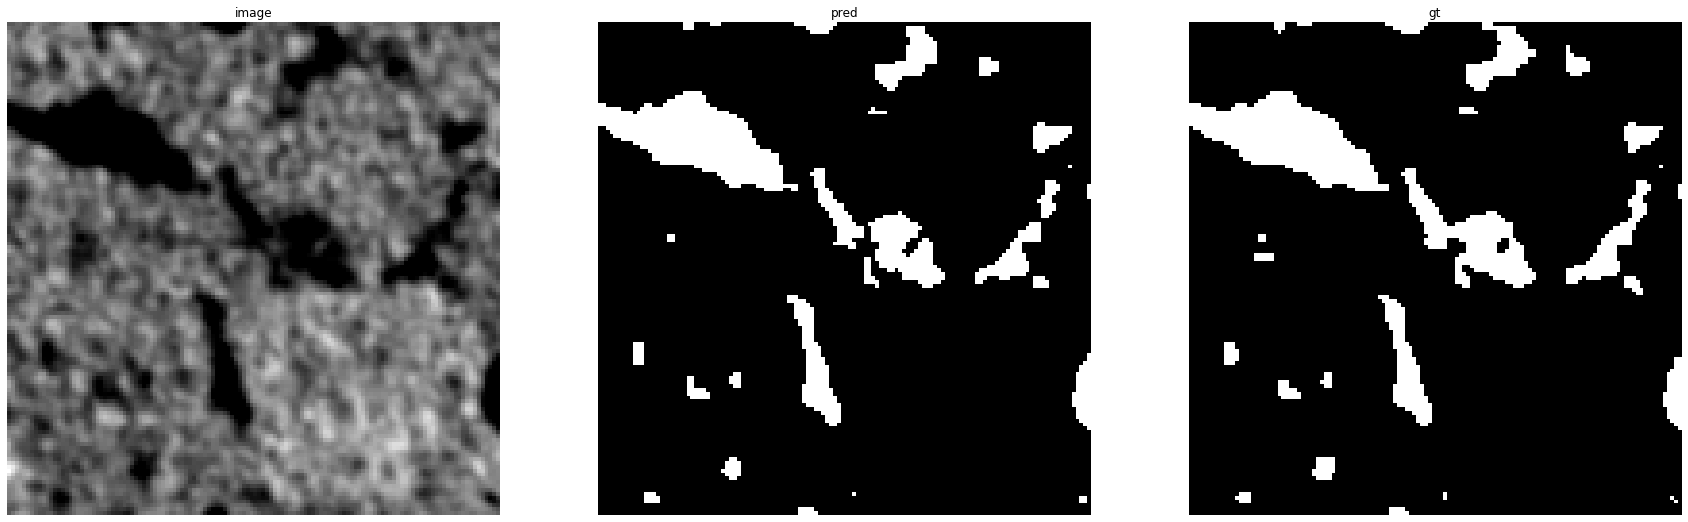

accuracy    : 0.98944091796875
precision   : 0.9907353792704111
recall      : 0.9159528907922913
f1          : 0.9518776077885953
pr_auc      : 0.9945378566968632
iou         : 0.9081740976645435


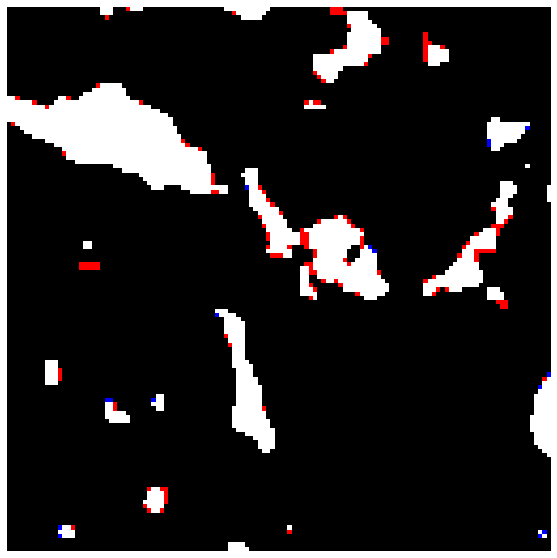

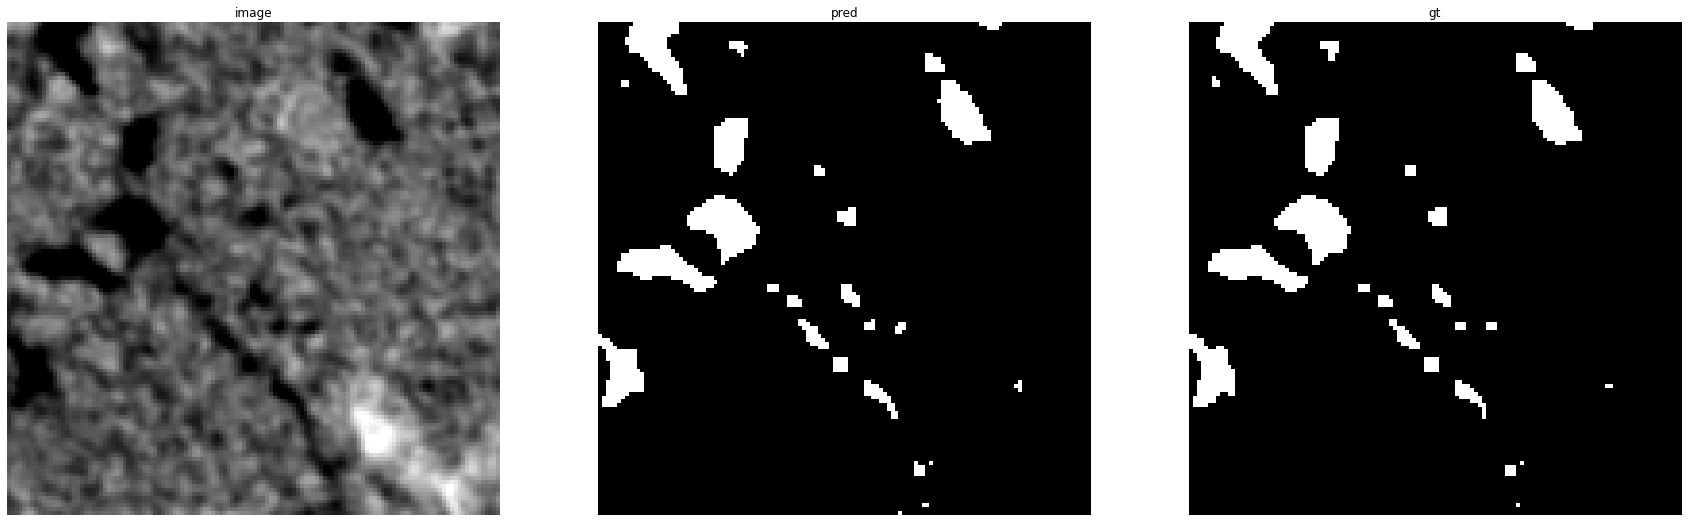

accuracy    : 0.99554443359375
precision   : 0.9853479853479854
recall      : 0.9496910856134158
f1          : 0.9671910112359551
pr_auc      : 0.9953246494829661
iou         : 0.9364664926022629


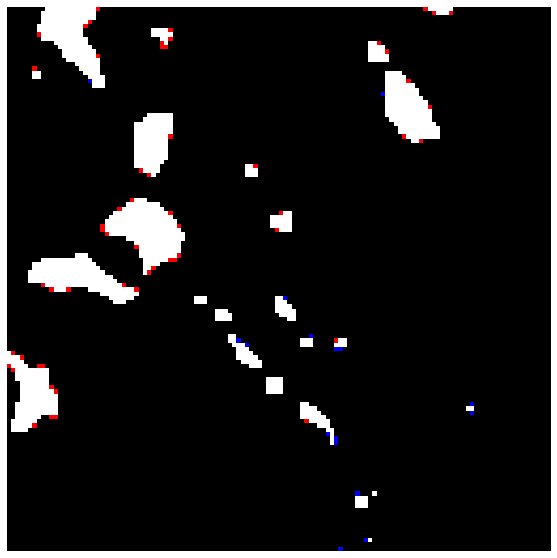

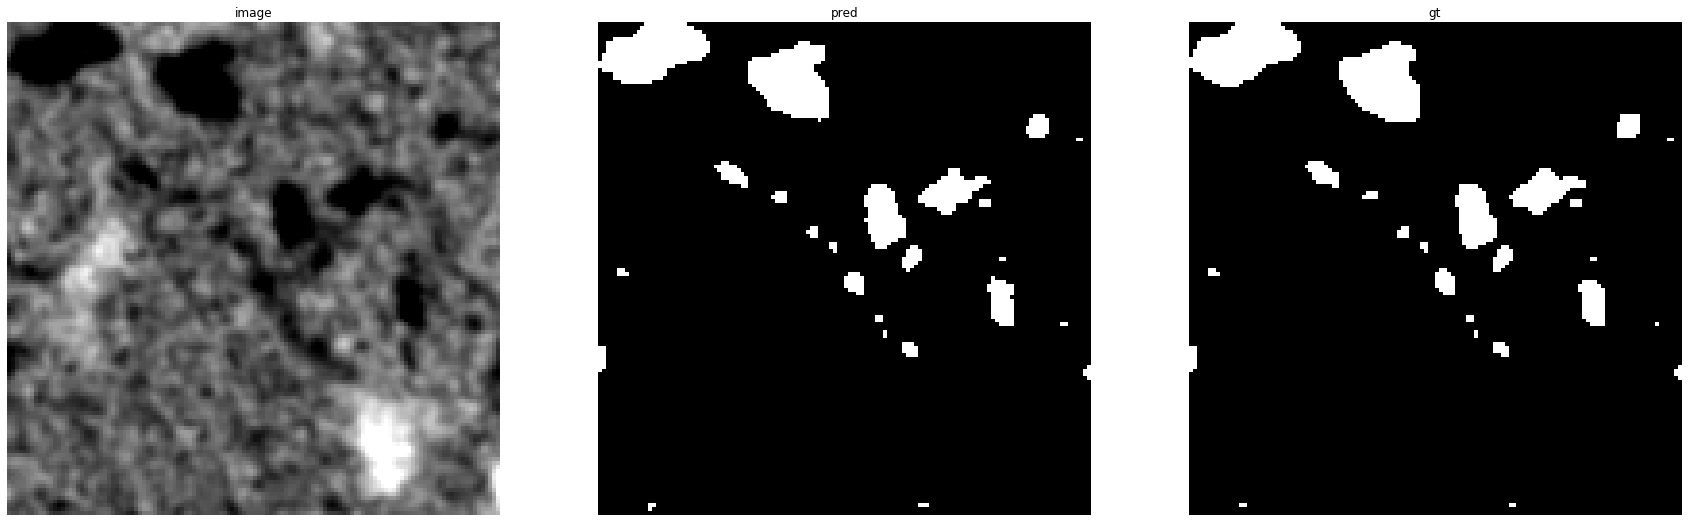

accuracy    : 0.99560546875
precision   : 0.9876106194690265
recall      : 0.9505962521294719
f1          : 0.9687499999999999
pr_auc      : 0.99481518028835
iou         : 0.9393939393939394


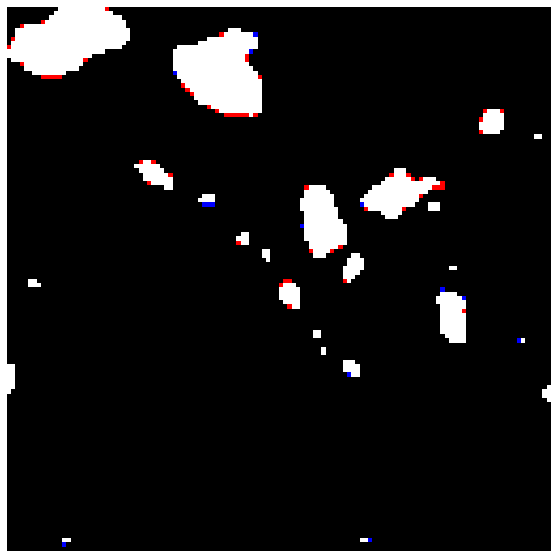

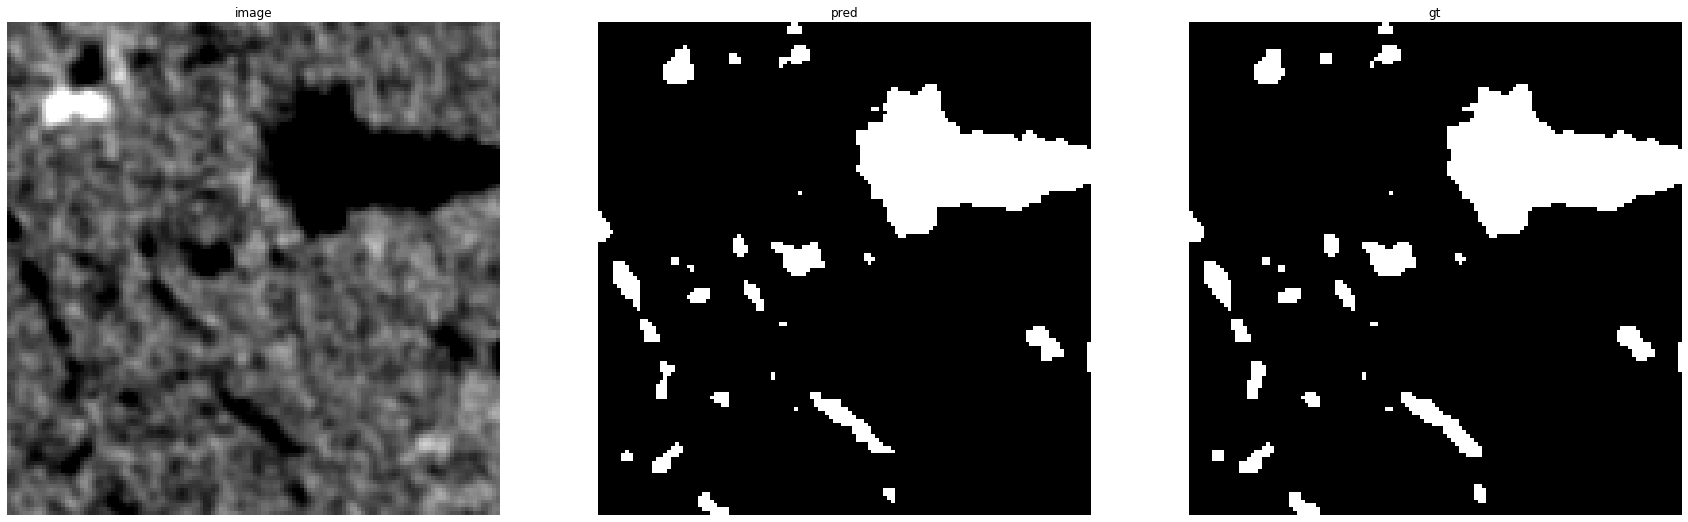

accuracy    : 0.99298095703125
precision   : 0.9938048528652556
recall      : 0.9492110453648915
f1          : 0.9709962168978562
pr_auc      : 0.9976439626244366
iou         : 0.9436274509803921


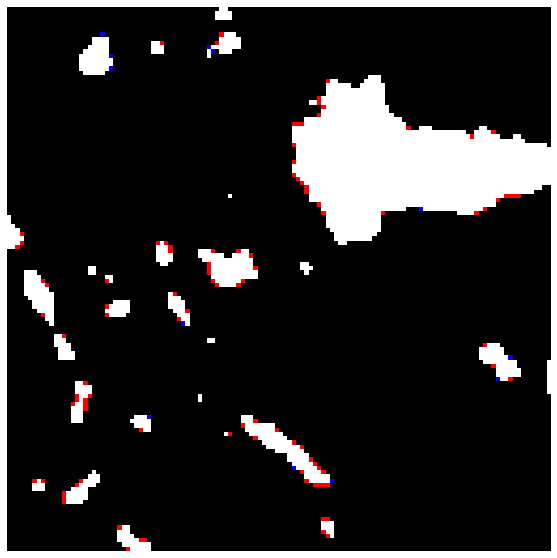

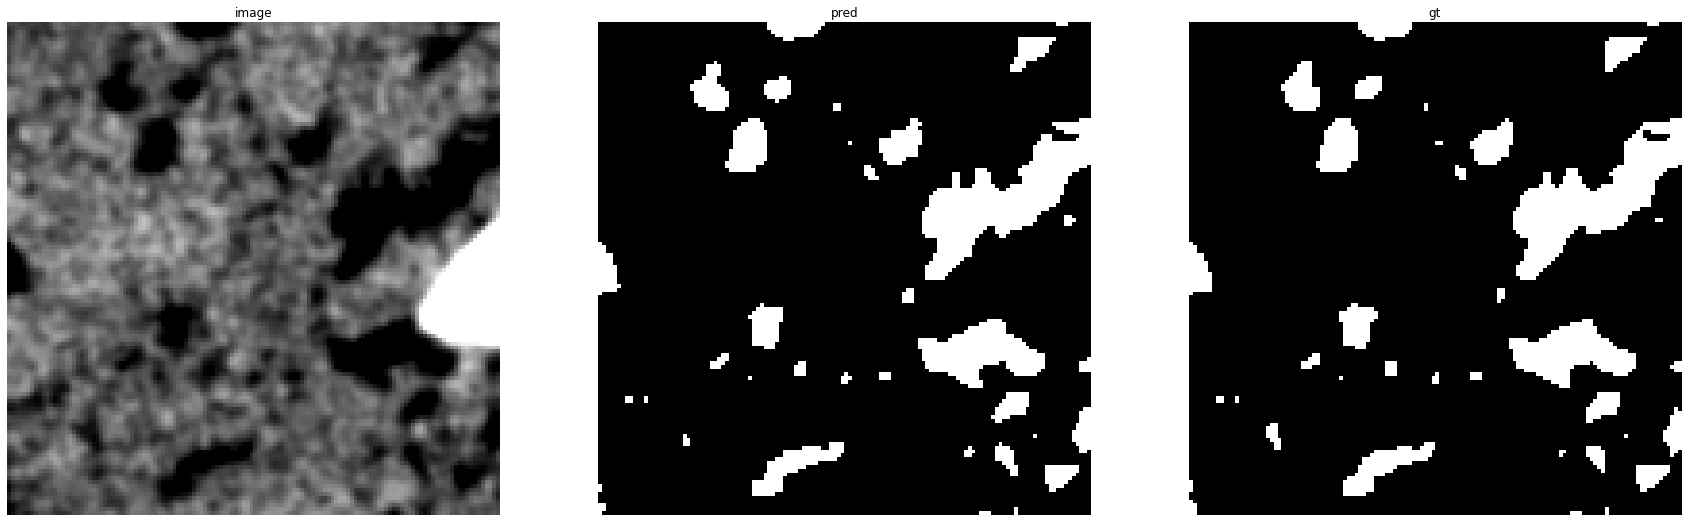

accuracy    : 0.99078369140625
precision   : 0.9652432969215492
recall      : 0.96
f1          : 0.9626145085417183
pr_auc      : 0.9938575004130887
iou         : 0.9279236276849642


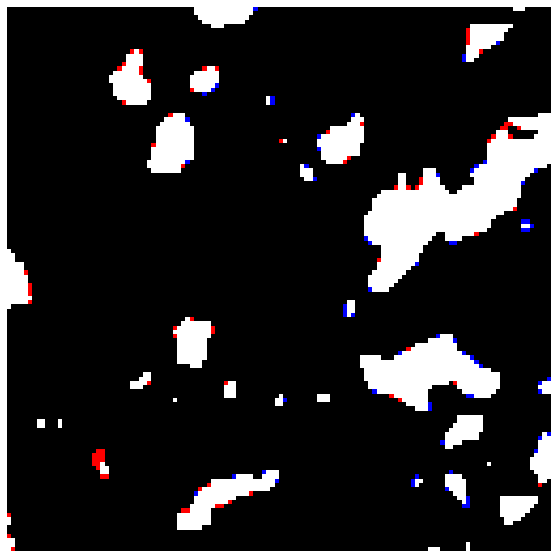

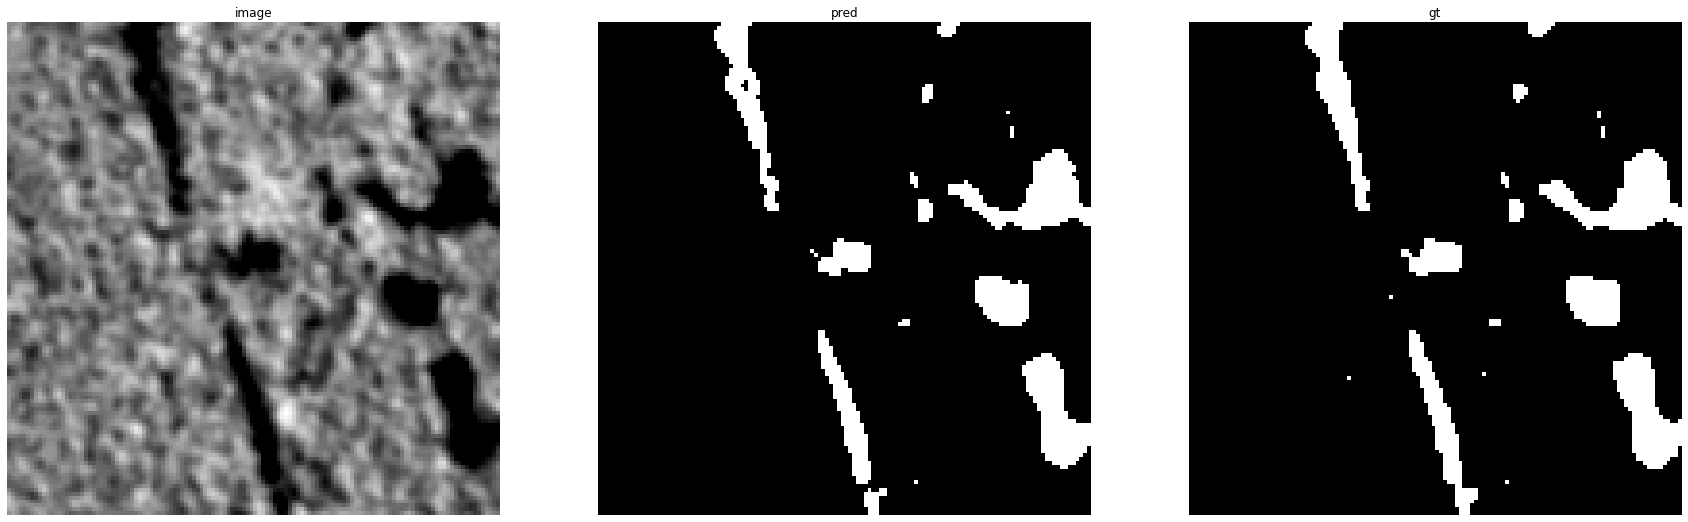

accuracy    : 0.9931640625
precision   : 0.9978601997146933
recall      : 0.9277188328912467
f1          : 0.961512027491409
pr_auc      : 0.9973030970655261
iou         : 0.9258769027134348


Prediction for Urna_22:


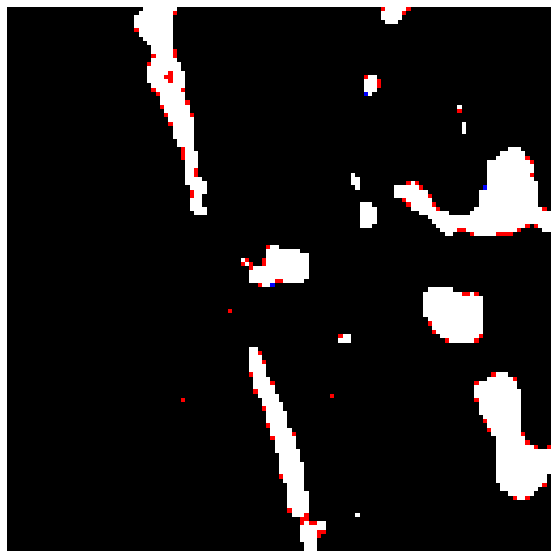

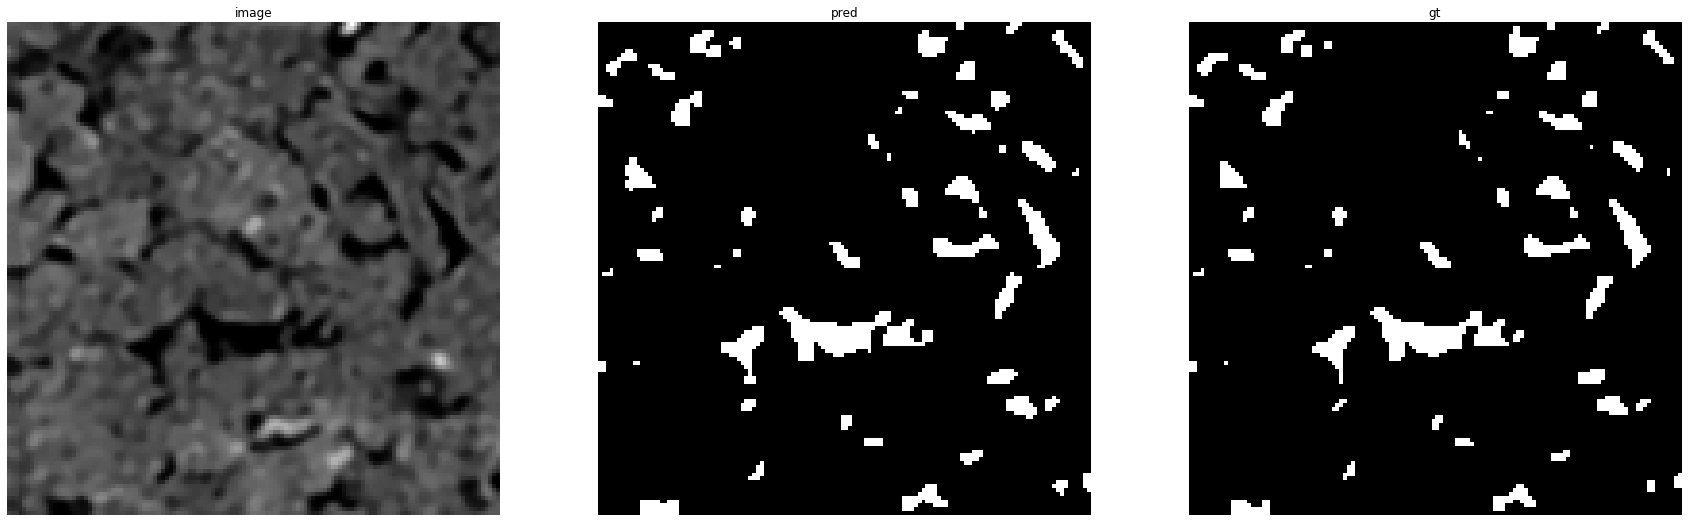

accuracy    : 0.99127197265625
precision   : 0.9004739336492891
recall      : 0.9853068280034573
f1          : 0.9409822534048701
pr_auc      : 0.9938917407240663
iou         : 0.8885424785658612


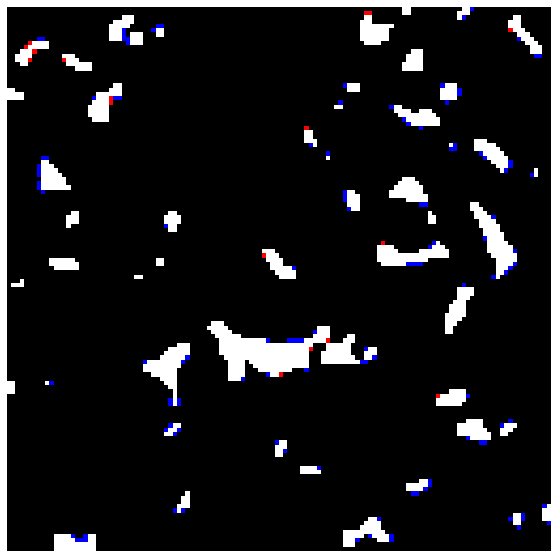

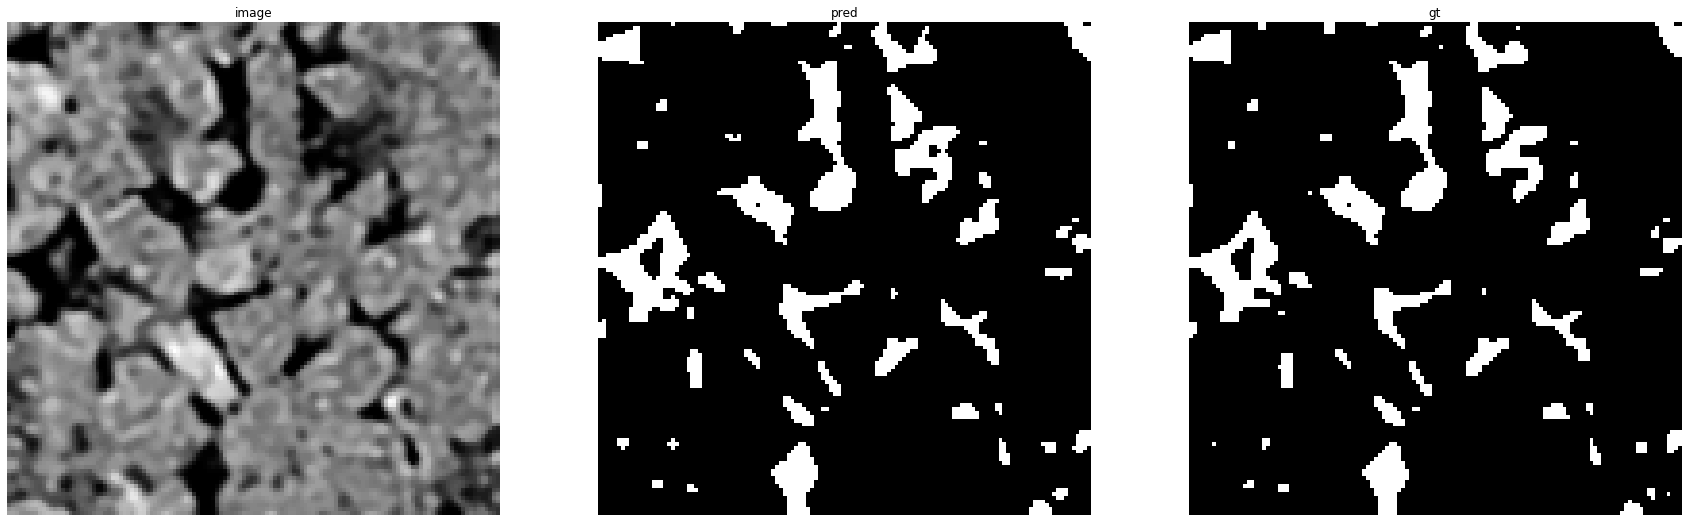

accuracy    : 0.98834228515625
precision   : 0.9170731707317074
recall      : 0.9889531825355077
f1          : 0.9516578081498356
pr_auc      : 0.9962339305968352
iou         : 0.9077740222114921


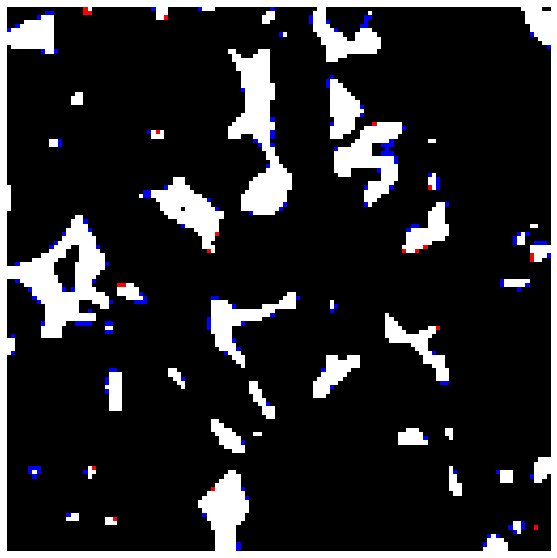

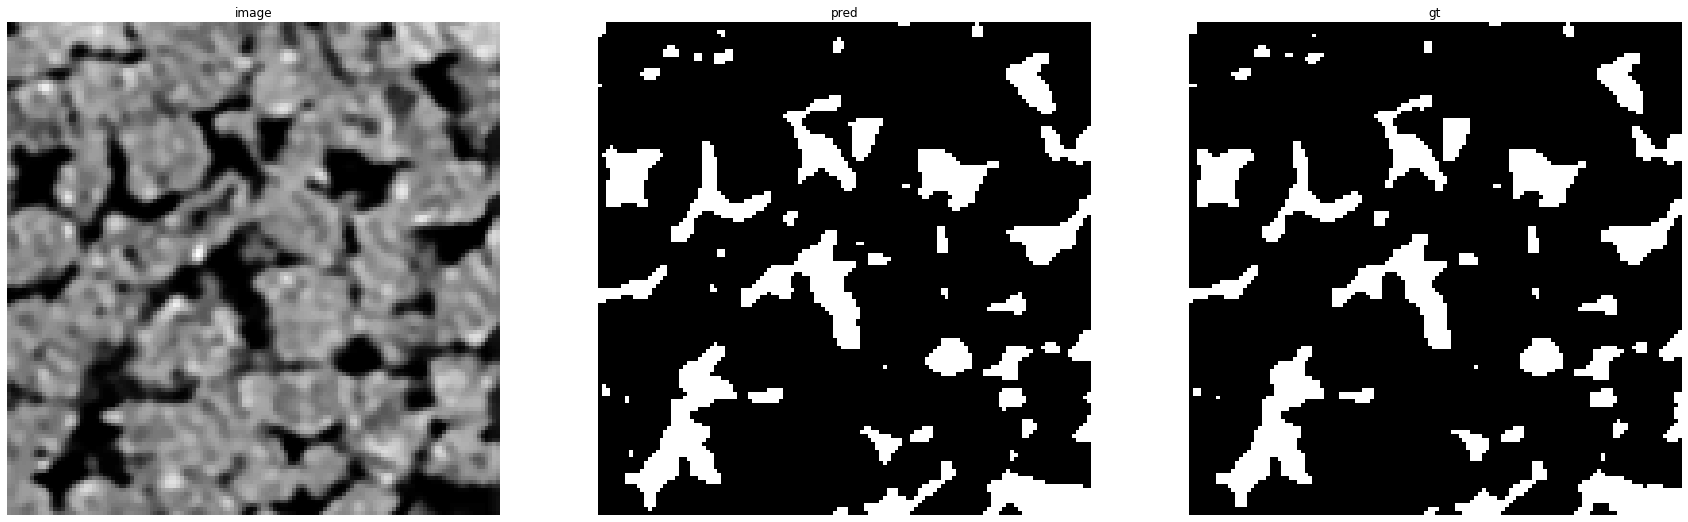

accuracy    : 0.9876708984375
precision   : 0.9389770723104056
recall      : 0.989223337049424
f1          : 0.9634455302207746
pr_auc      : 0.9968794580880338
iou         : 0.9294692737430168


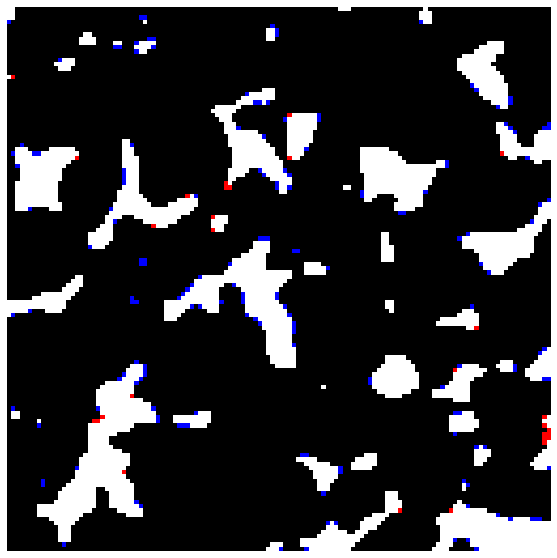

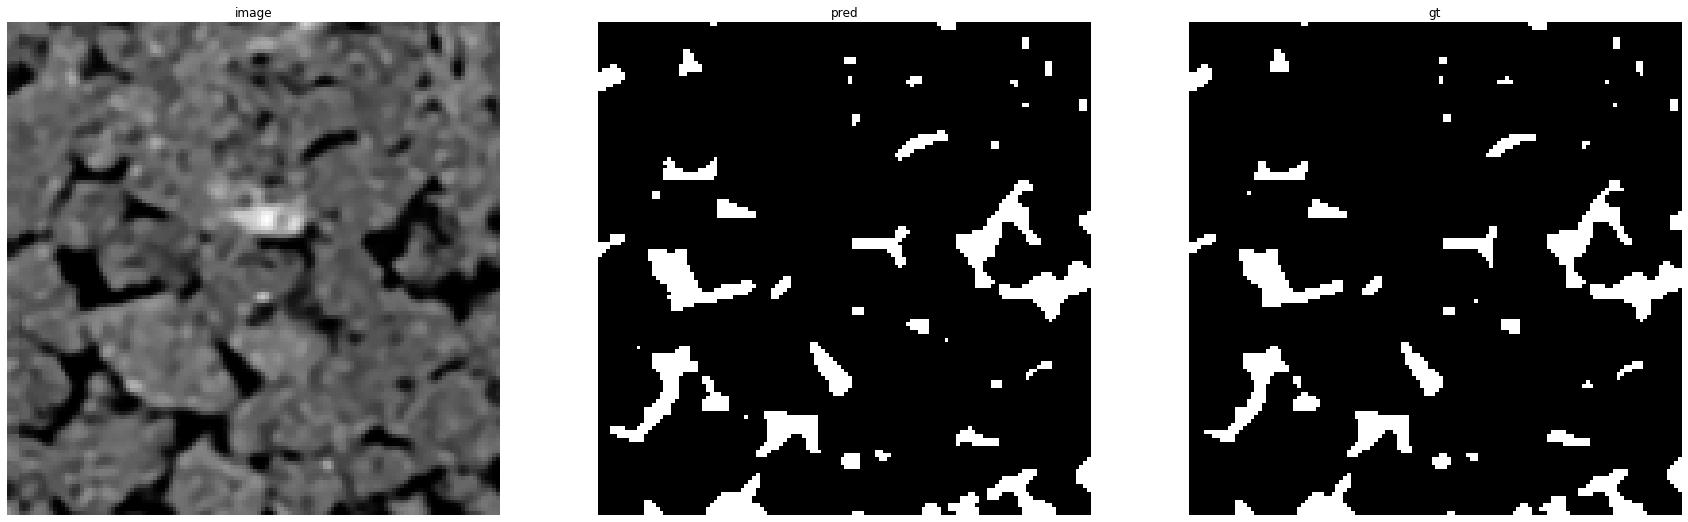

accuracy    : 0.99041748046875
precision   : 0.9126506024096386
recall      : 0.9921414538310412
f1          : 0.9507373705679323
pr_auc      : 0.9971896402343567
iou         : 0.9061004784688995


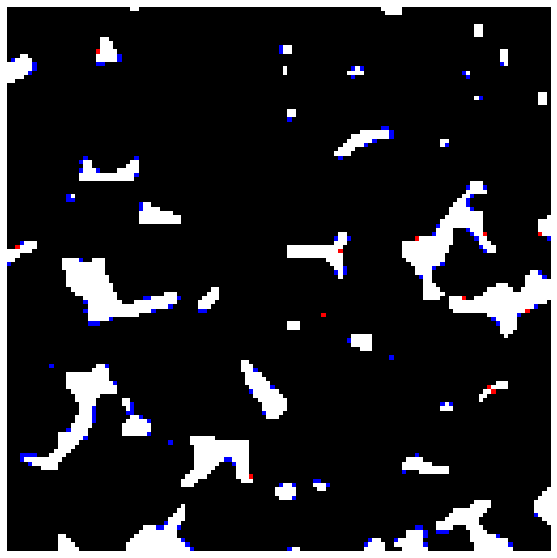

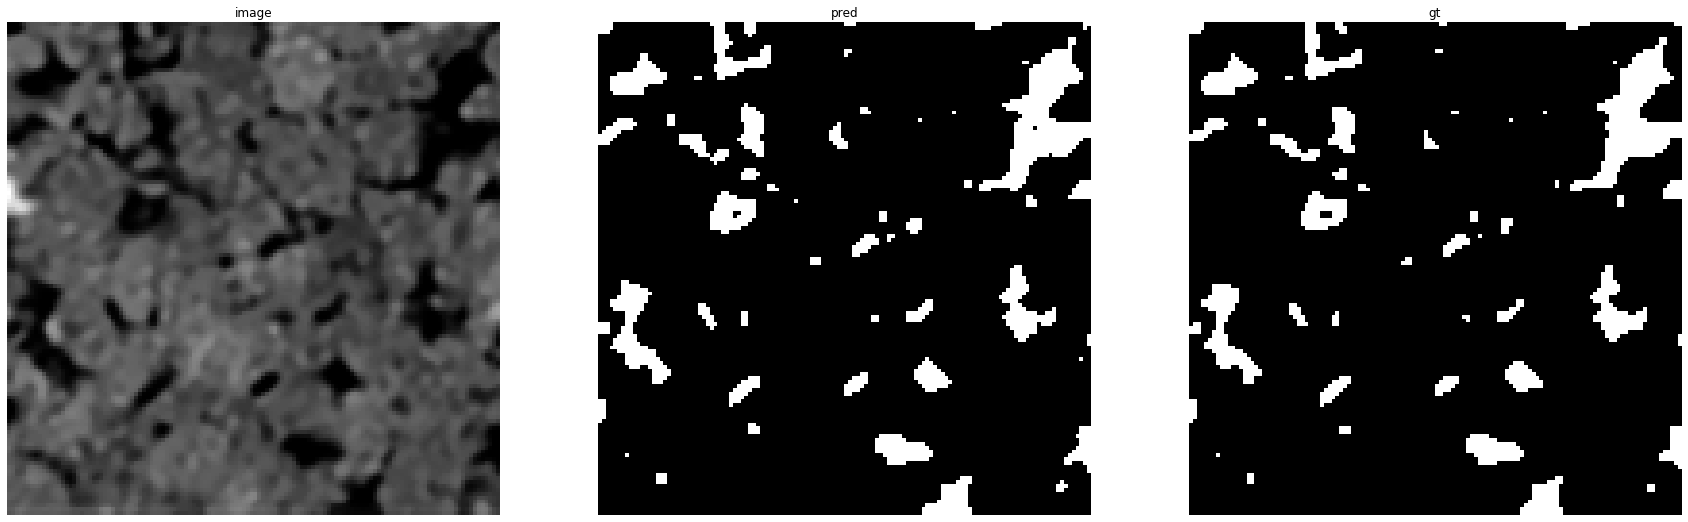

accuracy    : 0.99041748046875
precision   : 0.9201166180758017
recall      : 0.9874843554443054
f1          : 0.9526109266525806
pr_auc      : 0.995167888921891
iou         : 0.9095100864553314


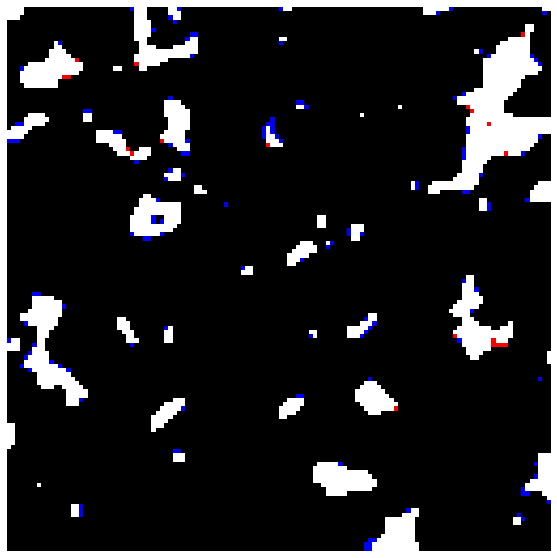

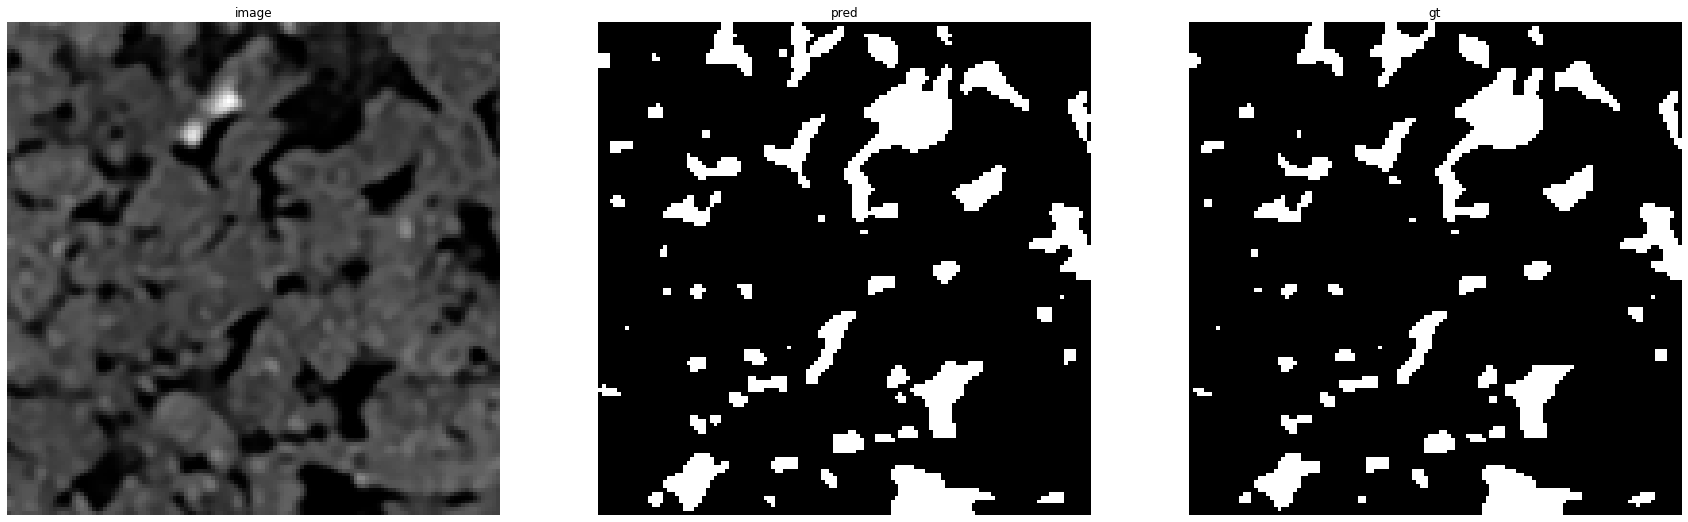

accuracy    : 0.986328125
precision   : 0.9253668763102726
recall      : 0.9795827785175322
f1          : 0.9517033203967228
pr_auc      : 0.995510920204588
iou         : 0.9078568490333196


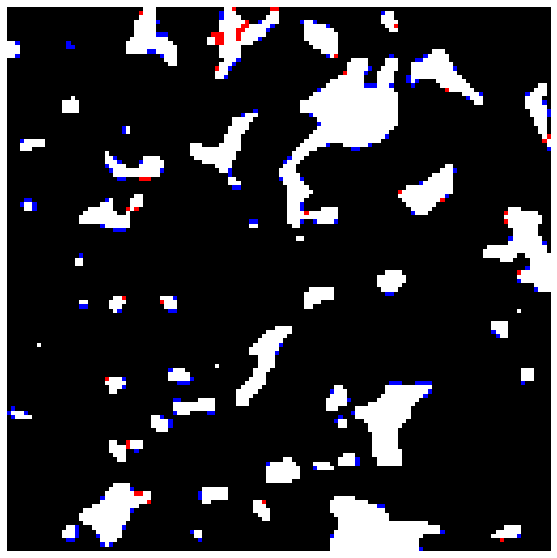

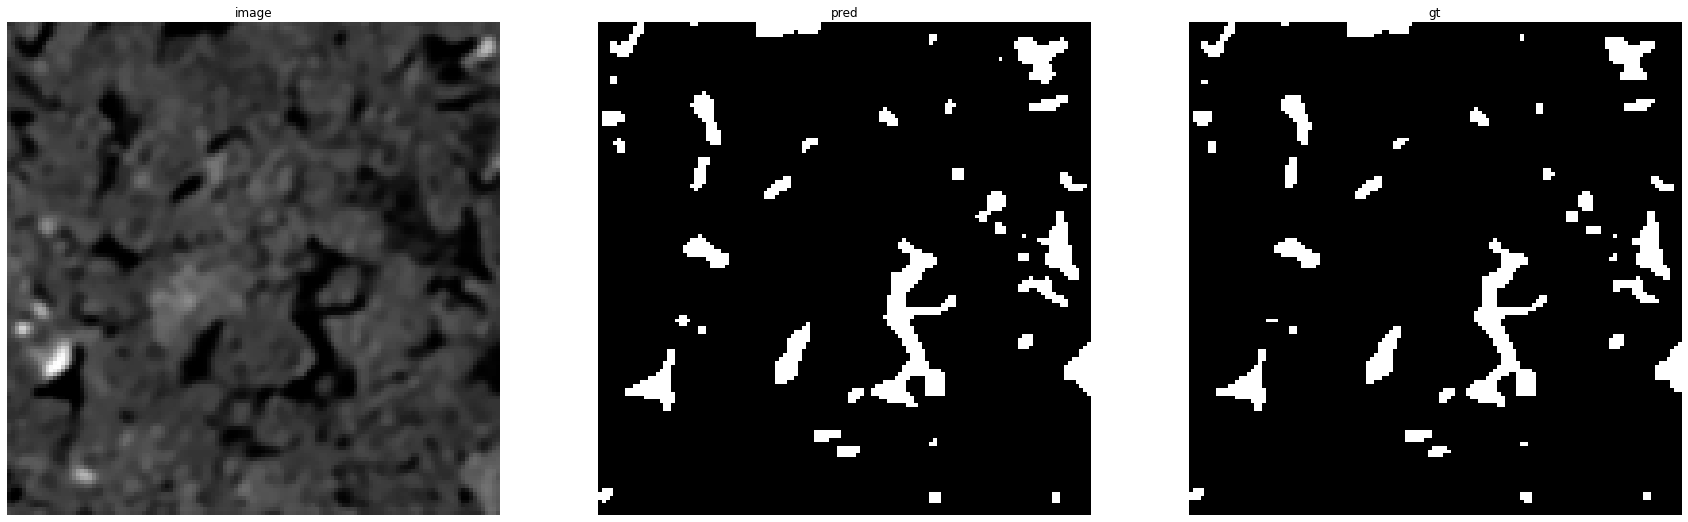

accuracy    : 0.99114990234375
precision   : 0.9028213166144201
recall      : 0.9820971867007673
f1          : 0.9407921600653328
pr_auc      : 0.9944669366845673
iou         : 0.8882035466461063


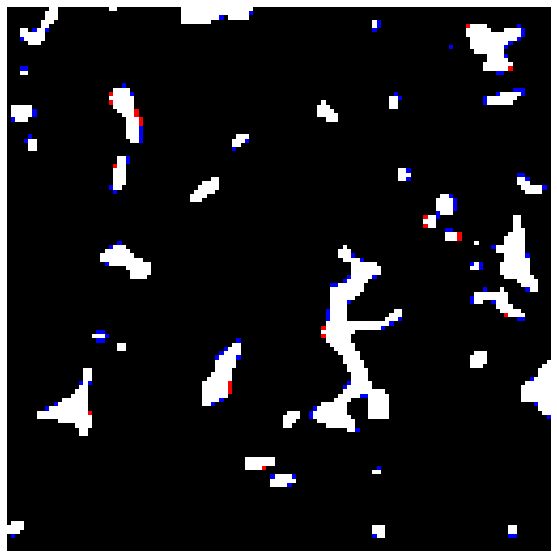

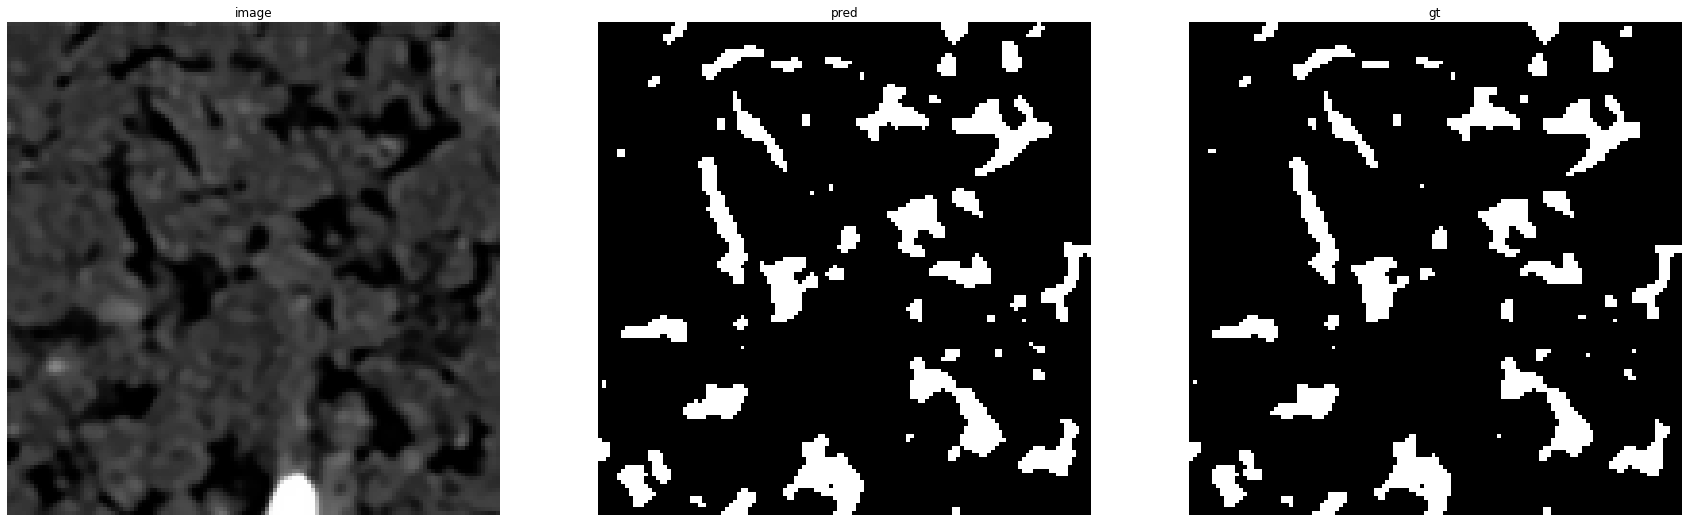

accuracy    : 0.98809814453125
precision   : 0.9227031802120141
recall      : 0.9905168326220958
f1          : 0.9554081865995885
pr_auc      : 0.9960937987199974
iou         : 0.9146234676007006


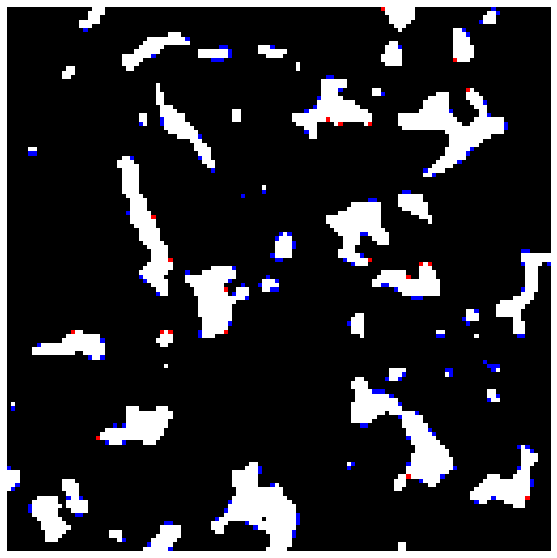

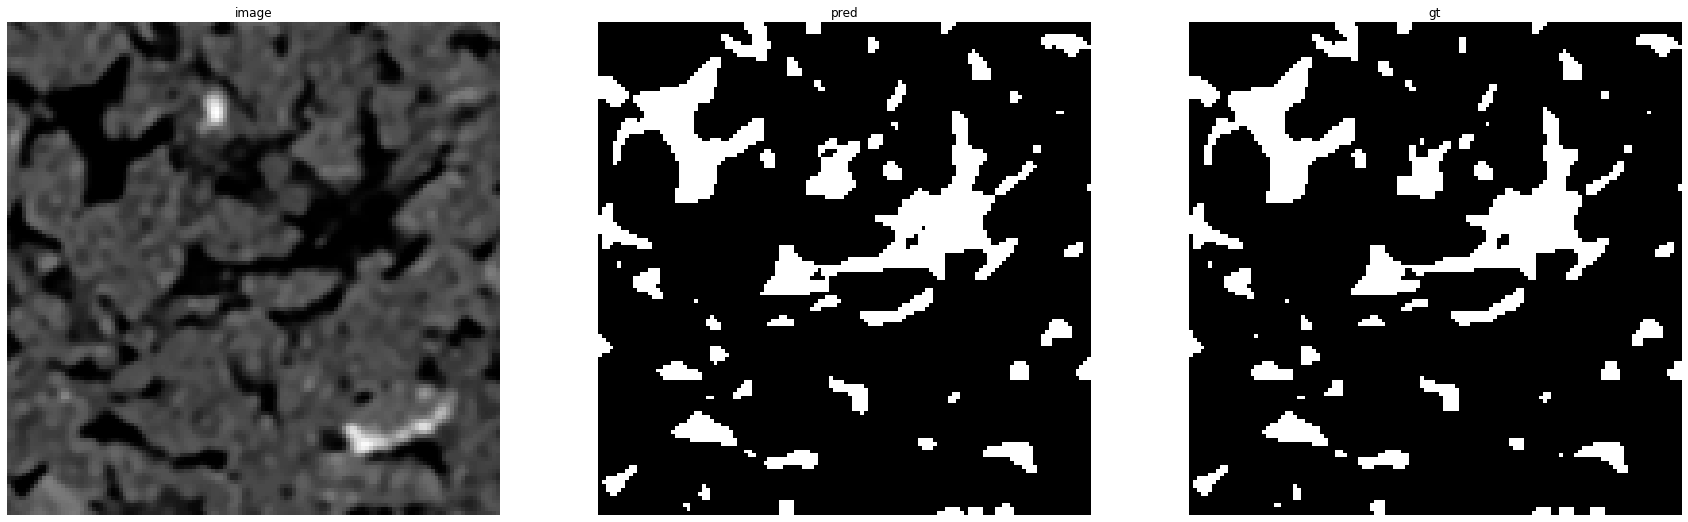

accuracy    : 0.990478515625
precision   : 0.9534615384615385
recall      : 0.9860779634049324
f1          : 0.9694955025420414
pr_auc      : 0.9976602287399396
iou         : 0.9407969639468691


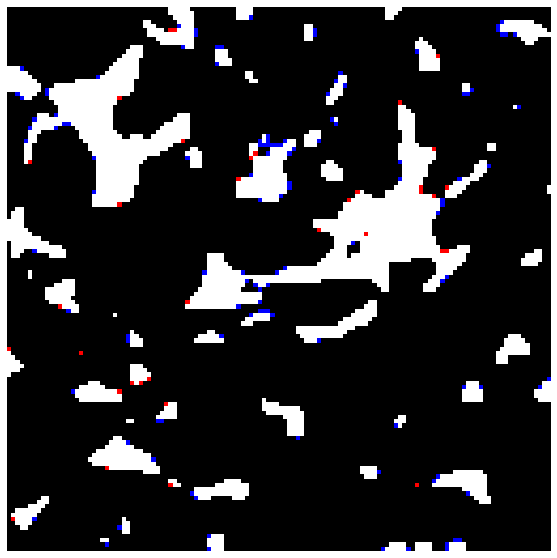

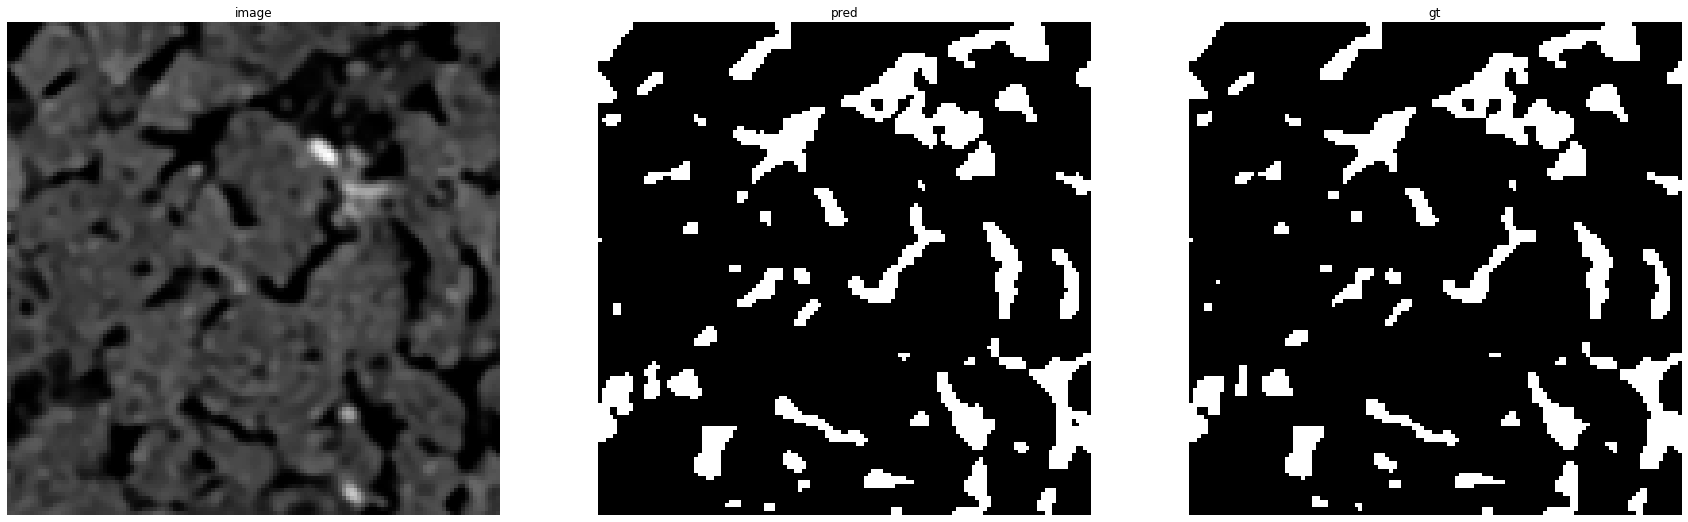

accuracy    : 0.986572265625
precision   : 0.9300114111829593
recall      : 0.9854897218863361
f1          : 0.9569471624266144
pr_auc      : 0.9960484282615014
iou         : 0.9174484052532833


Prediction for Urna_30:


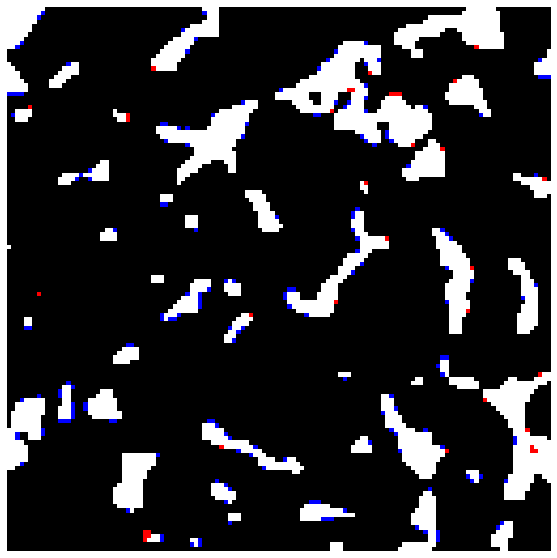

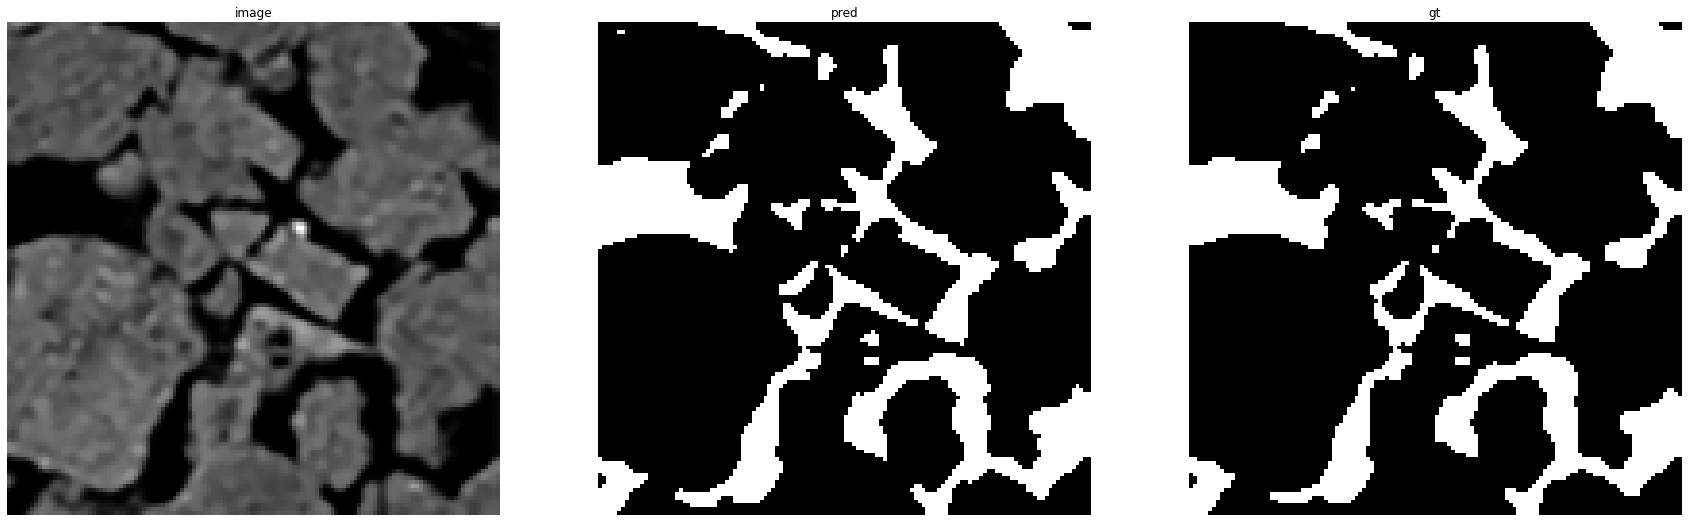

accuracy    : 0.9893798828125
precision   : 0.9598271039918638
recall      : 0.9957794777103667
f1          : 0.9774728120145003
pr_auc      : 0.9990302105459942
iou         : 0.9559382122056217


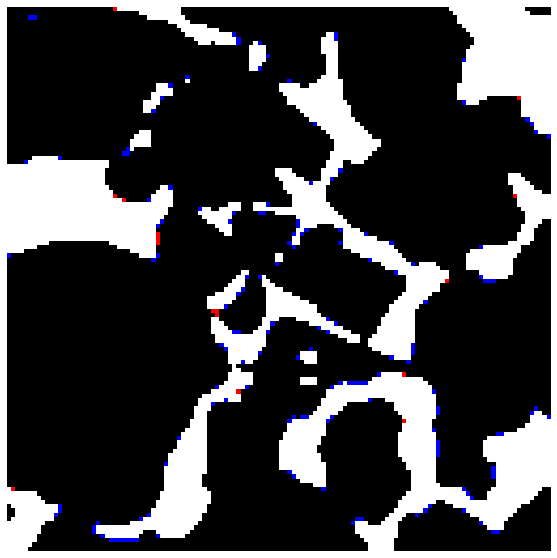

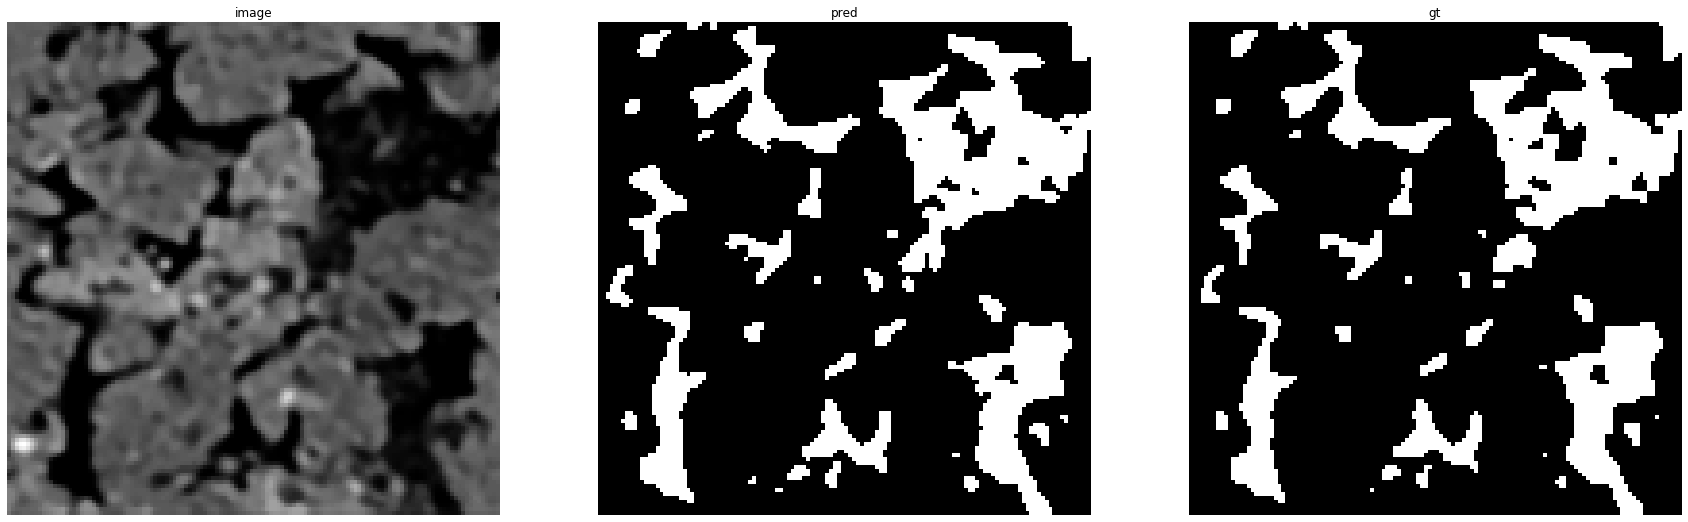

accuracy    : 0.98175048828125
precision   : 0.9338313767342583
recall      : 0.9856378484933821
f1          : 0.9590354843129196
pr_auc      : 0.9965255303045342
iou         : 0.9212950776520137


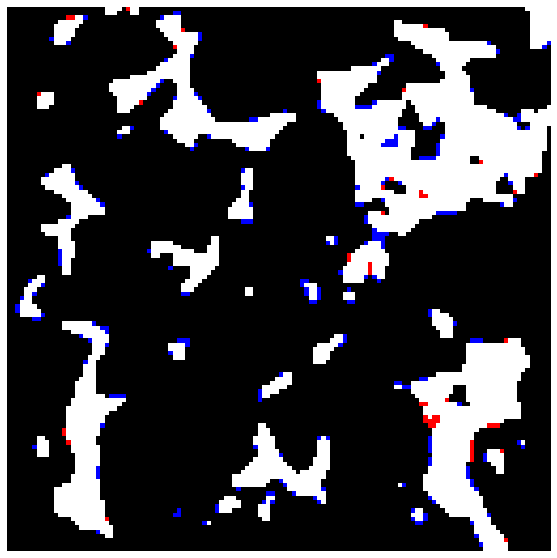

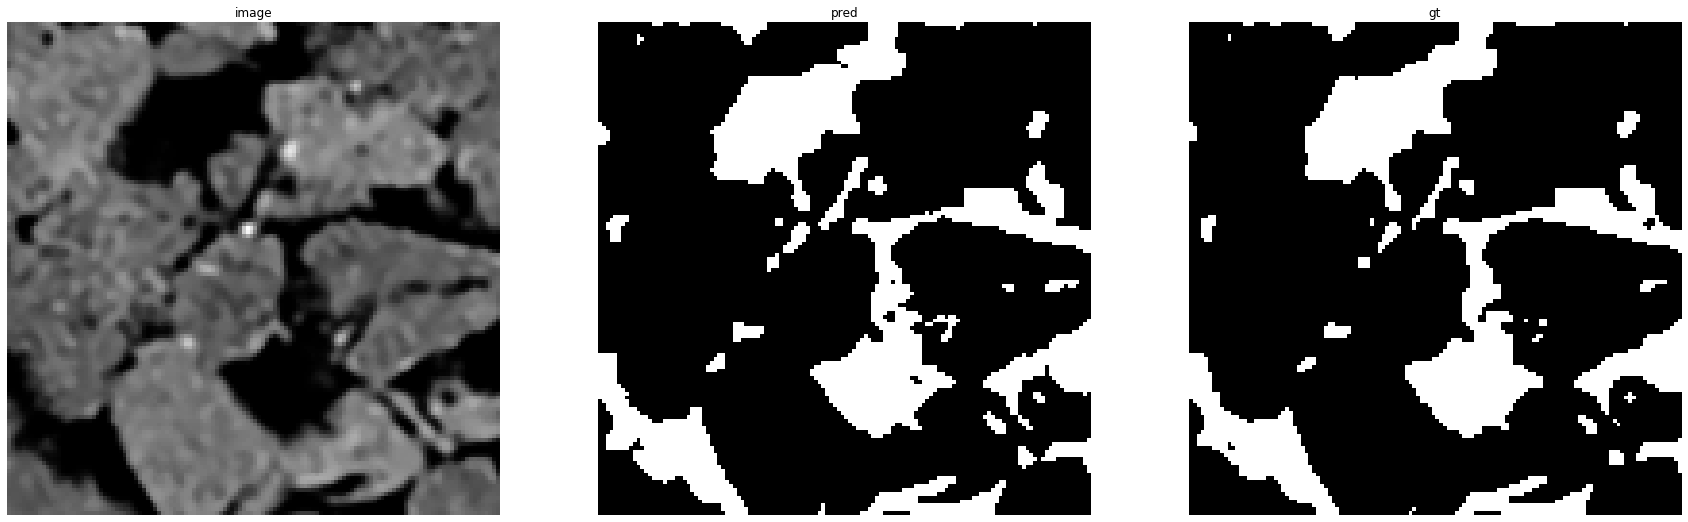

accuracy    : 0.985107421875
precision   : 0.9485868102288022
recall      : 0.9851831143416271
f1          : 0.9665386725178278
pr_auc      : 0.9976188156227634
iou         : 0.935244161358811


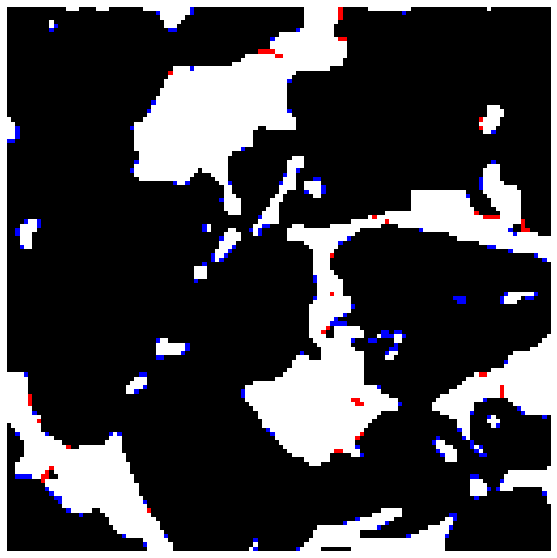

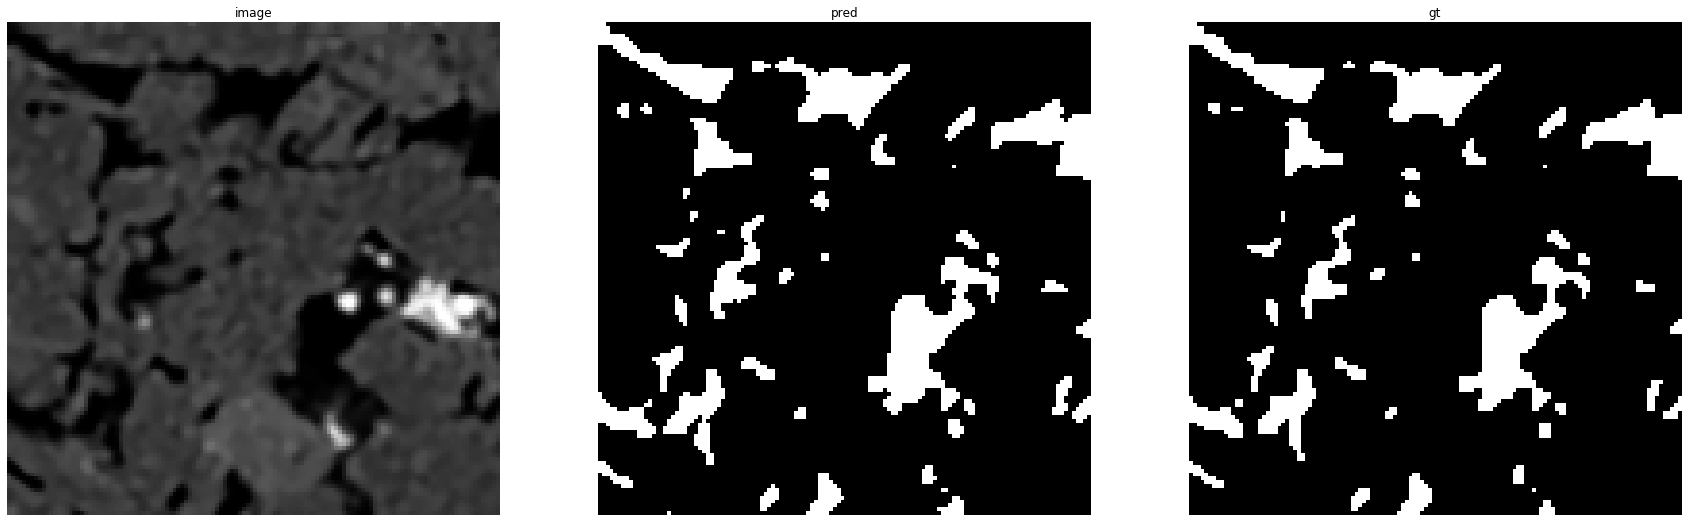

accuracy    : 0.98675537109375
precision   : 0.9172770357604481
recall      : 0.9883936861652739
f1          : 0.9515083798882681
pr_auc      : 0.9960778800243013
iou         : 0.9075021312872975


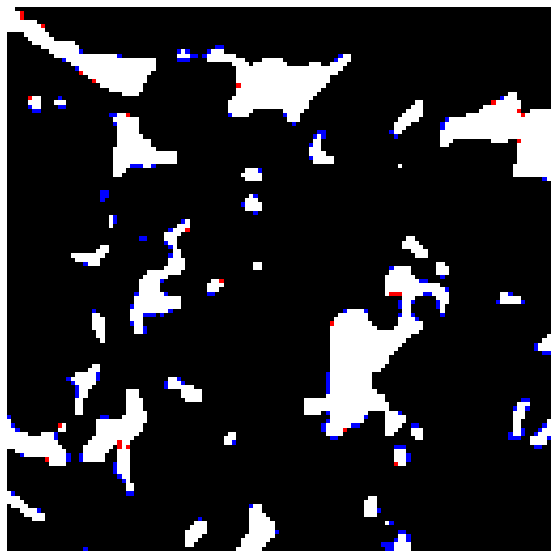

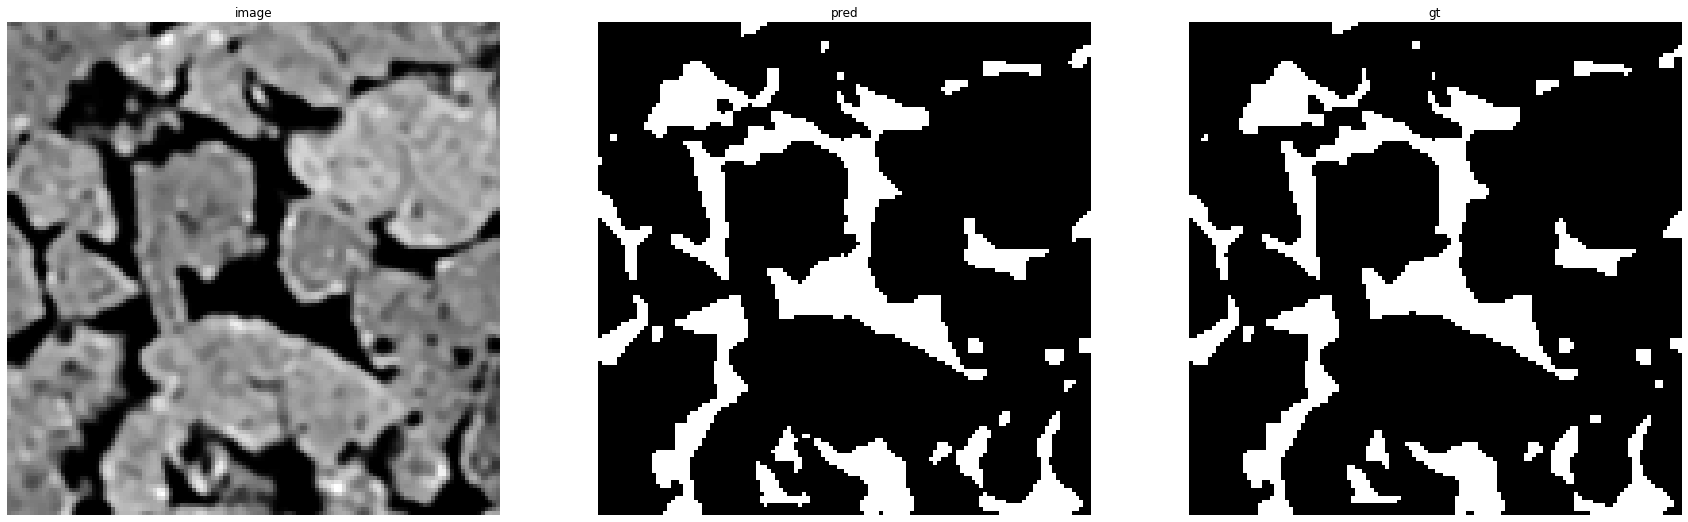

accuracy    : 0.98565673828125
precision   : 0.9347951529140219
recall      : 0.997229916897507
f1          : 0.9650037230081907
pr_auc      : 0.9984981489443855
iou         : 0.9323741007194245


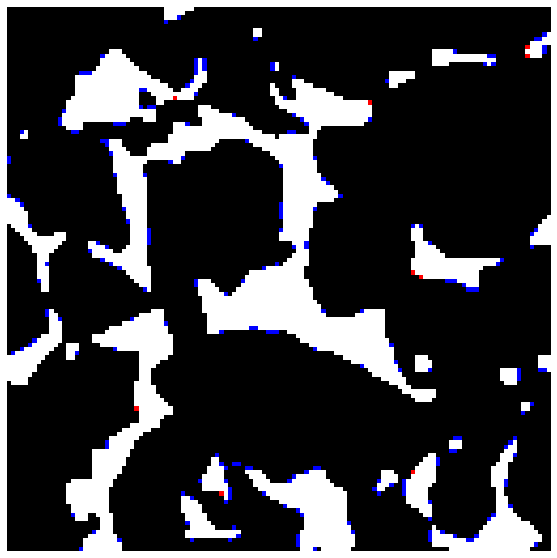

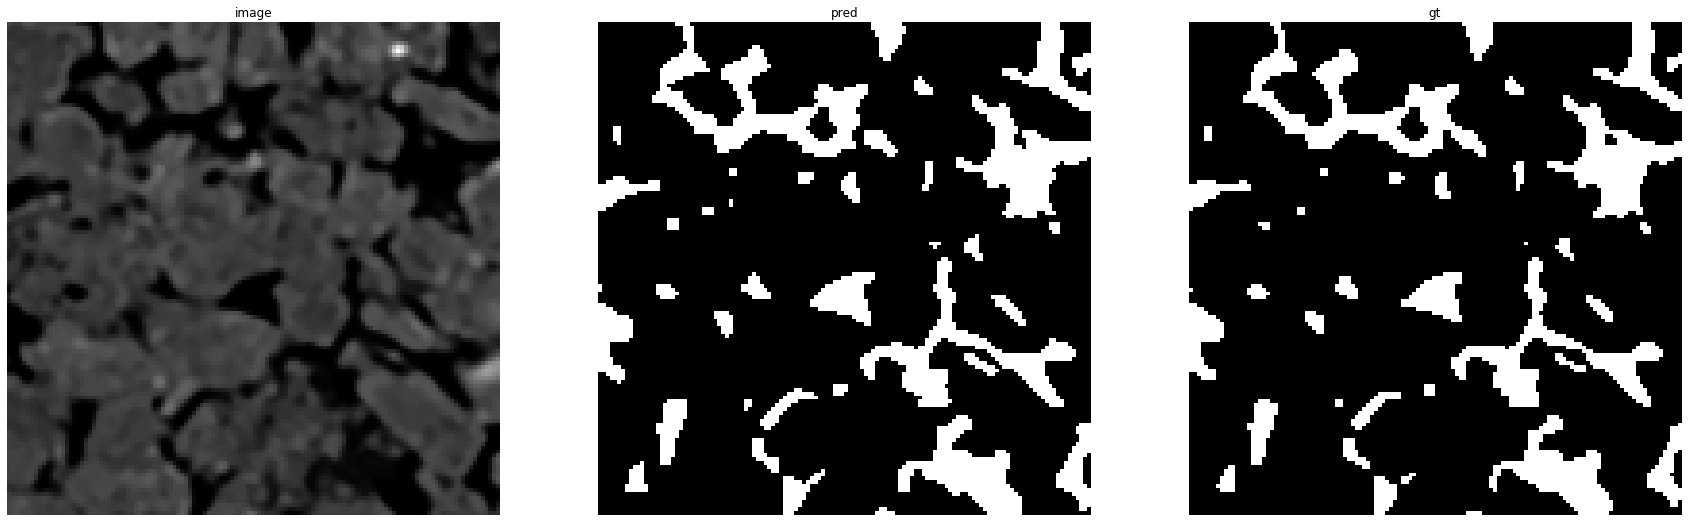

accuracy    : 0.9833984375
precision   : 0.9197707736389685
recall      : 0.993124785149536
f1          : 0.9550413223140496
pr_auc      : 0.9967575426723193
iou         : 0.9139512812401139


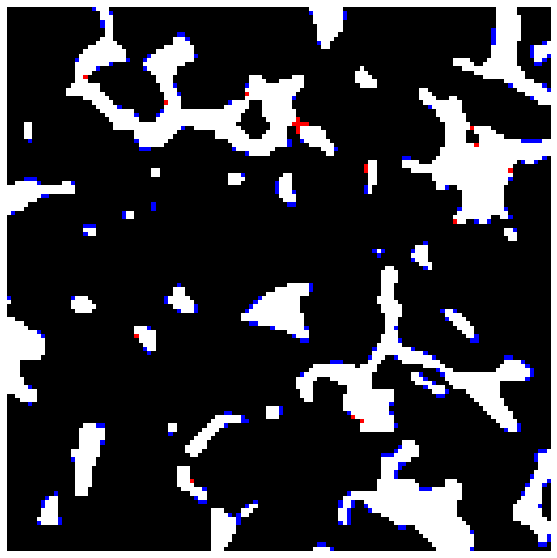

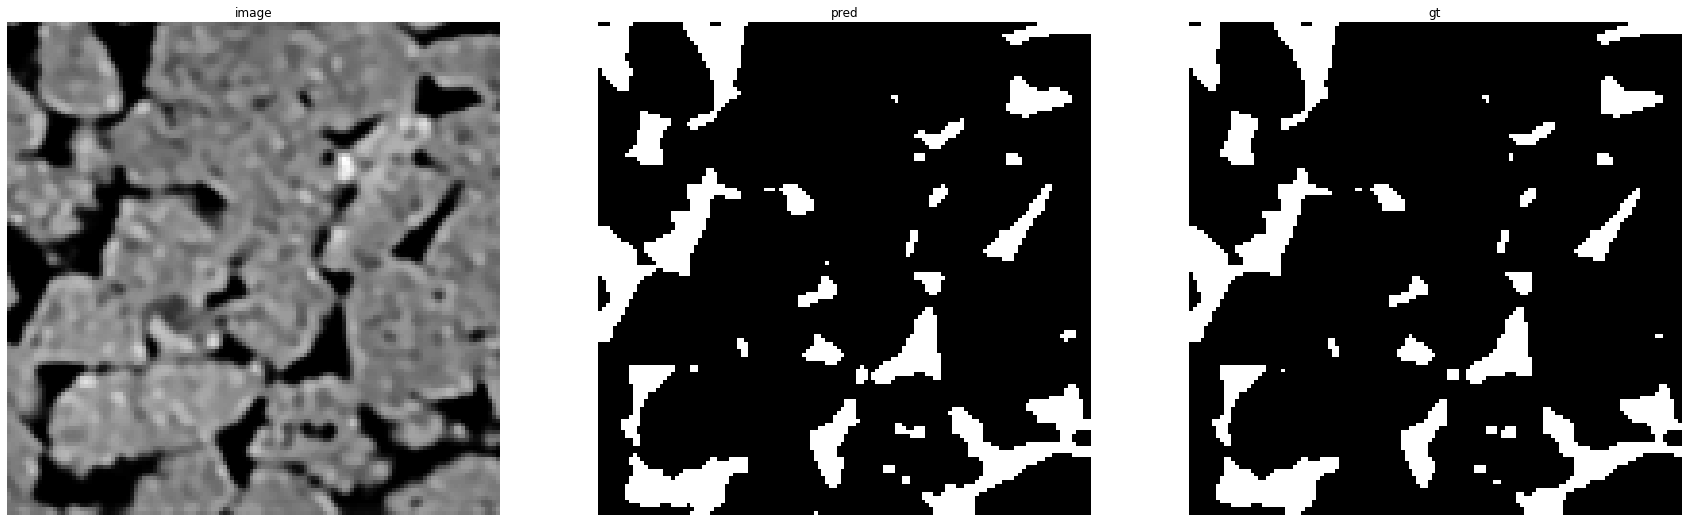

accuracy    : 0.98956298828125
precision   : 0.9400444115470022
recall      : 0.9964692036092585
f1          : 0.9674347743286993
pr_auc      : 0.9983635772890616
iou         : 0.9369236444116562


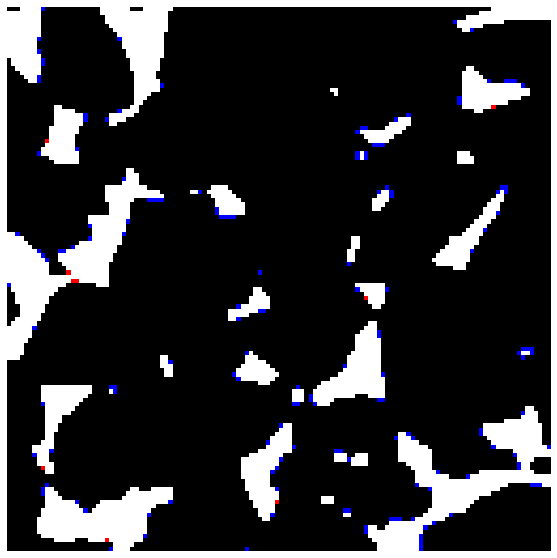

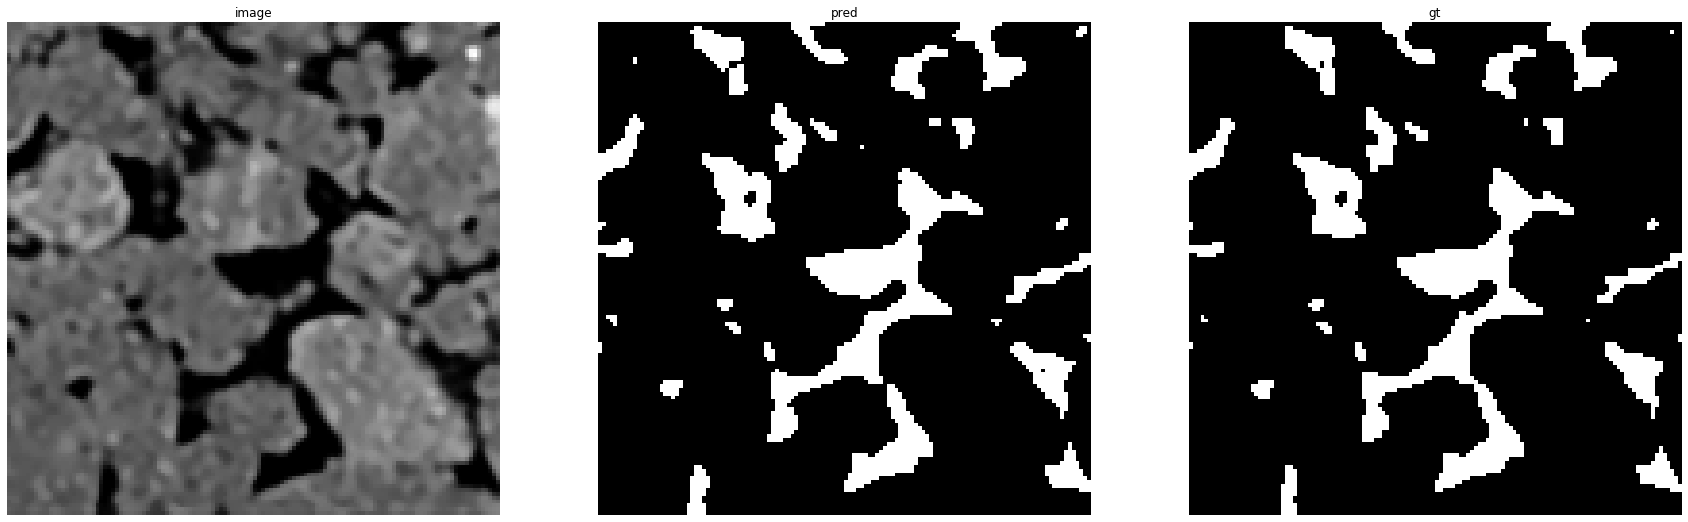

accuracy    : 0.9896240234375
precision   : 0.9411764705882353
recall      : 0.9893390191897654
f1          : 0.9646569646569647
pr_auc      : 0.9971964842504669
iou         : 0.9317269076305221


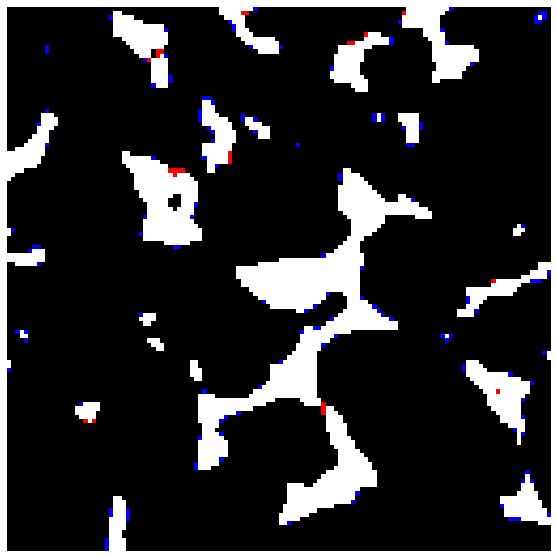

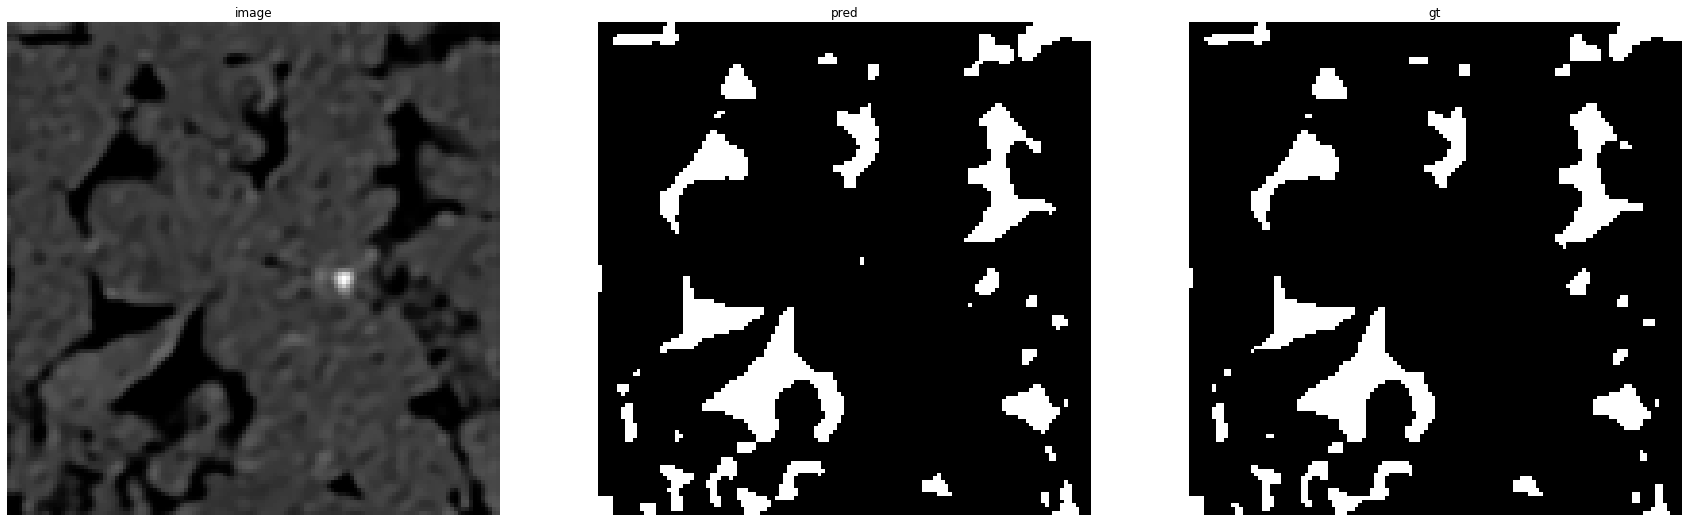

accuracy    : 0.98968505859375
precision   : 0.932258064516129
recall      : 0.9892420537897311
f1          : 0.9599051008303676
pr_auc      : 0.996385868335938
iou         : 0.9229014598540146


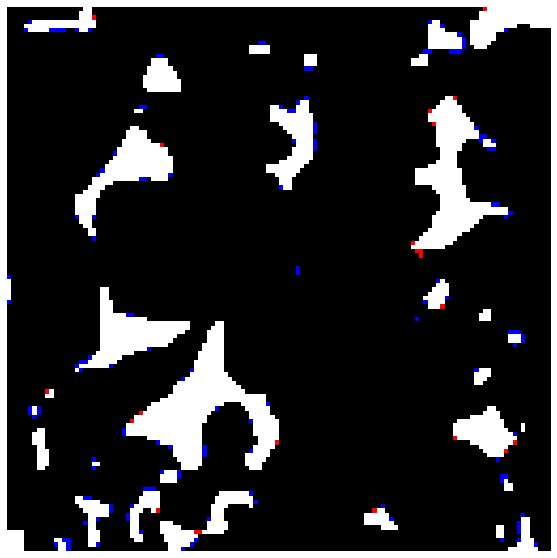

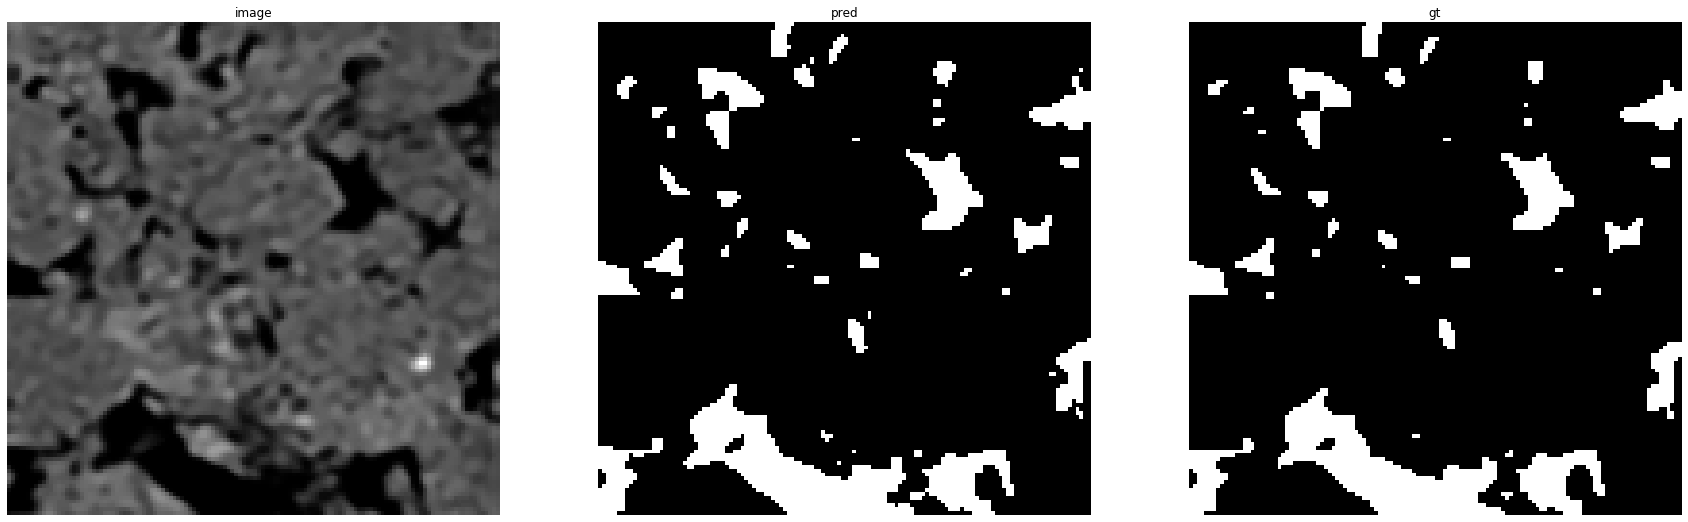

accuracy    : 0.98895263671875
precision   : 0.9297465540240106
recall      : 0.989120151371807
f1          : 0.9585147834059132
pr_auc      : 0.9967726744467479
iou         : 0.9203345070422535


Prediction for Urna_34:


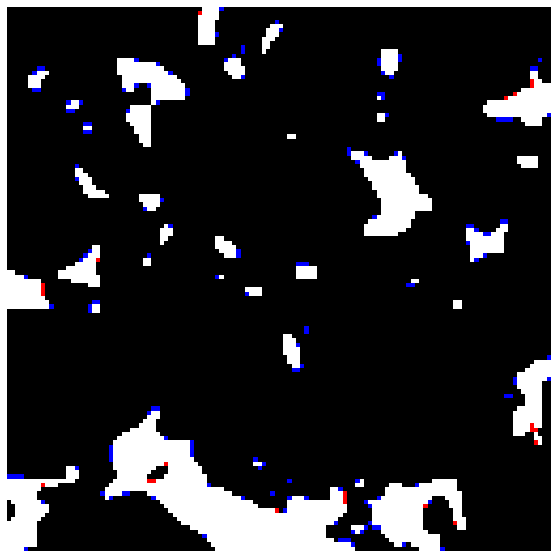

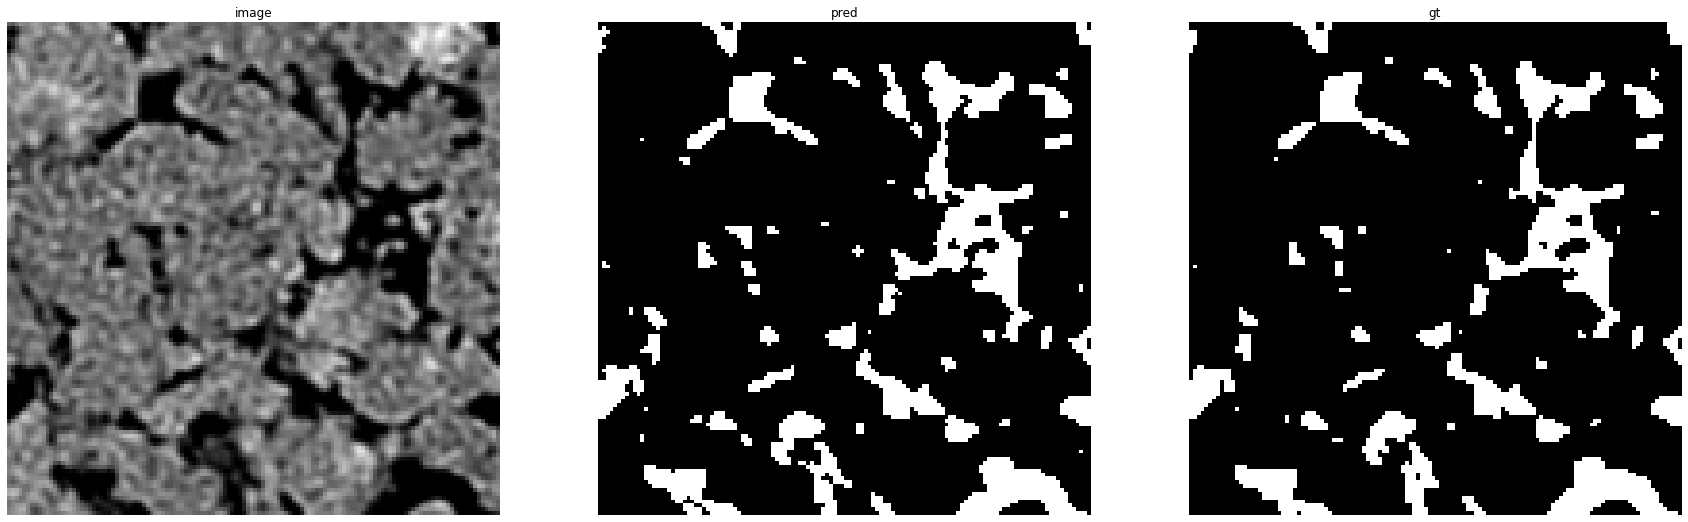

accuracy    : 0.98223876953125
precision   : 0.9162754303599374
recall      : 0.9681686647374949
f1          : 0.9415075376884422
pr_auc      : 0.9911165398102122
iou         : 0.8894796809722749


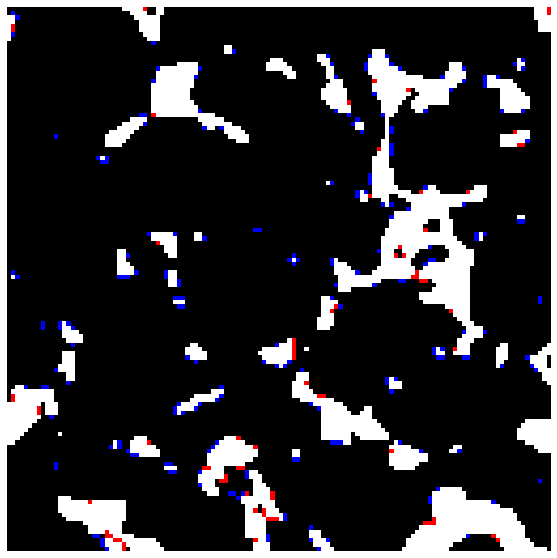

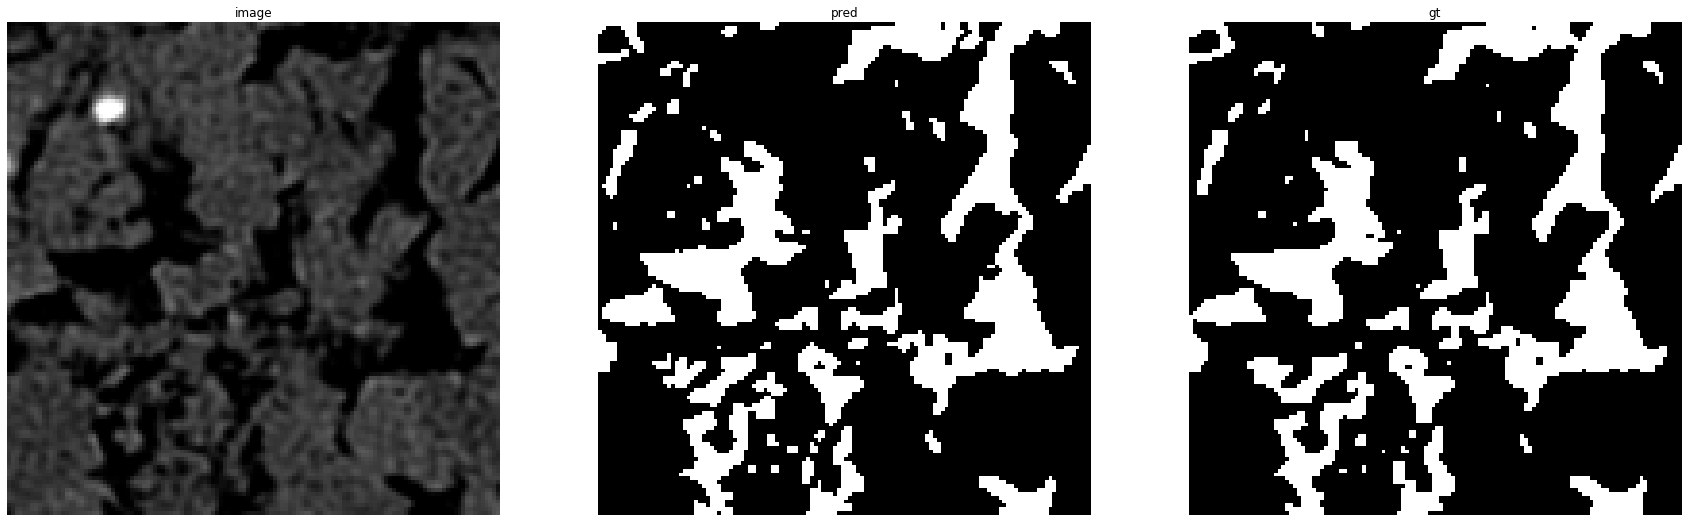

accuracy    : 0.97589111328125
precision   : 0.949853228962818
recall      : 0.9533513380800392
f1          : 0.9515990687415757
pr_auc      : 0.9926807749339627
iou         : 0.907667134174848


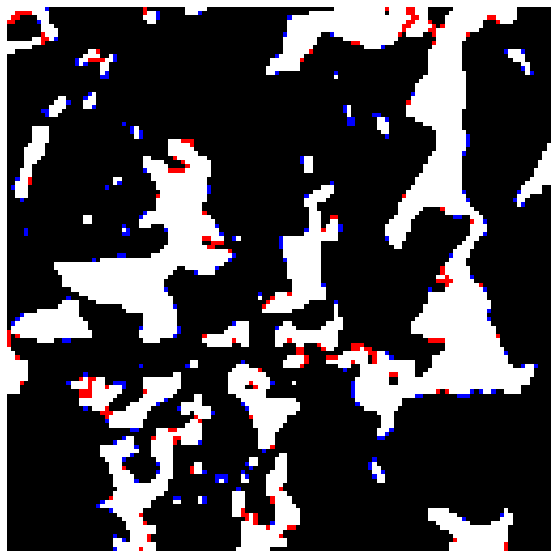

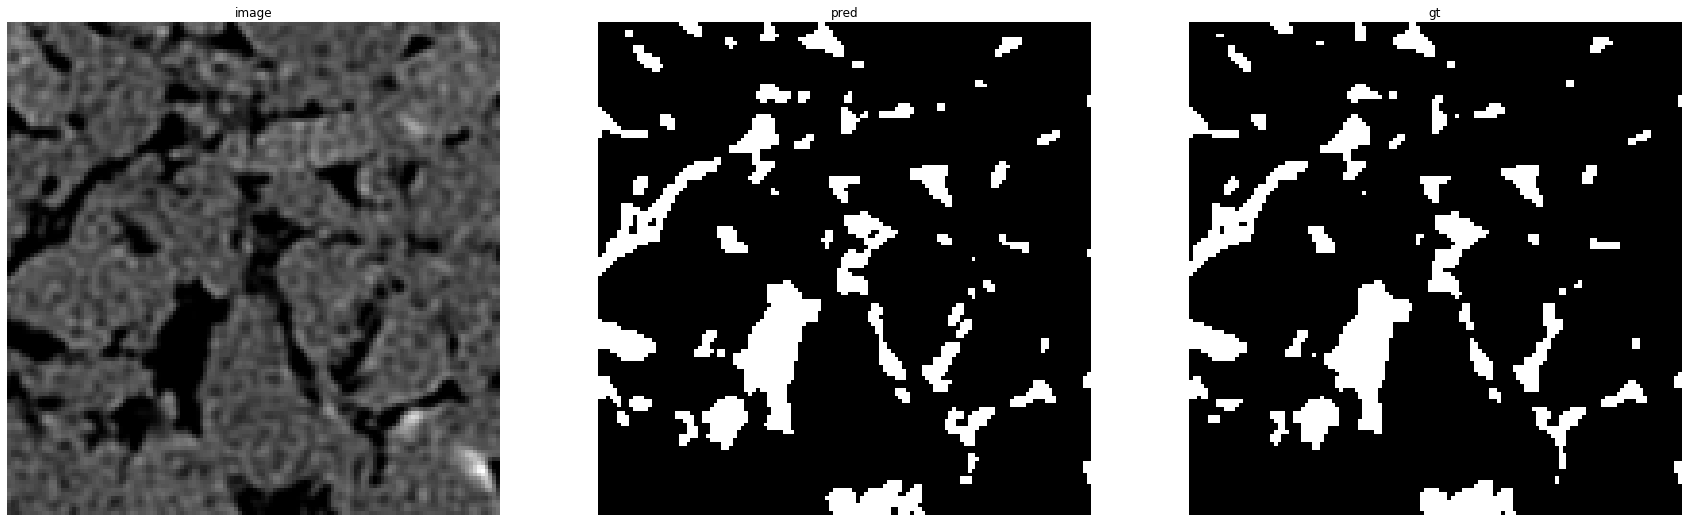

accuracy    : 0.98236083984375
precision   : 0.9059340659340659
recall      : 0.9648876404494382
f1          : 0.9344819768759919
pr_auc      : 0.9890966711412541
iou         : 0.8770212765957447


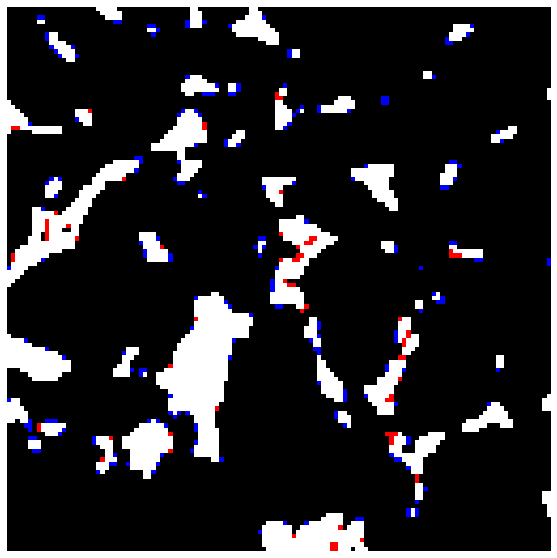

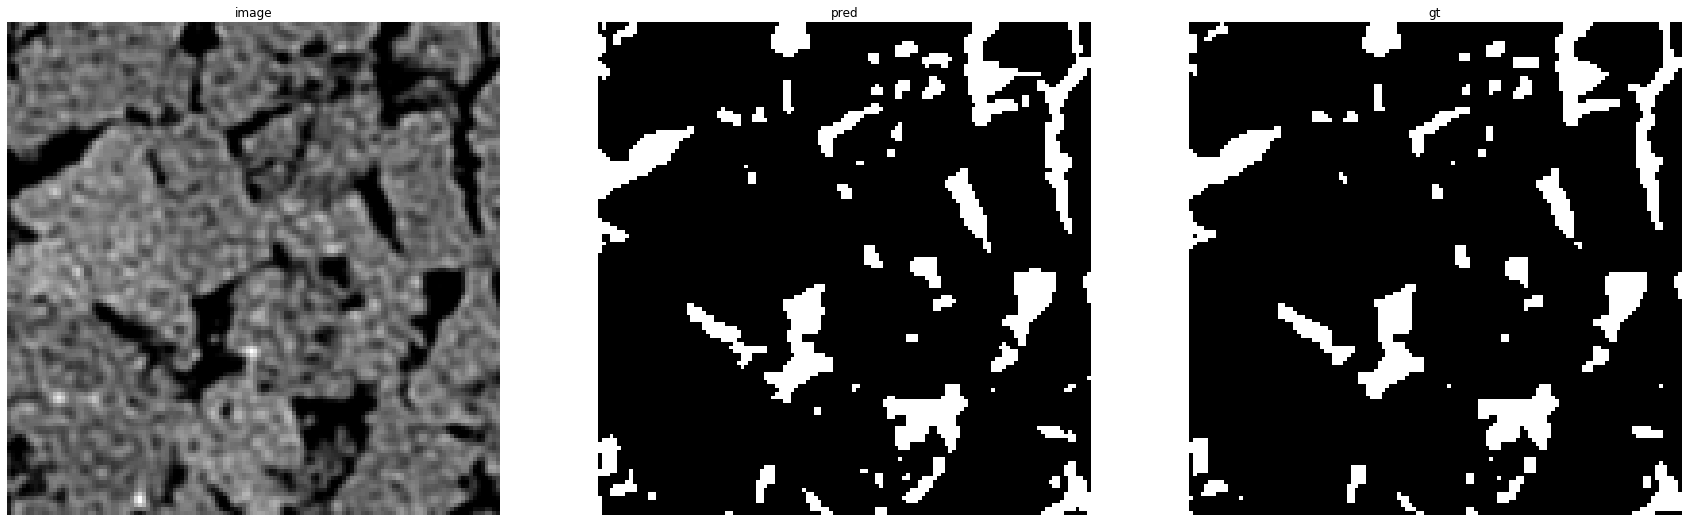

accuracy    : 0.98138427734375
precision   : 0.8956483126110124
recall      : 0.9664590321034978
f1          : 0.9297073058308366
pr_auc      : 0.9898400553874975
iou         : 0.8686477174849268


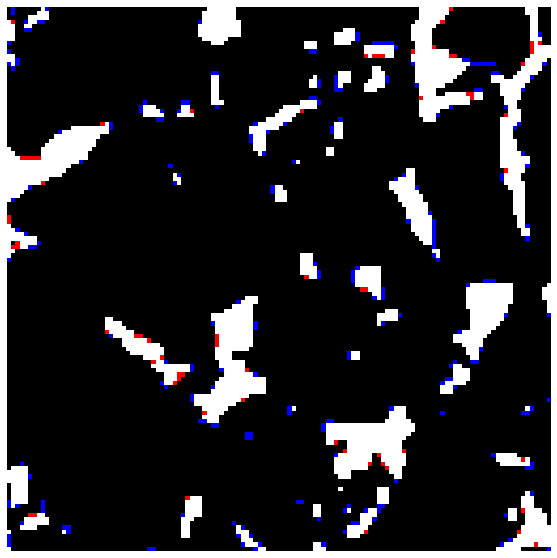

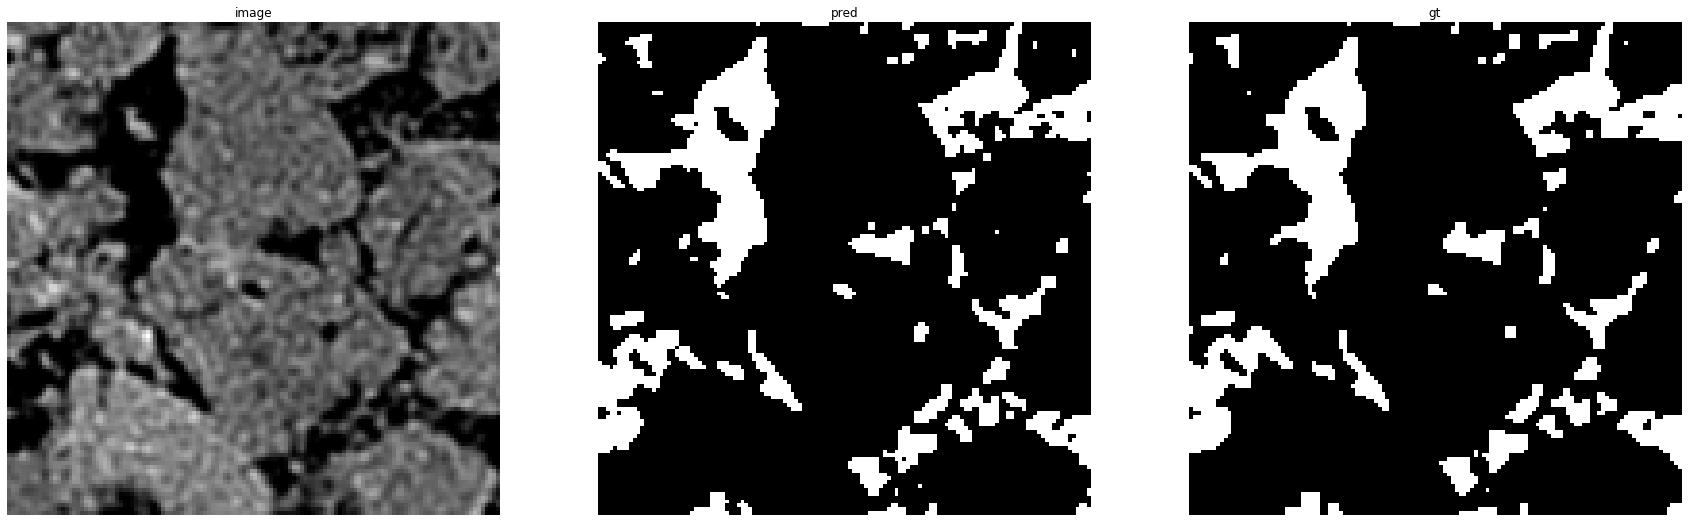

accuracy    : 0.9810791015625
precision   : 0.9369693011103853
recall      : 0.9608171466845278
f1          : 0.9487433862433863
pr_auc      : 0.9929442655316698
iou         : 0.9024850581944007


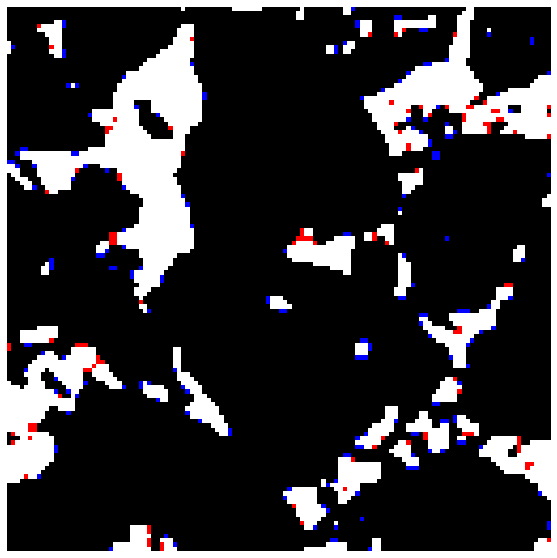

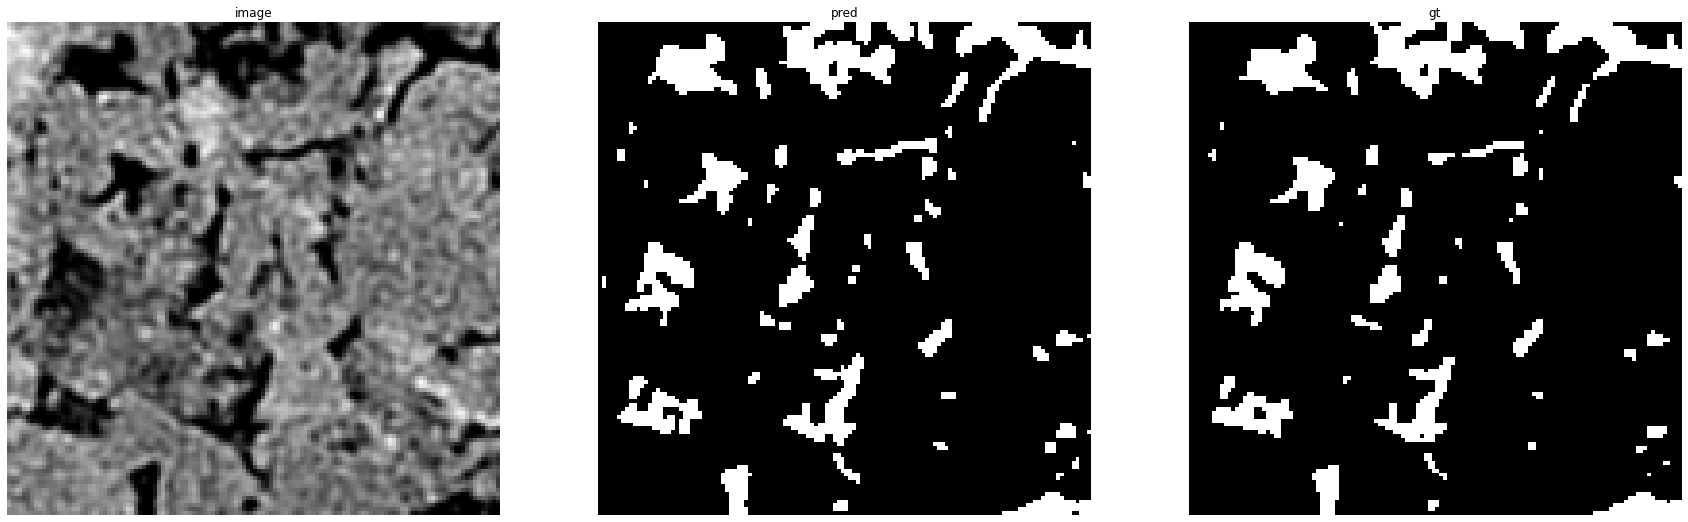

accuracy    : 0.980224609375
precision   : 0.8900841908325537
recall      : 0.9553212851405622
f1          : 0.9215496368038741
pr_auc      : 0.9842204229887648
iou         : 0.8545127974854064


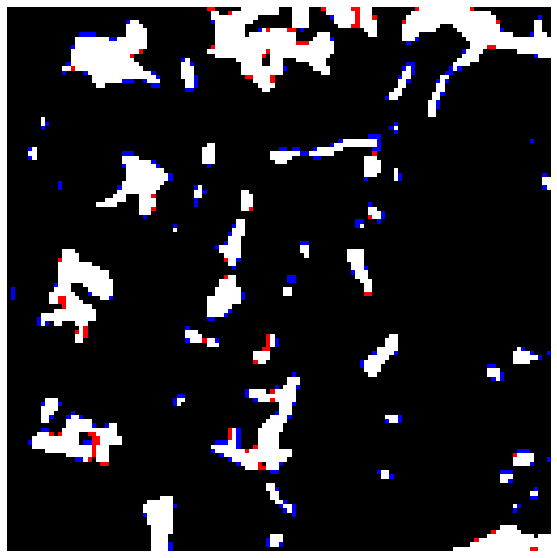

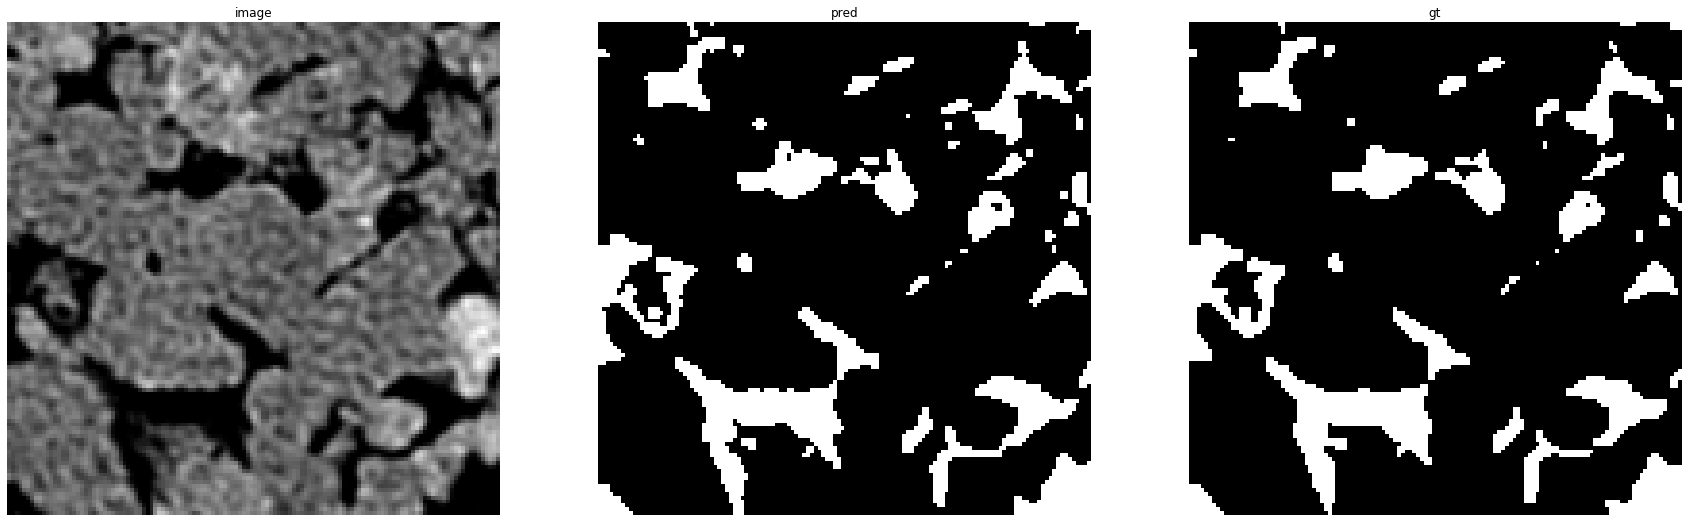

accuracy    : 0.981689453125
precision   : 0.9277234636871509
recall      : 0.9661818181818181
f1          : 0.9465621660135375
pr_auc      : 0.9929841739358697
iou         : 0.8985458234697329


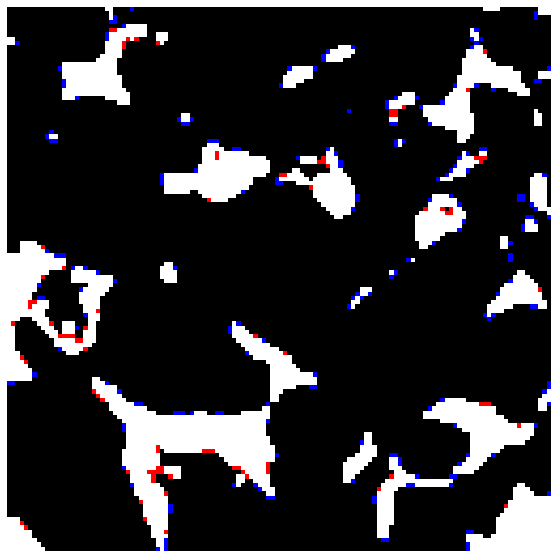

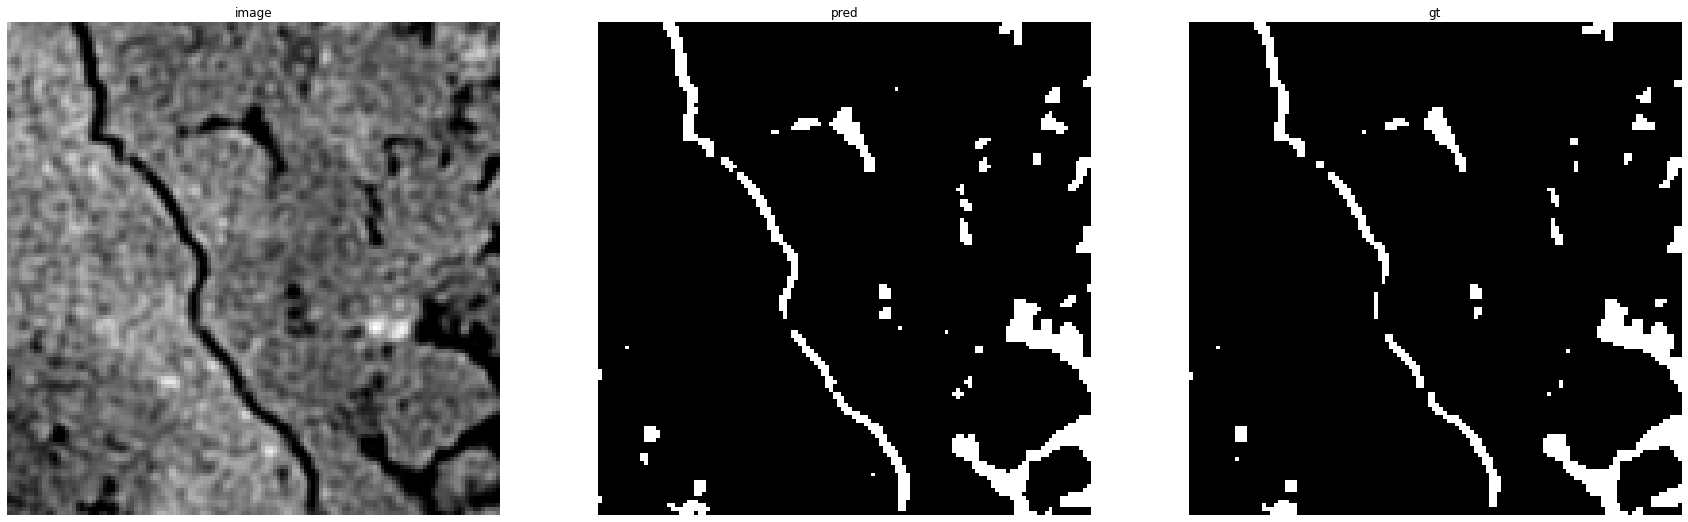

accuracy    : 0.98944091796875
precision   : 0.8791773778920309
recall      : 0.9697542533081286
f1          : 0.922247191011236
pr_auc      : 0.9863362018329378
iou         : 0.8557130942452044


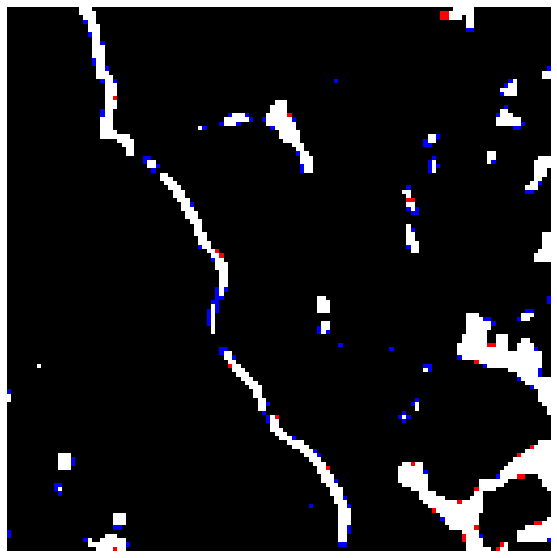

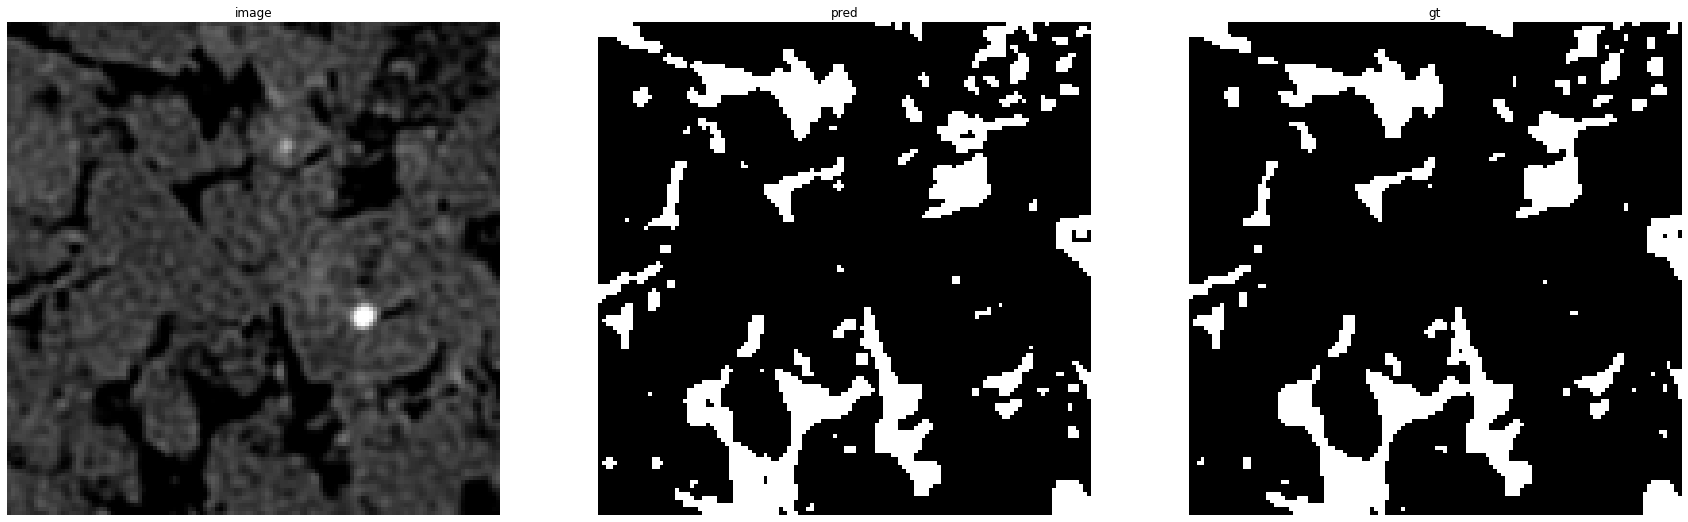

accuracy    : 0.9781494140625
precision   : 0.9085794655414908
recall      : 0.9634601043997018
f1          : 0.9352153456387985
pr_auc      : 0.9910058152614117
iou         : 0.8783140720598233


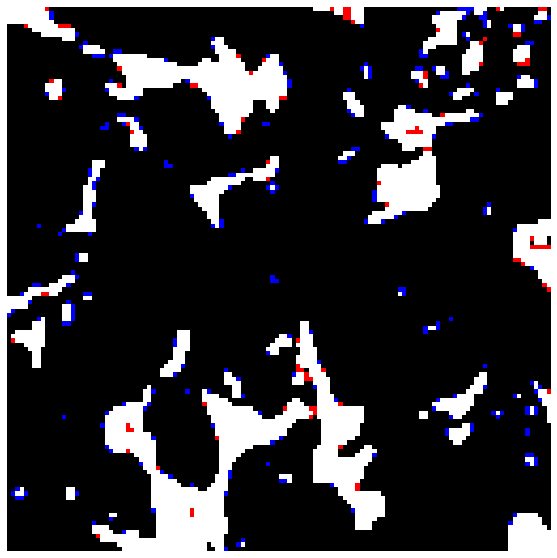

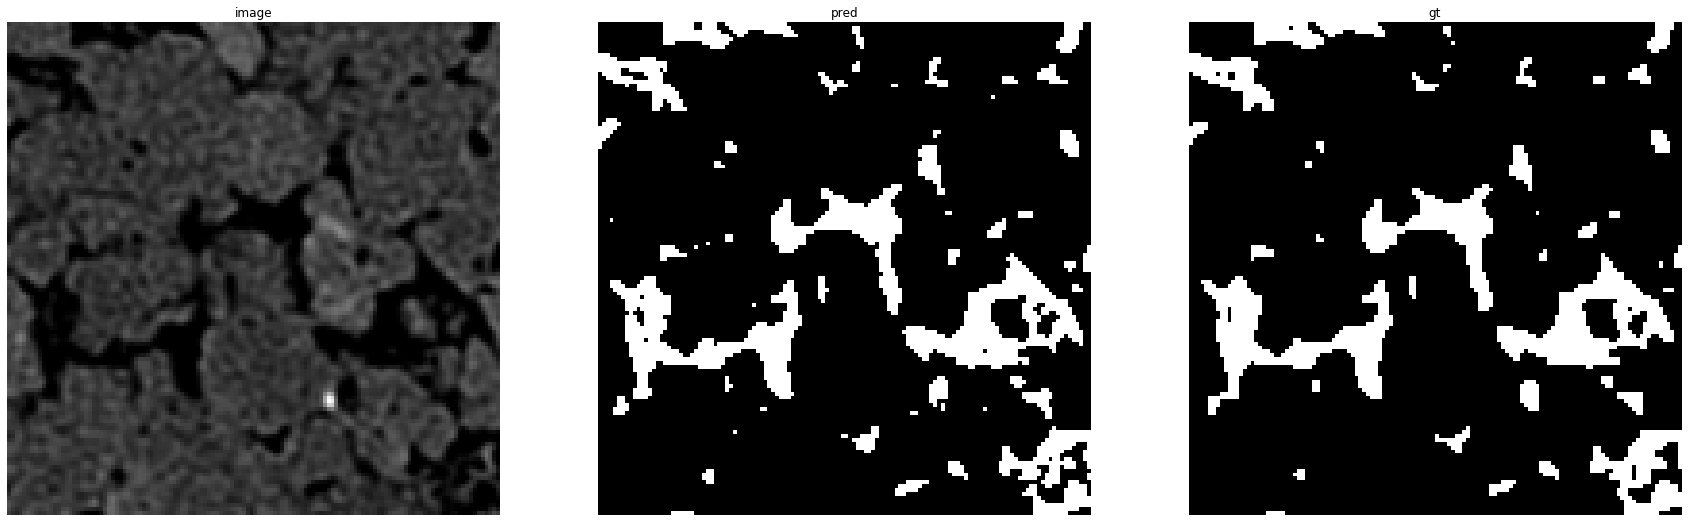

accuracy    : 0.98260498046875
precision   : 0.9297061159650516
recall      : 0.9559003674969375
f1          : 0.9426213005838534
pr_auc      : 0.9914639537887688
iou         : 0.8914699162223915




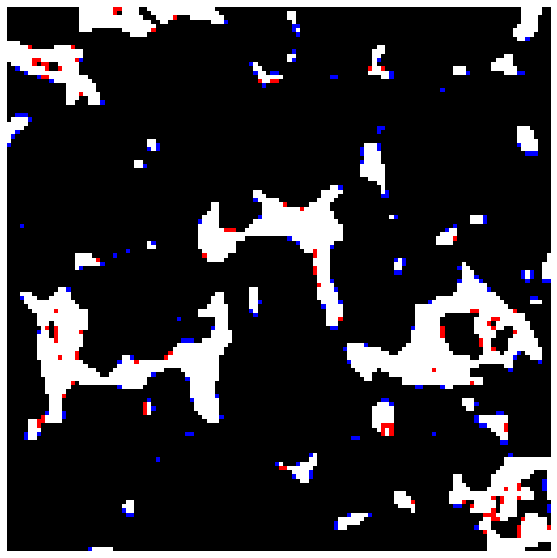

In [28]:
model.eval()

for stack_name, dataloader_test in dataloaders_test.items():
    cnt = to_plot
    
    stack_name = os.path.split(stack_name)[-1]
    dir_path = os.path.join(os.path.abspath('.'), 'samples', stack_name)
    if stack_name not in os.listdir(os.path.join('.', 'samples')):
        os.mkdir(dir_path)
    
    print('Prediction for {}:'.format(stack_name))
    for samples, masks in dataloader_test:

        preds = model(torch.from_numpy(samples).to(device)).cpu().data.numpy()

        for sample, mask, pred in list(zip(samples, masks, preds))[:cnt]:
            img_path = os.path.join('.', 'samples', stack_name, '{}.png'.format(cnt))
            plot_sample(sample[0], mask, pred, threshold, metrics, img_path)

            img_path = os.path.join('.', 'samples', stack_name, 'diff_{}.png'.format(cnt))
            make_colored_diff(mask, pred, threshold=threshold, path=img_path)
            
            cnt -= 1
            
        if cnt ==0:
            break
    print('\n')

## Results

In [14]:
import pandas as pd

from visualization_utils import make_df

df = make_df(results, model_name=data_conf['conf_name'])
df

accuracy  precision    recall        f1    pr_auc       iou  \
0   0.996114   0.955105  0.991948  0.973178  0.998268  0.947757   
1   0.962341   0.761979  0.996835  0.863727  0.992333  0.760140   
2   0.984990   0.910776  0.918655  0.914699  0.978448  0.842806   
3   0.989803   0.942292  0.939675  0.940982  0.990418  0.888541   
4   0.987712   0.893408  0.947992  0.919891  0.984970  0.851665   
5   0.988019   0.822039  0.993461  0.899657  0.992913  0.817615   
6   0.990016   0.988450  0.937321  0.962206  0.995410  0.927165   
7   0.993538   0.989510  0.954351  0.971612  0.997274  0.944792   
8   0.989899   0.920789  0.989397  0.953861  0.996167  0.911792   
9   0.988146   0.937296  0.989896  0.962878  0.997303  0.928413   
10  0.983055   0.921086  0.966788  0.943384  0.991828  0.892835   

                 stack      model  
0            carb96558  carb96558  
1               carb71  carb96558  
2              carbRNF  carb96558  
3   SPE_carb10_58_box3  carb96558  
4             SoilAh-1  carb96558  
5              SoilB-2  carb96558  
6       TeTree_subset1  carb96558  
7       TiTree_subset2  carb96558  
8              Urna_22  carb96558  
9              Urna_30  carb96558  
10             Urna_34  carb96558

In [34]:
# import subprocess
# subprocess.call(
#     'wkhtmltoimage -f png --width 0 {exp_name}.html {exp_name}.png'.format(exp_name=data_conf['conf_name']), 
#     shell=True)

In [40]:
# import imgkit
# imgkit.from_file('{exp_name}.html'.format(exp_name=data_conf['conf_name']),
#                  '{exp_name}.jpg'.format(exp_name=data_conf['conf_name']))

In [15]:
df.to_html('{}.html'.format(data_conf['conf_name']))
s = (
    'wkhtmltoimage -f png --width 0' 
    ' {exp_name}_exp/{exp_name}.html' 
    ' {exp_name}_exp/{exp_name}.png'.format(exp_name=data_conf['conf_name'])
)
print(s)

wkhtmltoimage -f png --width 0 carb96558_exp/carb96558.html carb96558_exp/carb96558.png


## Make prediction for particular stack

In [51]:
# stack_name = 'SPE_carb10_58_box3'
stack_name = 'TiTree_subset2'

In [52]:
stack = Stack.read_from_source('../../data/{}'.format(stack_name))

710it [00:01, 396.07it/s]
100%|██████████| 710/710 [00:06<00:00, 104.53it/s]


In [53]:
predicted_stack_1 = stack.apply(
    model, 
    model_config,
    patch_sizes=(128, 128, 1), 
    bs=32, num_workers=8, device=device,
    threshold=None)

25560it [00:00, 249139.94it/s]
25560it [02:02, 208.32it/s]
100%|██████████| 25560/25560 [00:07<00:00, 3392.42it/s]


In [54]:
predicted_stack_2 = stack.apply(
    model, 
    model_config,
    patch_sizes=(1, 128, 128), 
    bs=32, num_workers=8, device=device,
    threshold=None)

25560it [00:00, 117216.33it/s]
25560it [02:12, 193.00it/s]
100%|██████████| 25560/25560 [00:01<00:00, 14606.11it/s]


In [55]:
predicted_stack_3 = stack.apply(
    model, 
    model_config,
    patch_sizes=(128, 1, 128), 
    bs=32, num_workers=8, device=device,
    threshold=None)

25560it [00:00, 241496.67it/s]
25560it [02:13, 191.55it/s]
100%|██████████| 25560/25560 [00:01<00:00, 13730.05it/s]


In [56]:
iou(np.where(predicted_stack_1.targets == 255, 0, 1).astype(np.uint8), 
    predicted_stack_1.preds, 
    mode='stack',
    threshold=0.5)

0.9468094131697686

In [57]:
iou(np.where(predicted_stack_2.targets == 255, 0, 1).astype(np.uint8), 
    predicted_stack_2.preds, 
    mode='stack',
    threshold=0.5)

0.9460524229079726

In [58]:
iou(np.where(predicted_stack_3.targets == 255, 0, 1).astype(np.uint8), 
    predicted_stack_3.preds, 
    mode='stack',
    threshold=0.5)

0.9452328144640311

In [59]:
iou(np.where(stack.targets == 255, 0, 1).astype(np.uint8), 
    (predicted_stack_1.preds + predicted_stack_2.preds + predicted_stack_3.preds) / 3, 
    mode='stack',
    threshold=0.5)

0.9494787806802841

In [60]:
average_stack = Stack(predicted_stack_1.features, 
                      predicted_stack_1.targets, 
                      (predicted_stack_1.preds + predicted_stack_2.preds + predicted_stack_3.preds) / 3)

In [28]:
for ps, d in zip([(128, 128, 1), (128, 1, 128), (1, 128, 128)], ['z', 'y', 'x']):
    predicted_stack = stack.apply(
        model, 
        model_config=model_config,
        patch_sizes=ps, 
        bs=32, num_workers=8, device=device,
        threshold=None)
    predicted_stack.dump('../segmented_stacks/{}_{}'.format(stack_name, d), 
                         features=False, 
                         targets=True, 
                         preds=True)

8144it [00:00, 72365.38it/s]
8144it [00:44, 184.62it/s]
100%|██████████| 509/509 [00:03<00:00, 151.62it/s]
8144it [00:00, 200209.90it/s]
8144it [00:42, 190.34it/s]
100%|██████████| 509/509 [00:03<00:00, 136.05it/s]
8144it [00:00, 231673.55it/s]
8144it [00:43, 189.23it/s]
100%|██████████| 509/509 [00:03<00:00, 150.18it/s]


In [29]:
average_stack.dump('../segmented_stacks/{}_average'.format(stack_name), 
                   features=False, 
                   targets=True, 
                   preds=True)

100%|██████████| 509/509 [00:03<00:00, 150.61it/s]


In [31]:
for k, v in metrics.items():
    print('{:12}: {:.6f}'.format(k, 
                                 v(np.where(predicted_stack_1.targets == 255, 0, 1).astype(np.uint8), 
                                    predicted_stack_1.preds, 
                                    mode='stack')))

accuracy    : 0.989709
precision   : 0.947774
recall      : 0.941130
f1          : 0.944440
pr_auc      : 0.991501
iou         : 0.894730


## Validate dependence between metrics and distance to patch center

In [21]:
from visualization_utils import output_to_binary

In [25]:
import torch

In [36]:
import pandas as pd

In [62]:
df_agg = None

for i, (img, gt) in tqdm(enumerate(dataloaders_test['../../data/carbRNF'])):
    pred = model(torch.from_numpy(img)).cpu().data.numpy()
    binary = output_to_binary(pred, threshold=0.5, mode='batch')
    
    h, w = binary.shape[1:]
    x = np.arange(h).reshape(-1, 1)
    x = x.repeat(w, axis=1)
    y = np.arange(w).reshape(1, -1)
    y = y.repeat(h, axis=0)
    r = np.sqrt(np.square(x - (h - 1) / 2) + np.square(y - (w - 1) / 2))
    r = r.reshape(1, *r.shape).repeat(binary.shape[0], axis=0).flatten()
    tp = ((binary == 1) & (gt == 1)).astype(np.float32).flatten()
    fp = ((binary == 1) & (gt == 0)).astype(np.float32).flatten()
    fn = ((binary == 0) & (gt == 1)).astype(np.float32).flatten()
    
    df = pd.DataFrame(data={'r': r, 'tp': tp, 'fp': fp, 'fn': fn})
    df['r'] = df['r'].astype('int')
    df['count'] = 1
    if df_agg is None:
        df_agg = df.groupby(by='r').agg({'count': 'sum',
                                         'tp': 'sum',
                                         'fp': 'sum',
                                         'fn': 'sum'})
        
        portion = df.groupby(by='r').agg({'count': 'sum',
                                         'tp': 'sum',
                                         'fp': 'sum',
                                         'fn': 'sum'})
        df_agg = df_agg + portion
    
#     if i > 20:
#         break



0it [00:00, ?it/s]

1it [00:02,  2.39s/it]

2it [00:04,  2.30s/it]

3it [00:06,  2.14s/it]

4it [00:08,  2.04s/it]

5it [00:10,  2.03s/it]

6it [00:12,  2.03s/it]

7it [00:13,  1.95s/it]

8it [00:15,  1.91s/it]

9it [00:17,  1.93s/it]

10it [00:19,  1.87s/it]

11it [00:21,  1.84s/it]

12it [00:22,  1.81s/it]

13it [00:24,  1.80s/it]

14it [00:26,  1.78s/it]

15it [00:28,  1.77s/it]

16it [00:29,  1.77s/it]

17it [00:31,  1.77s/it]

18it [00:33,  1.76s/it]

19it [00:35,  1.76s/it]

20it [00:36,  1.75s/it]

21it [00:38,  1.76s/it]

22it [00:40,  1.76s/it]

23it [00:42,  1.76s/it]

24it [00:43,  1.77s/it]

25it [00:45,  1.80s/it]

26it [00:47,  1.78s/it]

27it [00:49,  1.77s/it]

28it [00:51,  1.77s/it]

29it [00:52,  1.77s/it]

30it [00:54,  1.76s/it]

31it [00:56,  1.76s/it]

32it [00:58,  1.76s/it]

33it [00:59,  1.76s/it]

34it [01:01,  1.76s/it]

35it [01:03,  1.75s/it]

36it [01:05,  1.76s/it]

37it [01:06,  1.76s/it]

38it [01:08,  1.76s/it]

39it [01:10,  1.76s/it]

40it [01:12,

In [63]:
df_agg

count      tp     fp     fn
r                              
0     256    20.0    4.0    0.0
1     512    44.0   12.0    0.0
2    1280   130.0   16.0    6.0
3    1280   124.0    4.0   14.0
4    1792   154.0    6.0    8.0
5    2048   156.0   30.0   20.0
6    2816   220.0   22.0   34.0
7    3328   330.0   24.0   38.0
8    3072   324.0   24.0   28.0
9    3840   336.0   22.0   38.0
10   4352   430.0   34.0   36.0
11   4096   456.0   62.0   42.0
12   5888   678.0   38.0   54.0
13   4864   540.0   46.0   54.0
14   6400   632.0   54.0   40.0
15   6144   544.0   56.0   50.0
16   6400   594.0   56.0   68.0
17   6912   700.0   72.0   60.0
18   6656   702.0   78.0   40.0
19   8960   912.0   68.0   82.0
20   8448   924.0   70.0   60.0
21   8448   942.0   74.0   90.0
22   8704   932.0   76.0  102.0
23   8960   912.0   88.0   86.0
24  11008  1068.0  110.0   88.0
25   9728   924.0   84.0   98.0
26  10496  1048.0  114.0  122.0
27  11520  1142.0  126.0  100.0
28  11008  1070.0  110.0   82.0
29  11776  1062.0  114.0   78.0
..    ...     ...    ...    ...
60  24320  2366.0  180.0  178.0
61  26368  2554.0  190.0  196.0
62  25344  2414.0  166.0  274.0
63  25600  2440.0  152.0  232.0
64  19712  1902.0  150.0  222.0
65  20224  2022.0  138.0  200.0
66  17408  1678.0  138.0  194.0
67  16128  1538.0  126.0  192.0
68  14592  1438.0  116.0  166.0
69  12288  1254.0  104.0  132.0
70  14592  1588.0  110.0  162.0
71  11008  1142.0   94.0  160.0
72  11520  1368.0   82.0  134.0
73  10240  1200.0   86.0  132.0
74   8960   994.0   54.0  112.0
75   9472  1044.0   66.0   96.0
76   7168   770.0   36.0   80.0
77   7936   846.0   48.0  102.0
78   6400   666.0   44.0   66.0
79   6400   680.0   40.0   86.0
80   5632   584.0   42.0   84.0
81   3840   364.0   30.0   46.0
82   5376   518.0   26.0   64.0
83   3072   346.0   10.0   52.0
84   4352   484.0   28.0   42.0
85   1792   186.0    6.0   16.0
86   2304   192.0   10.0   22.0
87   1536   140.0    4.0   16.0
88    768    84.0    2.0    4.0
89    768    76.0    6.0   14.0

[90 rows x 4 columns]

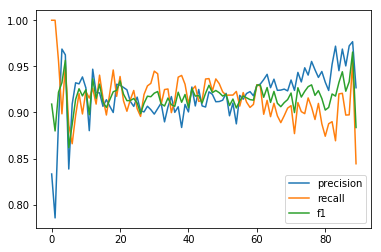

In [65]:
precision = df_agg['tp'] / (df_agg['tp'] + df_agg['fp'])
recall = df_agg['tp'] / (df_agg['tp'] + df_agg['fn'])
plt.plot(df_agg.index, precision, label='precision')
plt.plot(df_agg.index, recall, label='recall')
plt.plot(df_agg.index, 2 * precision * recall / (precision + recall), label='f1')
plt.legend(loc='best')
plt.show()

In [76]:
(2 * precision * recall / (precision + recall)).mean()

0.9169255

In [74]:
np.mean(results['test_metrics']['../../data/carb96558']['f1'])

0.9757604510306116

In [75]:
np.mean(results['test_metrics']['../../data/carbRNF']['f1'])

0.9172696807633565

In [77]:
np.mean(results['test_metrics']['../../data/carbRNF']['iou'])

0.8471886630965806

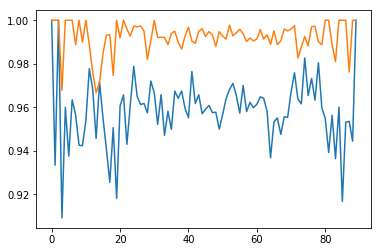

In [60]:
precision = df_agg['tp'] / (df_agg['tp'] + df_agg['fp'])
recall = df_agg['tp'] / (df_agg['tp'] + df_agg['fn'])
plt.plot(df_agg.index, precision)
plt.plot(df_agg.index, recall)
plt.show()

In [14]:
for x, y in dataloader_train:
    break

In [15]:
x.shape

(32, 1, 128, 128)

In [16]:
x[0].mean()

0.011243731

In [19]:
x[0].std()

0.79318494

In [22]:
a = data_train[0]['features']

In [24]:
a.shape

(128, 128, 1)

In [25]:
from stack_segmentation.io import image_process_basic

In [27]:
b = image_process_basic(a)

In [29]:
b.mean()

0.24210383

In [33]:
c = np.squeeze(b)[np.newaxis, np.newaxis, :, :]

In [36]:
import torch

In [55]:
p = model(torch.from_numpy(c).to(device))

In [56]:
d = p.cpu().data.numpy()[0]

In [57]:
from visualization_utils import output_to_binary

In [62]:
e = output_to_binary(d, threshold=0.5)

In [63]:
e.shape

(128, 128)

In [64]:
e

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

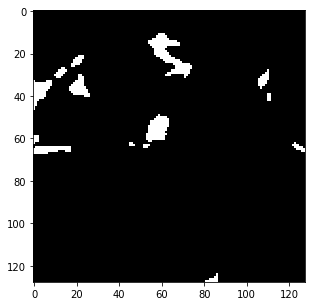

In [65]:
plt.figure(figsize=(5, 5))
plt.imshow(e, cmap='gray')
plt.show()